In [1]:
import math
import numpy as np
import random
from time import time
import json

import pandas as pd
from downcast import reduce

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb

import optuna
import joblib

from model import Autoencoder, Regressor
import torch
from torch import nn, optim
from utils import *

In [2]:
import pprint
pp = pprint.PrettyPrinter()

# PREPARE FEATURE SETS

In [3]:
OLD_RAW_PATH = "../../datasets/train_data_iowa.csv" 
RAW_PATH = '../../datasets/raw.csv' 
CF_PATH = "../../datasets/crafted_features.csv"

In [4]:
# Not needed since 
features = [
    "location",
    "location_x", "location_y",
    "restaurant_location_x", "restaurant_location_y", 
    "order_time",
    "etd",
    "restaurant_queue",
    "max_pre_shift",
    "max_post_shift",
    "restaurants_before_customer",
    "customers_before_customer",
    "len_vehicle_route_to_customer",
]

for i in range(24):
    features.append(f"vehicle_route_to_customer_pos_x_{i}")
    features.append(f"vehicle_route_to_customer_pos_y_{i}")
    features.append(f"vehicle_route_to_customer_action_{i}")
    features.append(f"vehicle_route_to_customer_time_action_{i}") 

In [5]:
def load_csv(path):
    start_time = time()

    meta = pd.read_csv(path, header=0, sep=";", nrows=2, index_col=[0])
    meta = reduce(meta)
    dtypes = dict(meta.dtypes)

    data = pd.read_csv(path, header=0, sep=";", dtype=dtypes, index_col=[0]) 

    print(f"Elapsed time: {time() - start_time} seconds")
    print("\n")
    print(data.info(verbose=False, memory_usage="deep"))
    print("\n")
          
    X = data.loc[:, data.columns != 'atd']
    y = data['atd'] - data['etd']

    return data, X, y

In [6]:
# Import data
raw, X_raw, y_raw = load_csv(RAW_PATH)
crafted, X_crafted, y_crafted = load_csv(CF_PATH)

Elapsed time: 3.204479217529297 seconds


<class 'pandas.core.frame.DataFrame'>
Int64Index: 850469 entries, 0 to 850468
Columns: 110 entries, location to vehicle_route_to_customer_time_action_23
dtypes: float16(50), int16(4), int8(56)
memory usage: 139.5 MB
None


Elapsed time: 0.4423646926879883 seconds


<class 'pandas.core.frame.DataFrame'>
Int64Index: 850469 entries, 0 to 850468
Columns: 13 entries, location_x to n_delivery_stops
dtypes: float16(4), int16(3), int8(6)
memory usage: 22.7 MB
None




# Feature Engineering

Features used in Hildebrandt et al. (2020):
<ul>
    <li>n_stops: sum(vehicle_route_to_customer_action_i = 1 or 2)</li>
    <li>n_pickup_stops: sum(vehicle_route_to_customer_action_i = 1)</li>
    <li>n_delivery_stops: sum(vehicle_route_to_customer_action_i = 2)</li>
    <li>max_pre_shift: already given</li>    
    <li>max_post_shift: already given</li>
    <li>prep_time: already given ( == restaurant_queue)</li>
    <li>order_time: already given</li>
    <li>eta_pom: already given</li>
    <li>customer_location: already given</li>
    <li>restaurant_location: already given</li>
</ul>

In [7]:
#Define strings to identify needed columns for each feature we want to craft
query_strings = {
    "n_stops" : ["vehicle_route_to_customer_action"],
        
    "n_pickup_stops" : ["vehicle_route_to_customer_action"],
    
    "n_delivery_stops" : ["vehicle_route_to_customer_action"],
}

raw_feats = [
    "location_x", "location_y",
    "restaurant_location_x", "restaurant_location_y",
    "etd", 
    "atd", 
    "order_time", 
    "max_pre_shift", 
    "max_post_shift", 
    "restaurant_queue",
    
    
]

mask = pd.DataFrame()
feats = pd.DataFrame()

# First, add used raw features to feats
for feat in raw_feats:
    feats[feat] = raw[feat]

# Craft features and add to feats
for key,value in query_strings.items():
    
    needed_columns = [col for col in raw.columns if any(x in col for x in value)]
    inp = raw[needed_columns]
    
    if key == "n_stops":
        for col in inp:
            mask[col] = (inp[col] > 0) & (inp[col] < 3)
            feats[key] = mask.sum(axis=1)
    
    if key == "n_pickup_stops": 
        for col in inp:
            mask[col] = inp[col] == 1
            feats[key] = mask.sum(axis=1)
    
    if key == "n_delivery_stops": 
        for col in inp:
            mask[col] = inp[col] == 2
            feats[key] = mask.sum(axis=1)

In [85]:
feats.to_csv(CF_PATH, sep=";")

# Data description

## Temporal distributions

In [7]:
def displot(data, xlabel, ylabel, filepath=None, kind="kde", bw_adjust=2):
    ax = sns.displot(data, 
            kind=kind,
            bw_adjust=bw_adjust,
            height=4, aspect=6/4,
            legend=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    if filepath != None:
        ax.savefig(filepath)
    plt.show(ax)

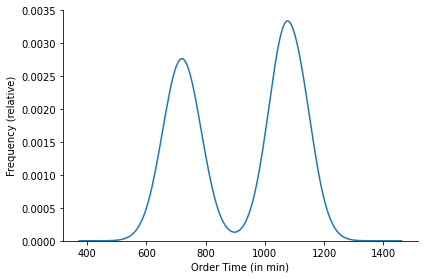

In [8]:
displot(
    data = crafted["order_time"], 
    xlabel = "Order Time (in min)", 
    ylabel = "Frequency (relative)", 
    filepath = "Plots/order_time_dist.png"
)

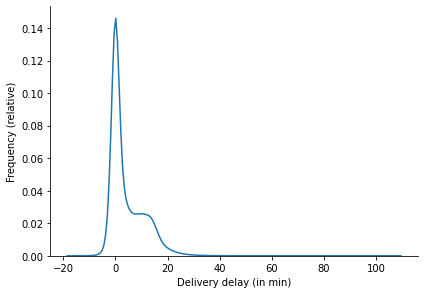

In [9]:
displot(
    data = crafted["atd"]-crafted["etd"],
    xlabel = "Delivery delay (in min)",
    ylabel = "Frequency (relative)",
    filepath = "Plots/delivery_delay.png",
)

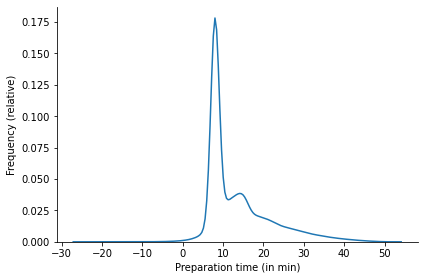

In [10]:
displot(
    data = crafted["restaurant_queue"],
    xlabel = "Preparation time (in min)",
    ylabel = "Frequency (relative)",
    filepath = "Plots/prep_time.png",
)

## Spatial distributions

Idea: Scatterplot x Heatmap?

(23341, 2)


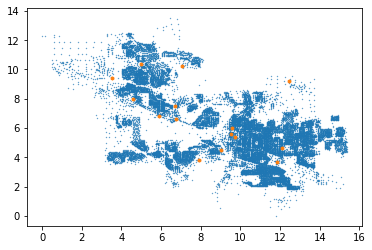

In [11]:
customer_locations = np.asarray(list(set(zip(raw.location_x, raw.location_y))))
customer_locations_x = [t[0] for t in customer_locations]
customer_locations_y = [t[1] for t in customer_locations]

restaurant_locations = list(set(zip(raw.restaurant_location_x, raw.restaurant_location_y)))
restaurant_locations_x = [t[0] for t in restaurant_locations]
restaurant_locations_y = [t[1] for t in restaurant_locations]

print(customer_locations.shape)
plt.scatter(customer_locations_x, customer_locations_y, s=0.1)
plt.scatter(restaurant_locations_x, restaurant_locations_y, s=10, marker="h")
plt.savefig("Plots/spatial_dist.png")

plt.show()

# Study

### Helper functions ###

In [7]:
def plot_convergence(results_arr, title):
    for json in results_arr:
        plt.plot(json[0]["sample_sizes"], json[0]["results"], label=json[1])
    plt.xlabel("Sample sizes")
    plt.ylabel("MSE")
    plt.legend()
    plt.savefig(f"SampleSize/{title}.png")
    plt.show()

def best_iteration(evals_result):
    best = evals_result[0]
    for i in evals_result:
        if best > i:
            best = i
    return best 

def print_results(study):
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("Value: {}".format(trial.value))
    print("Params: ")
    for key, value in trial.params.items():
        print("{}: {}".format(key, value))  

def write_json(sample_sizes, results, filename):
    results_json = {}
    results_json["sample_sizes"] = sample_sizes
    results_json["results"] = results
    with open(filename, 'w') as outfile:
        json.dump(eval(str(results_json)), outfile)
        
def read_json(filename):
    with open(filename, "r") as read:
        return json.load(read)
    
def add_noise(X, features, mu, sigma):
    mu = mu
    sigma = sigma 
    new_X = pd.DataFrame()
    for f in X.columns:
        if f in features:
            new_X[f] = X[f] + np.random.normal(mu, sigma)
        else:
            new_X[f] = X[f]
    return new_X

### Training functions

In [8]:
def nn_train(model, data, params, feature_list=None, rows=None):

    # Set the seed for reproducability
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("Importing data.")

    etd_dataset = ETDData(data=data, objective=model.mode) #TODO: change to model.mode
    split = DataSplit(etd_dataset, shuffle=True, rows=rows)
    trainloader, _, testloader = split.get_split(batch_size=params["batch_size"], num_workers=8)

    print("Start training.")
    patience = params["patience"]
    criterion = params["criterion"]  
    optimizer = params["optimizer"]

    early_stopping = EarlyStopping(patience=params["patience"], verbose=True) 
    epochs = params["epochs"]

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.float().to(device)
            labels = labels.float().view(-1, model.view).to(device) 
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels) 
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        test_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.float().to(device)
                labels = labels.float().view(-1, model.view).to(device) 
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)
                test_loss += batch_loss.item()
        print(f"Epoch {epoch+1}/{epochs}.. "
                f"Train loss: {running_loss / len(trainloader):.3f}.. "
                f"Test loss: {test_loss / len(testloader):.3f}.. ")
        early_stopping(test_loss / len(testloader), model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        model.train()

    print('Finished Training')
    #model.load_state_dict(torch.load('checkpoint.pt'))
    #model.save(model, 'perceptron.pth')
    return model, abs(early_stopping.best_score)

## Part 1:  Sample size testing

With the first part, we seek to examine the convergence behavior of our models and answer following question: How many samples are enough to train the model without ? 
We determine the answer to that question graphically. For that, we construct plots where the x-axis represents the number of samples used in the corresponding training instance, and the y-axis represents the corresponding L<sub>2</sub>-loss measured with the mean squared error.

### Test 1.1 & 1.2: Tree-based ensembles: GBDT and RF (LightGBM Implementation)

In [26]:
### Convergence Test for LightGBM's GBDT ###
def sample_size_ensembles(X, y, params, filename, start=2000, stop=202000, step=2000):
    
    sample_sizes = np.arange(start=start, stop=stop, step=step).tolist()
    results = []
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=42)
    
    for rows in sample_sizes:
        train_set = lgb.Dataset(X_train[:rows],y_train[:rows])
        val_set = lgb.Dataset(X_test, y_test)
        evals_result = {}
        bst = lgb.train(
            params,
            train_set=train_set,
            valid_sets=[val_set, train_set],
            valid_names=["Validation error", "Train error"],
            verbose_eval=5,
            evals_result = evals_result,
        )
        best_mse = best_iteration(evals_result["Validation error"]["l2"])
        results.append(best_mse)
    
    write_json(sample_sizes, results, filename)

In [53]:
params_gbdt = {
    "boosting_type" : "gbdt",
    "metrics" : "l2",
    "learning_rate" : 0.02, 
    "num_threads"  : 6,
    "random_state" : 42,
    "force_row_wise" : True,
    "n_estimators" : 1000,
    "early_stopping_rounds" : 20,
}
sample_size_ensembles(X_raw, y_raw, params_gbdt, "SampleSize/GBDT_SampleSizeTest_Raw.txt")

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Total Bins 8215
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 81
[LightGBM] [Info] Start training from score 4.151500
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 37.6452	Validation error's l2: 38.9745
[10]	Train error's l2: 35.407	Validation error's l2: 37.6547
[15]	Train error's l2: 33.3757	Validation error's l2: 36.5077
[20]	Train error's l2: 31.491	Validation error's l2: 35.5088
[25]	Train error's l2: 29.8714	Validation error's l2: 34.7452
[30]	Train error's l2: 28.4434	Validation error's l2: 34.0658
[35]	Train error's l2: 27.1692	Validation error's l2: 33.5142
[40]	Train error's l2: 25.9415	Validation error's l2: 33.0014
[45]	Train error's l2: 24.8322	Validation error's l2: 32.575
[50]	Train error's l2: 23.8537	Validation error's l2: 32.2513
[55]	Train error's l2: 22.9931	Validation error's l2: 32.0075
[60]	Train error's l2: 22.1193	Validation error's l2: 31.7442
[65]	Train error's l

[215]	Train error's l2: 18.8147	Validation error's l2: 28.5564
[220]	Train error's l2: 18.6494	Validation error's l2: 28.5573
[225]	Train error's l2: 18.4831	Validation error's l2: 28.5613
[230]	Train error's l2: 18.3225	Validation error's l2: 28.5521
[235]	Train error's l2: 18.1658	Validation error's l2: 28.5417
[240]	Train error's l2: 18.0092	Validation error's l2: 28.5407
[245]	Train error's l2: 17.8615	Validation error's l2: 28.5449
[250]	Train error's l2: 17.7048	Validation error's l2: 28.5445
[255]	Train error's l2: 17.5531	Validation error's l2: 28.5467
Early stopping, best iteration is:
[239]	Train error's l2: 18.0374	Validation error's l2: 28.5401
[LightGBM] [Info] Total Bins 9780
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 85
[LightGBM] [Info] Start training from score 4.185375
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.4494	Validation error's l2: 38.692
[10]	Train error's l2: 37.563	Valid

[285]	Train error's l2: 19.6668	Validation error's l2: 28.1019
[290]	Train error's l2: 19.5582	Validation error's l2: 28.096
[295]	Train error's l2: 19.4521	Validation error's l2: 28.0953
[300]	Train error's l2: 19.3441	Validation error's l2: 28.0871
[305]	Train error's l2: 19.2466	Validation error's l2: 28.0874
[310]	Train error's l2: 19.139	Validation error's l2: 28.0862
[315]	Train error's l2: 19.0385	Validation error's l2: 28.0815
[320]	Train error's l2: 18.9375	Validation error's l2: 28.0747
[325]	Train error's l2: 18.8411	Validation error's l2: 28.0727
[330]	Train error's l2: 18.7526	Validation error's l2: 28.07
[335]	Train error's l2: 18.6646	Validation error's l2: 28.0704
[340]	Train error's l2: 18.5713	Validation error's l2: 28.0738
[345]	Train error's l2: 18.4853	Validation error's l2: 28.0733
[350]	Train error's l2: 18.4	Validation error's l2: 28.073
Early stopping, best iteration is:
[334]	Train error's l2: 18.6826	Validation error's l2: 28.0697
[LightGBM] [Info] Total Bins

[155]	Train error's l2: 24.3639	Validation error's l2: 28.1927
[160]	Train error's l2: 24.201	Validation error's l2: 28.1595
[165]	Train error's l2: 24.0466	Validation error's l2: 28.133
[170]	Train error's l2: 23.9012	Validation error's l2: 28.1043
[175]	Train error's l2: 23.7611	Validation error's l2: 28.0763
[180]	Train error's l2: 23.6238	Validation error's l2: 28.0563
[185]	Train error's l2: 23.4894	Validation error's l2: 28.0418
[190]	Train error's l2: 23.3602	Validation error's l2: 28.0246
[195]	Train error's l2: 23.2307	Validation error's l2: 28.0104
[200]	Train error's l2: 23.1028	Validation error's l2: 27.9978
[205]	Train error's l2: 22.9809	Validation error's l2: 27.988
[210]	Train error's l2: 22.862	Validation error's l2: 27.9727
[215]	Train error's l2: 22.7485	Validation error's l2: 27.9613
[220]	Train error's l2: 22.6324	Validation error's l2: 27.9546
[225]	Train error's l2: 22.5256	Validation error's l2: 27.946
[230]	Train error's l2: 22.4173	Validation error's l2: 27.93

[320]	Train error's l2: 21.2141	Validation error's l2: 27.7144
[325]	Train error's l2: 21.1295	Validation error's l2: 27.7069
[330]	Train error's l2: 21.0598	Validation error's l2: 27.702
[335]	Train error's l2: 20.9848	Validation error's l2: 27.7001
[340]	Train error's l2: 20.9082	Validation error's l2: 27.6979
[345]	Train error's l2: 20.8432	Validation error's l2: 27.6963
[350]	Train error's l2: 20.7698	Validation error's l2: 27.6958
[355]	Train error's l2: 20.6948	Validation error's l2: 27.6879
[360]	Train error's l2: 20.6267	Validation error's l2: 27.6865
[365]	Train error's l2: 20.559	Validation error's l2: 27.6815
[370]	Train error's l2: 20.4906	Validation error's l2: 27.6767
[375]	Train error's l2: 20.4237	Validation error's l2: 27.6761
[380]	Train error's l2: 20.3555	Validation error's l2: 27.6711
[385]	Train error's l2: 20.2868	Validation error's l2: 27.6702
[390]	Train error's l2: 20.2193	Validation error's l2: 27.6707
[395]	Train error's l2: 20.1551	Validation error's l2: 27

[35]	Train error's l2: 31.6301	Validation error's l2: 32.4623
[40]	Train error's l2: 30.9823	Validation error's l2: 31.9083
[45]	Train error's l2: 30.4171	Validation error's l2: 31.443
[50]	Train error's l2: 29.9018	Validation error's l2: 31.0326
[55]	Train error's l2: 29.442	Validation error's l2: 30.6617
[60]	Train error's l2: 29.0308	Validation error's l2: 30.3384
[65]	Train error's l2: 28.6619	Validation error's l2: 30.064
[70]	Train error's l2: 28.325	Validation error's l2: 29.8142
[75]	Train error's l2: 28.0265	Validation error's l2: 29.6072
[80]	Train error's l2: 27.7636	Validation error's l2: 29.4293
[85]	Train error's l2: 27.4982	Validation error's l2: 29.2583
[90]	Train error's l2: 27.2506	Validation error's l2: 29.1062
[95]	Train error's l2: 27.0337	Validation error's l2: 28.9803
[100]	Train error's l2: 26.8165	Validation error's l2: 28.8556
[105]	Train error's l2: 26.6009	Validation error's l2: 28.7439
[110]	Train error's l2: 26.389	Validation error's l2: 28.6244
[115]	Trai

[260]	Train error's l2: 23.1768	Validation error's l2: 27.477
[265]	Train error's l2: 23.0965	Validation error's l2: 27.4662
[270]	Train error's l2: 23.0242	Validation error's l2: 27.4517
[275]	Train error's l2: 22.9492	Validation error's l2: 27.4402
[280]	Train error's l2: 22.8699	Validation error's l2: 27.4325
[285]	Train error's l2: 22.7996	Validation error's l2: 27.4261
[290]	Train error's l2: 22.7271	Validation error's l2: 27.4184
[295]	Train error's l2: 22.6558	Validation error's l2: 27.4107
[300]	Train error's l2: 22.5861	Validation error's l2: 27.4036
[305]	Train error's l2: 22.5153	Validation error's l2: 27.3982
[310]	Train error's l2: 22.4528	Validation error's l2: 27.3916
[315]	Train error's l2: 22.3885	Validation error's l2: 27.3869
[320]	Train error's l2: 22.3178	Validation error's l2: 27.3799
[325]	Train error's l2: 22.2506	Validation error's l2: 27.375
[330]	Train error's l2: 22.1899	Validation error's l2: 27.3713
[335]	Train error's l2: 22.1233	Validation error's l2: 27

[370]	Train error's l2: 22.2515	Validation error's l2: 27.3435
[375]	Train error's l2: 22.196	Validation error's l2: 27.3377
[380]	Train error's l2: 22.1402	Validation error's l2: 27.3333
[385]	Train error's l2: 22.0825	Validation error's l2: 27.3302
[390]	Train error's l2: 22.0303	Validation error's l2: 27.3294
[395]	Train error's l2: 21.9749	Validation error's l2: 27.3267
[400]	Train error's l2: 21.9254	Validation error's l2: 27.3269
[405]	Train error's l2: 21.8757	Validation error's l2: 27.3236
[410]	Train error's l2: 21.8177	Validation error's l2: 27.322
[415]	Train error's l2: 21.755	Validation error's l2: 27.3182
[420]	Train error's l2: 21.7001	Validation error's l2: 27.3142
[425]	Train error's l2: 21.6495	Validation error's l2: 27.3129
[430]	Train error's l2: 21.5968	Validation error's l2: 27.312
[435]	Train error's l2: 21.5428	Validation error's l2: 27.3078
[440]	Train error's l2: 21.4866	Validation error's l2: 27.3074
[445]	Train error's l2: 21.433	Validation error's l2: 27.30

[545]	Train error's l2: 20.8359	Validation error's l2: 27.2174
[550]	Train error's l2: 20.7905	Validation error's l2: 27.2174
[555]	Train error's l2: 20.7434	Validation error's l2: 27.2139
[560]	Train error's l2: 20.7013	Validation error's l2: 27.2132
[565]	Train error's l2: 20.6597	Validation error's l2: 27.2125
[570]	Train error's l2: 20.6139	Validation error's l2: 27.21
[575]	Train error's l2: 20.571	Validation error's l2: 27.2055
[580]	Train error's l2: 20.5264	Validation error's l2: 27.206
[585]	Train error's l2: 20.4831	Validation error's l2: 27.2032
[590]	Train error's l2: 20.4469	Validation error's l2: 27.2034
[595]	Train error's l2: 20.4101	Validation error's l2: 27.2051
[600]	Train error's l2: 20.3717	Validation error's l2: 27.2063
[605]	Train error's l2: 20.3263	Validation error's l2: 27.207
Early stopping, best iteration is:
[589]	Train error's l2: 20.4538	Validation error's l2: 27.2028
[LightGBM] [Info] Total Bins 10623
[LightGBM] [Info] Number of data points in the train 

[35]	Train error's l2: 32.123	Validation error's l2: 32.3505
[40]	Train error's l2: 31.4852	Validation error's l2: 31.8053
[45]	Train error's l2: 30.9182	Validation error's l2: 31.3063
[50]	Train error's l2: 30.4478	Validation error's l2: 30.9163
[55]	Train error's l2: 30.0257	Validation error's l2: 30.5654
[60]	Train error's l2: 29.648	Validation error's l2: 30.2576
[65]	Train error's l2: 29.337	Validation error's l2: 30.0189
[70]	Train error's l2: 29.0338	Validation error's l2: 29.7804
[75]	Train error's l2: 28.7633	Validation error's l2: 29.579
[80]	Train error's l2: 28.5132	Validation error's l2: 29.3961
[85]	Train error's l2: 28.2744	Validation error's l2: 29.2229
[90]	Train error's l2: 28.0378	Validation error's l2: 29.0514
[95]	Train error's l2: 27.8278	Validation error's l2: 28.8997
[100]	Train error's l2: 27.6307	Validation error's l2: 28.7679
[105]	Train error's l2: 27.4399	Validation error's l2: 28.6404
[110]	Train error's l2: 27.2679	Validation error's l2: 28.527
[115]	Trai

[135]	Train error's l2: 26.6538	Validation error's l2: 28.0727
[140]	Train error's l2: 26.5283	Validation error's l2: 28.004
[145]	Train error's l2: 26.4062	Validation error's l2: 27.939
[150]	Train error's l2: 26.2864	Validation error's l2: 27.8832
[155]	Train error's l2: 26.1766	Validation error's l2: 27.8333
[160]	Train error's l2: 26.0708	Validation error's l2: 27.7851
[165]	Train error's l2: 25.9686	Validation error's l2: 27.7402
[170]	Train error's l2: 25.8731	Validation error's l2: 27.7005
[175]	Train error's l2: 25.7781	Validation error's l2: 27.6679
[180]	Train error's l2: 25.6883	Validation error's l2: 27.635
[185]	Train error's l2: 25.6018	Validation error's l2: 27.6007
[190]	Train error's l2: 25.5146	Validation error's l2: 27.5683
[195]	Train error's l2: 25.4323	Validation error's l2: 27.5404
[200]	Train error's l2: 25.3485	Validation error's l2: 27.5113
[205]	Train error's l2: 25.2656	Validation error's l2: 27.4839
[210]	Train error's l2: 25.1832	Validation error's l2: 27.

[105]	Train error's l2: 27.6596	Validation error's l2: 28.6417
[110]	Train error's l2: 27.4879	Validation error's l2: 28.5268
[115]	Train error's l2: 27.3291	Validation error's l2: 28.4224
[120]	Train error's l2: 27.1774	Validation error's l2: 28.3198
[125]	Train error's l2: 27.0304	Validation error's l2: 28.2273
[130]	Train error's l2: 26.8887	Validation error's l2: 28.1403
[135]	Train error's l2: 26.7541	Validation error's l2: 28.0535
[140]	Train error's l2: 26.6212	Validation error's l2: 27.9818
[145]	Train error's l2: 26.4998	Validation error's l2: 27.9204
[150]	Train error's l2: 26.3851	Validation error's l2: 27.8577
[155]	Train error's l2: 26.2776	Validation error's l2: 27.8106
[160]	Train error's l2: 26.1751	Validation error's l2: 27.7618
[165]	Train error's l2: 26.0736	Validation error's l2: 27.7123
[170]	Train error's l2: 25.9812	Validation error's l2: 27.6751
[175]	Train error's l2: 25.8899	Validation error's l2: 27.6361
[180]	Train error's l2: 25.7983	Validation error's l2: 

[765]	Train error's l2: 20.4997	Validation error's l2: 26.9699
[770]	Train error's l2: 20.4714	Validation error's l2: 26.9704
[775]	Train error's l2: 20.4366	Validation error's l2: 26.9707
[780]	Train error's l2: 20.4071	Validation error's l2: 26.9711
[785]	Train error's l2: 20.3759	Validation error's l2: 26.9709
Early stopping, best iteration is:
[765]	Train error's l2: 20.4997	Validation error's l2: 26.9699
[LightGBM] [Info] Total Bins 10803
[LightGBM] [Info] Number of data points in the train set: 36000, number of used features: 93
[LightGBM] [Info] Start training from score 4.222194
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.2254	Validation error's l2: 38.715
[10]	Train error's l2: 37.5192	Validation error's l2: 37.1093
[15]	Train error's l2: 36.1046	Validation error's l2: 35.7875
[20]	Train error's l2: 34.9169	Validation error's l2: 34.6847
[25]	Train error's l2: 33.9265	Validation error's l2: 33.7772
[30]	Train error's l2: 33.0902	Valida

[620]	Train error's l2: 21.6461	Validation error's l2: 26.9672
[625]	Train error's l2: 21.6094	Validation error's l2: 26.9679
[630]	Train error's l2: 21.5795	Validation error's l2: 26.969
[635]	Train error's l2: 21.545	Validation error's l2: 26.9684
[640]	Train error's l2: 21.5095	Validation error's l2: 26.969
Early stopping, best iteration is:
[621]	Train error's l2: 21.6389	Validation error's l2: 26.9671
[LightGBM] [Info] Total Bins 10835
[LightGBM] [Info] Number of data points in the train set: 38000, number of used features: 93
[LightGBM] [Info] Start training from score 4.217211
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.2377	Validation error's l2: 38.715
[10]	Train error's l2: 37.5324	Validation error's l2: 37.1091
[15]	Train error's l2: 36.1121	Validation error's l2: 35.7763
[20]	Train error's l2: 34.9258	Validation error's l2: 34.6754
[25]	Train error's l2: 33.9318	Validation error's l2: 33.7669
[30]	Train error's l2: 33.096	Validation

[30]	Train error's l2: 32.9231	Validation error's l2: 33.0016
[35]	Train error's l2: 32.2177	Validation error's l2: 32.3653
[40]	Train error's l2: 31.6147	Validation error's l2: 31.8258
[45]	Train error's l2: 31.0905	Validation error's l2: 31.3687
[50]	Train error's l2: 30.6127	Validation error's l2: 30.9509
[55]	Train error's l2: 30.1779	Validation error's l2: 30.5668
[60]	Train error's l2: 29.7966	Validation error's l2: 30.2375
[65]	Train error's l2: 29.4843	Validation error's l2: 29.9857
[70]	Train error's l2: 29.178	Validation error's l2: 29.7355
[75]	Train error's l2: 28.9129	Validation error's l2: 29.529
[80]	Train error's l2: 28.675	Validation error's l2: 29.3504
[85]	Train error's l2: 28.4656	Validation error's l2: 29.188
[90]	Train error's l2: 28.2593	Validation error's l2: 29.0267
[95]	Train error's l2: 28.0694	Validation error's l2: 28.8841
[100]	Train error's l2: 27.8973	Validation error's l2: 28.7579
[105]	Train error's l2: 27.7221	Validation error's l2: 28.6302
[110]	Trai

[695]	Train error's l2: 21.5043	Validation error's l2: 26.9061
[700]	Train error's l2: 21.4781	Validation error's l2: 26.9062
Early stopping, best iteration is:
[681]	Train error's l2: 21.5888	Validation error's l2: 26.9051
[LightGBM] [Info] Total Bins 10895
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 93
[LightGBM] [Info] Start training from score 4.210381
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.1747	Validation error's l2: 38.7176
[10]	Train error's l2: 37.4807	Validation error's l2: 37.1087
[15]	Train error's l2: 36.0803	Validation error's l2: 35.7879
[20]	Train error's l2: 34.9091	Validation error's l2: 34.6898
[25]	Train error's l2: 33.9237	Validation error's l2: 33.7755
[30]	Train error's l2: 33.092	Validation error's l2: 33.0101
[35]	Train error's l2: 32.3867	Validation error's l2: 32.3677
[40]	Train error's l2: 31.7869	Validation error's l2: 31.8333
[45]	Train error's l2: 31.2599	Validatio

[650]	Train error's l2: 22.0311	Validation error's l2: 26.8523
[655]	Train error's l2: 21.9961	Validation error's l2: 26.8514
[660]	Train error's l2: 21.9665	Validation error's l2: 26.8503
[665]	Train error's l2: 21.9315	Validation error's l2: 26.8503
[670]	Train error's l2: 21.9021	Validation error's l2: 26.8501
[675]	Train error's l2: 21.8695	Validation error's l2: 26.8485
[680]	Train error's l2: 21.8414	Validation error's l2: 26.848
[685]	Train error's l2: 21.8137	Validation error's l2: 26.8483
[690]	Train error's l2: 21.783	Validation error's l2: 26.8477
[695]	Train error's l2: 21.7529	Validation error's l2: 26.8471
[700]	Train error's l2: 21.7198	Validation error's l2: 26.8448
[705]	Train error's l2: 21.6924	Validation error's l2: 26.8442
[710]	Train error's l2: 21.6648	Validation error's l2: 26.8446
[715]	Train error's l2: 21.6353	Validation error's l2: 26.8429
[720]	Train error's l2: 21.6043	Validation error's l2: 26.8423
[725]	Train error's l2: 21.5781	Validation error's l2: 26

[545]	Train error's l2: 22.78	Validation error's l2: 26.8611
[550]	Train error's l2: 22.7505	Validation error's l2: 26.8607
[555]	Train error's l2: 22.7186	Validation error's l2: 26.861
[560]	Train error's l2: 22.6855	Validation error's l2: 26.8582
[565]	Train error's l2: 22.6526	Validation error's l2: 26.8565
[570]	Train error's l2: 22.6202	Validation error's l2: 26.8561
[575]	Train error's l2: 22.5886	Validation error's l2: 26.8526
[580]	Train error's l2: 22.5609	Validation error's l2: 26.851
[585]	Train error's l2: 22.527	Validation error's l2: 26.8489
[590]	Train error's l2: 22.4908	Validation error's l2: 26.8475
[595]	Train error's l2: 22.4579	Validation error's l2: 26.8462
[600]	Train error's l2: 22.4249	Validation error's l2: 26.8431
[605]	Train error's l2: 22.3935	Validation error's l2: 26.8418
[610]	Train error's l2: 22.3626	Validation error's l2: 26.8421
[615]	Train error's l2: 22.3301	Validation error's l2: 26.8408
[620]	Train error's l2: 22.2995	Validation error's l2: 26.83

[405]	Train error's l2: 23.9102	Validation error's l2: 26.9387
[410]	Train error's l2: 23.8685	Validation error's l2: 26.9317
[415]	Train error's l2: 23.8302	Validation error's l2: 26.9253
[420]	Train error's l2: 23.7931	Validation error's l2: 26.9208
[425]	Train error's l2: 23.7566	Validation error's l2: 26.9152
[430]	Train error's l2: 23.7227	Validation error's l2: 26.9117
[435]	Train error's l2: 23.6871	Validation error's l2: 26.9087
[440]	Train error's l2: 23.6486	Validation error's l2: 26.9074
[445]	Train error's l2: 23.6128	Validation error's l2: 26.9013
[450]	Train error's l2: 23.5766	Validation error's l2: 26.8959
[455]	Train error's l2: 23.5371	Validation error's l2: 26.889
[460]	Train error's l2: 23.5024	Validation error's l2: 26.8861
[465]	Train error's l2: 23.4682	Validation error's l2: 26.8848
[470]	Train error's l2: 23.4323	Validation error's l2: 26.882
[475]	Train error's l2: 23.3957	Validation error's l2: 26.8795
[480]	Train error's l2: 23.3643	Validation error's l2: 26

[275]	Train error's l2: 25.0515	Validation error's l2: 27.0978
[280]	Train error's l2: 25.0058	Validation error's l2: 27.0883
[285]	Train error's l2: 24.9565	Validation error's l2: 27.0781
[290]	Train error's l2: 24.9076	Validation error's l2: 27.0623
[295]	Train error's l2: 24.855	Validation error's l2: 27.0464
[300]	Train error's l2: 24.8073	Validation error's l2: 27.0365
[305]	Train error's l2: 24.7586	Validation error's l2: 27.025
[310]	Train error's l2: 24.7153	Validation error's l2: 27.0169
[315]	Train error's l2: 24.6726	Validation error's l2: 27.0104
[320]	Train error's l2: 24.6279	Validation error's l2: 27.0029
[325]	Train error's l2: 24.5857	Validation error's l2: 26.995
[330]	Train error's l2: 24.5448	Validation error's l2: 26.9911
[335]	Train error's l2: 24.4997	Validation error's l2: 26.9824
[340]	Train error's l2: 24.4582	Validation error's l2: 26.9784
[345]	Train error's l2: 24.4166	Validation error's l2: 26.9715
[350]	Train error's l2: 24.3746	Validation error's l2: 26.

[175]	Train error's l2: 26.3864	Validation error's l2: 27.6389
[180]	Train error's l2: 26.3059	Validation error's l2: 27.5935
[185]	Train error's l2: 26.2312	Validation error's l2: 27.5565
[190]	Train error's l2: 26.1599	Validation error's l2: 27.5186
[195]	Train error's l2: 26.0866	Validation error's l2: 27.481
[200]	Train error's l2: 26.0138	Validation error's l2: 27.4501
[205]	Train error's l2: 25.9455	Validation error's l2: 27.4231
[210]	Train error's l2: 25.876	Validation error's l2: 27.3918
[215]	Train error's l2: 25.8154	Validation error's l2: 27.3699
[220]	Train error's l2: 25.7548	Validation error's l2: 27.3465
[225]	Train error's l2: 25.6909	Validation error's l2: 27.3213
[230]	Train error's l2: 25.6302	Validation error's l2: 27.2984
[235]	Train error's l2: 25.5723	Validation error's l2: 27.2801
[240]	Train error's l2: 25.5109	Validation error's l2: 27.2572
[245]	Train error's l2: 25.4503	Validation error's l2: 27.2371
[250]	Train error's l2: 25.395	Validation error's l2: 27.

[835]	Train error's l2: 21.5399	Validation error's l2: 26.7734
[840]	Train error's l2: 21.5097	Validation error's l2: 26.7695
[845]	Train error's l2: 21.4882	Validation error's l2: 26.7683
[850]	Train error's l2: 21.463	Validation error's l2: 26.7674
[855]	Train error's l2: 21.4392	Validation error's l2: 26.7663
[860]	Train error's l2: 21.4129	Validation error's l2: 26.7661
[865]	Train error's l2: 21.3845	Validation error's l2: 26.7633
[870]	Train error's l2: 21.3585	Validation error's l2: 26.763
[875]	Train error's l2: 21.3358	Validation error's l2: 26.7634
[880]	Train error's l2: 21.3092	Validation error's l2: 26.7626
[885]	Train error's l2: 21.2825	Validation error's l2: 26.7622
[890]	Train error's l2: 21.2592	Validation error's l2: 26.7634
[895]	Train error's l2: 21.2353	Validation error's l2: 26.7628
[900]	Train error's l2: 21.2149	Validation error's l2: 26.7625
[905]	Train error's l2: 21.1943	Validation error's l2: 26.7629
[910]	Train error's l2: 21.1704	Validation error's l2: 26

[555]	Train error's l2: 23.0932	Validation error's l2: 26.8076
[560]	Train error's l2: 23.0651	Validation error's l2: 26.8051
[565]	Train error's l2: 23.0347	Validation error's l2: 26.8016
[570]	Train error's l2: 23.0079	Validation error's l2: 26.8013
[575]	Train error's l2: 22.976	Validation error's l2: 26.7998
[580]	Train error's l2: 22.9476	Validation error's l2: 26.7982
[585]	Train error's l2: 22.9191	Validation error's l2: 26.7953
[590]	Train error's l2: 22.8932	Validation error's l2: 26.7955
[595]	Train error's l2: 22.8638	Validation error's l2: 26.7948
[600]	Train error's l2: 22.8396	Validation error's l2: 26.7935
[605]	Train error's l2: 22.8076	Validation error's l2: 26.79
[610]	Train error's l2: 22.7801	Validation error's l2: 26.7883
[615]	Train error's l2: 22.7536	Validation error's l2: 26.7876
[620]	Train error's l2: 22.7261	Validation error's l2: 26.7853
[625]	Train error's l2: 22.6983	Validation error's l2: 26.7831
[630]	Train error's l2: 22.6724	Validation error's l2: 26.

[415]	Train error's l2: 24.085	Validation error's l2: 26.8703
[420]	Train error's l2: 24.0491	Validation error's l2: 26.8616
[425]	Train error's l2: 24.0148	Validation error's l2: 26.8592
[430]	Train error's l2: 23.9818	Validation error's l2: 26.8562
[435]	Train error's l2: 23.9504	Validation error's l2: 26.8507
[440]	Train error's l2: 23.9161	Validation error's l2: 26.8472
[445]	Train error's l2: 23.8829	Validation error's l2: 26.8455
[450]	Train error's l2: 23.85	Validation error's l2: 26.841
[455]	Train error's l2: 23.8163	Validation error's l2: 26.8364
[460]	Train error's l2: 23.7828	Validation error's l2: 26.8325
[465]	Train error's l2: 23.7497	Validation error's l2: 26.8293
[470]	Train error's l2: 23.718	Validation error's l2: 26.8258
[475]	Train error's l2: 23.685	Validation error's l2: 26.8207
[480]	Train error's l2: 23.6539	Validation error's l2: 26.8169
[485]	Train error's l2: 23.6196	Validation error's l2: 26.812
[490]	Train error's l2: 23.5876	Validation error's l2: 26.8077

[245]	Train error's l2: 25.5056	Validation error's l2: 27.1733
[250]	Train error's l2: 25.4544	Validation error's l2: 27.159
[255]	Train error's l2: 25.4043	Validation error's l2: 27.1424
[260]	Train error's l2: 25.3518	Validation error's l2: 27.1227
[265]	Train error's l2: 25.3004	Validation error's l2: 27.1075
[270]	Train error's l2: 25.2504	Validation error's l2: 27.0937
[275]	Train error's l2: 25.2011	Validation error's l2: 27.0776
[280]	Train error's l2: 25.1531	Validation error's l2: 27.0652
[285]	Train error's l2: 25.1097	Validation error's l2: 27.0551
[290]	Train error's l2: 25.0679	Validation error's l2: 27.0458
[295]	Train error's l2: 25.022	Validation error's l2: 27.034
[300]	Train error's l2: 24.9741	Validation error's l2: 27.0172
[305]	Train error's l2: 24.9303	Validation error's l2: 27.0085
[310]	Train error's l2: 24.8867	Validation error's l2: 26.9951
[315]	Train error's l2: 24.8417	Validation error's l2: 26.9823
[320]	Train error's l2: 24.8013	Validation error's l2: 26.

[30]	Train error's l2: 33.0538	Validation error's l2: 33.0264
[35]	Train error's l2: 32.3325	Validation error's l2: 32.3598
[40]	Train error's l2: 31.7118	Validation error's l2: 31.787
[45]	Train error's l2: 31.1812	Validation error's l2: 31.3022
[50]	Train error's l2: 30.7286	Validation error's l2: 30.8948
[55]	Train error's l2: 30.3236	Validation error's l2: 30.5304
[60]	Train error's l2: 29.9699	Validation error's l2: 30.2181
[65]	Train error's l2: 29.6691	Validation error's l2: 29.9666
[70]	Train error's l2: 29.374	Validation error's l2: 29.7155
[75]	Train error's l2: 29.1214	Validation error's l2: 29.5081
[80]	Train error's l2: 28.8809	Validation error's l2: 29.3049
[85]	Train error's l2: 28.6725	Validation error's l2: 29.1337
[90]	Train error's l2: 28.4824	Validation error's l2: 28.9796
[95]	Train error's l2: 28.3074	Validation error's l2: 28.8436
[100]	Train error's l2: 28.1479	Validation error's l2: 28.72
[105]	Train error's l2: 28.0023	Validation error's l2: 28.6064
[110]	Trai

[710]	Train error's l2: 22.576	Validation error's l2: 26.7086
[715]	Train error's l2: 22.5521	Validation error's l2: 26.7078
[720]	Train error's l2: 22.5279	Validation error's l2: 26.7076
[725]	Train error's l2: 22.5021	Validation error's l2: 26.705
[730]	Train error's l2: 22.4829	Validation error's l2: 26.7056
[735]	Train error's l2: 22.4606	Validation error's l2: 26.7038
[740]	Train error's l2: 22.4386	Validation error's l2: 26.7037
[745]	Train error's l2: 22.4119	Validation error's l2: 26.7007
[750]	Train error's l2: 22.3893	Validation error's l2: 26.7006
[755]	Train error's l2: 22.3647	Validation error's l2: 26.6981
[760]	Train error's l2: 22.3428	Validation error's l2: 26.6961
[765]	Train error's l2: 22.3238	Validation error's l2: 26.6962
[770]	Train error's l2: 22.2996	Validation error's l2: 26.6955
[775]	Train error's l2: 22.2771	Validation error's l2: 26.6947
[780]	Train error's l2: 22.2538	Validation error's l2: 26.6938
[785]	Train error's l2: 22.2305	Validation error's l2: 26

[525]	Train error's l2: 23.5969	Validation error's l2: 26.7349
[530]	Train error's l2: 23.568	Validation error's l2: 26.7327
[535]	Train error's l2: 23.5364	Validation error's l2: 26.7243
[540]	Train error's l2: 23.5116	Validation error's l2: 26.7228
[545]	Train error's l2: 23.4843	Validation error's l2: 26.7202
[550]	Train error's l2: 23.4609	Validation error's l2: 26.7189
[555]	Train error's l2: 23.4319	Validation error's l2: 26.7169
[560]	Train error's l2: 23.4038	Validation error's l2: 26.712
[565]	Train error's l2: 23.3778	Validation error's l2: 26.7103
[570]	Train error's l2: 23.3538	Validation error's l2: 26.7095
[575]	Train error's l2: 23.3295	Validation error's l2: 26.7088
[580]	Train error's l2: 23.302	Validation error's l2: 26.7062
[585]	Train error's l2: 23.274	Validation error's l2: 26.7028
[590]	Train error's l2: 23.251	Validation error's l2: 26.7007
[595]	Train error's l2: 23.2247	Validation error's l2: 26.7002
[600]	Train error's l2: 23.1982	Validation error's l2: 26.69

[350]	Train error's l2: 24.791	Validation error's l2: 26.8786
[355]	Train error's l2: 24.7537	Validation error's l2: 26.8701
[360]	Train error's l2: 24.7181	Validation error's l2: 26.862
[365]	Train error's l2: 24.6815	Validation error's l2: 26.8544
[370]	Train error's l2: 24.6486	Validation error's l2: 26.8499
[375]	Train error's l2: 24.6156	Validation error's l2: 26.8442
[380]	Train error's l2: 24.5798	Validation error's l2: 26.8389
[385]	Train error's l2: 24.5449	Validation error's l2: 26.8312
[390]	Train error's l2: 24.5115	Validation error's l2: 26.8255
[395]	Train error's l2: 24.4766	Validation error's l2: 26.8179
[400]	Train error's l2: 24.4449	Validation error's l2: 26.8144
[405]	Train error's l2: 24.4124	Validation error's l2: 26.8067
[410]	Train error's l2: 24.381	Validation error's l2: 26.8029
[415]	Train error's l2: 24.3501	Validation error's l2: 26.7995
[420]	Train error's l2: 24.3213	Validation error's l2: 26.7943
[425]	Train error's l2: 24.289	Validation error's l2: 26.7

[LightGBM] [Info] Total Bins 11057
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 93
[LightGBM] [Info] Start training from score 4.198203
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.0948	Validation error's l2: 38.7208
[10]	Train error's l2: 37.4212	Validation error's l2: 37.1087
[15]	Train error's l2: 36.0435	Validation error's l2: 35.7878
[20]	Train error's l2: 34.8967	Validation error's l2: 34.6942
[25]	Train error's l2: 33.9361	Validation error's l2: 33.7889
[30]	Train error's l2: 33.1238	Validation error's l2: 33.0302
[35]	Train error's l2: 32.4342	Validation error's l2: 32.3899
[40]	Train error's l2: 31.812	Validation error's l2: 31.8118
[45]	Train error's l2: 31.287	Validation error's l2: 31.3292
[50]	Train error's l2: 30.8359	Validation error's l2: 30.9187
[55]	Train error's l2: 30.418	Validation error's l2: 30.5363
[60]	Train error's l2: 30.0766	Validation error's l2: 30.2319
[65]	Train error's

[670]	Train error's l2: 23.0452	Validation error's l2: 26.6472
[675]	Train error's l2: 23.0224	Validation error's l2: 26.6452
[680]	Train error's l2: 22.9992	Validation error's l2: 26.6432
[685]	Train error's l2: 22.9764	Validation error's l2: 26.6433
[690]	Train error's l2: 22.9539	Validation error's l2: 26.6414
[695]	Train error's l2: 22.9298	Validation error's l2: 26.639
[700]	Train error's l2: 22.9065	Validation error's l2: 26.6391
[705]	Train error's l2: 22.8843	Validation error's l2: 26.6376
[710]	Train error's l2: 22.8617	Validation error's l2: 26.6362
[715]	Train error's l2: 22.837	Validation error's l2: 26.6353
[720]	Train error's l2: 22.816	Validation error's l2: 26.6354
[725]	Train error's l2: 22.7897	Validation error's l2: 26.6336
[730]	Train error's l2: 22.768	Validation error's l2: 26.6319
[735]	Train error's l2: 22.742	Validation error's l2: 26.6321
[740]	Train error's l2: 22.7191	Validation error's l2: 26.6321
[745]	Train error's l2: 22.6995	Validation error's l2: 26.63

[320]	Train error's l2: 25.0488	Validation error's l2: 26.926
[325]	Train error's l2: 25.0118	Validation error's l2: 26.917
[330]	Train error's l2: 24.9724	Validation error's l2: 26.9058
[335]	Train error's l2: 24.9341	Validation error's l2: 26.8965
[340]	Train error's l2: 24.8995	Validation error's l2: 26.8892
[345]	Train error's l2: 24.8625	Validation error's l2: 26.8788
[350]	Train error's l2: 24.8295	Validation error's l2: 26.8732
[355]	Train error's l2: 24.7925	Validation error's l2: 26.8666
[360]	Train error's l2: 24.7572	Validation error's l2: 26.8579
[365]	Train error's l2: 24.7236	Validation error's l2: 26.8494
[370]	Train error's l2: 24.6898	Validation error's l2: 26.8431
[375]	Train error's l2: 24.6554	Validation error's l2: 26.8373
[380]	Train error's l2: 24.6218	Validation error's l2: 26.8309
[385]	Train error's l2: 24.5875	Validation error's l2: 26.825
[390]	Train error's l2: 24.5582	Validation error's l2: 26.822
[395]	Train error's l2: 24.5269	Validation error's l2: 26.8

[LightGBM] [Info] Total Bins 11090
[LightGBM] [Info] Number of data points in the train set: 68000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189765
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.0249	Validation error's l2: 38.7039
[10]	Train error's l2: 37.372	Validation error's l2: 37.1067
[15]	Train error's l2: 36.0061	Validation error's l2: 35.7916
[20]	Train error's l2: 34.8602	Validation error's l2: 34.6943
[25]	Train error's l2: 33.9026	Validation error's l2: 33.7855
[30]	Train error's l2: 33.0945	Validation error's l2: 33.0242
[35]	Train error's l2: 32.4055	Validation error's l2: 32.3785
[40]	Train error's l2: 31.7923	Validation error's l2: 31.8056
[45]	Train error's l2: 31.2645	Validation error's l2: 31.3144
[50]	Train error's l2: 30.7967	Validation error's l2: 30.88
[55]	Train error's l2: 30.3883	Validation error's l2: 30.5084
[60]	Train error's l2: 30.0408	Validation error's l2: 30.2013
[65]	Train error's

[665]	Train error's l2: 23.2071	Validation error's l2: 26.6447
[670]	Train error's l2: 23.1853	Validation error's l2: 26.6437
[675]	Train error's l2: 23.1634	Validation error's l2: 26.6429
[680]	Train error's l2: 23.1407	Validation error's l2: 26.6413
[685]	Train error's l2: 23.1181	Validation error's l2: 26.6384
[690]	Train error's l2: 23.0978	Validation error's l2: 26.6381
[695]	Train error's l2: 23.0775	Validation error's l2: 26.6381
[700]	Train error's l2: 23.0534	Validation error's l2: 26.6355
[705]	Train error's l2: 23.0321	Validation error's l2: 26.6355
[710]	Train error's l2: 23.0099	Validation error's l2: 26.6345
[715]	Train error's l2: 22.9865	Validation error's l2: 26.6335
[720]	Train error's l2: 22.9628	Validation error's l2: 26.6332
[725]	Train error's l2: 22.9466	Validation error's l2: 26.6338
[730]	Train error's l2: 22.9246	Validation error's l2: 26.6303
[735]	Train error's l2: 22.9023	Validation error's l2: 26.6305
[740]	Train error's l2: 22.8822	Validation error's l2: 

[325]	Train error's l2: 25.087	Validation error's l2: 26.9105
[330]	Train error's l2: 25.0514	Validation error's l2: 26.9013
[335]	Train error's l2: 25.0145	Validation error's l2: 26.8878
[340]	Train error's l2: 24.9793	Validation error's l2: 26.8805
[345]	Train error's l2: 24.943	Validation error's l2: 26.8678
[350]	Train error's l2: 24.9074	Validation error's l2: 26.8611
[355]	Train error's l2: 24.8734	Validation error's l2: 26.8522
[360]	Train error's l2: 24.8393	Validation error's l2: 26.8463
[365]	Train error's l2: 24.8077	Validation error's l2: 26.8404
[370]	Train error's l2: 24.7741	Validation error's l2: 26.8308
[375]	Train error's l2: 24.7421	Validation error's l2: 26.8261
[380]	Train error's l2: 24.7113	Validation error's l2: 26.821
[385]	Train error's l2: 24.6798	Validation error's l2: 26.813
[390]	Train error's l2: 24.649	Validation error's l2: 26.8084
[395]	Train error's l2: 24.6175	Validation error's l2: 26.8018
[400]	Train error's l2: 24.5856	Validation error's l2: 26.79

[LightGBM] [Info] Total Bins 11124
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 93
[LightGBM] [Info] Start training from score 4.192000
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.0297	Validation error's l2: 38.7121
[10]	Train error's l2: 37.3893	Validation error's l2: 37.1218
[15]	Train error's l2: 36.0174	Validation error's l2: 35.7997
[20]	Train error's l2: 34.8774	Validation error's l2: 34.7095
[25]	Train error's l2: 33.9135	Validation error's l2: 33.792
[30]	Train error's l2: 33.1085	Validation error's l2: 33.0289
[35]	Train error's l2: 32.3979	Validation error's l2: 32.363
[40]	Train error's l2: 31.786	Validation error's l2: 31.7911
[45]	Train error's l2: 31.2586	Validation error's l2: 31.304
[50]	Train error's l2: 30.7993	Validation error's l2: 30.8804
[55]	Train error's l2: 30.4066	Validation error's l2: 30.5284
[60]	Train error's l2: 30.0564	Validation error's l2: 30.2156
[65]	Train error's 

[655]	Train error's l2: 23.3945	Validation error's l2: 26.6171
[660]	Train error's l2: 23.3742	Validation error's l2: 26.6173
[665]	Train error's l2: 23.3545	Validation error's l2: 26.6169
[670]	Train error's l2: 23.3306	Validation error's l2: 26.6135
[675]	Train error's l2: 23.3071	Validation error's l2: 26.6106
[680]	Train error's l2: 23.2864	Validation error's l2: 26.608
[685]	Train error's l2: 23.2664	Validation error's l2: 26.6076
[690]	Train error's l2: 23.2454	Validation error's l2: 26.6065
[695]	Train error's l2: 23.2242	Validation error's l2: 26.6044
[700]	Train error's l2: 23.2022	Validation error's l2: 26.6017
[705]	Train error's l2: 23.181	Validation error's l2: 26.5998
[710]	Train error's l2: 23.1608	Validation error's l2: 26.5991
[715]	Train error's l2: 23.1422	Validation error's l2: 26.5986
[720]	Train error's l2: 23.1192	Validation error's l2: 26.5966
[725]	Train error's l2: 23.0975	Validation error's l2: 26.5952
[730]	Train error's l2: 23.0785	Validation error's l2: 26

[430]	Train error's l2: 24.501	Validation error's l2: 26.713
[435]	Train error's l2: 24.4735	Validation error's l2: 26.7112
[440]	Train error's l2: 24.4473	Validation error's l2: 26.7064
[445]	Train error's l2: 24.4211	Validation error's l2: 26.7011
[450]	Train error's l2: 24.3908	Validation error's l2: 26.6944
[455]	Train error's l2: 24.3656	Validation error's l2: 26.6906
[460]	Train error's l2: 24.3392	Validation error's l2: 26.6879
[465]	Train error's l2: 24.3139	Validation error's l2: 26.6847
[470]	Train error's l2: 24.2884	Validation error's l2: 26.681
[475]	Train error's l2: 24.2624	Validation error's l2: 26.6778
[480]	Train error's l2: 24.2343	Validation error's l2: 26.6734
[485]	Train error's l2: 24.2097	Validation error's l2: 26.6698
[490]	Train error's l2: 24.186	Validation error's l2: 26.6687
[495]	Train error's l2: 24.1589	Validation error's l2: 26.6646
[500]	Train error's l2: 24.1343	Validation error's l2: 26.6601
[505]	Train error's l2: 24.1091	Validation error's l2: 26.6

[75]	Train error's l2: 29.2598	Validation error's l2: 29.4926
[80]	Train error's l2: 29.0235	Validation error's l2: 29.2904
[85]	Train error's l2: 28.8172	Validation error's l2: 29.1126
[90]	Train error's l2: 28.6347	Validation error's l2: 28.9632
[95]	Train error's l2: 28.4618	Validation error's l2: 28.819
[100]	Train error's l2: 28.305	Validation error's l2: 28.6909
[105]	Train error's l2: 28.1622	Validation error's l2: 28.5803
[110]	Train error's l2: 28.0198	Validation error's l2: 28.464
[115]	Train error's l2: 27.8808	Validation error's l2: 28.3576
[120]	Train error's l2: 27.7474	Validation error's l2: 28.2544
[125]	Train error's l2: 27.6135	Validation error's l2: 28.1565
[130]	Train error's l2: 27.4955	Validation error's l2: 28.0691
[135]	Train error's l2: 27.3887	Validation error's l2: 27.9913
[140]	Train error's l2: 27.2846	Validation error's l2: 27.9146
[145]	Train error's l2: 27.1866	Validation error's l2: 27.8439
[150]	Train error's l2: 27.0971	Validation error's l2: 27.7818


[755]	Train error's l2: 23.133	Validation error's l2: 26.5398
[760]	Train error's l2: 23.1152	Validation error's l2: 26.5382
[765]	Train error's l2: 23.0929	Validation error's l2: 26.5357
[770]	Train error's l2: 23.0729	Validation error's l2: 26.5348
[775]	Train error's l2: 23.053	Validation error's l2: 26.5328
[780]	Train error's l2: 23.0321	Validation error's l2: 26.5307
[785]	Train error's l2: 23.0126	Validation error's l2: 26.5293
[790]	Train error's l2: 22.9923	Validation error's l2: 26.527
[795]	Train error's l2: 22.9732	Validation error's l2: 26.5263
[800]	Train error's l2: 22.9477	Validation error's l2: 26.5239
[805]	Train error's l2: 22.9288	Validation error's l2: 26.5218
[810]	Train error's l2: 22.9104	Validation error's l2: 26.521
[815]	Train error's l2: 22.8911	Validation error's l2: 26.5202
[820]	Train error's l2: 22.8734	Validation error's l2: 26.5199
[825]	Train error's l2: 22.8554	Validation error's l2: 26.52
[830]	Train error's l2: 22.8358	Validation error's l2: 26.518

[400]	Train error's l2: 24.8182	Validation error's l2: 26.7083
[405]	Train error's l2: 24.791	Validation error's l2: 26.7029
[410]	Train error's l2: 24.7615	Validation error's l2: 26.6972
[415]	Train error's l2: 24.7324	Validation error's l2: 26.69
[420]	Train error's l2: 24.7045	Validation error's l2: 26.6841
[425]	Train error's l2: 24.6793	Validation error's l2: 26.6805
[430]	Train error's l2: 24.6526	Validation error's l2: 26.6756
[435]	Train error's l2: 24.6237	Validation error's l2: 26.6676
[440]	Train error's l2: 24.5962	Validation error's l2: 26.6625
[445]	Train error's l2: 24.5715	Validation error's l2: 26.6587
[450]	Train error's l2: 24.5444	Validation error's l2: 26.6536
[455]	Train error's l2: 24.5203	Validation error's l2: 26.6506
[460]	Train error's l2: 24.4953	Validation error's l2: 26.646
[465]	Train error's l2: 24.4687	Validation error's l2: 26.64
[470]	Train error's l2: 24.4434	Validation error's l2: 26.6379
[475]	Train error's l2: 24.4175	Validation error's l2: 26.633

[130]	Train error's l2: 27.5476	Validation error's l2: 28.0728
[135]	Train error's l2: 27.4379	Validation error's l2: 27.9927
[140]	Train error's l2: 27.3375	Validation error's l2: 27.916
[145]	Train error's l2: 27.2452	Validation error's l2: 27.8473
[150]	Train error's l2: 27.1556	Validation error's l2: 27.7845
[155]	Train error's l2: 27.0658	Validation error's l2: 27.7194
[160]	Train error's l2: 26.9875	Validation error's l2: 27.6681
[165]	Train error's l2: 26.9101	Validation error's l2: 27.6195
[170]	Train error's l2: 26.8346	Validation error's l2: 27.5711
[175]	Train error's l2: 26.7635	Validation error's l2: 27.5271
[180]	Train error's l2: 26.6938	Validation error's l2: 27.4815
[185]	Train error's l2: 26.63	Validation error's l2: 27.448
[190]	Train error's l2: 26.5696	Validation error's l2: 27.4165
[195]	Train error's l2: 26.5075	Validation error's l2: 27.38
[200]	Train error's l2: 26.4473	Validation error's l2: 27.3432
[205]	Train error's l2: 26.3872	Validation error's l2: 27.304

[785]	Train error's l2: 23.1416	Validation error's l2: 26.4951
[790]	Train error's l2: 23.1231	Validation error's l2: 26.495
[795]	Train error's l2: 23.1003	Validation error's l2: 26.4925
[800]	Train error's l2: 23.0812	Validation error's l2: 26.4919
[805]	Train error's l2: 23.0649	Validation error's l2: 26.4909
[810]	Train error's l2: 23.0448	Validation error's l2: 26.4906
[815]	Train error's l2: 23.0238	Validation error's l2: 26.4888
[820]	Train error's l2: 23.0026	Validation error's l2: 26.4881
[825]	Train error's l2: 22.9819	Validation error's l2: 26.487
[830]	Train error's l2: 22.966	Validation error's l2: 26.4876
[835]	Train error's l2: 22.9476	Validation error's l2: 26.4865
[840]	Train error's l2: 22.9248	Validation error's l2: 26.4842
[845]	Train error's l2: 22.9062	Validation error's l2: 26.4841
[850]	Train error's l2: 22.8858	Validation error's l2: 26.482
[855]	Train error's l2: 22.8684	Validation error's l2: 26.4814
[860]	Train error's l2: 22.8465	Validation error's l2: 26.4

[420]	Train error's l2: 24.7032	Validation error's l2: 26.6567
[425]	Train error's l2: 24.6759	Validation error's l2: 26.6507
[430]	Train error's l2: 24.6516	Validation error's l2: 26.6478
[435]	Train error's l2: 24.6235	Validation error's l2: 26.6449
[440]	Train error's l2: 24.5985	Validation error's l2: 26.639
[445]	Train error's l2: 24.5719	Validation error's l2: 26.6344
[450]	Train error's l2: 24.545	Validation error's l2: 26.6277
[455]	Train error's l2: 24.5208	Validation error's l2: 26.6251
[460]	Train error's l2: 24.495	Validation error's l2: 26.62
[465]	Train error's l2: 24.4723	Validation error's l2: 26.6181
[470]	Train error's l2: 24.445	Validation error's l2: 26.614
[475]	Train error's l2: 24.4208	Validation error's l2: 26.6096
[480]	Train error's l2: 24.3973	Validation error's l2: 26.6058
[485]	Train error's l2: 24.3725	Validation error's l2: 26.602
[490]	Train error's l2: 24.3492	Validation error's l2: 26.601
[495]	Train error's l2: 24.3255	Validation error's l2: 26.5957
[

[60]	Train error's l2: 30.0527	Validation error's l2: 30.1814
[65]	Train error's l2: 29.7654	Validation error's l2: 29.9215
[70]	Train error's l2: 29.4895	Validation error's l2: 29.6734
[75]	Train error's l2: 29.2395	Validation error's l2: 29.4532
[80]	Train error's l2: 29.0064	Validation error's l2: 29.2461
[85]	Train error's l2: 28.804	Validation error's l2: 29.0741
[90]	Train error's l2: 28.6141	Validation error's l2: 28.912
[95]	Train error's l2: 28.4383	Validation error's l2: 28.7652
[100]	Train error's l2: 28.2831	Validation error's l2: 28.638
[105]	Train error's l2: 28.1377	Validation error's l2: 28.5223
[110]	Train error's l2: 28.0069	Validation error's l2: 28.4189
[115]	Train error's l2: 27.8808	Validation error's l2: 28.3248
[120]	Train error's l2: 27.7546	Validation error's l2: 28.2251
[125]	Train error's l2: 27.6349	Validation error's l2: 28.1369
[130]	Train error's l2: 27.5257	Validation error's l2: 28.0534
[135]	Train error's l2: 27.4128	Validation error's l2: 27.9628
[14

[735]	Train error's l2: 23.3805	Validation error's l2: 26.4717
[740]	Train error's l2: 23.366	Validation error's l2: 26.4724
[745]	Train error's l2: 23.3455	Validation error's l2: 26.4697
[750]	Train error's l2: 23.3246	Validation error's l2: 26.4684
[755]	Train error's l2: 23.3078	Validation error's l2: 26.4681
[760]	Train error's l2: 23.2897	Validation error's l2: 26.4669
[765]	Train error's l2: 23.2717	Validation error's l2: 26.466
[770]	Train error's l2: 23.251	Validation error's l2: 26.4652
[775]	Train error's l2: 23.2341	Validation error's l2: 26.4652
[780]	Train error's l2: 23.2143	Validation error's l2: 26.4623
[785]	Train error's l2: 23.1961	Validation error's l2: 26.4611
[790]	Train error's l2: 23.1797	Validation error's l2: 26.4614
[795]	Train error's l2: 23.1614	Validation error's l2: 26.459
[800]	Train error's l2: 23.1423	Validation error's l2: 26.4582
[805]	Train error's l2: 23.1212	Validation error's l2: 26.4554
[810]	Train error's l2: 23.1045	Validation error's l2: 26.4

[375]	Train error's l2: 25.0227	Validation error's l2: 26.7086
[380]	Train error's l2: 24.9926	Validation error's l2: 26.6981
[385]	Train error's l2: 24.9626	Validation error's l2: 26.6903
[390]	Train error's l2: 24.9357	Validation error's l2: 26.6853
[395]	Train error's l2: 24.9095	Validation error's l2: 26.6812
[400]	Train error's l2: 24.8816	Validation error's l2: 26.6724
[405]	Train error's l2: 24.8557	Validation error's l2: 26.6664
[410]	Train error's l2: 24.8255	Validation error's l2: 26.6563
[415]	Train error's l2: 24.7992	Validation error's l2: 26.6509
[420]	Train error's l2: 24.7767	Validation error's l2: 26.6474
[425]	Train error's l2: 24.7495	Validation error's l2: 26.6412
[430]	Train error's l2: 24.7238	Validation error's l2: 26.637
[435]	Train error's l2: 24.6963	Validation error's l2: 26.6299
[440]	Train error's l2: 24.6706	Validation error's l2: 26.6231
[445]	Train error's l2: 24.6463	Validation error's l2: 26.6194
[450]	Train error's l2: 24.6212	Validation error's l2: 2

[145]	Train error's l2: 27.2317	Validation error's l2: 27.8327
[150]	Train error's l2: 27.1386	Validation error's l2: 27.7613
[155]	Train error's l2: 27.0513	Validation error's l2: 27.699
[160]	Train error's l2: 26.9712	Validation error's l2: 27.6411
[165]	Train error's l2: 26.894	Validation error's l2: 27.5877
[170]	Train error's l2: 26.8224	Validation error's l2: 27.542
[175]	Train error's l2: 26.7563	Validation error's l2: 27.5024
[180]	Train error's l2: 26.6893	Validation error's l2: 27.46
[185]	Train error's l2: 26.6248	Validation error's l2: 27.4218
[190]	Train error's l2: 26.5632	Validation error's l2: 27.3866
[195]	Train error's l2: 26.5051	Validation error's l2: 27.3527
[200]	Train error's l2: 26.443	Validation error's l2: 27.3177
[205]	Train error's l2: 26.3833	Validation error's l2: 27.2808
[210]	Train error's l2: 26.3245	Validation error's l2: 27.2499
[215]	Train error's l2: 26.2689	Validation error's l2: 27.2189
[220]	Train error's l2: 26.2173	Validation error's l2: 27.189

[805]	Train error's l2: 23.2327	Validation error's l2: 26.4459
[810]	Train error's l2: 23.2117	Validation error's l2: 26.4428
[815]	Train error's l2: 23.1928	Validation error's l2: 26.4404
[820]	Train error's l2: 23.1775	Validation error's l2: 26.4395
[825]	Train error's l2: 23.1618	Validation error's l2: 26.4387
[830]	Train error's l2: 23.1455	Validation error's l2: 26.4379
[835]	Train error's l2: 23.1278	Validation error's l2: 26.4357
[840]	Train error's l2: 23.1094	Validation error's l2: 26.4348
[845]	Train error's l2: 23.0945	Validation error's l2: 26.4332
[850]	Train error's l2: 23.0746	Validation error's l2: 26.4332
[855]	Train error's l2: 23.0612	Validation error's l2: 26.4333
[860]	Train error's l2: 23.0437	Validation error's l2: 26.4314
[865]	Train error's l2: 23.0297	Validation error's l2: 26.4308
[870]	Train error's l2: 23.0149	Validation error's l2: 26.4299
[875]	Train error's l2: 22.9961	Validation error's l2: 26.4269
[880]	Train error's l2: 22.9783	Validation error's l2: 

[460]	Train error's l2: 24.5941	Validation error's l2: 26.58
[465]	Train error's l2: 24.5706	Validation error's l2: 26.5765
[470]	Train error's l2: 24.5488	Validation error's l2: 26.5738
[475]	Train error's l2: 24.5243	Validation error's l2: 26.569
[480]	Train error's l2: 24.4991	Validation error's l2: 26.5645
[485]	Train error's l2: 24.4767	Validation error's l2: 26.5629
[490]	Train error's l2: 24.4553	Validation error's l2: 26.5605
[495]	Train error's l2: 24.4303	Validation error's l2: 26.5562
[500]	Train error's l2: 24.4092	Validation error's l2: 26.5539
[505]	Train error's l2: 24.3864	Validation error's l2: 26.5494
[510]	Train error's l2: 24.3657	Validation error's l2: 26.5483
[515]	Train error's l2: 24.3435	Validation error's l2: 26.544
[520]	Train error's l2: 24.3218	Validation error's l2: 26.5391
[525]	Train error's l2: 24.2994	Validation error's l2: 26.5368
[530]	Train error's l2: 24.2784	Validation error's l2: 26.5343
[535]	Train error's l2: 24.2565	Validation error's l2: 26.5

[100]	Train error's l2: 28.2733	Validation error's l2: 28.6402
[105]	Train error's l2: 28.1337	Validation error's l2: 28.5278
[110]	Train error's l2: 28.0017	Validation error's l2: 28.4243
[115]	Train error's l2: 27.879	Validation error's l2: 28.3284
[120]	Train error's l2: 27.7588	Validation error's l2: 28.2329
[125]	Train error's l2: 27.6455	Validation error's l2: 28.1447
[130]	Train error's l2: 27.5361	Validation error's l2: 28.0609
[135]	Train error's l2: 27.4368	Validation error's l2: 27.9859
[140]	Train error's l2: 27.3347	Validation error's l2: 27.9094
[145]	Train error's l2: 27.2442	Validation error's l2: 27.8422
[150]	Train error's l2: 27.1539	Validation error's l2: 27.7761
[155]	Train error's l2: 27.0682	Validation error's l2: 27.7158
[160]	Train error's l2: 26.99	Validation error's l2: 27.6602
[165]	Train error's l2: 26.9128	Validation error's l2: 27.6076
[170]	Train error's l2: 26.8411	Validation error's l2: 27.5599
[175]	Train error's l2: 26.7714	Validation error's l2: 27.

[780]	Train error's l2: 23.3655	Validation error's l2: 26.4067
[785]	Train error's l2: 23.3459	Validation error's l2: 26.405
[790]	Train error's l2: 23.3289	Validation error's l2: 26.4045
[795]	Train error's l2: 23.3141	Validation error's l2: 26.4028
[800]	Train error's l2: 23.2936	Validation error's l2: 26.4015
[805]	Train error's l2: 23.275	Validation error's l2: 26.3997
[810]	Train error's l2: 23.2579	Validation error's l2: 26.3984
[815]	Train error's l2: 23.241	Validation error's l2: 26.3975
[820]	Train error's l2: 23.2246	Validation error's l2: 26.3957
[825]	Train error's l2: 23.2066	Validation error's l2: 26.395
[830]	Train error's l2: 23.1874	Validation error's l2: 26.3921
[835]	Train error's l2: 23.1695	Validation error's l2: 26.3903
[840]	Train error's l2: 23.1539	Validation error's l2: 26.3894
[845]	Train error's l2: 23.1361	Validation error's l2: 26.3888
[850]	Train error's l2: 23.1203	Validation error's l2: 26.3874
[855]	Train error's l2: 23.1034	Validation error's l2: 26.3

[430]	Train error's l2: 24.774	Validation error's l2: 26.5886
[435]	Train error's l2: 24.7508	Validation error's l2: 26.5832
[440]	Train error's l2: 24.724	Validation error's l2: 26.5772
[445]	Train error's l2: 24.7	Validation error's l2: 26.5722
[450]	Train error's l2: 24.6769	Validation error's l2: 26.5672
[455]	Train error's l2: 24.6532	Validation error's l2: 26.5611
[460]	Train error's l2: 24.6331	Validation error's l2: 26.5583
[465]	Train error's l2: 24.6086	Validation error's l2: 26.5526
[470]	Train error's l2: 24.5828	Validation error's l2: 26.5453
[475]	Train error's l2: 24.5599	Validation error's l2: 26.5413
[480]	Train error's l2: 24.539	Validation error's l2: 26.5377
[485]	Train error's l2: 24.5159	Validation error's l2: 26.5331
[490]	Train error's l2: 24.4937	Validation error's l2: 26.5291
[495]	Train error's l2: 24.4719	Validation error's l2: 26.5261
[500]	Train error's l2: 24.4485	Validation error's l2: 26.5219
[505]	Train error's l2: 24.4245	Validation error's l2: 26.515

[75]	Train error's l2: 29.2114	Validation error's l2: 29.4627
[80]	Train error's l2: 28.9916	Validation error's l2: 29.266
[85]	Train error's l2: 28.7931	Validation error's l2: 29.0941
[90]	Train error's l2: 28.6075	Validation error's l2: 28.9328
[95]	Train error's l2: 28.433	Validation error's l2: 28.7834
[100]	Train error's l2: 28.282	Validation error's l2: 28.6574
[105]	Train error's l2: 28.1422	Validation error's l2: 28.5415
[110]	Train error's l2: 28.0101	Validation error's l2: 28.4361
[115]	Train error's l2: 27.8833	Validation error's l2: 28.3349
[120]	Train error's l2: 27.7547	Validation error's l2: 28.2319
[125]	Train error's l2: 27.6404	Validation error's l2: 28.143
[130]	Train error's l2: 27.53	Validation error's l2: 28.058
[135]	Train error's l2: 27.4309	Validation error's l2: 27.9845
[140]	Train error's l2: 27.3261	Validation error's l2: 27.9001
[145]	Train error's l2: 27.2318	Validation error's l2: 27.8292
[150]	Train error's l2: 27.1427	Validation error's l2: 27.7641
[155

[740]	Train error's l2: 23.5648	Validation error's l2: 26.4104
[745]	Train error's l2: 23.5491	Validation error's l2: 26.4093
[750]	Train error's l2: 23.5331	Validation error's l2: 26.4083
[755]	Train error's l2: 23.515	Validation error's l2: 26.4055
[760]	Train error's l2: 23.5002	Validation error's l2: 26.4047
[765]	Train error's l2: 23.4833	Validation error's l2: 26.4032
[770]	Train error's l2: 23.4657	Validation error's l2: 26.4007
[775]	Train error's l2: 23.4458	Validation error's l2: 26.3995
[780]	Train error's l2: 23.4257	Validation error's l2: 26.3951
[785]	Train error's l2: 23.4082	Validation error's l2: 26.3943
[790]	Train error's l2: 23.3935	Validation error's l2: 26.393
[795]	Train error's l2: 23.377	Validation error's l2: 26.3916
[800]	Train error's l2: 23.3607	Validation error's l2: 26.3902
[805]	Train error's l2: 23.3435	Validation error's l2: 26.3884
[810]	Train error's l2: 23.3268	Validation error's l2: 26.3884
[815]	Train error's l2: 23.3072	Validation error's l2: 26.

[380]	Train error's l2: 25.053	Validation error's l2: 26.6222
[385]	Train error's l2: 25.0251	Validation error's l2: 26.6132
[390]	Train error's l2: 24.9972	Validation error's l2: 26.6054
[395]	Train error's l2: 24.9717	Validation error's l2: 26.5972
[400]	Train error's l2: 24.9453	Validation error's l2: 26.5886
[405]	Train error's l2: 24.9192	Validation error's l2: 26.5805
[410]	Train error's l2: 24.8952	Validation error's l2: 26.5742
[415]	Train error's l2: 24.8646	Validation error's l2: 26.5632
[420]	Train error's l2: 24.8389	Validation error's l2: 26.555
[425]	Train error's l2: 24.8127	Validation error's l2: 26.5503
[430]	Train error's l2: 24.7903	Validation error's l2: 26.5446
[435]	Train error's l2: 24.7662	Validation error's l2: 26.5398
[440]	Train error's l2: 24.7398	Validation error's l2: 26.5315
[445]	Train error's l2: 24.7173	Validation error's l2: 26.5282
[450]	Train error's l2: 24.6939	Validation error's l2: 26.5227
[455]	Train error's l2: 24.6711	Validation error's l2: 26

[70]	Train error's l2: 29.5288	Validation error's l2: 29.6719
[75]	Train error's l2: 29.2866	Validation error's l2: 29.4563
[80]	Train error's l2: 29.0695	Validation error's l2: 29.2656
[85]	Train error's l2: 28.8649	Validation error's l2: 29.0844
[90]	Train error's l2: 28.6756	Validation error's l2: 28.918
[95]	Train error's l2: 28.5045	Validation error's l2: 28.7711
[100]	Train error's l2: 28.3505	Validation error's l2: 28.6421
[105]	Train error's l2: 28.2122	Validation error's l2: 28.5292
[110]	Train error's l2: 28.085	Validation error's l2: 28.4275
[115]	Train error's l2: 27.9561	Validation error's l2: 28.3213
[120]	Train error's l2: 27.8252	Validation error's l2: 28.214
[125]	Train error's l2: 27.7095	Validation error's l2: 28.1202
[130]	Train error's l2: 27.5987	Validation error's l2: 28.0335
[135]	Train error's l2: 27.4957	Validation error's l2: 27.9526
[140]	Train error's l2: 27.4031	Validation error's l2: 27.8828
[145]	Train error's l2: 27.3078	Validation error's l2: 27.8112
[

[745]	Train error's l2: 23.6446	Validation error's l2: 26.3599
[750]	Train error's l2: 23.6274	Validation error's l2: 26.3595
[755]	Train error's l2: 23.6117	Validation error's l2: 26.3583
[760]	Train error's l2: 23.5972	Validation error's l2: 26.3575
[765]	Train error's l2: 23.5772	Validation error's l2: 26.3542
[770]	Train error's l2: 23.5613	Validation error's l2: 26.3509
[775]	Train error's l2: 23.5465	Validation error's l2: 26.3508
[780]	Train error's l2: 23.5285	Validation error's l2: 26.3487
[785]	Train error's l2: 23.5124	Validation error's l2: 26.3476
[790]	Train error's l2: 23.4962	Validation error's l2: 26.3456
[795]	Train error's l2: 23.4827	Validation error's l2: 26.3451
[800]	Train error's l2: 23.4639	Validation error's l2: 26.3414
[805]	Train error's l2: 23.4442	Validation error's l2: 26.3394
[810]	Train error's l2: 23.4274	Validation error's l2: 26.3383
[815]	Train error's l2: 23.4151	Validation error's l2: 26.3389
[820]	Train error's l2: 23.3997	Validation error's l2: 

[375]	Train error's l2: 25.1837	Validation error's l2: 26.6147
[380]	Train error's l2: 25.1557	Validation error's l2: 26.6059
[385]	Train error's l2: 25.1292	Validation error's l2: 26.5975
[390]	Train error's l2: 25.1025	Validation error's l2: 26.5902
[395]	Train error's l2: 25.0753	Validation error's l2: 26.5821
[400]	Train error's l2: 25.0486	Validation error's l2: 26.5759
[405]	Train error's l2: 25.0221	Validation error's l2: 26.567
[410]	Train error's l2: 24.998	Validation error's l2: 26.5615
[415]	Train error's l2: 24.9712	Validation error's l2: 26.5544
[420]	Train error's l2: 24.9471	Validation error's l2: 26.5504
[425]	Train error's l2: 24.9222	Validation error's l2: 26.5473
[430]	Train error's l2: 24.8968	Validation error's l2: 26.5396
[435]	Train error's l2: 24.8739	Validation error's l2: 26.5339
[440]	Train error's l2: 24.8511	Validation error's l2: 26.526
[445]	Train error's l2: 24.8275	Validation error's l2: 26.5223
[450]	Train error's l2: 24.8017	Validation error's l2: 26.

[25]	Train error's l2: 33.9885	Validation error's l2: 33.7887
[30]	Train error's l2: 33.1762	Validation error's l2: 33.0131
[35]	Train error's l2: 32.4627	Validation error's l2: 32.3344
[40]	Train error's l2: 31.8581	Validation error's l2: 31.76
[45]	Train error's l2: 31.3426	Validation error's l2: 31.2768
[50]	Train error's l2: 30.879	Validation error's l2: 30.8418
[55]	Train error's l2: 30.4877	Validation error's l2: 30.4822
[60]	Train error's l2: 30.1479	Validation error's l2: 30.1717
[65]	Train error's l2: 29.8375	Validation error's l2: 29.8875
[70]	Train error's l2: 29.5709	Validation error's l2: 29.6442
[75]	Train error's l2: 29.3309	Validation error's l2: 29.4291
[80]	Train error's l2: 29.1116	Validation error's l2: 29.2357
[85]	Train error's l2: 28.9149	Validation error's l2: 29.0645
[90]	Train error's l2: 28.7232	Validation error's l2: 28.8989
[95]	Train error's l2: 28.5513	Validation error's l2: 28.7518
[100]	Train error's l2: 28.4001	Validation error's l2: 28.6261
[105]	Trai

[695]	Train error's l2: 23.9193	Validation error's l2: 26.3539
[700]	Train error's l2: 23.9049	Validation error's l2: 26.353
[705]	Train error's l2: 23.8862	Validation error's l2: 26.3504
[710]	Train error's l2: 23.8651	Validation error's l2: 26.3478
[715]	Train error's l2: 23.8481	Validation error's l2: 26.3453
[720]	Train error's l2: 23.8306	Validation error's l2: 26.3434
[725]	Train error's l2: 23.812	Validation error's l2: 26.3415
[730]	Train error's l2: 23.7941	Validation error's l2: 26.339
[735]	Train error's l2: 23.7766	Validation error's l2: 26.3374
[740]	Train error's l2: 23.7606	Validation error's l2: 26.3366
[745]	Train error's l2: 23.7434	Validation error's l2: 26.3352
[750]	Train error's l2: 23.7259	Validation error's l2: 26.3333
[755]	Train error's l2: 23.7121	Validation error's l2: 26.3328
[760]	Train error's l2: 23.6943	Validation error's l2: 26.3318
[765]	Train error's l2: 23.6805	Validation error's l2: 26.3315
[770]	Train error's l2: 23.6622	Validation error's l2: 26.

[325]	Train error's l2: 25.559	Validation error's l2: 26.7004
[330]	Train error's l2: 25.525	Validation error's l2: 26.6835
[335]	Train error's l2: 25.4926	Validation error's l2: 26.6686
[340]	Train error's l2: 25.4594	Validation error's l2: 26.653
[345]	Train error's l2: 25.4314	Validation error's l2: 26.6447
[350]	Train error's l2: 25.3997	Validation error's l2: 26.632
[355]	Train error's l2: 25.3713	Validation error's l2: 26.6204
[360]	Train error's l2: 25.3415	Validation error's l2: 26.6073
[365]	Train error's l2: 25.3146	Validation error's l2: 26.5987
[370]	Train error's l2: 25.2848	Validation error's l2: 26.5861
[375]	Train error's l2: 25.2579	Validation error's l2: 26.5777
[380]	Train error's l2: 25.2292	Validation error's l2: 26.5657
[385]	Train error's l2: 25.2009	Validation error's l2: 26.5532
[390]	Train error's l2: 25.1759	Validation error's l2: 26.5468
[395]	Train error's l2: 25.1506	Validation error's l2: 26.5387
[400]	Train error's l2: 25.124	Validation error's l2: 26.52

[LightGBM] [Info] Total Bins 11338
[LightGBM] [Info] Number of data points in the train set: 108000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189194
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.1022	Validation error's l2: 38.7146
[10]	Train error's l2: 37.4625	Validation error's l2: 37.1237
[15]	Train error's l2: 36.1055	Validation error's l2: 35.8089
[20]	Train error's l2: 34.9638	Validation error's l2: 34.7071
[25]	Train error's l2: 34.0078	Validation error's l2: 33.792
[30]	Train error's l2: 33.1884	Validation error's l2: 33.0072
[35]	Train error's l2: 32.478	Validation error's l2: 32.3322
[40]	Train error's l2: 31.8727	Validation error's l2: 31.7606
[45]	Train error's l2: 31.3365	Validation error's l2: 31.2547
[50]	Train error's l2: 30.8997	Validation error's l2: 30.8507
[55]	Train error's l2: 30.4948	Validation error's l2: 30.4759
[60]	Train error's l2: 30.1472	Validation error's l2: 30.1572
[65]	Train error

[650]	Train error's l2: 24.1216	Validation error's l2: 26.3436
[655]	Train error's l2: 24.1052	Validation error's l2: 26.3413
[660]	Train error's l2: 24.0886	Validation error's l2: 26.3384
[665]	Train error's l2: 24.0734	Validation error's l2: 26.3382
[670]	Train error's l2: 24.0563	Validation error's l2: 26.3361
[675]	Train error's l2: 24.0396	Validation error's l2: 26.3341
[680]	Train error's l2: 24.0235	Validation error's l2: 26.3326
[685]	Train error's l2: 24.0057	Validation error's l2: 26.3297
[690]	Train error's l2: 23.9881	Validation error's l2: 26.3276
[695]	Train error's l2: 23.9706	Validation error's l2: 26.3246
[700]	Train error's l2: 23.9548	Validation error's l2: 26.3228
[705]	Train error's l2: 23.9374	Validation error's l2: 26.3207
[710]	Train error's l2: 23.9185	Validation error's l2: 26.3156
[715]	Train error's l2: 23.9014	Validation error's l2: 26.3134
[720]	Train error's l2: 23.8862	Validation error's l2: 26.3126
[725]	Train error's l2: 23.8708	Validation error's l2: 

[280]	Train error's l2: 25.8879	Validation error's l2: 26.835
[285]	Train error's l2: 25.8514	Validation error's l2: 26.8161
[290]	Train error's l2: 25.8159	Validation error's l2: 26.8002
[295]	Train error's l2: 25.7794	Validation error's l2: 26.781
[300]	Train error's l2: 25.744	Validation error's l2: 26.7639
[305]	Train error's l2: 25.7086	Validation error's l2: 26.7441
[310]	Train error's l2: 25.6759	Validation error's l2: 26.7307
[315]	Train error's l2: 25.6423	Validation error's l2: 26.7146
[320]	Train error's l2: 25.612	Validation error's l2: 26.7048
[325]	Train error's l2: 25.5812	Validation error's l2: 26.6886
[330]	Train error's l2: 25.5488	Validation error's l2: 26.6736
[335]	Train error's l2: 25.5177	Validation error's l2: 26.6605
[340]	Train error's l2: 25.4878	Validation error's l2: 26.6478
[345]	Train error's l2: 25.4581	Validation error's l2: 26.638
[350]	Train error's l2: 25.4293	Validation error's l2: 26.6264
[355]	Train error's l2: 25.4008	Validation error's l2: 26.61

[960]	Train error's l2: 23.2091	Validation error's l2: 26.2467
[965]	Train error's l2: 23.1948	Validation error's l2: 26.2448
[970]	Train error's l2: 23.1802	Validation error's l2: 26.2433
[975]	Train error's l2: 23.1682	Validation error's l2: 26.2424
[980]	Train error's l2: 23.1508	Validation error's l2: 26.239
[985]	Train error's l2: 23.1378	Validation error's l2: 26.2382
[990]	Train error's l2: 23.1238	Validation error's l2: 26.2369
[995]	Train error's l2: 23.1124	Validation error's l2: 26.2369
[1000]	Train error's l2: 23.0989	Validation error's l2: 26.2366
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 23.0989	Validation error's l2: 26.2366
[LightGBM] [Info] Total Bins 11344
[LightGBM] [Info] Number of data points in the train set: 112000, number of used features: 93
[LightGBM] [Info] Start training from score 4.186438
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.0453	Validation error's l2: 38.7294
[10]	Train error'

[620]	Train error's l2: 24.2975	Validation error's l2: 26.3554
[625]	Train error's l2: 24.2813	Validation error's l2: 26.3531
[630]	Train error's l2: 24.264	Validation error's l2: 26.3513
[635]	Train error's l2: 24.2478	Validation error's l2: 26.3498
[640]	Train error's l2: 24.2316	Validation error's l2: 26.3487
[645]	Train error's l2: 24.2152	Validation error's l2: 26.3478
[650]	Train error's l2: 24.196	Validation error's l2: 26.3442
[655]	Train error's l2: 24.1772	Validation error's l2: 26.3423
[660]	Train error's l2: 24.1594	Validation error's l2: 26.3388
[665]	Train error's l2: 24.1422	Validation error's l2: 26.3375
[670]	Train error's l2: 24.1278	Validation error's l2: 26.3367
[675]	Train error's l2: 24.1094	Validation error's l2: 26.334
[680]	Train error's l2: 24.094	Validation error's l2: 26.3329
[685]	Train error's l2: 24.0775	Validation error's l2: 26.3311
[690]	Train error's l2: 24.0631	Validation error's l2: 26.3299
[695]	Train error's l2: 24.0473	Validation error's l2: 26.3

[265]	Train error's l2: 25.998	Validation error's l2: 26.8984
[270]	Train error's l2: 25.9591	Validation error's l2: 26.8783
[275]	Train error's l2: 25.9214	Validation error's l2: 26.8587
[280]	Train error's l2: 25.8856	Validation error's l2: 26.8408
[285]	Train error's l2: 25.8502	Validation error's l2: 26.8231
[290]	Train error's l2: 25.8116	Validation error's l2: 26.7987
[295]	Train error's l2: 25.7769	Validation error's l2: 26.7807
[300]	Train error's l2: 25.7425	Validation error's l2: 26.7657
[305]	Train error's l2: 25.7079	Validation error's l2: 26.7458
[310]	Train error's l2: 25.6747	Validation error's l2: 26.7288
[315]	Train error's l2: 25.6393	Validation error's l2: 26.7062
[320]	Train error's l2: 25.6074	Validation error's l2: 26.6933
[325]	Train error's l2: 25.5775	Validation error's l2: 26.6784
[330]	Train error's l2: 25.5466	Validation error's l2: 26.664
[335]	Train error's l2: 25.5165	Validation error's l2: 26.6483
[340]	Train error's l2: 25.4876	Validation error's l2: 26

[925]	Train error's l2: 23.3454	Validation error's l2: 26.2513
[930]	Train error's l2: 23.3303	Validation error's l2: 26.2497
[935]	Train error's l2: 23.3153	Validation error's l2: 26.2483
[940]	Train error's l2: 23.3016	Validation error's l2: 26.2471
[945]	Train error's l2: 23.2845	Validation error's l2: 26.2442
[950]	Train error's l2: 23.2675	Validation error's l2: 26.2426
[955]	Train error's l2: 23.2528	Validation error's l2: 26.2399
[960]	Train error's l2: 23.2353	Validation error's l2: 26.2367
[965]	Train error's l2: 23.222	Validation error's l2: 26.2366
[970]	Train error's l2: 23.2104	Validation error's l2: 26.2359
[975]	Train error's l2: 23.1995	Validation error's l2: 26.2363
[980]	Train error's l2: 23.1858	Validation error's l2: 26.2354
[985]	Train error's l2: 23.1674	Validation error's l2: 26.2328
[990]	Train error's l2: 23.1537	Validation error's l2: 26.2321
[995]	Train error's l2: 23.1409	Validation error's l2: 26.2319
[1000]	Train error's l2: 23.1274	Validation error's l2: 

[580]	Train error's l2: 24.4425	Validation error's l2: 26.3401
[585]	Train error's l2: 24.4269	Validation error's l2: 26.3389
[590]	Train error's l2: 24.4066	Validation error's l2: 26.3357
[595]	Train error's l2: 24.3887	Validation error's l2: 26.3319
[600]	Train error's l2: 24.3709	Validation error's l2: 26.3278
[605]	Train error's l2: 24.3543	Validation error's l2: 26.3255
[610]	Train error's l2: 24.3396	Validation error's l2: 26.3247
[615]	Train error's l2: 24.3214	Validation error's l2: 26.3219
[620]	Train error's l2: 24.3062	Validation error's l2: 26.3202
[625]	Train error's l2: 24.2927	Validation error's l2: 26.3189
[630]	Train error's l2: 24.2744	Validation error's l2: 26.3154
[635]	Train error's l2: 24.2558	Validation error's l2: 26.3116
[640]	Train error's l2: 24.24	Validation error's l2: 26.3101
[645]	Train error's l2: 24.2234	Validation error's l2: 26.3081
[650]	Train error's l2: 24.2087	Validation error's l2: 26.3069
[655]	Train error's l2: 24.192	Validation error's l2: 26.

[220]	Train error's l2: 26.45	Validation error's l2: 27.1264
[225]	Train error's l2: 26.4034	Validation error's l2: 27.0963
[230]	Train error's l2: 26.3548	Validation error's l2: 27.067
[235]	Train error's l2: 26.3114	Validation error's l2: 27.0432
[240]	Train error's l2: 26.2665	Validation error's l2: 27.0162
[245]	Train error's l2: 26.2225	Validation error's l2: 26.99
[250]	Train error's l2: 26.1827	Validation error's l2: 26.9679
[255]	Train error's l2: 26.1441	Validation error's l2: 26.9471
[260]	Train error's l2: 26.1064	Validation error's l2: 26.926
[265]	Train error's l2: 26.0689	Validation error's l2: 26.904
[270]	Train error's l2: 26.0305	Validation error's l2: 26.8827
[275]	Train error's l2: 25.9946	Validation error's l2: 26.8659
[280]	Train error's l2: 25.9562	Validation error's l2: 26.8455
[285]	Train error's l2: 25.9209	Validation error's l2: 26.8272
[290]	Train error's l2: 25.886	Validation error's l2: 26.8089
[295]	Train error's l2: 25.8498	Validation error's l2: 26.7881


[875]	Train error's l2: 23.5895	Validation error's l2: 26.2494
[880]	Train error's l2: 23.5733	Validation error's l2: 26.246
[885]	Train error's l2: 23.5579	Validation error's l2: 26.244
[890]	Train error's l2: 23.5447	Validation error's l2: 26.2426
[895]	Train error's l2: 23.5314	Validation error's l2: 26.2418
[900]	Train error's l2: 23.5175	Validation error's l2: 26.2406
[905]	Train error's l2: 23.5052	Validation error's l2: 26.2399
[910]	Train error's l2: 23.4903	Validation error's l2: 26.2383
[915]	Train error's l2: 23.4767	Validation error's l2: 26.2375
[920]	Train error's l2: 23.4661	Validation error's l2: 26.238
[925]	Train error's l2: 23.4507	Validation error's l2: 26.2359
[930]	Train error's l2: 23.4352	Validation error's l2: 26.2336
[935]	Train error's l2: 23.4231	Validation error's l2: 26.2332
[940]	Train error's l2: 23.4081	Validation error's l2: 26.2302
[945]	Train error's l2: 23.3942	Validation error's l2: 26.2287
[950]	Train error's l2: 23.3816	Validation error's l2: 26.

[515]	Train error's l2: 24.739	Validation error's l2: 26.3911
[520]	Train error's l2: 24.7196	Validation error's l2: 26.3863
[525]	Train error's l2: 24.7016	Validation error's l2: 26.3846
[530]	Train error's l2: 24.6823	Validation error's l2: 26.3797
[535]	Train error's l2: 24.6613	Validation error's l2: 26.3738
[540]	Train error's l2: 24.6429	Validation error's l2: 26.3703
[545]	Train error's l2: 24.6261	Validation error's l2: 26.368
[550]	Train error's l2: 24.6097	Validation error's l2: 26.3666
[555]	Train error's l2: 24.5939	Validation error's l2: 26.3653
[560]	Train error's l2: 24.5764	Validation error's l2: 26.3619
[565]	Train error's l2: 24.5606	Validation error's l2: 26.3605
[570]	Train error's l2: 24.5415	Validation error's l2: 26.3549
[575]	Train error's l2: 24.5259	Validation error's l2: 26.3534
[580]	Train error's l2: 24.5058	Validation error's l2: 26.3508
[585]	Train error's l2: 24.4884	Validation error's l2: 26.3479
[590]	Train error's l2: 24.4717	Validation error's l2: 26

[160]	Train error's l2: 27.0905	Validation error's l2: 27.6082
[165]	Train error's l2: 27.0209	Validation error's l2: 27.558
[170]	Train error's l2: 26.9505	Validation error's l2: 27.505
[175]	Train error's l2: 26.8765	Validation error's l2: 27.451
[180]	Train error's l2: 26.8141	Validation error's l2: 27.4062
[185]	Train error's l2: 26.7556	Validation error's l2: 27.3646
[190]	Train error's l2: 26.6951	Validation error's l2: 27.3215
[195]	Train error's l2: 26.64	Validation error's l2: 27.2845
[200]	Train error's l2: 26.5891	Validation error's l2: 27.2497
[205]	Train error's l2: 26.5353	Validation error's l2: 27.213
[210]	Train error's l2: 26.4852	Validation error's l2: 27.1784
[215]	Train error's l2: 26.4378	Validation error's l2: 27.149
[220]	Train error's l2: 26.3885	Validation error's l2: 27.1187
[225]	Train error's l2: 26.3421	Validation error's l2: 27.0883
[230]	Train error's l2: 26.2956	Validation error's l2: 27.0606
[235]	Train error's l2: 26.25	Validation error's l2: 27.0313
[

[815]	Train error's l2: 23.7592	Validation error's l2: 26.2361
[820]	Train error's l2: 23.7469	Validation error's l2: 26.2357
[825]	Train error's l2: 23.7329	Validation error's l2: 26.2344
[830]	Train error's l2: 23.7178	Validation error's l2: 26.2335
[835]	Train error's l2: 23.7048	Validation error's l2: 26.2325
[840]	Train error's l2: 23.6894	Validation error's l2: 26.2307
[845]	Train error's l2: 23.6739	Validation error's l2: 26.228
[850]	Train error's l2: 23.6597	Validation error's l2: 26.225
[855]	Train error's l2: 23.644	Validation error's l2: 26.2209
[860]	Train error's l2: 23.6304	Validation error's l2: 26.2211
[865]	Train error's l2: 23.6163	Validation error's l2: 26.2199
[870]	Train error's l2: 23.6037	Validation error's l2: 26.2181
[875]	Train error's l2: 23.5892	Validation error's l2: 26.2162
[880]	Train error's l2: 23.5762	Validation error's l2: 26.2158
[885]	Train error's l2: 23.5598	Validation error's l2: 26.2131
[890]	Train error's l2: 23.5462	Validation error's l2: 26.

[450]	Train error's l2: 24.962	Validation error's l2: 26.4386
[455]	Train error's l2: 24.9409	Validation error's l2: 26.4318
[460]	Train error's l2: 24.9222	Validation error's l2: 26.4284
[465]	Train error's l2: 24.9015	Validation error's l2: 26.4221
[470]	Train error's l2: 24.8816	Validation error's l2: 26.4173
[475]	Train error's l2: 24.8604	Validation error's l2: 26.4108
[480]	Train error's l2: 24.8406	Validation error's l2: 26.4055
[485]	Train error's l2: 24.8215	Validation error's l2: 26.4021
[490]	Train error's l2: 24.8021	Validation error's l2: 26.3983
[495]	Train error's l2: 24.784	Validation error's l2: 26.3961
[500]	Train error's l2: 24.766	Validation error's l2: 26.3929
[505]	Train error's l2: 24.7487	Validation error's l2: 26.3901
[510]	Train error's l2: 24.7293	Validation error's l2: 26.3859
[515]	Train error's l2: 24.7121	Validation error's l2: 26.3836
[520]	Train error's l2: 24.6942	Validation error's l2: 26.3805
[525]	Train error's l2: 24.6743	Validation error's l2: 26.

[80]	Train error's l2: 28.9811	Validation error's l2: 29.2122
[85]	Train error's l2: 28.791	Validation error's l2: 29.0431
[90]	Train error's l2: 28.6014	Validation error's l2: 28.8715
[95]	Train error's l2: 28.4355	Validation error's l2: 28.7256
[100]	Train error's l2: 28.2847	Validation error's l2: 28.5983
[105]	Train error's l2: 28.1409	Validation error's l2: 28.4761
[110]	Train error's l2: 28.008	Validation error's l2: 28.3681
[115]	Train error's l2: 27.8848	Validation error's l2: 28.2643
[120]	Train error's l2: 27.772	Validation error's l2: 28.1699
[125]	Train error's l2: 27.6634	Validation error's l2: 28.0787
[130]	Train error's l2: 27.5622	Validation error's l2: 27.9977
[135]	Train error's l2: 27.4682	Validation error's l2: 27.9207
[140]	Train error's l2: 27.3815	Validation error's l2: 27.8534
[145]	Train error's l2: 27.2961	Validation error's l2: 27.7861
[150]	Train error's l2: 27.2129	Validation error's l2: 27.7219
[155]	Train error's l2: 27.1369	Validation error's l2: 27.6631

[750]	Train error's l2: 23.9594	Validation error's l2: 26.263
[755]	Train error's l2: 23.945	Validation error's l2: 26.2617
[760]	Train error's l2: 23.9309	Validation error's l2: 26.2605
[765]	Train error's l2: 23.9169	Validation error's l2: 26.2595
[770]	Train error's l2: 23.9015	Validation error's l2: 26.2558
[775]	Train error's l2: 23.8873	Validation error's l2: 26.2548
[780]	Train error's l2: 23.8756	Validation error's l2: 26.2542
[785]	Train error's l2: 23.8579	Validation error's l2: 26.2521
[790]	Train error's l2: 23.8437	Validation error's l2: 26.2514
[795]	Train error's l2: 23.8326	Validation error's l2: 26.2495
[800]	Train error's l2: 23.8205	Validation error's l2: 26.2489
[805]	Train error's l2: 23.804	Validation error's l2: 26.248
[810]	Train error's l2: 23.7888	Validation error's l2: 26.2455
[815]	Train error's l2: 23.7737	Validation error's l2: 26.243
[820]	Train error's l2: 23.756	Validation error's l2: 26.2411
[825]	Train error's l2: 23.7435	Validation error's l2: 26.240

[390]	Train error's l2: 25.2094	Validation error's l2: 26.5261
[395]	Train error's l2: 25.1873	Validation error's l2: 26.5184
[400]	Train error's l2: 25.1629	Validation error's l2: 26.5099
[405]	Train error's l2: 25.1402	Validation error's l2: 26.5014
[410]	Train error's l2: 25.1174	Validation error's l2: 26.4924
[415]	Train error's l2: 25.0947	Validation error's l2: 26.4843
[420]	Train error's l2: 25.0725	Validation error's l2: 26.4774
[425]	Train error's l2: 25.052	Validation error's l2: 26.4713
[430]	Train error's l2: 25.032	Validation error's l2: 26.4655
[435]	Train error's l2: 25.0096	Validation error's l2: 26.4585
[440]	Train error's l2: 24.989	Validation error's l2: 26.4509
[445]	Train error's l2: 24.9688	Validation error's l2: 26.4452
[450]	Train error's l2: 24.9488	Validation error's l2: 26.4384
[455]	Train error's l2: 24.9282	Validation error's l2: 26.4325
[460]	Train error's l2: 24.9087	Validation error's l2: 26.4286
[465]	Train error's l2: 24.8893	Validation error's l2: 26.

[20]	Train error's l2: 34.7605	Validation error's l2: 34.7445
[25]	Train error's l2: 33.8185	Validation error's l2: 33.8267
[30]	Train error's l2: 33.0191	Validation error's l2: 33.0537
[35]	Train error's l2: 32.3287	Validation error's l2: 32.3868
[40]	Train error's l2: 31.7132	Validation error's l2: 31.7926
[45]	Train error's l2: 31.1626	Validation error's l2: 31.2643
[50]	Train error's l2: 30.7035	Validation error's l2: 30.828
[55]	Train error's l2: 30.3114	Validation error's l2: 30.4576
[60]	Train error's l2: 29.9675	Validation error's l2: 30.1355
[65]	Train error's l2: 29.6731	Validation error's l2: 29.8629
[70]	Train error's l2: 29.4136	Validation error's l2: 29.6214
[75]	Train error's l2: 29.1829	Validation error's l2: 29.4086
[80]	Train error's l2: 28.9709	Validation error's l2: 29.2169
[85]	Train error's l2: 28.7722	Validation error's l2: 29.0386
[90]	Train error's l2: 28.5915	Validation error's l2: 28.8753
[95]	Train error's l2: 28.4223	Validation error's l2: 28.7237
[100]	Tra

[690]	Train error's l2: 24.1845	Validation error's l2: 26.2678
[695]	Train error's l2: 24.1713	Validation error's l2: 26.2662
[700]	Train error's l2: 24.1564	Validation error's l2: 26.2638
[705]	Train error's l2: 24.1423	Validation error's l2: 26.2626
[710]	Train error's l2: 24.1295	Validation error's l2: 26.2615
[715]	Train error's l2: 24.1128	Validation error's l2: 26.258
[720]	Train error's l2: 24.098	Validation error's l2: 26.2567
[725]	Train error's l2: 24.0817	Validation error's l2: 26.2521
[730]	Train error's l2: 24.0694	Validation error's l2: 26.2509
[735]	Train error's l2: 24.0556	Validation error's l2: 26.2496
[740]	Train error's l2: 24.0425	Validation error's l2: 26.248
[745]	Train error's l2: 24.0264	Validation error's l2: 26.2454
[750]	Train error's l2: 24.0123	Validation error's l2: 26.2437
[755]	Train error's l2: 23.9976	Validation error's l2: 26.2434
[760]	Train error's l2: 23.9856	Validation error's l2: 26.2422
[765]	Train error's l2: 23.9708	Validation error's l2: 26.

[340]	Train error's l2: 25.5042	Validation error's l2: 26.6084
[345]	Train error's l2: 25.4765	Validation error's l2: 26.5963
[350]	Train error's l2: 25.4514	Validation error's l2: 26.585
[355]	Train error's l2: 25.4243	Validation error's l2: 26.5728
[360]	Train error's l2: 25.3975	Validation error's l2: 26.5611
[365]	Train error's l2: 25.3698	Validation error's l2: 26.5479
[370]	Train error's l2: 25.3451	Validation error's l2: 26.5376
[375]	Train error's l2: 25.3198	Validation error's l2: 26.5273
[380]	Train error's l2: 25.2958	Validation error's l2: 26.5186
[385]	Train error's l2: 25.2726	Validation error's l2: 26.5094
[390]	Train error's l2: 25.2491	Validation error's l2: 26.5004
[395]	Train error's l2: 25.2259	Validation error's l2: 26.4902
[400]	Train error's l2: 25.2027	Validation error's l2: 26.4824
[405]	Train error's l2: 25.1808	Validation error's l2: 26.4743
[410]	Train error's l2: 25.1572	Validation error's l2: 26.4644
[415]	Train error's l2: 25.1335	Validation error's l2: 2

[LightGBM] [Info] Total Bins 11388
[LightGBM] [Info] Number of data points in the train set: 134000, number of used features: 93
[LightGBM] [Info] Start training from score 4.176090
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.8489	Validation error's l2: 38.7397
[10]	Train error's l2: 37.2371	Validation error's l2: 37.1583
[15]	Train error's l2: 35.8973	Validation error's l2: 35.8502
[20]	Train error's l2: 34.7799	Validation error's l2: 34.7602
[25]	Train error's l2: 33.833	Validation error's l2: 33.8383
[30]	Train error's l2: 33.0241	Validation error's l2: 33.0566
[35]	Train error's l2: 32.3352	Validation error's l2: 32.3908
[40]	Train error's l2: 31.7057	Validation error's l2: 31.7837
[45]	Train error's l2: 31.1715	Validation error's l2: 31.2698
[50]	Train error's l2: 30.7109	Validation error's l2: 30.8279
[55]	Train error's l2: 30.3172	Validation error's l2: 30.4551
[60]	Train error's l2: 29.9798	Validation error's l2: 30.1376
[65]	Train erro

[660]	Train error's l2: 24.3149	Validation error's l2: 26.2587
[665]	Train error's l2: 24.3007	Validation error's l2: 26.2567
[670]	Train error's l2: 24.2868	Validation error's l2: 26.254
[675]	Train error's l2: 24.2704	Validation error's l2: 26.2509
[680]	Train error's l2: 24.254	Validation error's l2: 26.2477
[685]	Train error's l2: 24.2421	Validation error's l2: 26.2475
[690]	Train error's l2: 24.23	Validation error's l2: 26.2465
[695]	Train error's l2: 24.2149	Validation error's l2: 26.245
[700]	Train error's l2: 24.2026	Validation error's l2: 26.2441
[705]	Train error's l2: 24.189	Validation error's l2: 26.2422
[710]	Train error's l2: 24.1742	Validation error's l2: 26.2389
[715]	Train error's l2: 24.1625	Validation error's l2: 26.2387
[720]	Train error's l2: 24.1464	Validation error's l2: 26.2373
[725]	Train error's l2: 24.1326	Validation error's l2: 26.2366
[730]	Train error's l2: 24.1191	Validation error's l2: 26.2357
[735]	Train error's l2: 24.104	Validation error's l2: 26.2337

[300]	Train error's l2: 25.764	Validation error's l2: 26.7285
[305]	Train error's l2: 25.7335	Validation error's l2: 26.7109
[310]	Train error's l2: 25.7029	Validation error's l2: 26.6951
[315]	Train error's l2: 25.6708	Validation error's l2: 26.6769
[320]	Train error's l2: 25.6402	Validation error's l2: 26.658
[325]	Train error's l2: 25.6116	Validation error's l2: 26.6444
[330]	Train error's l2: 25.584	Validation error's l2: 26.6313
[335]	Train error's l2: 25.556	Validation error's l2: 26.6177
[340]	Train error's l2: 25.5267	Validation error's l2: 26.6041
[345]	Train error's l2: 25.5012	Validation error's l2: 26.5911
[350]	Train error's l2: 25.4746	Validation error's l2: 26.576
[355]	Train error's l2: 25.4479	Validation error's l2: 26.5618
[360]	Train error's l2: 25.4228	Validation error's l2: 26.5515
[365]	Train error's l2: 25.3977	Validation error's l2: 26.54
[370]	Train error's l2: 25.3729	Validation error's l2: 26.5291
[375]	Train error's l2: 25.3497	Validation error's l2: 26.5187

[975]	Train error's l2: 23.4877	Validation error's l2: 26.1563
[980]	Train error's l2: 23.4766	Validation error's l2: 26.1559
[985]	Train error's l2: 23.4629	Validation error's l2: 26.1546
[990]	Train error's l2: 23.45	Validation error's l2: 26.1528
[995]	Train error's l2: 23.437	Validation error's l2: 26.1523
[1000]	Train error's l2: 23.424	Validation error's l2: 26.1512
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 23.424	Validation error's l2: 26.1512
[LightGBM] [Info] Total Bins 11393
[LightGBM] [Info] Number of data points in the train set: 138000, number of used features: 93
[LightGBM] [Info] Start training from score 4.173471
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.8024	Validation error's l2: 38.7461
[10]	Train error's l2: 37.1917	Validation error's l2: 37.1618
[15]	Train error's l2: 35.8566	Validation error's l2: 35.8553
[20]	Train error's l2: 34.7352	Validation error's l2: 34.7591
[25]	Train error's l2: 3

[620]	Train error's l2: 24.4417	Validation error's l2: 26.2818
[625]	Train error's l2: 24.4268	Validation error's l2: 26.2806
[630]	Train error's l2: 24.4127	Validation error's l2: 26.2782
[635]	Train error's l2: 24.3991	Validation error's l2: 26.2765
[640]	Train error's l2: 24.3861	Validation error's l2: 26.2753
[645]	Train error's l2: 24.3699	Validation error's l2: 26.2718
[650]	Train error's l2: 24.3566	Validation error's l2: 26.2703
[655]	Train error's l2: 24.3403	Validation error's l2: 26.2677
[660]	Train error's l2: 24.3247	Validation error's l2: 26.2639
[665]	Train error's l2: 24.3086	Validation error's l2: 26.261
[670]	Train error's l2: 24.2961	Validation error's l2: 26.2607
[675]	Train error's l2: 24.2818	Validation error's l2: 26.2587
[680]	Train error's l2: 24.2689	Validation error's l2: 26.2574
[685]	Train error's l2: 24.2555	Validation error's l2: 26.2564
[690]	Train error's l2: 24.2411	Validation error's l2: 26.2544
[695]	Train error's l2: 24.2261	Validation error's l2: 2

[265]	Train error's l2: 26.0094	Validation error's l2: 26.8543
[270]	Train error's l2: 25.9766	Validation error's l2: 26.8369
[275]	Train error's l2: 25.9407	Validation error's l2: 26.8131
[280]	Train error's l2: 25.9028	Validation error's l2: 26.7901
[285]	Train error's l2: 25.8701	Validation error's l2: 26.7722
[290]	Train error's l2: 25.8387	Validation error's l2: 26.7554
[295]	Train error's l2: 25.8086	Validation error's l2: 26.74
[300]	Train error's l2: 25.7781	Validation error's l2: 26.7235
[305]	Train error's l2: 25.7445	Validation error's l2: 26.7038
[310]	Train error's l2: 25.7144	Validation error's l2: 26.6883
[315]	Train error's l2: 25.6856	Validation error's l2: 26.6717
[320]	Train error's l2: 25.6582	Validation error's l2: 26.6599
[325]	Train error's l2: 25.6275	Validation error's l2: 26.6407
[330]	Train error's l2: 25.5992	Validation error's l2: 26.6252
[335]	Train error's l2: 25.5719	Validation error's l2: 26.6117
[340]	Train error's l2: 25.5455	Validation error's l2: 26

[945]	Train error's l2: 23.624	Validation error's l2: 26.1527
[950]	Train error's l2: 23.6127	Validation error's l2: 26.1517
[955]	Train error's l2: 23.6004	Validation error's l2: 26.1502
[960]	Train error's l2: 23.5887	Validation error's l2: 26.1494
[965]	Train error's l2: 23.5755	Validation error's l2: 26.1478
[970]	Train error's l2: 23.5649	Validation error's l2: 26.1477
[975]	Train error's l2: 23.5511	Validation error's l2: 26.1463
[980]	Train error's l2: 23.5395	Validation error's l2: 26.1458
[985]	Train error's l2: 23.5266	Validation error's l2: 26.1442
[990]	Train error's l2: 23.5144	Validation error's l2: 26.1433
[995]	Train error's l2: 23.5022	Validation error's l2: 26.1408
[1000]	Train error's l2: 23.489	Validation error's l2: 26.139
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 23.489	Validation error's l2: 26.139
[LightGBM] [Info] Total Bins 11399
[LightGBM] [Info] Number of data points in the train set: 142000, number of used features: 93
[LightG

[580]	Train error's l2: 24.5824	Validation error's l2: 26.278
[585]	Train error's l2: 24.5666	Validation error's l2: 26.2743
[590]	Train error's l2: 24.5501	Validation error's l2: 26.2711
[595]	Train error's l2: 24.5341	Validation error's l2: 26.2676
[600]	Train error's l2: 24.518	Validation error's l2: 26.2635
[605]	Train error's l2: 24.5023	Validation error's l2: 26.2604
[610]	Train error's l2: 24.4885	Validation error's l2: 26.2579
[615]	Train error's l2: 24.4738	Validation error's l2: 26.255
[620]	Train error's l2: 24.4583	Validation error's l2: 26.2515
[625]	Train error's l2: 24.4445	Validation error's l2: 26.2498
[630]	Train error's l2: 24.4294	Validation error's l2: 26.2481
[635]	Train error's l2: 24.4149	Validation error's l2: 26.2462
[640]	Train error's l2: 24.4001	Validation error's l2: 26.2437
[645]	Train error's l2: 24.3853	Validation error's l2: 26.2418
[650]	Train error's l2: 24.3711	Validation error's l2: 26.2394
[655]	Train error's l2: 24.3568	Validation error's l2: 26.

[220]	Train error's l2: 26.3926	Validation error's l2: 27.107
[225]	Train error's l2: 26.3463	Validation error's l2: 27.0736
[230]	Train error's l2: 26.3029	Validation error's l2: 27.0454
[235]	Train error's l2: 26.2608	Validation error's l2: 27.0165
[240]	Train error's l2: 26.2193	Validation error's l2: 26.9884
[245]	Train error's l2: 26.177	Validation error's l2: 26.9588
[250]	Train error's l2: 26.1396	Validation error's l2: 26.9366
[255]	Train error's l2: 26.1009	Validation error's l2: 26.913
[260]	Train error's l2: 26.0635	Validation error's l2: 26.8898
[265]	Train error's l2: 26.0247	Validation error's l2: 26.8634
[270]	Train error's l2: 25.9913	Validation error's l2: 26.8435
[275]	Train error's l2: 25.9566	Validation error's l2: 26.8226
[280]	Train error's l2: 25.9225	Validation error's l2: 26.8007
[285]	Train error's l2: 25.8901	Validation error's l2: 26.7833
[290]	Train error's l2: 25.8584	Validation error's l2: 26.7638
[295]	Train error's l2: 25.8269	Validation error's l2: 26.

[895]	Train error's l2: 23.7792	Validation error's l2: 26.1554
[900]	Train error's l2: 23.7678	Validation error's l2: 26.1553
[905]	Train error's l2: 23.7553	Validation error's l2: 26.1538
[910]	Train error's l2: 23.7417	Validation error's l2: 26.151
[915]	Train error's l2: 23.7299	Validation error's l2: 26.1503
[920]	Train error's l2: 23.7172	Validation error's l2: 26.1491
[925]	Train error's l2: 23.7047	Validation error's l2: 26.1475
[930]	Train error's l2: 23.6934	Validation error's l2: 26.1467
[935]	Train error's l2: 23.6819	Validation error's l2: 26.1459
[940]	Train error's l2: 23.6705	Validation error's l2: 26.145
[945]	Train error's l2: 23.6582	Validation error's l2: 26.1429
[950]	Train error's l2: 23.6465	Validation error's l2: 26.1411
[955]	Train error's l2: 23.6333	Validation error's l2: 26.1399
[960]	Train error's l2: 23.623	Validation error's l2: 26.1388
[965]	Train error's l2: 23.6134	Validation error's l2: 26.1384
[970]	Train error's l2: 23.6027	Validation error's l2: 26.

[535]	Train error's l2: 24.7722	Validation error's l2: 26.2978
[540]	Train error's l2: 24.7552	Validation error's l2: 26.294
[545]	Train error's l2: 24.7399	Validation error's l2: 26.291
[550]	Train error's l2: 24.7233	Validation error's l2: 26.2863
[555]	Train error's l2: 24.7052	Validation error's l2: 26.2816
[560]	Train error's l2: 24.6906	Validation error's l2: 26.2785
[565]	Train error's l2: 24.6745	Validation error's l2: 26.2733
[570]	Train error's l2: 24.6605	Validation error's l2: 26.2715
[575]	Train error's l2: 24.6434	Validation error's l2: 26.2664
[580]	Train error's l2: 24.628	Validation error's l2: 26.2622
[585]	Train error's l2: 24.6129	Validation error's l2: 26.2592
[590]	Train error's l2: 24.5952	Validation error's l2: 26.2537
[595]	Train error's l2: 24.579	Validation error's l2: 26.2508
[600]	Train error's l2: 24.566	Validation error's l2: 26.2494
[605]	Train error's l2: 24.5498	Validation error's l2: 26.2448
[610]	Train error's l2: 24.5326	Validation error's l2: 26.24

[170]	Train error's l2: 26.9054	Validation error's l2: 27.4737
[175]	Train error's l2: 26.8412	Validation error's l2: 27.4236
[180]	Train error's l2: 26.7817	Validation error's l2: 27.38
[185]	Train error's l2: 26.7195	Validation error's l2: 27.3322
[190]	Train error's l2: 26.6608	Validation error's l2: 27.2872
[195]	Train error's l2: 26.6104	Validation error's l2: 27.2517
[200]	Train error's l2: 26.5586	Validation error's l2: 27.2149
[205]	Train error's l2: 26.5055	Validation error's l2: 27.1775
[210]	Train error's l2: 26.4547	Validation error's l2: 27.1418
[215]	Train error's l2: 26.4077	Validation error's l2: 27.1088
[220]	Train error's l2: 26.3639	Validation error's l2: 27.0792
[225]	Train error's l2: 26.3157	Validation error's l2: 27.0438
[230]	Train error's l2: 26.2729	Validation error's l2: 27.0168
[235]	Train error's l2: 26.2301	Validation error's l2: 26.9892
[240]	Train error's l2: 26.1903	Validation error's l2: 26.9622
[245]	Train error's l2: 26.1528	Validation error's l2: 26

[845]	Train error's l2: 23.901	Validation error's l2: 26.1349
[850]	Train error's l2: 23.8883	Validation error's l2: 26.1333
[855]	Train error's l2: 23.878	Validation error's l2: 26.1332
[860]	Train error's l2: 23.8653	Validation error's l2: 26.1317
[865]	Train error's l2: 23.8547	Validation error's l2: 26.131
[870]	Train error's l2: 23.8411	Validation error's l2: 26.1285
[875]	Train error's l2: 23.829	Validation error's l2: 26.1274
[880]	Train error's l2: 23.8172	Validation error's l2: 26.1264
[885]	Train error's l2: 23.8072	Validation error's l2: 26.1247
[890]	Train error's l2: 23.7933	Validation error's l2: 26.1224
[895]	Train error's l2: 23.7826	Validation error's l2: 26.1213
[900]	Train error's l2: 23.7718	Validation error's l2: 26.1205
[905]	Train error's l2: 23.7603	Validation error's l2: 26.1202
[910]	Train error's l2: 23.7473	Validation error's l2: 26.1186
[915]	Train error's l2: 23.7342	Validation error's l2: 26.117
[920]	Train error's l2: 23.7236	Validation error's l2: 26.11

[495]	Train error's l2: 24.9091	Validation error's l2: 26.3304
[500]	Train error's l2: 24.894	Validation error's l2: 26.3264
[505]	Train error's l2: 24.8775	Validation error's l2: 26.3225
[510]	Train error's l2: 24.8618	Validation error's l2: 26.3198
[515]	Train error's l2: 24.8443	Validation error's l2: 26.3153
[520]	Train error's l2: 24.8292	Validation error's l2: 26.3116
[525]	Train error's l2: 24.812	Validation error's l2: 26.3079
[530]	Train error's l2: 24.7951	Validation error's l2: 26.3023
[535]	Train error's l2: 24.7792	Validation error's l2: 26.2987
[540]	Train error's l2: 24.7627	Validation error's l2: 26.2947
[545]	Train error's l2: 24.7476	Validation error's l2: 26.2916
[550]	Train error's l2: 24.7301	Validation error's l2: 26.2852
[555]	Train error's l2: 24.7141	Validation error's l2: 26.282
[560]	Train error's l2: 24.7	Validation error's l2: 26.2797
[565]	Train error's l2: 24.6855	Validation error's l2: 26.2778
[570]	Train error's l2: 24.6694	Validation error's l2: 26.275

[135]	Train error's l2: 27.4276	Validation error's l2: 27.9251
[140]	Train error's l2: 27.3419	Validation error's l2: 27.8562
[145]	Train error's l2: 27.2605	Validation error's l2: 27.7881
[150]	Train error's l2: 27.183	Validation error's l2: 27.7268
[155]	Train error's l2: 27.1059	Validation error's l2: 27.666
[160]	Train error's l2: 27.0371	Validation error's l2: 27.6125
[165]	Train error's l2: 26.9654	Validation error's l2: 27.5543
[170]	Train error's l2: 26.9028	Validation error's l2: 27.5061
[175]	Train error's l2: 26.8386	Validation error's l2: 27.4553
[180]	Train error's l2: 26.7752	Validation error's l2: 27.4039
[185]	Train error's l2: 26.7159	Validation error's l2: 27.3568
[190]	Train error's l2: 26.6618	Validation error's l2: 27.3171
[195]	Train error's l2: 26.6098	Validation error's l2: 27.2807
[200]	Train error's l2: 26.5562	Validation error's l2: 27.2404
[205]	Train error's l2: 26.5057	Validation error's l2: 27.205
[210]	Train error's l2: 26.4607	Validation error's l2: 27.

[805]	Train error's l2: 24.0215	Validation error's l2: 26.1598
[810]	Train error's l2: 24.0097	Validation error's l2: 26.1589
[815]	Train error's l2: 23.9964	Validation error's l2: 26.1557
[820]	Train error's l2: 23.9836	Validation error's l2: 26.1531
[825]	Train error's l2: 23.9735	Validation error's l2: 26.1532
[830]	Train error's l2: 23.9597	Validation error's l2: 26.1506
[835]	Train error's l2: 23.9464	Validation error's l2: 26.1489
[840]	Train error's l2: 23.934	Validation error's l2: 26.147
[845]	Train error's l2: 23.921	Validation error's l2: 26.1443
[850]	Train error's l2: 23.9109	Validation error's l2: 26.144
[855]	Train error's l2: 23.8979	Validation error's l2: 26.1427
[860]	Train error's l2: 23.8856	Validation error's l2: 26.1407
[865]	Train error's l2: 23.8741	Validation error's l2: 26.1389
[870]	Train error's l2: 23.8626	Validation error's l2: 26.1366
[875]	Train error's l2: 23.8494	Validation error's l2: 26.1328
[880]	Train error's l2: 23.8359	Validation error's l2: 26.1

[455]	Train error's l2: 25.044	Validation error's l2: 26.3593
[460]	Train error's l2: 25.0246	Validation error's l2: 26.3512
[465]	Train error's l2: 25.0069	Validation error's l2: 26.3454
[470]	Train error's l2: 24.9896	Validation error's l2: 26.3403
[475]	Train error's l2: 24.9714	Validation error's l2: 26.3328
[480]	Train error's l2: 24.9547	Validation error's l2: 26.3285
[485]	Train error's l2: 24.9371	Validation error's l2: 26.3231
[490]	Train error's l2: 24.9203	Validation error's l2: 26.3179
[495]	Train error's l2: 24.9031	Validation error's l2: 26.3118
[500]	Train error's l2: 24.8878	Validation error's l2: 26.3074
[505]	Train error's l2: 24.8715	Validation error's l2: 26.3033
[510]	Train error's l2: 24.8543	Validation error's l2: 26.2977
[515]	Train error's l2: 24.8358	Validation error's l2: 26.2942
[520]	Train error's l2: 24.8183	Validation error's l2: 26.289
[525]	Train error's l2: 24.8024	Validation error's l2: 26.2843
[530]	Train error's l2: 24.7846	Validation error's l2: 26

[100]	Train error's l2: 28.2589	Validation error's l2: 28.6229
[105]	Train error's l2: 28.1174	Validation error's l2: 28.4974
[110]	Train error's l2: 27.9844	Validation error's l2: 28.3843
[115]	Train error's l2: 27.8629	Validation error's l2: 28.2806
[120]	Train error's l2: 27.7519	Validation error's l2: 28.1854
[125]	Train error's l2: 27.6433	Validation error's l2: 28.0901
[130]	Train error's l2: 27.5457	Validation error's l2: 28.0076
[135]	Train error's l2: 27.4538	Validation error's l2: 27.9293
[140]	Train error's l2: 27.3691	Validation error's l2: 27.8574
[145]	Train error's l2: 27.2843	Validation error's l2: 27.7888
[150]	Train error's l2: 27.2023	Validation error's l2: 27.7232
[155]	Train error's l2: 27.1293	Validation error's l2: 27.6648
[160]	Train error's l2: 27.0577	Validation error's l2: 27.6069
[165]	Train error's l2: 26.9885	Validation error's l2: 27.5537
[170]	Train error's l2: 26.9216	Validation error's l2: 27.5012
[175]	Train error's l2: 26.8561	Validation error's l2: 

[775]	Train error's l2: 24.1304	Validation error's l2: 26.1527
[780]	Train error's l2: 24.1181	Validation error's l2: 26.1507
[785]	Train error's l2: 24.1063	Validation error's l2: 26.149
[790]	Train error's l2: 24.0938	Validation error's l2: 26.1477
[795]	Train error's l2: 24.0808	Validation error's l2: 26.1456
[800]	Train error's l2: 24.0692	Validation error's l2: 26.1446
[805]	Train error's l2: 24.0563	Validation error's l2: 26.1433
[810]	Train error's l2: 24.0446	Validation error's l2: 26.1416
[815]	Train error's l2: 24.0313	Validation error's l2: 26.1388
[820]	Train error's l2: 24.0205	Validation error's l2: 26.1369
[825]	Train error's l2: 24.0081	Validation error's l2: 26.1353
[830]	Train error's l2: 23.9979	Validation error's l2: 26.1341
[835]	Train error's l2: 23.9839	Validation error's l2: 26.1307
[840]	Train error's l2: 23.9716	Validation error's l2: 26.1289
[845]	Train error's l2: 23.9606	Validation error's l2: 26.1278
[850]	Train error's l2: 23.9483	Validation error's l2: 2

[420]	Train error's l2: 25.2286	Validation error's l2: 26.4044
[425]	Train error's l2: 25.2093	Validation error's l2: 26.3978
[430]	Train error's l2: 25.1865	Validation error's l2: 26.3856
[435]	Train error's l2: 25.1697	Validation error's l2: 26.3814
[440]	Train error's l2: 25.1514	Validation error's l2: 26.3772
[445]	Train error's l2: 25.1334	Validation error's l2: 26.371
[450]	Train error's l2: 25.1168	Validation error's l2: 26.3657
[455]	Train error's l2: 25.0958	Validation error's l2: 26.359
[460]	Train error's l2: 25.0767	Validation error's l2: 26.3521
[465]	Train error's l2: 25.0596	Validation error's l2: 26.347
[470]	Train error's l2: 25.0406	Validation error's l2: 26.3406
[475]	Train error's l2: 25.022	Validation error's l2: 26.3343
[480]	Train error's l2: 25.0043	Validation error's l2: 26.3281
[485]	Train error's l2: 24.9867	Validation error's l2: 26.3216
[490]	Train error's l2: 24.9711	Validation error's l2: 26.3182
[495]	Train error's l2: 24.9548	Validation error's l2: 26.3

[50]	Train error's l2: 30.6533	Validation error's l2: 30.8389
[55]	Train error's l2: 30.273	Validation error's l2: 30.4698
[60]	Train error's l2: 29.937	Validation error's l2: 30.1497
[65]	Train error's l2: 29.6445	Validation error's l2: 29.8714
[70]	Train error's l2: 29.3964	Validation error's l2: 29.6399
[75]	Train error's l2: 29.1707	Validation error's l2: 29.431
[80]	Train error's l2: 28.9678	Validation error's l2: 29.2446
[85]	Train error's l2: 28.7686	Validation error's l2: 29.065
[90]	Train error's l2: 28.5916	Validation error's l2: 28.9028
[95]	Train error's l2: 28.4279	Validation error's l2: 28.7519
[100]	Train error's l2: 28.2789	Validation error's l2: 28.6163
[105]	Train error's l2: 28.1442	Validation error's l2: 28.4974
[110]	Train error's l2: 28.0128	Validation error's l2: 28.3832
[115]	Train error's l2: 27.891	Validation error's l2: 28.2807
[120]	Train error's l2: 27.7801	Validation error's l2: 28.1852
[125]	Train error's l2: 27.674	Validation error's l2: 28.0948
[130]	Tr

[735]	Train error's l2: 24.3025	Validation error's l2: 26.1664
[740]	Train error's l2: 24.289	Validation error's l2: 26.1647
[745]	Train error's l2: 24.2759	Validation error's l2: 26.1616
[750]	Train error's l2: 24.2653	Validation error's l2: 26.16
[755]	Train error's l2: 24.253	Validation error's l2: 26.1579
[760]	Train error's l2: 24.2394	Validation error's l2: 26.1551
[765]	Train error's l2: 24.2286	Validation error's l2: 26.1536
[770]	Train error's l2: 24.215	Validation error's l2: 26.1505
[775]	Train error's l2: 24.2041	Validation error's l2: 26.1496
[780]	Train error's l2: 24.1911	Validation error's l2: 26.1475
[785]	Train error's l2: 24.1811	Validation error's l2: 26.1464
[790]	Train error's l2: 24.1706	Validation error's l2: 26.1451
[795]	Train error's l2: 24.1586	Validation error's l2: 26.1423
[800]	Train error's l2: 24.1457	Validation error's l2: 26.1397
[805]	Train error's l2: 24.1341	Validation error's l2: 26.1381
[810]	Train error's l2: 24.1237	Validation error's l2: 26.13

[370]	Train error's l2: 25.4663	Validation error's l2: 26.4901
[375]	Train error's l2: 25.4442	Validation error's l2: 26.4798
[380]	Train error's l2: 25.4204	Validation error's l2: 26.4667
[385]	Train error's l2: 25.3987	Validation error's l2: 26.4571
[390]	Train error's l2: 25.3766	Validation error's l2: 26.4478
[395]	Train error's l2: 25.351	Validation error's l2: 26.4351
[400]	Train error's l2: 25.3308	Validation error's l2: 26.4277
[405]	Train error's l2: 25.3098	Validation error's l2: 26.4186
[410]	Train error's l2: 25.2892	Validation error's l2: 26.4098
[415]	Train error's l2: 25.2666	Validation error's l2: 26.3997
[420]	Train error's l2: 25.2462	Validation error's l2: 26.3903
[425]	Train error's l2: 25.2264	Validation error's l2: 26.3835
[430]	Train error's l2: 25.2092	Validation error's l2: 26.3781
[435]	Train error's l2: 25.1904	Validation error's l2: 26.3707
[440]	Train error's l2: 25.1727	Validation error's l2: 26.3645
[445]	Train error's l2: 25.1549	Validation error's l2: 2

[LightGBM] [Info] Start training from score 4.166945
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.686	Validation error's l2: 38.7474
[10]	Train error's l2: 37.0973	Validation error's l2: 37.1742
[15]	Train error's l2: 35.7746	Validation error's l2: 35.865
[20]	Train error's l2: 34.662	Validation error's l2: 34.7679
[25]	Train error's l2: 33.726	Validation error's l2: 33.8488
[30]	Train error's l2: 32.9333	Validation error's l2: 33.071
[35]	Train error's l2: 32.2501	Validation error's l2: 32.4027
[40]	Train error's l2: 31.6253	Validation error's l2: 31.7886
[45]	Train error's l2: 31.1026	Validation error's l2: 31.2787
[50]	Train error's l2: 30.644	Validation error's l2: 30.8324
[55]	Train error's l2: 30.2611	Validation error's l2: 30.4633
[60]	Train error's l2: 29.9234	Validation error's l2: 30.1397
[65]	Train error's l2: 29.6373	Validation error's l2: 29.8682
[70]	Train error's l2: 29.3851	Validation error's l2: 29.6303
[75]	Train error's l2: 29

[655]	Train error's l2: 24.5288	Validation error's l2: 26.1945
[660]	Train error's l2: 24.5183	Validation error's l2: 26.1928
[665]	Train error's l2: 24.5052	Validation error's l2: 26.1912
[670]	Train error's l2: 24.4894	Validation error's l2: 26.1862
[675]	Train error's l2: 24.4753	Validation error's l2: 26.184
[680]	Train error's l2: 24.4631	Validation error's l2: 26.1811
[685]	Train error's l2: 24.4504	Validation error's l2: 26.1784
[690]	Train error's l2: 24.4385	Validation error's l2: 26.1768
[695]	Train error's l2: 24.4251	Validation error's l2: 26.175
[700]	Train error's l2: 24.4125	Validation error's l2: 26.1737
[705]	Train error's l2: 24.3997	Validation error's l2: 26.1706
[710]	Train error's l2: 24.3857	Validation error's l2: 26.1669
[715]	Train error's l2: 24.3756	Validation error's l2: 26.1664
[720]	Train error's l2: 24.3633	Validation error's l2: 26.1648
[725]	Train error's l2: 24.3513	Validation error's l2: 26.1641
[730]	Train error's l2: 24.3394	Validation error's l2: 26

[290]	Train error's l2: 25.9277	Validation error's l2: 26.7171
[295]	Train error's l2: 25.8965	Validation error's l2: 26.6976
[300]	Train error's l2: 25.8638	Validation error's l2: 26.6776
[305]	Train error's l2: 25.8356	Validation error's l2: 26.6607
[310]	Train error's l2: 25.8056	Validation error's l2: 26.6408
[315]	Train error's l2: 25.7781	Validation error's l2: 26.6235
[320]	Train error's l2: 25.7506	Validation error's l2: 26.6087
[325]	Train error's l2: 25.7225	Validation error's l2: 26.5925
[330]	Train error's l2: 25.6966	Validation error's l2: 26.5762
[335]	Train error's l2: 25.6681	Validation error's l2: 26.5593
[340]	Train error's l2: 25.642	Validation error's l2: 26.5477
[345]	Train error's l2: 25.6178	Validation error's l2: 26.5341
[350]	Train error's l2: 25.5904	Validation error's l2: 26.517
[355]	Train error's l2: 25.5694	Validation error's l2: 26.5086
[360]	Train error's l2: 25.5451	Validation error's l2: 26.4957
[365]	Train error's l2: 25.5221	Validation error's l2: 26

[975]	Train error's l2: 23.8231	Validation error's l2: 26.0762
[980]	Train error's l2: 23.8126	Validation error's l2: 26.0748
[985]	Train error's l2: 23.8032	Validation error's l2: 26.0738
[990]	Train error's l2: 23.792	Validation error's l2: 26.0721
[995]	Train error's l2: 23.7806	Validation error's l2: 26.0706
[1000]	Train error's l2: 23.768	Validation error's l2: 26.0673
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 23.768	Validation error's l2: 26.0673
[LightGBM] [Info] Total Bins 11483
[LightGBM] [Info] Number of data points in the train set: 168000, number of used features: 93
[LightGBM] [Info] Start training from score 4.166524
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.7086	Validation error's l2: 38.7476
[10]	Train error's l2: 37.1202	Validation error's l2: 37.1757
[15]	Train error's l2: 35.7918	Validation error's l2: 35.8623
[20]	Train error's l2: 34.6845	Validation error's l2: 34.7712
[25]	Train error's l2:

[620]	Train error's l2: 24.6531	Validation error's l2: 26.2038
[625]	Train error's l2: 24.6398	Validation error's l2: 26.202
[630]	Train error's l2: 24.627	Validation error's l2: 26.2001
[635]	Train error's l2: 24.613	Validation error's l2: 26.1962
[640]	Train error's l2: 24.5969	Validation error's l2: 26.1911
[645]	Train error's l2: 24.5847	Validation error's l2: 26.1887
[650]	Train error's l2: 24.5717	Validation error's l2: 26.187
[655]	Train error's l2: 24.5595	Validation error's l2: 26.1856
[660]	Train error's l2: 24.546	Validation error's l2: 26.1824
[665]	Train error's l2: 24.534	Validation error's l2: 26.1804
[670]	Train error's l2: 24.5207	Validation error's l2: 26.1776
[675]	Train error's l2: 24.5089	Validation error's l2: 26.1763
[680]	Train error's l2: 24.4935	Validation error's l2: 26.1709
[685]	Train error's l2: 24.4816	Validation error's l2: 26.17
[690]	Train error's l2: 24.4689	Validation error's l2: 26.1688
[695]	Train error's l2: 24.4561	Validation error's l2: 26.1662


[260]	Train error's l2: 26.1507	Validation error's l2: 26.8547
[265]	Train error's l2: 26.1155	Validation error's l2: 26.8321
[270]	Train error's l2: 26.0822	Validation error's l2: 26.8119
[275]	Train error's l2: 26.0517	Validation error's l2: 26.7927
[280]	Train error's l2: 26.0187	Validation error's l2: 26.7707
[285]	Train error's l2: 25.9887	Validation error's l2: 26.7529
[290]	Train error's l2: 25.9567	Validation error's l2: 26.7342
[295]	Train error's l2: 25.9271	Validation error's l2: 26.7172
[300]	Train error's l2: 25.896	Validation error's l2: 26.6955
[305]	Train error's l2: 25.8662	Validation error's l2: 26.678
[310]	Train error's l2: 25.8349	Validation error's l2: 26.6547
[315]	Train error's l2: 25.8083	Validation error's l2: 26.6403
[320]	Train error's l2: 25.7838	Validation error's l2: 26.6269
[325]	Train error's l2: 25.7552	Validation error's l2: 26.6107
[330]	Train error's l2: 25.7273	Validation error's l2: 26.5911
[335]	Train error's l2: 25.7027	Validation error's l2: 26

[935]	Train error's l2: 23.9421	Validation error's l2: 26.0809
[940]	Train error's l2: 23.9308	Validation error's l2: 26.078
[945]	Train error's l2: 23.9195	Validation error's l2: 26.0768
[950]	Train error's l2: 23.9091	Validation error's l2: 26.0746
[955]	Train error's l2: 23.8992	Validation error's l2: 26.0743
[960]	Train error's l2: 23.8871	Validation error's l2: 26.0728
[965]	Train error's l2: 23.8767	Validation error's l2: 26.0718
[970]	Train error's l2: 23.8653	Validation error's l2: 26.0696
[975]	Train error's l2: 23.8557	Validation error's l2: 26.0689
[980]	Train error's l2: 23.8457	Validation error's l2: 26.0676
[985]	Train error's l2: 23.8366	Validation error's l2: 26.0656
[990]	Train error's l2: 23.826	Validation error's l2: 26.0646
[995]	Train error's l2: 23.8162	Validation error's l2: 26.0635
[1000]	Train error's l2: 23.8057	Validation error's l2: 26.0623
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 23.8057	Validation error's l2: 26.0623
[LightG

[565]	Train error's l2: 24.8566	Validation error's l2: 26.226
[570]	Train error's l2: 24.842	Validation error's l2: 26.2228
[575]	Train error's l2: 24.8271	Validation error's l2: 26.2196
[580]	Train error's l2: 24.8119	Validation error's l2: 26.2143
[585]	Train error's l2: 24.7966	Validation error's l2: 26.2102
[590]	Train error's l2: 24.7849	Validation error's l2: 26.2086
[595]	Train error's l2: 24.7702	Validation error's l2: 26.2045
[600]	Train error's l2: 24.7579	Validation error's l2: 26.2024
[605]	Train error's l2: 24.7461	Validation error's l2: 26.2006
[610]	Train error's l2: 24.731	Validation error's l2: 26.1961
[615]	Train error's l2: 24.7157	Validation error's l2: 26.1922
[620]	Train error's l2: 24.703	Validation error's l2: 26.189
[625]	Train error's l2: 24.6898	Validation error's l2: 26.1871
[630]	Train error's l2: 24.6764	Validation error's l2: 26.1844
[635]	Train error's l2: 24.6625	Validation error's l2: 26.1812
[640]	Train error's l2: 24.6491	Validation error's l2: 26.17

[195]	Train error's l2: 26.7108	Validation error's l2: 27.249
[200]	Train error's l2: 26.6643	Validation error's l2: 27.2162
[205]	Train error's l2: 26.6133	Validation error's l2: 27.1749
[210]	Train error's l2: 26.5675	Validation error's l2: 27.1405
[215]	Train error's l2: 26.522	Validation error's l2: 27.1066
[220]	Train error's l2: 26.4754	Validation error's l2: 27.0711
[225]	Train error's l2: 26.4272	Validation error's l2: 27.0343
[230]	Train error's l2: 26.3833	Validation error's l2: 27.0012
[235]	Train error's l2: 26.3427	Validation error's l2: 26.9702
[240]	Train error's l2: 26.3039	Validation error's l2: 26.9436
[245]	Train error's l2: 26.2641	Validation error's l2: 26.9151
[250]	Train error's l2: 26.2272	Validation error's l2: 26.8899
[255]	Train error's l2: 26.1941	Validation error's l2: 26.8677
[260]	Train error's l2: 26.156	Validation error's l2: 26.8395
[265]	Train error's l2: 26.1222	Validation error's l2: 26.8172
[270]	Train error's l2: 26.0892	Validation error's l2: 26.

[870]	Train error's l2: 24.1143	Validation error's l2: 26.0909
[875]	Train error's l2: 24.1041	Validation error's l2: 26.0903
[880]	Train error's l2: 24.0914	Validation error's l2: 26.0893
[885]	Train error's l2: 24.0807	Validation error's l2: 26.0884
[890]	Train error's l2: 24.0709	Validation error's l2: 26.0873
[895]	Train error's l2: 24.062	Validation error's l2: 26.0866
[900]	Train error's l2: 24.0513	Validation error's l2: 26.0852
[905]	Train error's l2: 24.0402	Validation error's l2: 26.0834
[910]	Train error's l2: 24.0288	Validation error's l2: 26.0807
[915]	Train error's l2: 24.0178	Validation error's l2: 26.0795
[920]	Train error's l2: 24.0077	Validation error's l2: 26.0786
[925]	Train error's l2: 23.9969	Validation error's l2: 26.0774
[930]	Train error's l2: 23.9859	Validation error's l2: 26.0764
[935]	Train error's l2: 23.9769	Validation error's l2: 26.0758
[940]	Train error's l2: 23.9665	Validation error's l2: 26.0749
[945]	Train error's l2: 23.9543	Validation error's l2: 2

[515]	Train error's l2: 25.0838	Validation error's l2: 26.2636
[520]	Train error's l2: 25.069	Validation error's l2: 26.2599
[525]	Train error's l2: 25.0528	Validation error's l2: 26.2547
[530]	Train error's l2: 25.0378	Validation error's l2: 26.2505
[535]	Train error's l2: 25.0229	Validation error's l2: 26.2465
[540]	Train error's l2: 25.0093	Validation error's l2: 26.2446
[545]	Train error's l2: 24.9969	Validation error's l2: 26.2416
[550]	Train error's l2: 24.9834	Validation error's l2: 26.2397
[555]	Train error's l2: 24.9683	Validation error's l2: 26.2352
[560]	Train error's l2: 24.954	Validation error's l2: 26.2325
[565]	Train error's l2: 24.9405	Validation error's l2: 26.2294
[570]	Train error's l2: 24.9251	Validation error's l2: 26.2249
[575]	Train error's l2: 24.9119	Validation error's l2: 26.2224
[580]	Train error's l2: 24.8994	Validation error's l2: 26.2198
[585]	Train error's l2: 24.8849	Validation error's l2: 26.2158
[590]	Train error's l2: 24.8712	Validation error's l2: 26

[155]	Train error's l2: 27.2672	Validation error's l2: 27.6325
[160]	Train error's l2: 27.1983	Validation error's l2: 27.5784
[165]	Train error's l2: 27.1339	Validation error's l2: 27.529
[170]	Train error's l2: 27.0699	Validation error's l2: 27.4772
[175]	Train error's l2: 27.007	Validation error's l2: 27.4261
[180]	Train error's l2: 26.9491	Validation error's l2: 27.3792
[185]	Train error's l2: 26.8914	Validation error's l2: 27.3333
[190]	Train error's l2: 26.8371	Validation error's l2: 27.29
[195]	Train error's l2: 26.7853	Validation error's l2: 27.2497
[200]	Train error's l2: 26.7349	Validation error's l2: 27.2112
[205]	Train error's l2: 26.6858	Validation error's l2: 27.1735
[210]	Train error's l2: 26.6381	Validation error's l2: 27.1363
[215]	Train error's l2: 26.5915	Validation error's l2: 27.1003
[220]	Train error's l2: 26.5428	Validation error's l2: 27.0635
[225]	Train error's l2: 26.5035	Validation error's l2: 27.0363
[230]	Train error's l2: 26.4624	Validation error's l2: 27.0

[810]	Train error's l2: 24.3376	Validation error's l2: 26.0933
[815]	Train error's l2: 24.328	Validation error's l2: 26.0931
[820]	Train error's l2: 24.3171	Validation error's l2: 26.0917
[825]	Train error's l2: 24.3088	Validation error's l2: 26.0912
[830]	Train error's l2: 24.2985	Validation error's l2: 26.0902
[835]	Train error's l2: 24.2853	Validation error's l2: 26.0861
[840]	Train error's l2: 24.274	Validation error's l2: 26.0847
[845]	Train error's l2: 24.2638	Validation error's l2: 26.0836
[850]	Train error's l2: 24.2538	Validation error's l2: 26.0833
[855]	Train error's l2: 24.2444	Validation error's l2: 26.083
[860]	Train error's l2: 24.2342	Validation error's l2: 26.0816
[865]	Train error's l2: 24.2251	Validation error's l2: 26.081
[870]	Train error's l2: 24.2144	Validation error's l2: 26.0792
[875]	Train error's l2: 24.2031	Validation error's l2: 26.0776
[880]	Train error's l2: 24.1928	Validation error's l2: 26.0762
[885]	Train error's l2: 24.1813	Validation error's l2: 26.0

[440]	Train error's l2: 25.3393	Validation error's l2: 26.3345
[445]	Train error's l2: 25.3214	Validation error's l2: 26.328
[450]	Train error's l2: 25.3048	Validation error's l2: 26.3243
[455]	Train error's l2: 25.2868	Validation error's l2: 26.3161
[460]	Train error's l2: 25.2704	Validation error's l2: 26.3113
[465]	Train error's l2: 25.2545	Validation error's l2: 26.3066
[470]	Train error's l2: 25.2364	Validation error's l2: 26.2981
[475]	Train error's l2: 25.2206	Validation error's l2: 26.2926
[480]	Train error's l2: 25.2033	Validation error's l2: 26.2856
[485]	Train error's l2: 25.1894	Validation error's l2: 26.2824
[490]	Train error's l2: 25.1736	Validation error's l2: 26.2773
[495]	Train error's l2: 25.159	Validation error's l2: 26.2734
[500]	Train error's l2: 25.1444	Validation error's l2: 26.2692
[505]	Train error's l2: 25.1307	Validation error's l2: 26.2673
[510]	Train error's l2: 25.1174	Validation error's l2: 26.2646
[515]	Train error's l2: 25.1003	Validation error's l2: 26

[80]	Train error's l2: 29.0827	Validation error's l2: 29.2101
[85]	Train error's l2: 28.9014	Validation error's l2: 29.0428
[90]	Train error's l2: 28.7296	Validation error's l2: 28.887
[95]	Train error's l2: 28.5691	Validation error's l2: 28.7365
[100]	Train error's l2: 28.4202	Validation error's l2: 28.601
[105]	Train error's l2: 28.2747	Validation error's l2: 28.4702
[110]	Train error's l2: 28.1441	Validation error's l2: 28.3554
[115]	Train error's l2: 28.0241	Validation error's l2: 28.2499
[120]	Train error's l2: 27.9142	Validation error's l2: 28.1553
[125]	Train error's l2: 27.8107	Validation error's l2: 28.0655
[130]	Train error's l2: 27.7152	Validation error's l2: 27.9851
[135]	Train error's l2: 27.6219	Validation error's l2: 27.9025
[140]	Train error's l2: 27.5387	Validation error's l2: 27.8349
[145]	Train error's l2: 27.4499	Validation error's l2: 27.7585
[150]	Train error's l2: 27.3661	Validation error's l2: 27.6874
[155]	Train error's l2: 27.2901	Validation error's l2: 27.626

[745]	Train error's l2: 24.5387	Validation error's l2: 26.1257
[750]	Train error's l2: 24.5259	Validation error's l2: 26.1229
[755]	Train error's l2: 24.5133	Validation error's l2: 26.1201
[760]	Train error's l2: 24.4985	Validation error's l2: 26.1154
[765]	Train error's l2: 24.4892	Validation error's l2: 26.114
[770]	Train error's l2: 24.477	Validation error's l2: 26.1121
[775]	Train error's l2: 24.4647	Validation error's l2: 26.1076
[780]	Train error's l2: 24.4544	Validation error's l2: 26.1061
[785]	Train error's l2: 24.444	Validation error's l2: 26.1042
[790]	Train error's l2: 24.4329	Validation error's l2: 26.1024
[795]	Train error's l2: 24.42	Validation error's l2: 26.0994
[800]	Train error's l2: 24.4074	Validation error's l2: 26.0973
[805]	Train error's l2: 24.3969	Validation error's l2: 26.0952
[810]	Train error's l2: 24.3876	Validation error's l2: 26.0944
[815]	Train error's l2: 24.3754	Validation error's l2: 26.0923
[820]	Train error's l2: 24.3644	Validation error's l2: 26.09

[380]	Train error's l2: 25.6146	Validation error's l2: 26.4237
[385]	Train error's l2: 25.5922	Validation error's l2: 26.4116
[390]	Train error's l2: 25.5701	Validation error's l2: 26.3988
[395]	Train error's l2: 25.5498	Validation error's l2: 26.3904
[400]	Train error's l2: 25.5295	Validation error's l2: 26.3813
[405]	Train error's l2: 25.5111	Validation error's l2: 26.3744
[410]	Train error's l2: 25.4927	Validation error's l2: 26.3668
[415]	Train error's l2: 25.4733	Validation error's l2: 26.3578
[420]	Train error's l2: 25.4534	Validation error's l2: 26.3491
[425]	Train error's l2: 25.4371	Validation error's l2: 26.3444
[430]	Train error's l2: 25.4182	Validation error's l2: 26.3371
[435]	Train error's l2: 25.4012	Validation error's l2: 26.3312
[440]	Train error's l2: 25.3858	Validation error's l2: 26.3263
[445]	Train error's l2: 25.3687	Validation error's l2: 26.3199
[450]	Train error's l2: 25.3505	Validation error's l2: 26.312
[455]	Train error's l2: 25.3331	Validation error's l2: 2

[15]	Train error's l2: 35.9665	Validation error's l2: 35.8585
[20]	Train error's l2: 34.8481	Validation error's l2: 34.7571
[25]	Train error's l2: 33.9048	Validation error's l2: 33.8298
[30]	Train error's l2: 33.1069	Validation error's l2: 33.0462
[35]	Train error's l2: 32.3696	Validation error's l2: 32.3228
[40]	Train error's l2: 31.7644	Validation error's l2: 31.7307
[45]	Train error's l2: 31.243	Validation error's l2: 31.2235
[50]	Train error's l2: 30.7993	Validation error's l2: 30.7938
[55]	Train error's l2: 30.4153	Validation error's l2: 30.425
[60]	Train error's l2: 30.0754	Validation error's l2: 30.097
[65]	Train error's l2: 29.7936	Validation error's l2: 29.8301
[70]	Train error's l2: 29.5478	Validation error's l2: 29.5991
[75]	Train error's l2: 29.3384	Validation error's l2: 29.4042
[80]	Train error's l2: 29.1364	Validation error's l2: 29.2174
[85]	Train error's l2: 28.9517	Validation error's l2: 29.0464
[90]	Train error's l2: 28.7796	Validation error's l2: 28.8895
[95]	Train 

[675]	Train error's l2: 24.7352	Validation error's l2: 26.1378
[680]	Train error's l2: 24.724	Validation error's l2: 26.1357
[685]	Train error's l2: 24.713	Validation error's l2: 26.1338
[690]	Train error's l2: 24.702	Validation error's l2: 26.1314
[695]	Train error's l2: 24.6899	Validation error's l2: 26.129
[700]	Train error's l2: 24.6771	Validation error's l2: 26.126
[705]	Train error's l2: 24.6647	Validation error's l2: 26.1241
[710]	Train error's l2: 24.6534	Validation error's l2: 26.1219
[715]	Train error's l2: 24.6399	Validation error's l2: 26.1187
[720]	Train error's l2: 24.629	Validation error's l2: 26.1174
[725]	Train error's l2: 24.6183	Validation error's l2: 26.1169
[730]	Train error's l2: 24.6083	Validation error's l2: 26.1159
[735]	Train error's l2: 24.5952	Validation error's l2: 26.1138
[740]	Train error's l2: 24.5848	Validation error's l2: 26.112
[745]	Train error's l2: 24.5745	Validation error's l2: 26.1107
[750]	Train error's l2: 24.5626	Validation error's l2: 26.1077

[310]	Train error's l2: 25.9953	Validation error's l2: 26.6332
[315]	Train error's l2: 25.9693	Validation error's l2: 26.6183
[320]	Train error's l2: 25.9418	Validation error's l2: 26.5993
[325]	Train error's l2: 25.9157	Validation error's l2: 26.5819
[330]	Train error's l2: 25.8923	Validation error's l2: 26.5693
[335]	Train error's l2: 25.8663	Validation error's l2: 26.5512
[340]	Train error's l2: 25.8382	Validation error's l2: 26.5332
[345]	Train error's l2: 25.8114	Validation error's l2: 26.5155
[350]	Train error's l2: 25.788	Validation error's l2: 26.5019
[355]	Train error's l2: 25.7648	Validation error's l2: 26.4892
[360]	Train error's l2: 25.7404	Validation error's l2: 26.4737
[365]	Train error's l2: 25.7192	Validation error's l2: 26.4632
[370]	Train error's l2: 25.6974	Validation error's l2: 26.4504
[375]	Train error's l2: 25.6754	Validation error's l2: 26.4376
[380]	Train error's l2: 25.6542	Validation error's l2: 26.4263
[385]	Train error's l2: 25.6316	Validation error's l2: 2

[975]	Train error's l2: 24.1375	Validation error's l2: 26.0374
[980]	Train error's l2: 24.1262	Validation error's l2: 26.0365
[985]	Train error's l2: 24.1171	Validation error's l2: 26.0357
[990]	Train error's l2: 24.1071	Validation error's l2: 26.0335
[995]	Train error's l2: 24.0972	Validation error's l2: 26.0334
[1000]	Train error's l2: 24.0891	Validation error's l2: 26.0326
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 24.0891	Validation error's l2: 26.0326
[LightGBM] [Info] Total Bins 11535
[LightGBM] [Info] Number of data points in the train set: 190000, number of used features: 93
[LightGBM] [Info] Start training from score 4.169937
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.8975	Validation error's l2: 38.7595
[10]	Train error's l2: 37.3018	Validation error's l2: 37.1783
[15]	Train error's l2: 35.9701	Validation error's l2: 35.8618
[20]	Train error's l2: 34.857	Validation error's l2: 34.7649
[25]	Train error's l

[615]	Train error's l2: 24.9477	Validation error's l2: 26.1734
[620]	Train error's l2: 24.9357	Validation error's l2: 26.171
[625]	Train error's l2: 24.9234	Validation error's l2: 26.1673
[630]	Train error's l2: 24.9124	Validation error's l2: 26.165
[635]	Train error's l2: 24.8995	Validation error's l2: 26.1606
[640]	Train error's l2: 24.8869	Validation error's l2: 26.1581
[645]	Train error's l2: 24.8731	Validation error's l2: 26.1548
[650]	Train error's l2: 24.8619	Validation error's l2: 26.1535
[655]	Train error's l2: 24.8497	Validation error's l2: 26.1504
[660]	Train error's l2: 24.8363	Validation error's l2: 26.1474
[665]	Train error's l2: 24.825	Validation error's l2: 26.1457
[670]	Train error's l2: 24.8131	Validation error's l2: 26.1426
[675]	Train error's l2: 24.7997	Validation error's l2: 26.1385
[680]	Train error's l2: 24.7899	Validation error's l2: 26.1365
[685]	Train error's l2: 24.777	Validation error's l2: 26.1328
[690]	Train error's l2: 24.7659	Validation error's l2: 26.1

[245]	Train error's l2: 26.4345	Validation error's l2: 26.917
[250]	Train error's l2: 26.4001	Validation error's l2: 26.894
[255]	Train error's l2: 26.3623	Validation error's l2: 26.8656
[260]	Train error's l2: 26.326	Validation error's l2: 26.8405
[265]	Train error's l2: 26.2924	Validation error's l2: 26.8177
[270]	Train error's l2: 26.2583	Validation error's l2: 26.7944
[275]	Train error's l2: 26.227	Validation error's l2: 26.7732
[280]	Train error's l2: 26.1951	Validation error's l2: 26.7518
[285]	Train error's l2: 26.1657	Validation error's l2: 26.7314
[290]	Train error's l2: 26.1344	Validation error's l2: 26.7107
[295]	Train error's l2: 26.1042	Validation error's l2: 26.6906
[300]	Train error's l2: 26.0741	Validation error's l2: 26.6688
[305]	Train error's l2: 26.0468	Validation error's l2: 26.6512
[310]	Train error's l2: 26.0188	Validation error's l2: 26.6327
[315]	Train error's l2: 25.9899	Validation error's l2: 26.6112
[320]	Train error's l2: 25.9633	Validation error's l2: 26.5

[925]	Train error's l2: 24.2755	Validation error's l2: 26.0317
[930]	Train error's l2: 24.2659	Validation error's l2: 26.0306
[935]	Train error's l2: 24.2565	Validation error's l2: 26.0297
[940]	Train error's l2: 24.2466	Validation error's l2: 26.0275
[945]	Train error's l2: 24.2375	Validation error's l2: 26.0266
[950]	Train error's l2: 24.2261	Validation error's l2: 26.0239
[955]	Train error's l2: 24.2174	Validation error's l2: 26.0236
[960]	Train error's l2: 24.208	Validation error's l2: 26.0225
[965]	Train error's l2: 24.1994	Validation error's l2: 26.0224
[970]	Train error's l2: 24.1879	Validation error's l2: 26.021
[975]	Train error's l2: 24.1803	Validation error's l2: 26.0204
[980]	Train error's l2: 24.1709	Validation error's l2: 26.0192
[985]	Train error's l2: 24.1597	Validation error's l2: 26.0179
[990]	Train error's l2: 24.1491	Validation error's l2: 26.016
[995]	Train error's l2: 24.1375	Validation error's l2: 26.013
[1000]	Train error's l2: 24.1283	Validation error's l2: 26.

[565]	Train error's l2: 25.0757	Validation error's l2: 26.187
[570]	Train error's l2: 25.0631	Validation error's l2: 26.1833
[575]	Train error's l2: 25.0503	Validation error's l2: 26.1801
[580]	Train error's l2: 25.0368	Validation error's l2: 26.1759
[585]	Train error's l2: 25.0246	Validation error's l2: 26.1741
[590]	Train error's l2: 25.0136	Validation error's l2: 26.173
[595]	Train error's l2: 25.0007	Validation error's l2: 26.1689
[600]	Train error's l2: 24.9884	Validation error's l2: 26.1652
[605]	Train error's l2: 24.9759	Validation error's l2: 26.1634
[610]	Train error's l2: 24.9648	Validation error's l2: 26.1612
[615]	Train error's l2: 24.9529	Validation error's l2: 26.1581
[620]	Train error's l2: 24.9409	Validation error's l2: 26.1551
[625]	Train error's l2: 24.928	Validation error's l2: 26.1527
[630]	Train error's l2: 24.915	Validation error's l2: 26.1489
[635]	Train error's l2: 24.9033	Validation error's l2: 26.1457
[640]	Train error's l2: 24.8892	Validation error's l2: 26.1

[205]	Train error's l2: 26.7454	Validation error's l2: 27.1641
[210]	Train error's l2: 26.6984	Validation error's l2: 27.1315
[215]	Train error's l2: 26.6535	Validation error's l2: 27.0983
[220]	Train error's l2: 26.6104	Validation error's l2: 27.0667
[225]	Train error's l2: 26.5672	Validation error's l2: 27.0327
[230]	Train error's l2: 26.523	Validation error's l2: 26.9994
[235]	Train error's l2: 26.4813	Validation error's l2: 26.9675
[240]	Train error's l2: 26.4453	Validation error's l2: 26.9424
[245]	Train error's l2: 26.4079	Validation error's l2: 26.9162
[250]	Train error's l2: 26.3686	Validation error's l2: 26.8859
[255]	Train error's l2: 26.3324	Validation error's l2: 26.8586
[260]	Train error's l2: 26.2998	Validation error's l2: 26.8372
[265]	Train error's l2: 26.2651	Validation error's l2: 26.812
[270]	Train error's l2: 26.2331	Validation error's l2: 26.7911
[275]	Train error's l2: 26.1999	Validation error's l2: 26.7678
[280]	Train error's l2: 26.1708	Validation error's l2: 26

[875]	Train error's l2: 24.3658	Validation error's l2: 26.0472
[880]	Train error's l2: 24.3567	Validation error's l2: 26.0465
[885]	Train error's l2: 24.3487	Validation error's l2: 26.0455
[890]	Train error's l2: 24.3386	Validation error's l2: 26.044
[895]	Train error's l2: 24.3283	Validation error's l2: 26.0427
[900]	Train error's l2: 24.3178	Validation error's l2: 26.0415
[905]	Train error's l2: 24.3077	Validation error's l2: 26.04
[910]	Train error's l2: 24.2987	Validation error's l2: 26.0392
[915]	Train error's l2: 24.2901	Validation error's l2: 26.0387
[920]	Train error's l2: 24.2797	Validation error's l2: 26.0369
[925]	Train error's l2: 24.2681	Validation error's l2: 26.0347
[930]	Train error's l2: 24.2567	Validation error's l2: 26.0324
[935]	Train error's l2: 24.248	Validation error's l2: 26.0315
[940]	Train error's l2: 24.2396	Validation error's l2: 26.0313
[945]	Train error's l2: 24.2305	Validation error's l2: 26.0298
[950]	Train error's l2: 24.2221	Validation error's l2: 26.0

[520]	Train error's l2: 25.1913	Validation error's l2: 26.2279
[525]	Train error's l2: 25.1781	Validation error's l2: 26.2248
[530]	Train error's l2: 25.1637	Validation error's l2: 26.2211
[535]	Train error's l2: 25.1495	Validation error's l2: 26.2163
[540]	Train error's l2: 25.1366	Validation error's l2: 26.2129
[545]	Train error's l2: 25.1223	Validation error's l2: 26.2095
[550]	Train error's l2: 25.1091	Validation error's l2: 26.2047
[555]	Train error's l2: 25.0953	Validation error's l2: 26.2011
[560]	Train error's l2: 25.0822	Validation error's l2: 26.197
[565]	Train error's l2: 25.0688	Validation error's l2: 26.1932
[570]	Train error's l2: 25.0575	Validation error's l2: 26.1913
[575]	Train error's l2: 25.0427	Validation error's l2: 26.1852
[580]	Train error's l2: 25.0297	Validation error's l2: 26.1815
[585]	Train error's l2: 25.0185	Validation error's l2: 26.1791
[590]	Train error's l2: 25.0058	Validation error's l2: 26.1751
[595]	Train error's l2: 24.9938	Validation error's l2: 2

[150]	Train error's l2: 27.4018	Validation error's l2: 27.702
[155]	Train error's l2: 27.3247	Validation error's l2: 27.6382
[160]	Train error's l2: 27.252	Validation error's l2: 27.5768
[165]	Train error's l2: 27.1849	Validation error's l2: 27.5186
[170]	Train error's l2: 27.1235	Validation error's l2: 27.4687
[175]	Train error's l2: 27.0622	Validation error's l2: 27.4184
[180]	Train error's l2: 27.004	Validation error's l2: 27.3721
[185]	Train error's l2: 26.9491	Validation error's l2: 27.3266
[190]	Train error's l2: 26.8979	Validation error's l2: 27.2874
[195]	Train error's l2: 26.8451	Validation error's l2: 27.2449
[200]	Train error's l2: 26.7962	Validation error's l2: 27.2091
[205]	Train error's l2: 26.7484	Validation error's l2: 27.1704
[210]	Train error's l2: 26.7043	Validation error's l2: 27.1374
[215]	Train error's l2: 26.6573	Validation error's l2: 27.1016
[220]	Train error's l2: 26.6126	Validation error's l2: 27.067
[225]	Train error's l2: 26.5697	Validation error's l2: 27.0

[805]	Train error's l2: 24.5311	Validation error's l2: 26.0802
[810]	Train error's l2: 24.5218	Validation error's l2: 26.0785
[815]	Train error's l2: 24.5106	Validation error's l2: 26.0768
[820]	Train error's l2: 24.5011	Validation error's l2: 26.0748
[825]	Train error's l2: 24.4891	Validation error's l2: 26.0726
[830]	Train error's l2: 24.481	Validation error's l2: 26.0724
[835]	Train error's l2: 24.4728	Validation error's l2: 26.0718
[840]	Train error's l2: 24.4646	Validation error's l2: 26.071
[845]	Train error's l2: 24.4545	Validation error's l2: 26.0689
[850]	Train error's l2: 24.4436	Validation error's l2: 26.0674
[855]	Train error's l2: 24.4355	Validation error's l2: 26.0663
[860]	Train error's l2: 24.4251	Validation error's l2: 26.0652
[865]	Train error's l2: 24.4145	Validation error's l2: 26.0622
[870]	Train error's l2: 24.4052	Validation error's l2: 26.061
[875]	Train error's l2: 24.3975	Validation error's l2: 26.0608
[880]	Train error's l2: 24.3867	Validation error's l2: 26.

In [54]:
sample_size_ensembles(X_crafted, y_crafted, params_gbdt, "SampleSize/GBDT_SampleSizeTest_Crafted.txt")

[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 12
[LightGBM] [Info] Start training from score 4.151500
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 37.6757	Validation error's l2: 38.7371
[10]	Train error's l2: 35.4804	Validation error's l2: 37.2111
[15]	Train error's l2: 33.6138	Validation error's l2: 35.97
[20]	Train error's l2: 32.0197	Validation error's l2: 35.0161
[25]	Train error's l2: 30.6485	Validation error's l2: 34.2012
[30]	Train error's l2: 29.4624	Validation error's l2: 33.543
[35]	Train error's l2: 28.3438	Validation error's l2: 33.0215
[40]	Train error's l2: 27.3976	Validation error's l2: 32.6319
[45]	Train error's l2: 26.5366	Validation error's l2: 32.3027
[50]	Train error's l2: 25.7174	Validation error's l2: 32.0201
[55]	Train error's l2: 24.9692	Validation error's l2: 31.8
[60]	Train error's l2: 24.3271	Validation error's l2: 31.6386
[65]	Train error's l2: 

[75]	Train error's l2: 28.2385	Validation error's l2: 30.022
[80]	Train error's l2: 27.9311	Validation error's l2: 29.8779
[85]	Train error's l2: 27.6404	Validation error's l2: 29.7508
[90]	Train error's l2: 27.3686	Validation error's l2: 29.6448
[95]	Train error's l2: 27.0896	Validation error's l2: 29.5488
[100]	Train error's l2: 26.8459	Validation error's l2: 29.4686
[105]	Train error's l2: 26.6227	Validation error's l2: 29.4033
[110]	Train error's l2: 26.412	Validation error's l2: 29.3456
[115]	Train error's l2: 26.2003	Validation error's l2: 29.2846
[120]	Train error's l2: 26.0025	Validation error's l2: 29.2389
[125]	Train error's l2: 25.8225	Validation error's l2: 29.2024
[130]	Train error's l2: 25.6477	Validation error's l2: 29.1744
[135]	Train error's l2: 25.4719	Validation error's l2: 29.1415
[140]	Train error's l2: 25.2925	Validation error's l2: 29.1159
[145]	Train error's l2: 25.1277	Validation error's l2: 29.0957
[150]	Train error's l2: 24.9699	Validation error's l2: 29.0785

[215]	Train error's l2: 24.5001	Validation error's l2: 28.8267
[220]	Train error's l2: 24.4202	Validation error's l2: 28.824
[225]	Train error's l2: 24.3468	Validation error's l2: 28.8199
[230]	Train error's l2: 24.2698	Validation error's l2: 28.8197
[235]	Train error's l2: 24.1921	Validation error's l2: 28.8147
[240]	Train error's l2: 24.1193	Validation error's l2: 28.8119
[245]	Train error's l2: 24.0424	Validation error's l2: 28.8075
[250]	Train error's l2: 23.9756	Validation error's l2: 28.8075
[255]	Train error's l2: 23.9021	Validation error's l2: 28.8111
[260]	Train error's l2: 23.8353	Validation error's l2: 28.8087
[265]	Train error's l2: 23.7719	Validation error's l2: 28.8119
Early stopping, best iteration is:
[248]	Train error's l2: 24.0024	Validation error's l2: 28.8072
[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 12
[LightGBM] [Info] Start training from score 4.211357
Training until validation scor

[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 18000, number of used features: 12
[LightGBM] [Info] Start training from score 4.178222
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.6481	Validation error's l2: 38.6611
[10]	Train error's l2: 36.8868	Validation error's l2: 37.0252
[15]	Train error's l2: 35.4373	Validation error's l2: 35.6983
[20]	Train error's l2: 34.2302	Validation error's l2: 34.6022
[25]	Train error's l2: 33.2221	Validation error's l2: 33.7002
[30]	Train error's l2: 32.3497	Validation error's l2: 32.9395
[35]	Train error's l2: 31.6256	Validation error's l2: 32.3178
[40]	Train error's l2: 31.0275	Validation error's l2: 31.8159
[45]	Train error's l2: 30.5074	Validation error's l2: 31.3862
[50]	Train error's l2: 30.0581	Validation error's l2: 31.0211
[55]	Train error's l2: 29.6675	Validation error's l2: 30.7172
[60]	Train error's l2: 29.3229	Validation error's l2: 30.455
[65]	Train error'

[360]	Train error's l2: 24.0284	Validation error's l2: 28.5793
[365]	Train error's l2: 23.9847	Validation error's l2: 28.5751
[370]	Train error's l2: 23.9403	Validation error's l2: 28.5729
[375]	Train error's l2: 23.9013	Validation error's l2: 28.5738
[380]	Train error's l2: 23.8573	Validation error's l2: 28.5748
[385]	Train error's l2: 23.815	Validation error's l2: 28.5745
[390]	Train error's l2: 23.7745	Validation error's l2: 28.5749
Early stopping, best iteration is:
[372]	Train error's l2: 23.9244	Validation error's l2: 28.572
[LightGBM] [Info] Total Bins 1159
[LightGBM] [Info] Number of data points in the train set: 22000, number of used features: 12
[LightGBM] [Info] Start training from score 4.176500
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.6043	Validation error's l2: 38.6694
[10]	Train error's l2: 36.8696	Validation error's l2: 37.0379
[15]	Train error's l2: 35.4453	Validation error's l2: 35.7128
[20]	Train error's l2: 34.2459	Valida

[275]	Train error's l2: 25.505	Validation error's l2: 28.5005
[280]	Train error's l2: 25.46	Validation error's l2: 28.4966
[285]	Train error's l2: 25.41	Validation error's l2: 28.4941
[290]	Train error's l2: 25.3615	Validation error's l2: 28.4908
[295]	Train error's l2: 25.3163	Validation error's l2: 28.4914
[300]	Train error's l2: 25.2714	Validation error's l2: 28.4864
[305]	Train error's l2: 25.2294	Validation error's l2: 28.4853
[310]	Train error's l2: 25.1852	Validation error's l2: 28.4835
[315]	Train error's l2: 25.145	Validation error's l2: 28.4811
[320]	Train error's l2: 25.1042	Validation error's l2: 28.4814
[325]	Train error's l2: 25.064	Validation error's l2: 28.4809
[330]	Train error's l2: 25.021	Validation error's l2: 28.4794
[335]	Train error's l2: 24.9799	Validation error's l2: 28.4779
[340]	Train error's l2: 24.9441	Validation error's l2: 28.4801
[345]	Train error's l2: 24.9019	Validation error's l2: 28.4785
[350]	Train error's l2: 24.8588	Validation error's l2: 28.4764


[425]	Train error's l2: 24.4928	Validation error's l2: 28.378
[430]	Train error's l2: 24.4552	Validation error's l2: 28.376
[435]	Train error's l2: 24.4195	Validation error's l2: 28.3726
[440]	Train error's l2: 24.3848	Validation error's l2: 28.3677
[445]	Train error's l2: 24.353	Validation error's l2: 28.3653
[450]	Train error's l2: 24.3203	Validation error's l2: 28.3646
[455]	Train error's l2: 24.2857	Validation error's l2: 28.3612
[460]	Train error's l2: 24.2522	Validation error's l2: 28.3596
[465]	Train error's l2: 24.2209	Validation error's l2: 28.3584
[470]	Train error's l2: 24.1852	Validation error's l2: 28.356
[475]	Train error's l2: 24.1556	Validation error's l2: 28.3543
[480]	Train error's l2: 24.12	Validation error's l2: 28.3514
[485]	Train error's l2: 24.0909	Validation error's l2: 28.3499
[490]	Train error's l2: 24.0571	Validation error's l2: 28.3509
[495]	Train error's l2: 24.0279	Validation error's l2: 28.349
[500]	Train error's l2: 23.9981	Validation error's l2: 28.3494

[445]	Train error's l2: 24.6035	Validation error's l2: 28.3028
[450]	Train error's l2: 24.5687	Validation error's l2: 28.3039
[455]	Train error's l2: 24.5307	Validation error's l2: 28.3017
[460]	Train error's l2: 24.4982	Validation error's l2: 28.3024
[465]	Train error's l2: 24.4649	Validation error's l2: 28.2991
[470]	Train error's l2: 24.4347	Validation error's l2: 28.298
[475]	Train error's l2: 24.404	Validation error's l2: 28.2966
[480]	Train error's l2: 24.3695	Validation error's l2: 28.2952
[485]	Train error's l2: 24.3455	Validation error's l2: 28.2937
[490]	Train error's l2: 24.3112	Validation error's l2: 28.2907
[495]	Train error's l2: 24.282	Validation error's l2: 28.29
[500]	Train error's l2: 24.2524	Validation error's l2: 28.2899
[505]	Train error's l2: 24.2182	Validation error's l2: 28.2886
[510]	Train error's l2: 24.1864	Validation error's l2: 28.2883
[515]	Train error's l2: 24.1546	Validation error's l2: 28.2847
[520]	Train error's l2: 24.1235	Validation error's l2: 28.28

[560]	Train error's l2: 24.0951	Validation error's l2: 28.2564
[565]	Train error's l2: 24.0646	Validation error's l2: 28.2589
Early stopping, best iteration is:
[546]	Train error's l2: 24.1789	Validation error's l2: 28.2556
[LightGBM] [Info] Total Bins 1161
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 12
[LightGBM] [Info] Start training from score 4.215156
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.0906	Validation error's l2: 38.6583
[10]	Train error's l2: 37.3772	Validation error's l2: 37.0262
[15]	Train error's l2: 35.9669	Validation error's l2: 35.6905
[20]	Train error's l2: 34.8003	Validation error's l2: 34.5963
[25]	Train error's l2: 33.8239	Validation error's l2: 33.6819
[30]	Train error's l2: 33.0128	Validation error's l2: 32.9321
[35]	Train error's l2: 32.3294	Validation error's l2: 32.3056
[40]	Train error's l2: 31.75	Validation error's l2: 31.7875
[45]	Train error's l2: 31.2597	Validation 

[LightGBM] [Info] Start training from score 4.209382
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.1204	Validation error's l2: 38.669
[10]	Train error's l2: 37.4125	Validation error's l2: 37.0418
[15]	Train error's l2: 36.0033	Validation error's l2: 35.7023
[20]	Train error's l2: 34.8375	Validation error's l2: 34.6025
[25]	Train error's l2: 33.8711	Validation error's l2: 33.699
[30]	Train error's l2: 33.06	Validation error's l2: 32.9482
[35]	Train error's l2: 32.3826	Validation error's l2: 32.3244
[40]	Train error's l2: 31.8114	Validation error's l2: 31.8065
[45]	Train error's l2: 31.3279	Validation error's l2: 31.3738
[50]	Train error's l2: 30.9056	Validation error's l2: 31.0028
[55]	Train error's l2: 30.5447	Validation error's l2: 30.6922
[60]	Train error's l2: 30.236	Validation error's l2: 30.4322
[65]	Train error's l2: 29.9557	Validation error's l2: 30.2005
[70]	Train error's l2: 29.7094	Validation error's l2: 30.0071
[75]	Train error's l2: 2

[75]	Train error's l2: 29.5783	Validation error's l2: 29.8298
[80]	Train error's l2: 29.3804	Validation error's l2: 29.6828
[85]	Train error's l2: 29.2038	Validation error's l2: 29.5579
[90]	Train error's l2: 29.0439	Validation error's l2: 29.4432
[95]	Train error's l2: 28.9002	Validation error's l2: 29.3379
[100]	Train error's l2: 28.7626	Validation error's l2: 29.2449
[105]	Train error's l2: 28.6348	Validation error's l2: 29.1598
[110]	Train error's l2: 28.511	Validation error's l2: 29.0784
[115]	Train error's l2: 28.3839	Validation error's l2: 28.9994
[120]	Train error's l2: 28.2706	Validation error's l2: 28.9343
[125]	Train error's l2: 28.1636	Validation error's l2: 28.873
[130]	Train error's l2: 28.063	Validation error's l2: 28.8154
[135]	Train error's l2: 27.9641	Validation error's l2: 28.7561
[140]	Train error's l2: 27.8718	Validation error's l2: 28.7033
[145]	Train error's l2: 27.7917	Validation error's l2: 28.6637
[150]	Train error's l2: 27.7126	Validation error's l2: 28.6288


[180]	Train error's l2: 27.3603	Validation error's l2: 28.4552
[185]	Train error's l2: 27.302	Validation error's l2: 28.4386
[190]	Train error's l2: 27.2464	Validation error's l2: 28.4192
[195]	Train error's l2: 27.193	Validation error's l2: 28.4047
[200]	Train error's l2: 27.1401	Validation error's l2: 28.3856
[205]	Train error's l2: 27.091	Validation error's l2: 28.3749
[210]	Train error's l2: 27.044	Validation error's l2: 28.3603
[215]	Train error's l2: 26.9996	Validation error's l2: 28.3534
[220]	Train error's l2: 26.9558	Validation error's l2: 28.3405
[225]	Train error's l2: 26.9164	Validation error's l2: 28.3314
[230]	Train error's l2: 26.8758	Validation error's l2: 28.3225
[235]	Train error's l2: 26.833	Validation error's l2: 28.3121
[240]	Train error's l2: 26.7925	Validation error's l2: 28.3065
[245]	Train error's l2: 26.7487	Validation error's l2: 28.296
[250]	Train error's l2: 26.7078	Validation error's l2: 28.2888
[255]	Train error's l2: 26.6712	Validation error's l2: 28.283

[400]	Train error's l2: 25.7479	Validation error's l2: 28.1799
[405]	Train error's l2: 25.719	Validation error's l2: 28.1788
[410]	Train error's l2: 25.6867	Validation error's l2: 28.1734
[415]	Train error's l2: 25.6575	Validation error's l2: 28.1687
[420]	Train error's l2: 25.628	Validation error's l2: 28.1623
[425]	Train error's l2: 25.6003	Validation error's l2: 28.159
[430]	Train error's l2: 25.5721	Validation error's l2: 28.1562
[435]	Train error's l2: 25.5435	Validation error's l2: 28.1531
[440]	Train error's l2: 25.5174	Validation error's l2: 28.1514
[445]	Train error's l2: 25.4893	Validation error's l2: 28.1477
[450]	Train error's l2: 25.4633	Validation error's l2: 28.1453
[455]	Train error's l2: 25.4333	Validation error's l2: 28.1413
[460]	Train error's l2: 25.4057	Validation error's l2: 28.1391
[465]	Train error's l2: 25.3828	Validation error's l2: 28.1366
[470]	Train error's l2: 25.3613	Validation error's l2: 28.136
[475]	Train error's l2: 25.3345	Validation error's l2: 28.1

[600]	Train error's l2: 24.982	Validation error's l2: 28.0819
[605]	Train error's l2: 24.958	Validation error's l2: 28.0816
[610]	Train error's l2: 24.9373	Validation error's l2: 28.0805
[615]	Train error's l2: 24.9155	Validation error's l2: 28.0821
[620]	Train error's l2: 24.8926	Validation error's l2: 28.0811
[625]	Train error's l2: 24.866	Validation error's l2: 28.0799
[630]	Train error's l2: 24.8419	Validation error's l2: 28.0771
[635]	Train error's l2: 24.8175	Validation error's l2: 28.0767
[640]	Train error's l2: 24.7947	Validation error's l2: 28.0761
[645]	Train error's l2: 24.774	Validation error's l2: 28.0749
[650]	Train error's l2: 24.7554	Validation error's l2: 28.0754
[655]	Train error's l2: 24.7334	Validation error's l2: 28.0762
[660]	Train error's l2: 24.7127	Validation error's l2: 28.0765
Early stopping, best iteration is:
[643]	Train error's l2: 24.7806	Validation error's l2: 28.0749
[LightGBM] [Info] Total Bins 1161
[LightGBM] [Info] Number of data points in the train 

[590]	Train error's l2: 25.0757	Validation error's l2: 28.0593
[595]	Train error's l2: 25.0546	Validation error's l2: 28.057
[600]	Train error's l2: 25.0327	Validation error's l2: 28.0548
[605]	Train error's l2: 25.0093	Validation error's l2: 28.0526
[610]	Train error's l2: 24.9905	Validation error's l2: 28.0543
[615]	Train error's l2: 24.969	Validation error's l2: 28.0535
[620]	Train error's l2: 24.9419	Validation error's l2: 28.0505
[625]	Train error's l2: 24.9161	Validation error's l2: 28.048
[630]	Train error's l2: 24.8929	Validation error's l2: 28.0471
[635]	Train error's l2: 24.8679	Validation error's l2: 28.0466
[640]	Train error's l2: 24.8424	Validation error's l2: 28.0437
[645]	Train error's l2: 24.8218	Validation error's l2: 28.0428
[650]	Train error's l2: 24.7995	Validation error's l2: 28.0433
[655]	Train error's l2: 24.7807	Validation error's l2: 28.0434
[660]	Train error's l2: 24.7578	Validation error's l2: 28.0438
[665]	Train error's l2: 24.7374	Validation error's l2: 28.

[590]	Train error's l2: 25.1747	Validation error's l2: 28.0138
[595]	Train error's l2: 25.1529	Validation error's l2: 28.0129
[600]	Train error's l2: 25.133	Validation error's l2: 28.0119
[605]	Train error's l2: 25.113	Validation error's l2: 28.011
[610]	Train error's l2: 25.0921	Validation error's l2: 28.0113
[615]	Train error's l2: 25.0686	Validation error's l2: 28.0093
[620]	Train error's l2: 25.0466	Validation error's l2: 28.0091
[625]	Train error's l2: 25.026	Validation error's l2: 28.0053
[630]	Train error's l2: 25.0022	Validation error's l2: 28.0046
[635]	Train error's l2: 24.9789	Validation error's l2: 28.0024
[640]	Train error's l2: 24.9573	Validation error's l2: 28.0029
[645]	Train error's l2: 24.9367	Validation error's l2: 28.0044
[650]	Train error's l2: 24.9132	Validation error's l2: 28.0032
[655]	Train error's l2: 24.8931	Validation error's l2: 28.0029
[660]	Train error's l2: 24.8685	Validation error's l2: 28.0009
[665]	Train error's l2: 24.8496	Validation error's l2: 28.0

[595]	Train error's l2: 25.2539	Validation error's l2: 28.0367
[600]	Train error's l2: 25.2355	Validation error's l2: 28.0345
[605]	Train error's l2: 25.215	Validation error's l2: 28.0335
[610]	Train error's l2: 25.1911	Validation error's l2: 28.0324
[615]	Train error's l2: 25.1712	Validation error's l2: 28.0321
[620]	Train error's l2: 25.1476	Validation error's l2: 28.0298
[625]	Train error's l2: 25.1249	Validation error's l2: 28.028
[630]	Train error's l2: 25.1039	Validation error's l2: 28.0273
[635]	Train error's l2: 25.0829	Validation error's l2: 28.026
[640]	Train error's l2: 25.0665	Validation error's l2: 28.025
[645]	Train error's l2: 25.0446	Validation error's l2: 28.0231
[650]	Train error's l2: 25.0238	Validation error's l2: 28.021
[655]	Train error's l2: 25.005	Validation error's l2: 28.0215
[660]	Train error's l2: 24.9861	Validation error's l2: 28.0202
[665]	Train error's l2: 24.9694	Validation error's l2: 28.0195
[670]	Train error's l2: 24.9499	Validation error's l2: 28.018

[525]	Train error's l2: 25.5437	Validation error's l2: 28.0356
[530]	Train error's l2: 25.5223	Validation error's l2: 28.0352
[535]	Train error's l2: 25.5	Validation error's l2: 28.0329
[540]	Train error's l2: 25.4806	Validation error's l2: 28.0313
[545]	Train error's l2: 25.4604	Validation error's l2: 28.0287
[550]	Train error's l2: 25.4387	Validation error's l2: 28.027
[555]	Train error's l2: 25.4181	Validation error's l2: 28.0252
[560]	Train error's l2: 25.3983	Validation error's l2: 28.0244
[565]	Train error's l2: 25.3778	Validation error's l2: 28.0237
[570]	Train error's l2: 25.3579	Validation error's l2: 28.0227
[575]	Train error's l2: 25.3358	Validation error's l2: 28.0206
[580]	Train error's l2: 25.3173	Validation error's l2: 28.0212
[585]	Train error's l2: 25.2955	Validation error's l2: 28.02
[590]	Train error's l2: 25.2746	Validation error's l2: 28.0193
[595]	Train error's l2: 25.2562	Validation error's l2: 28.02
[600]	Train error's l2: 25.236	Validation error's l2: 28.0189
[

[330]	Train error's l2: 26.5233	Validation error's l2: 28.1222
[335]	Train error's l2: 26.4998	Validation error's l2: 28.1196
[340]	Train error's l2: 26.477	Validation error's l2: 28.1189
[345]	Train error's l2: 26.4524	Validation error's l2: 28.1155
[350]	Train error's l2: 26.4286	Validation error's l2: 28.112
[355]	Train error's l2: 26.406	Validation error's l2: 28.1096
[360]	Train error's l2: 26.3795	Validation error's l2: 28.1049
[365]	Train error's l2: 26.3538	Validation error's l2: 28.1026
[370]	Train error's l2: 26.3315	Validation error's l2: 28.0976
[375]	Train error's l2: 26.3038	Validation error's l2: 28.0914
[380]	Train error's l2: 26.2779	Validation error's l2: 28.0905
[385]	Train error's l2: 26.2489	Validation error's l2: 28.0829
[390]	Train error's l2: 26.2269	Validation error's l2: 28.0799
[395]	Train error's l2: 26.2067	Validation error's l2: 28.0794
[400]	Train error's l2: 26.1829	Validation error's l2: 28.078
[405]	Train error's l2: 26.1593	Validation error's l2: 28.0

[335]	Train error's l2: 26.5262	Validation error's l2: 28.1285
[340]	Train error's l2: 26.5001	Validation error's l2: 28.1244
[345]	Train error's l2: 26.4771	Validation error's l2: 28.1221
[350]	Train error's l2: 26.4503	Validation error's l2: 28.1176
[355]	Train error's l2: 26.4234	Validation error's l2: 28.1154
[360]	Train error's l2: 26.4011	Validation error's l2: 28.1115
[365]	Train error's l2: 26.3743	Validation error's l2: 28.1053
[370]	Train error's l2: 26.3542	Validation error's l2: 28.1046
[375]	Train error's l2: 26.3344	Validation error's l2: 28.1033
[380]	Train error's l2: 26.3094	Validation error's l2: 28.1004
[385]	Train error's l2: 26.2863	Validation error's l2: 28.0975
[390]	Train error's l2: 26.2648	Validation error's l2: 28.0941
[395]	Train error's l2: 26.2421	Validation error's l2: 28.0922
[400]	Train error's l2: 26.2229	Validation error's l2: 28.0919
[405]	Train error's l2: 26.1972	Validation error's l2: 28.0901
[410]	Train error's l2: 26.1728	Validation error's l2: 

[160]	Train error's l2: 27.7758	Validation error's l2: 28.4872
[165]	Train error's l2: 27.7148	Validation error's l2: 28.4572
[170]	Train error's l2: 27.66	Validation error's l2: 28.4331
[175]	Train error's l2: 27.6089	Validation error's l2: 28.4104
[180]	Train error's l2: 27.5564	Validation error's l2: 28.3866
[185]	Train error's l2: 27.5088	Validation error's l2: 28.3665
[190]	Train error's l2: 27.4642	Validation error's l2: 28.3491
[195]	Train error's l2: 27.4169	Validation error's l2: 28.3289
[200]	Train error's l2: 27.3727	Validation error's l2: 28.3121
[205]	Train error's l2: 27.3314	Validation error's l2: 28.2976
[210]	Train error's l2: 27.2919	Validation error's l2: 28.2834
[215]	Train error's l2: 27.2487	Validation error's l2: 28.2674
[220]	Train error's l2: 27.2099	Validation error's l2: 28.2542
[225]	Train error's l2: 27.1714	Validation error's l2: 28.2424
[230]	Train error's l2: 27.1349	Validation error's l2: 28.2337
[235]	Train error's l2: 27.0979	Validation error's l2: 28

[60]	Train error's l2: 30.3488	Validation error's l2: 30.4022
[65]	Train error's l2: 30.0838	Validation error's l2: 30.1704
[70]	Train error's l2: 29.8348	Validation error's l2: 29.9529
[75]	Train error's l2: 29.6317	Validation error's l2: 29.7802
[80]	Train error's l2: 29.459	Validation error's l2: 29.6359
[85]	Train error's l2: 29.3064	Validation error's l2: 29.512
[90]	Train error's l2: 29.1727	Validation error's l2: 29.407
[95]	Train error's l2: 29.04	Validation error's l2: 29.3082
[100]	Train error's l2: 28.9147	Validation error's l2: 29.2129
[105]	Train error's l2: 28.7903	Validation error's l2: 29.1166
[110]	Train error's l2: 28.6767	Validation error's l2: 29.0311
[115]	Train error's l2: 28.5726	Validation error's l2: 28.9525
[120]	Train error's l2: 28.4815	Validation error's l2: 28.8898
[125]	Train error's l2: 28.3758	Validation error's l2: 28.8159
[130]	Train error's l2: 28.282	Validation error's l2: 28.7563
[135]	Train error's l2: 28.1957	Validation error's l2: 28.7016
[140]	

[LightGBM] [Info] Total Bins 1161
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 12
[LightGBM] [Info] Start training from score 4.196667
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.0051	Validation error's l2: 38.6672
[10]	Train error's l2: 37.3327	Validation error's l2: 37.0381
[15]	Train error's l2: 35.9595	Validation error's l2: 35.7077
[20]	Train error's l2: 34.8087	Validation error's l2: 34.5945
[25]	Train error's l2: 33.856	Validation error's l2: 33.6778
[30]	Train error's l2: 33.0628	Validation error's l2: 32.9222
[35]	Train error's l2: 32.4009	Validation error's l2: 32.301
[40]	Train error's l2: 31.8409	Validation error's l2: 31.7765
[45]	Train error's l2: 31.3695	Validation error's l2: 31.3422
[50]	Train error's l2: 30.9779	Validation error's l2: 30.9855
[55]	Train error's l2: 30.6383	Validation error's l2: 30.6776
[60]	Train error's l2: 30.335	Validation error's l2: 30.4056
[65]	Train error's 

[670]	Train error's l2: 25.3325	Validation error's l2: 28.0055
[675]	Train error's l2: 25.3136	Validation error's l2: 28.0033
[680]	Train error's l2: 25.2962	Validation error's l2: 28.003
[685]	Train error's l2: 25.2825	Validation error's l2: 28.002
[690]	Train error's l2: 25.2642	Validation error's l2: 28.0011
[695]	Train error's l2: 25.2462	Validation error's l2: 28.0001
[700]	Train error's l2: 25.227	Validation error's l2: 27.9993
[705]	Train error's l2: 25.2136	Validation error's l2: 27.9993
[710]	Train error's l2: 25.196	Validation error's l2: 27.9986
[715]	Train error's l2: 25.1779	Validation error's l2: 27.9975
[720]	Train error's l2: 25.161	Validation error's l2: 27.9958
[725]	Train error's l2: 25.1449	Validation error's l2: 27.9949
[730]	Train error's l2: 25.129	Validation error's l2: 27.9943
[735]	Train error's l2: 25.1133	Validation error's l2: 27.9938
[740]	Train error's l2: 25.0995	Validation error's l2: 27.9932
[745]	Train error's l2: 25.0809	Validation error's l2: 27.991

[425]	Train error's l2: 26.3348	Validation error's l2: 28.0596
[430]	Train error's l2: 26.3116	Validation error's l2: 28.0574
[435]	Train error's l2: 26.2929	Validation error's l2: 28.0556
[440]	Train error's l2: 26.2758	Validation error's l2: 28.0561
[445]	Train error's l2: 26.2545	Validation error's l2: 28.0542
[450]	Train error's l2: 26.2356	Validation error's l2: 28.0524
[455]	Train error's l2: 26.2139	Validation error's l2: 28.0491
[460]	Train error's l2: 26.1961	Validation error's l2: 28.0462
[465]	Train error's l2: 26.1803	Validation error's l2: 28.0472
[470]	Train error's l2: 26.1611	Validation error's l2: 28.046
[475]	Train error's l2: 26.1461	Validation error's l2: 28.0468
[480]	Train error's l2: 26.1263	Validation error's l2: 28.0455
[485]	Train error's l2: 26.1115	Validation error's l2: 28.045
[490]	Train error's l2: 26.0937	Validation error's l2: 28.0448
[495]	Train error's l2: 26.0746	Validation error's l2: 28.0452
[500]	Train error's l2: 26.053	Validation error's l2: 28.

[220]	Train error's l2: 27.3817	Validation error's l2: 28.2569
[225]	Train error's l2: 27.3452	Validation error's l2: 28.2424
[230]	Train error's l2: 27.3085	Validation error's l2: 28.2312
[235]	Train error's l2: 27.2736	Validation error's l2: 28.2205
[240]	Train error's l2: 27.2428	Validation error's l2: 28.2141
[245]	Train error's l2: 27.2078	Validation error's l2: 28.2027
[250]	Train error's l2: 27.1744	Validation error's l2: 28.1921
[255]	Train error's l2: 27.143	Validation error's l2: 28.1829
[260]	Train error's l2: 27.1093	Validation error's l2: 28.1717
[265]	Train error's l2: 27.0811	Validation error's l2: 28.1659
[270]	Train error's l2: 27.0528	Validation error's l2: 28.1594
[275]	Train error's l2: 27.0276	Validation error's l2: 28.1559
[280]	Train error's l2: 27.001	Validation error's l2: 28.1491
[285]	Train error's l2: 26.9772	Validation error's l2: 28.1451
[290]	Train error's l2: 26.9513	Validation error's l2: 28.14
[295]	Train error's l2: 26.9236	Validation error's l2: 28.1

[10]	Train error's l2: 37.2934	Validation error's l2: 37.0265
[15]	Train error's l2: 35.9272	Validation error's l2: 35.6985
[20]	Train error's l2: 34.79	Validation error's l2: 34.5977
[25]	Train error's l2: 33.8418	Validation error's l2: 33.6892
[30]	Train error's l2: 33.0469	Validation error's l2: 32.9335
[35]	Train error's l2: 32.3888	Validation error's l2: 32.3142
[40]	Train error's l2: 31.8368	Validation error's l2: 31.7952
[45]	Train error's l2: 31.3706	Validation error's l2: 31.3607
[50]	Train error's l2: 30.9725	Validation error's l2: 30.9944
[55]	Train error's l2: 30.6284	Validation error's l2: 30.6794
[60]	Train error's l2: 30.3307	Validation error's l2: 30.4079
[65]	Train error's l2: 30.0696	Validation error's l2: 30.1731
[70]	Train error's l2: 29.8356	Validation error's l2: 29.9699
[75]	Train error's l2: 29.626	Validation error's l2: 29.7895
[80]	Train error's l2: 29.449	Validation error's l2: 29.6396
[85]	Train error's l2: 29.2943	Validation error's l2: 29.509
[90]	Train er

[700]	Train error's l2: 25.3758	Validation error's l2: 27.9583
[705]	Train error's l2: 25.3596	Validation error's l2: 27.9559
[710]	Train error's l2: 25.3443	Validation error's l2: 27.9559
[715]	Train error's l2: 25.3284	Validation error's l2: 27.9555
[720]	Train error's l2: 25.3186	Validation error's l2: 27.9558
[725]	Train error's l2: 25.302	Validation error's l2: 27.9548
[730]	Train error's l2: 25.2871	Validation error's l2: 27.9549
[735]	Train error's l2: 25.2694	Validation error's l2: 27.9538
[740]	Train error's l2: 25.2555	Validation error's l2: 27.9537
[745]	Train error's l2: 25.2436	Validation error's l2: 27.954
[750]	Train error's l2: 25.2262	Validation error's l2: 27.9523
[755]	Train error's l2: 25.213	Validation error's l2: 27.9524
[760]	Train error's l2: 25.1984	Validation error's l2: 27.9519
[765]	Train error's l2: 25.1821	Validation error's l2: 27.9512
[770]	Train error's l2: 25.1648	Validation error's l2: 27.9505
[775]	Train error's l2: 25.1521	Validation error's l2: 27.

[585]	Train error's l2: 25.832	Validation error's l2: 27.9732
[590]	Train error's l2: 25.8161	Validation error's l2: 27.9733
[595]	Train error's l2: 25.8005	Validation error's l2: 27.9733
[600]	Train error's l2: 25.7836	Validation error's l2: 27.9738
Early stopping, best iteration is:
[581]	Train error's l2: 25.8457	Validation error's l2: 27.9726
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 12
[LightGBM] [Info] Start training from score 4.185057
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.9715	Validation error's l2: 38.6608
[10]	Train error's l2: 37.2974	Validation error's l2: 37.0213
[15]	Train error's l2: 35.9387	Validation error's l2: 35.6992
[20]	Train error's l2: 34.7974	Validation error's l2: 34.595
[25]	Train error's l2: 33.8457	Validation error's l2: 33.6784
[30]	Train error's l2: 33.0558	Validation error's l2: 32.9288
[35]	Train error's l2: 32.3959	Validatio

[695]	Train error's l2: 25.466	Validation error's l2: 27.9489
[700]	Train error's l2: 25.4458	Validation error's l2: 27.947
[705]	Train error's l2: 25.4312	Validation error's l2: 27.9442
[710]	Train error's l2: 25.4154	Validation error's l2: 27.9426
[715]	Train error's l2: 25.3982	Validation error's l2: 27.9409
[720]	Train error's l2: 25.3825	Validation error's l2: 27.9395
[725]	Train error's l2: 25.3689	Validation error's l2: 27.9392
[730]	Train error's l2: 25.3524	Validation error's l2: 27.9392
[735]	Train error's l2: 25.3361	Validation error's l2: 27.9381
[740]	Train error's l2: 25.3208	Validation error's l2: 27.9378
[745]	Train error's l2: 25.3042	Validation error's l2: 27.9369
[750]	Train error's l2: 25.2915	Validation error's l2: 27.9367
[755]	Train error's l2: 25.2782	Validation error's l2: 27.9363
[760]	Train error's l2: 25.2609	Validation error's l2: 27.9349
[765]	Train error's l2: 25.2452	Validation error's l2: 27.9347
[770]	Train error's l2: 25.231	Validation error's l2: 27.

[540]	Train error's l2: 26.0449	Validation error's l2: 27.9752
[545]	Train error's l2: 26.0275	Validation error's l2: 27.9737
[550]	Train error's l2: 26.0109	Validation error's l2: 27.9712
[555]	Train error's l2: 25.9959	Validation error's l2: 27.9715
[560]	Train error's l2: 25.9777	Validation error's l2: 27.9695
[565]	Train error's l2: 25.9605	Validation error's l2: 27.9659
[570]	Train error's l2: 25.9424	Validation error's l2: 27.9627
[575]	Train error's l2: 25.9264	Validation error's l2: 27.9602
[580]	Train error's l2: 25.9087	Validation error's l2: 27.9581
[585]	Train error's l2: 25.8954	Validation error's l2: 27.9556
[590]	Train error's l2: 25.8763	Validation error's l2: 27.9529
[595]	Train error's l2: 25.8597	Validation error's l2: 27.9499
[600]	Train error's l2: 25.8436	Validation error's l2: 27.948
[605]	Train error's l2: 25.8267	Validation error's l2: 27.9453
[610]	Train error's l2: 25.8095	Validation error's l2: 27.9445
[615]	Train error's l2: 25.7958	Validation error's l2: 2

[360]	Train error's l2: 26.7173	Validation error's l2: 28.0484
[365]	Train error's l2: 26.6969	Validation error's l2: 28.0463
[370]	Train error's l2: 26.6769	Validation error's l2: 28.0438
[375]	Train error's l2: 26.6538	Validation error's l2: 28.0379
[380]	Train error's l2: 26.638	Validation error's l2: 28.0371
[385]	Train error's l2: 26.6185	Validation error's l2: 28.0346
[390]	Train error's l2: 26.597	Validation error's l2: 28.0314
[395]	Train error's l2: 26.5817	Validation error's l2: 28.0309
[400]	Train error's l2: 26.5619	Validation error's l2: 28.0265
[405]	Train error's l2: 26.5431	Validation error's l2: 28.0253
[410]	Train error's l2: 26.5265	Validation error's l2: 28.0226
[415]	Train error's l2: 26.5045	Validation error's l2: 28.0197
[420]	Train error's l2: 26.4868	Validation error's l2: 28.0194
[425]	Train error's l2: 26.4688	Validation error's l2: 28.018
[430]	Train error's l2: 26.4492	Validation error's l2: 28.0144
[435]	Train error's l2: 26.4305	Validation error's l2: 28.

[155]	Train error's l2: 28.0115	Validation error's l2: 28.5188
[160]	Train error's l2: 27.9537	Validation error's l2: 28.4839
[165]	Train error's l2: 27.8965	Validation error's l2: 28.4483
[170]	Train error's l2: 27.8433	Validation error's l2: 28.417
[175]	Train error's l2: 27.7956	Validation error's l2: 28.3926
[180]	Train error's l2: 27.7518	Validation error's l2: 28.3702
[185]	Train error's l2: 27.7086	Validation error's l2: 28.347
[190]	Train error's l2: 27.6703	Validation error's l2: 28.3288
[195]	Train error's l2: 27.6285	Validation error's l2: 28.3079
[200]	Train error's l2: 27.5906	Validation error's l2: 28.2896
[205]	Train error's l2: 27.552	Validation error's l2: 28.2704
[210]	Train error's l2: 27.5169	Validation error's l2: 28.2549
[215]	Train error's l2: 27.4812	Validation error's l2: 28.2394
[220]	Train error's l2: 27.4471	Validation error's l2: 28.2249
[225]	Train error's l2: 27.418	Validation error's l2: 28.2159
[230]	Train error's l2: 27.3856	Validation error's l2: 28.2

[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 78000, number of used features: 12
[LightGBM] [Info] Start training from score 4.192718
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.0048	Validation error's l2: 38.6634
[10]	Train error's l2: 37.3353	Validation error's l2: 37.0252
[15]	Train error's l2: 35.9662	Validation error's l2: 35.6881
[20]	Train error's l2: 34.8356	Validation error's l2: 34.5891
[25]	Train error's l2: 33.8934	Validation error's l2: 33.6821
[30]	Train error's l2: 33.1039	Validation error's l2: 32.9268
[35]	Train error's l2: 32.4524	Validation error's l2: 32.3093
[40]	Train error's l2: 31.8991	Validation error's l2: 31.7867
[45]	Train error's l2: 31.438	Validation error's l2: 31.3568
[50]	Train error's l2: 31.048	Validation error's l2: 30.9932
[55]	Train error's l2: 30.7107	Validation error's l2: 30.6848
[60]	Train error's l2: 30.4213	Validation error's l2: 30.4227
[65]	Train error's

[715]	Train error's l2: 25.6251	Validation error's l2: 27.9121
[720]	Train error's l2: 25.6112	Validation error's l2: 27.9097
[725]	Train error's l2: 25.5965	Validation error's l2: 27.9074
[730]	Train error's l2: 25.5825	Validation error's l2: 27.9068
[735]	Train error's l2: 25.5691	Validation error's l2: 27.905
[740]	Train error's l2: 25.5528	Validation error's l2: 27.9038
[745]	Train error's l2: 25.5374	Validation error's l2: 27.9034
[750]	Train error's l2: 25.5224	Validation error's l2: 27.9022
[755]	Train error's l2: 25.5074	Validation error's l2: 27.9008
[760]	Train error's l2: 25.4925	Validation error's l2: 27.9006
[765]	Train error's l2: 25.4802	Validation error's l2: 27.8993
[770]	Train error's l2: 25.4663	Validation error's l2: 27.8983
[775]	Train error's l2: 25.4524	Validation error's l2: 27.8973
[780]	Train error's l2: 25.4379	Validation error's l2: 27.897
[785]	Train error's l2: 25.4223	Validation error's l2: 27.8969
[790]	Train error's l2: 25.4099	Validation error's l2: 27

[510]	Train error's l2: 26.2909	Validation error's l2: 27.957
[515]	Train error's l2: 26.2759	Validation error's l2: 27.9567
[520]	Train error's l2: 26.2594	Validation error's l2: 27.9541
[525]	Train error's l2: 26.2446	Validation error's l2: 27.9523
[530]	Train error's l2: 26.2277	Validation error's l2: 27.949
[535]	Train error's l2: 26.2099	Validation error's l2: 27.9449
[540]	Train error's l2: 26.1907	Validation error's l2: 27.9416
[545]	Train error's l2: 26.1773	Validation error's l2: 27.9413
[550]	Train error's l2: 26.16	Validation error's l2: 27.9371
[555]	Train error's l2: 26.1435	Validation error's l2: 27.9359
[560]	Train error's l2: 26.126	Validation error's l2: 27.9324
[565]	Train error's l2: 26.1078	Validation error's l2: 27.9292
[570]	Train error's l2: 26.0937	Validation error's l2: 27.9273
[575]	Train error's l2: 26.0778	Validation error's l2: 27.9254
[580]	Train error's l2: 26.0623	Validation error's l2: 27.9236
[585]	Train error's l2: 26.047	Validation error's l2: 27.922

[190]	Train error's l2: 27.6688	Validation error's l2: 28.3208
[195]	Train error's l2: 27.6317	Validation error's l2: 28.3025
[200]	Train error's l2: 27.5929	Validation error's l2: 28.2811
[205]	Train error's l2: 27.5575	Validation error's l2: 28.2633
[210]	Train error's l2: 27.5225	Validation error's l2: 28.247
[215]	Train error's l2: 27.4905	Validation error's l2: 28.2324
[220]	Train error's l2: 27.4565	Validation error's l2: 28.2149
[225]	Train error's l2: 27.4259	Validation error's l2: 28.2003
[230]	Train error's l2: 27.397	Validation error's l2: 28.189
[235]	Train error's l2: 27.3712	Validation error's l2: 28.1812
[240]	Train error's l2: 27.3401	Validation error's l2: 28.1702
[245]	Train error's l2: 27.3134	Validation error's l2: 28.1625
[250]	Train error's l2: 27.288	Validation error's l2: 28.1553
[255]	Train error's l2: 27.2582	Validation error's l2: 28.142
[260]	Train error's l2: 27.2325	Validation error's l2: 28.134
[265]	Train error's l2: 27.2072	Validation error's l2: 28.125

[845]	Train error's l2: 25.3126	Validation error's l2: 27.8485
[850]	Train error's l2: 25.3	Validation error's l2: 27.8472
[855]	Train error's l2: 25.288	Validation error's l2: 27.8469
[860]	Train error's l2: 25.2746	Validation error's l2: 27.8465
[865]	Train error's l2: 25.2604	Validation error's l2: 27.8467
[870]	Train error's l2: 25.2491	Validation error's l2: 27.8455
[875]	Train error's l2: 25.2369	Validation error's l2: 27.846
[880]	Train error's l2: 25.2235	Validation error's l2: 27.8463
[885]	Train error's l2: 25.2131	Validation error's l2: 27.8462
[890]	Train error's l2: 25.2015	Validation error's l2: 27.8455
Early stopping, best iteration is:
[871]	Train error's l2: 25.2465	Validation error's l2: 27.845
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 84000, number of used features: 12
[LightGBM] [Info] Start training from score 4.183595
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.9351	Validat

[590]	Train error's l2: 26.0489	Validation error's l2: 27.8722
[595]	Train error's l2: 26.032	Validation error's l2: 27.8693
[600]	Train error's l2: 26.0179	Validation error's l2: 27.8678
[605]	Train error's l2: 26.0033	Validation error's l2: 27.8652
[610]	Train error's l2: 25.989	Validation error's l2: 27.8639
[615]	Train error's l2: 25.9738	Validation error's l2: 27.8623
[620]	Train error's l2: 25.9591	Validation error's l2: 27.8599
[625]	Train error's l2: 25.9444	Validation error's l2: 27.8576
[630]	Train error's l2: 25.9288	Validation error's l2: 27.8567
[635]	Train error's l2: 25.9146	Validation error's l2: 27.8538
[640]	Train error's l2: 25.9002	Validation error's l2: 27.8528
[645]	Train error's l2: 25.8844	Validation error's l2: 27.8502
[650]	Train error's l2: 25.8675	Validation error's l2: 27.847
[655]	Train error's l2: 25.852	Validation error's l2: 27.847
[660]	Train error's l2: 25.8409	Validation error's l2: 27.8462
[665]	Train error's l2: 25.8231	Validation error's l2: 27.84

[340]	Train error's l2: 26.932	Validation error's l2: 28.0372
[345]	Train error's l2: 26.9127	Validation error's l2: 28.0334
[350]	Train error's l2: 26.8929	Validation error's l2: 28.0272
[355]	Train error's l2: 26.8753	Validation error's l2: 28.0241
[360]	Train error's l2: 26.8575	Validation error's l2: 28.0205
[365]	Train error's l2: 26.8398	Validation error's l2: 28.0186
[370]	Train error's l2: 26.8194	Validation error's l2: 28.0131
[375]	Train error's l2: 26.7989	Validation error's l2: 28.0094
[380]	Train error's l2: 26.782	Validation error's l2: 28.0086
[385]	Train error's l2: 26.7644	Validation error's l2: 28.005
[390]	Train error's l2: 26.7455	Validation error's l2: 28.0034
[395]	Train error's l2: 26.7225	Validation error's l2: 27.9933
[400]	Train error's l2: 26.7005	Validation error's l2: 27.9879
[405]	Train error's l2: 26.6837	Validation error's l2: 27.984
[410]	Train error's l2: 26.6651	Validation error's l2: 27.9814
[415]	Train error's l2: 26.6494	Validation error's l2: 27.9

[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 88000, number of used features: 12
[LightGBM] [Info] Start training from score 4.180205
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.8858	Validation error's l2: 38.6728
[10]	Train error's l2: 37.228	Validation error's l2: 37.0422
[15]	Train error's l2: 35.8614	Validation error's l2: 35.7041
[20]	Train error's l2: 34.733	Validation error's l2: 34.605
[25]	Train error's l2: 33.797	Validation error's l2: 33.6966
[30]	Train error's l2: 33.0185	Validation error's l2: 32.9494
[35]	Train error's l2: 32.3672	Validation error's l2: 32.3237
[40]	Train error's l2: 31.8208	Validation error's l2: 31.8067
[45]	Train error's l2: 31.3604	Validation error's l2: 31.3727
[50]	Train error's l2: 30.9694	Validation error's l2: 31.0068
[55]	Train error's l2: 30.6376	Validation error's l2: 30.6979
[60]	Train error's l2: 30.3466	Validation error's l2: 30.4289
[65]	Train error's l

[645]	Train error's l2: 25.9034	Validation error's l2: 27.8671
[650]	Train error's l2: 25.8899	Validation error's l2: 27.8653
[655]	Train error's l2: 25.8787	Validation error's l2: 27.8646
[660]	Train error's l2: 25.865	Validation error's l2: 27.8632
[665]	Train error's l2: 25.8503	Validation error's l2: 27.8603
[670]	Train error's l2: 25.8366	Validation error's l2: 27.8597
[675]	Train error's l2: 25.8234	Validation error's l2: 27.8572
[680]	Train error's l2: 25.811	Validation error's l2: 27.8563
[685]	Train error's l2: 25.7969	Validation error's l2: 27.855
[690]	Train error's l2: 25.7849	Validation error's l2: 27.8538
[695]	Train error's l2: 25.7713	Validation error's l2: 27.8523
[700]	Train error's l2: 25.7591	Validation error's l2: 27.8522
[705]	Train error's l2: 25.7451	Validation error's l2: 27.8517
[710]	Train error's l2: 25.7318	Validation error's l2: 27.8501
[715]	Train error's l2: 25.7183	Validation error's l2: 27.8488
[720]	Train error's l2: 25.7046	Validation error's l2: 27.

[310]	Train error's l2: 27.0141	Validation error's l2: 28.0256
[315]	Train error's l2: 26.9924	Validation error's l2: 28.021
[320]	Train error's l2: 26.9733	Validation error's l2: 28.0175
[325]	Train error's l2: 26.9555	Validation error's l2: 28.0154
[330]	Train error's l2: 26.9341	Validation error's l2: 28.0099
[335]	Train error's l2: 26.9141	Validation error's l2: 28.0055
[340]	Train error's l2: 26.8952	Validation error's l2: 28.0007
[345]	Train error's l2: 26.8775	Validation error's l2: 27.998
[350]	Train error's l2: 26.859	Validation error's l2: 27.9955
[355]	Train error's l2: 26.8385	Validation error's l2: 27.9909
[360]	Train error's l2: 26.8203	Validation error's l2: 27.9885
[365]	Train error's l2: 26.8042	Validation error's l2: 27.9874
[370]	Train error's l2: 26.7847	Validation error's l2: 27.9819
[375]	Train error's l2: 26.7647	Validation error's l2: 27.9767
[380]	Train error's l2: 26.7475	Validation error's l2: 27.9741
[385]	Train error's l2: 26.73	Validation error's l2: 27.97

[970]	Train error's l2: 25.0972	Validation error's l2: 27.7724
[975]	Train error's l2: 25.0856	Validation error's l2: 27.7721
[980]	Train error's l2: 25.0721	Validation error's l2: 27.7723
[985]	Train error's l2: 25.0617	Validation error's l2: 27.7721
[990]	Train error's l2: 25.05	Validation error's l2: 27.7713
[995]	Train error's l2: 25.0397	Validation error's l2: 27.7709
[1000]	Train error's l2: 25.0276	Validation error's l2: 27.7708
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.0276	Validation error's l2: 27.7708
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 92000, number of used features: 12
[LightGBM] [Info] Start training from score 4.183478
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.8761	Validation error's l2: 38.6724
[10]	Train error's l2: 37.2216	Validation error's l2: 37.0436
[15]	Train error's l2: 35.858	Validation error's l2: 35.7078
[20]	Train error's l2: 

[610]	Train error's l2: 26.0575	Validation error's l2: 27.8419
[615]	Train error's l2: 26.0416	Validation error's l2: 27.8383
[620]	Train error's l2: 26.0287	Validation error's l2: 27.837
[625]	Train error's l2: 26.0135	Validation error's l2: 27.8349
[630]	Train error's l2: 26.0009	Validation error's l2: 27.8339
[635]	Train error's l2: 25.9858	Validation error's l2: 27.8318
[640]	Train error's l2: 25.9732	Validation error's l2: 27.8295
[645]	Train error's l2: 25.9588	Validation error's l2: 27.8284
[650]	Train error's l2: 25.9462	Validation error's l2: 27.8278
[655]	Train error's l2: 25.9296	Validation error's l2: 27.8231
[660]	Train error's l2: 25.9152	Validation error's l2: 27.8209
[665]	Train error's l2: 25.9004	Validation error's l2: 27.8189
[670]	Train error's l2: 25.8876	Validation error's l2: 27.8177
[675]	Train error's l2: 25.874	Validation error's l2: 27.8153
[680]	Train error's l2: 25.8624	Validation error's l2: 27.8147
[685]	Train error's l2: 25.8465	Validation error's l2: 27

[245]	Train error's l2: 27.3331	Validation error's l2: 28.13
[250]	Train error's l2: 27.3044	Validation error's l2: 28.1175
[255]	Train error's l2: 27.2781	Validation error's l2: 28.1072
[260]	Train error's l2: 27.25	Validation error's l2: 28.0943
[265]	Train error's l2: 27.2253	Validation error's l2: 28.0849
[270]	Train error's l2: 27.2009	Validation error's l2: 28.0763
[275]	Train error's l2: 27.1776	Validation error's l2: 28.0683
[280]	Train error's l2: 27.1551	Validation error's l2: 28.062
[285]	Train error's l2: 27.133	Validation error's l2: 28.0562
[290]	Train error's l2: 27.1125	Validation error's l2: 28.0495
[295]	Train error's l2: 27.093	Validation error's l2: 28.0457
[300]	Train error's l2: 27.0703	Validation error's l2: 28.0384
[305]	Train error's l2: 27.0492	Validation error's l2: 28.0321
[310]	Train error's l2: 27.0293	Validation error's l2: 28.0265
[315]	Train error's l2: 27.0092	Validation error's l2: 28.0219
[320]	Train error's l2: 26.9889	Validation error's l2: 28.0178

[970]	Train error's l2: 25.1847	Validation error's l2: 27.7647
[975]	Train error's l2: 25.1723	Validation error's l2: 27.7632
[980]	Train error's l2: 25.1598	Validation error's l2: 27.7613
[985]	Train error's l2: 25.1481	Validation error's l2: 27.761
[990]	Train error's l2: 25.1377	Validation error's l2: 27.7602
[995]	Train error's l2: 25.1275	Validation error's l2: 27.7604
[1000]	Train error's l2: 25.1148	Validation error's l2: 27.7587
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.1148	Validation error's l2: 27.7587
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 96000, number of used features: 12
[LightGBM] [Info] Start training from score 4.184437
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.8711	Validation error's l2: 38.6683
[10]	Train error's l2: 37.2158	Validation error's l2: 37.0403
[15]	Train error's l2: 35.8476	Validation error's l2: 35.7021
[20]	Train error's l2

[630]	Train error's l2: 26.0198	Validation error's l2: 27.839
[635]	Train error's l2: 26.0068	Validation error's l2: 27.8385
[640]	Train error's l2: 25.9931	Validation error's l2: 27.836
[645]	Train error's l2: 25.9812	Validation error's l2: 27.8359
[650]	Train error's l2: 25.9664	Validation error's l2: 27.833
[655]	Train error's l2: 25.9551	Validation error's l2: 27.832
[660]	Train error's l2: 25.9422	Validation error's l2: 27.83
[665]	Train error's l2: 25.9287	Validation error's l2: 27.8274
[670]	Train error's l2: 25.9171	Validation error's l2: 27.827
[675]	Train error's l2: 25.9028	Validation error's l2: 27.8254
[680]	Train error's l2: 25.8882	Validation error's l2: 27.8233
[685]	Train error's l2: 25.8776	Validation error's l2: 27.8224
[690]	Train error's l2: 25.8656	Validation error's l2: 27.8224
[695]	Train error's l2: 25.8535	Validation error's l2: 27.8199
[700]	Train error's l2: 25.8399	Validation error's l2: 27.8185
[705]	Train error's l2: 25.8276	Validation error's l2: 27.8175

[325]	Train error's l2: 27.0072	Validation error's l2: 27.9937
[330]	Train error's l2: 26.9887	Validation error's l2: 27.9905
[335]	Train error's l2: 26.9688	Validation error's l2: 27.9844
[340]	Train error's l2: 26.9515	Validation error's l2: 27.9809
[345]	Train error's l2: 26.9347	Validation error's l2: 27.9763
[350]	Train error's l2: 26.9142	Validation error's l2: 27.9715
[355]	Train error's l2: 26.895	Validation error's l2: 27.966
[360]	Train error's l2: 26.8793	Validation error's l2: 27.9638
[365]	Train error's l2: 26.8617	Validation error's l2: 27.9596
[370]	Train error's l2: 26.845	Validation error's l2: 27.9559
[375]	Train error's l2: 26.8275	Validation error's l2: 27.9526
[380]	Train error's l2: 26.8086	Validation error's l2: 27.9473
[385]	Train error's l2: 26.7915	Validation error's l2: 27.9447
[390]	Train error's l2: 26.7746	Validation error's l2: 27.9405
[395]	Train error's l2: 26.7581	Validation error's l2: 27.9373
[400]	Train error's l2: 26.7406	Validation error's l2: 27.

[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.9749	Validation error's l2: 38.6651
[10]	Train error's l2: 37.3097	Validation error's l2: 37.0314
[15]	Train error's l2: 35.934	Validation error's l2: 35.6883
[20]	Train error's l2: 34.8033	Validation error's l2: 34.5884
[25]	Train error's l2: 33.8655	Validation error's l2: 33.682
[30]	Train error's l2: 33.0857	Validation error's l2: 32.9317
[35]	Train error's l2: 32.4342	Validation error's l2: 32.3072
[40]	Train error's l2: 31.8875	Validation error's l2: 31.7889
[45]	Train error's l2: 31.4215	Validation error's l2: 31.3503
[50]	Train error's l2: 31.0336	Validation error's l2: 30.99
[55]	Train error's l2: 30.6971	Validation error's l2: 30.6778
[60]	Train error's l2: 30.408	Validation error's l2: 30.4146
[65]	Train error's l2: 30.1484	Validation error's l2: 30.1789
[70]	Train error's l2: 29.9224	Validation error's l2: 29.9775
[75]	Train error's l2: 2

[720]	Train error's l2: 25.896	Validation error's l2: 27.7915
[725]	Train error's l2: 25.8866	Validation error's l2: 27.7911
[730]	Train error's l2: 25.8732	Validation error's l2: 27.789
[735]	Train error's l2: 25.8607	Validation error's l2: 27.787
[740]	Train error's l2: 25.8473	Validation error's l2: 27.7832
[745]	Train error's l2: 25.8339	Validation error's l2: 27.7807
[750]	Train error's l2: 25.8256	Validation error's l2: 27.7811
[755]	Train error's l2: 25.8132	Validation error's l2: 27.7791
[760]	Train error's l2: 25.801	Validation error's l2: 27.7763
[765]	Train error's l2: 25.7872	Validation error's l2: 27.7746
[770]	Train error's l2: 25.7761	Validation error's l2: 27.774
[775]	Train error's l2: 25.7625	Validation error's l2: 27.772
[780]	Train error's l2: 25.7498	Validation error's l2: 27.7697
[785]	Train error's l2: 25.7367	Validation error's l2: 27.7678
[790]	Train error's l2: 25.7248	Validation error's l2: 27.7666
[795]	Train error's l2: 25.7133	Validation error's l2: 27.765

[395]	Train error's l2: 26.8651	Validation error's l2: 27.9159
[400]	Train error's l2: 26.8491	Validation error's l2: 27.9107
[405]	Train error's l2: 26.8338	Validation error's l2: 27.9082
[410]	Train error's l2: 26.8179	Validation error's l2: 27.9049
[415]	Train error's l2: 26.7997	Validation error's l2: 27.9002
[420]	Train error's l2: 26.7829	Validation error's l2: 27.8963
[425]	Train error's l2: 26.7689	Validation error's l2: 27.8933
[430]	Train error's l2: 26.75	Validation error's l2: 27.8871
[435]	Train error's l2: 26.7356	Validation error's l2: 27.8859
[440]	Train error's l2: 26.7209	Validation error's l2: 27.8838
[445]	Train error's l2: 26.7055	Validation error's l2: 27.8795
[450]	Train error's l2: 26.6905	Validation error's l2: 27.8766
[455]	Train error's l2: 26.6759	Validation error's l2: 27.8735
[460]	Train error's l2: 26.6596	Validation error's l2: 27.8698
[465]	Train error's l2: 26.6438	Validation error's l2: 27.8653
[470]	Train error's l2: 26.6267	Validation error's l2: 27

[40]	Train error's l2: 31.941	Validation error's l2: 31.7702
[45]	Train error's l2: 31.4773	Validation error's l2: 31.3351
[50]	Train error's l2: 31.0864	Validation error's l2: 30.9711
[55]	Train error's l2: 30.751	Validation error's l2: 30.6594
[60]	Train error's l2: 30.4662	Validation error's l2: 30.3982
[65]	Train error's l2: 30.2143	Validation error's l2: 30.1681
[70]	Train error's l2: 29.9909	Validation error's l2: 29.9689
[75]	Train error's l2: 29.7937	Validation error's l2: 29.7955
[80]	Train error's l2: 29.6069	Validation error's l2: 29.6312
[85]	Train error's l2: 29.4457	Validation error's l2: 29.49
[90]	Train error's l2: 29.3126	Validation error's l2: 29.3785
[95]	Train error's l2: 29.1822	Validation error's l2: 29.2673
[100]	Train error's l2: 29.0609	Validation error's l2: 29.1703
[105]	Train error's l2: 28.9367	Validation error's l2: 29.0695
[110]	Train error's l2: 28.8272	Validation error's l2: 28.9816
[115]	Train error's l2: 28.7293	Validation error's l2: 28.9046
[120]	Tr

[760]	Train error's l2: 25.9067	Validation error's l2: 27.7392
[765]	Train error's l2: 25.8932	Validation error's l2: 27.7372
[770]	Train error's l2: 25.8824	Validation error's l2: 27.7364
[775]	Train error's l2: 25.8705	Validation error's l2: 27.7348
[780]	Train error's l2: 25.8597	Validation error's l2: 27.7334
[785]	Train error's l2: 25.8479	Validation error's l2: 27.7318
[790]	Train error's l2: 25.8341	Validation error's l2: 27.7302
[795]	Train error's l2: 25.8235	Validation error's l2: 27.7287
[800]	Train error's l2: 25.8116	Validation error's l2: 27.7267
[805]	Train error's l2: 25.8009	Validation error's l2: 27.727
[810]	Train error's l2: 25.7897	Validation error's l2: 27.7271
[815]	Train error's l2: 25.7775	Validation error's l2: 27.7252
[820]	Train error's l2: 25.7667	Validation error's l2: 27.7245
[825]	Train error's l2: 25.7542	Validation error's l2: 27.724
[830]	Train error's l2: 25.7424	Validation error's l2: 27.722
[835]	Train error's l2: 25.7288	Validation error's l2: 27.

[435]	Train error's l2: 26.7972	Validation error's l2: 27.8939
[440]	Train error's l2: 26.7826	Validation error's l2: 27.8908
[445]	Train error's l2: 26.7658	Validation error's l2: 27.8867
[450]	Train error's l2: 26.7485	Validation error's l2: 27.8806
[455]	Train error's l2: 26.7347	Validation error's l2: 27.8774
[460]	Train error's l2: 26.7175	Validation error's l2: 27.8716
[465]	Train error's l2: 26.7018	Validation error's l2: 27.8677
[470]	Train error's l2: 26.688	Validation error's l2: 27.8662
[475]	Train error's l2: 26.6742	Validation error's l2: 27.8636
[480]	Train error's l2: 26.66	Validation error's l2: 27.8603
[485]	Train error's l2: 26.6475	Validation error's l2: 27.8587
[490]	Train error's l2: 26.6322	Validation error's l2: 27.8543
[495]	Train error's l2: 26.6164	Validation error's l2: 27.8516
[500]	Train error's l2: 26.602	Validation error's l2: 27.8483
[505]	Train error's l2: 26.5881	Validation error's l2: 27.846
[510]	Train error's l2: 26.5735	Validation error's l2: 27.84

[85]	Train error's l2: 29.4767	Validation error's l2: 29.4933
[90]	Train error's l2: 29.346	Validation error's l2: 29.3828
[95]	Train error's l2: 29.2209	Validation error's l2: 29.2788
[100]	Train error's l2: 29.0955	Validation error's l2: 29.1757
[105]	Train error's l2: 28.9745	Validation error's l2: 29.0777
[110]	Train error's l2: 28.8656	Validation error's l2: 28.9911
[115]	Train error's l2: 28.769	Validation error's l2: 28.9173
[120]	Train error's l2: 28.6823	Validation error's l2: 28.8508
[125]	Train error's l2: 28.6024	Validation error's l2: 28.7896
[130]	Train error's l2: 28.5288	Validation error's l2: 28.7362
[135]	Train error's l2: 28.445	Validation error's l2: 28.6711
[140]	Train error's l2: 28.3699	Validation error's l2: 28.6175
[145]	Train error's l2: 28.2996	Validation error's l2: 28.5646
[150]	Train error's l2: 28.2344	Validation error's l2: 28.5168
[155]	Train error's l2: 28.1759	Validation error's l2: 28.4744
[160]	Train error's l2: 28.1229	Validation error's l2: 28.437

[800]	Train error's l2: 25.8729	Validation error's l2: 27.7373
[805]	Train error's l2: 25.8617	Validation error's l2: 27.7363
[810]	Train error's l2: 25.8493	Validation error's l2: 27.7344
[815]	Train error's l2: 25.8383	Validation error's l2: 27.7332
[820]	Train error's l2: 25.826	Validation error's l2: 27.7313
[825]	Train error's l2: 25.8163	Validation error's l2: 27.7301
[830]	Train error's l2: 25.8048	Validation error's l2: 27.7289
[835]	Train error's l2: 25.7943	Validation error's l2: 27.7286
[840]	Train error's l2: 25.7832	Validation error's l2: 27.7276
[845]	Train error's l2: 25.7716	Validation error's l2: 27.7262
[850]	Train error's l2: 25.7603	Validation error's l2: 27.726
[855]	Train error's l2: 25.7494	Validation error's l2: 27.7252
[860]	Train error's l2: 25.7409	Validation error's l2: 27.7253
[865]	Train error's l2: 25.7312	Validation error's l2: 27.7246
[870]	Train error's l2: 25.7214	Validation error's l2: 27.7245
[875]	Train error's l2: 25.7109	Validation error's l2: 27

[495]	Train error's l2: 26.6641	Validation error's l2: 27.8506
[500]	Train error's l2: 26.6508	Validation error's l2: 27.849
[505]	Train error's l2: 26.6394	Validation error's l2: 27.8479
[510]	Train error's l2: 26.6243	Validation error's l2: 27.8438
[515]	Train error's l2: 26.6106	Validation error's l2: 27.8419
[520]	Train error's l2: 26.598	Validation error's l2: 27.8398
[525]	Train error's l2: 26.5847	Validation error's l2: 27.8365
[530]	Train error's l2: 26.5692	Validation error's l2: 27.8327
[535]	Train error's l2: 26.5549	Validation error's l2: 27.829
[540]	Train error's l2: 26.5412	Validation error's l2: 27.8253
[545]	Train error's l2: 26.5261	Validation error's l2: 27.8214
[550]	Train error's l2: 26.512	Validation error's l2: 27.819
[555]	Train error's l2: 26.4982	Validation error's l2: 27.8156
[560]	Train error's l2: 26.4858	Validation error's l2: 27.814
[565]	Train error's l2: 26.4735	Validation error's l2: 27.8116
[570]	Train error's l2: 26.4624	Validation error's l2: 27.811

[265]	Train error's l2: 27.4583	Validation error's l2: 28.0563
[270]	Train error's l2: 27.4383	Validation error's l2: 28.0495
[275]	Train error's l2: 27.4147	Validation error's l2: 28.0392
[280]	Train error's l2: 27.3929	Validation error's l2: 28.0329
[285]	Train error's l2: 27.3715	Validation error's l2: 28.0251
[290]	Train error's l2: 27.3533	Validation error's l2: 28.0193
[295]	Train error's l2: 27.3328	Validation error's l2: 28.0132
[300]	Train error's l2: 27.3118	Validation error's l2: 28.0051
[305]	Train error's l2: 27.2935	Validation error's l2: 27.9999
[310]	Train error's l2: 27.2741	Validation error's l2: 27.9931
[315]	Train error's l2: 27.256	Validation error's l2: 27.9883
[320]	Train error's l2: 27.2383	Validation error's l2: 27.9842
[325]	Train error's l2: 27.2204	Validation error's l2: 27.98
[330]	Train error's l2: 27.2031	Validation error's l2: 27.976
[335]	Train error's l2: 27.188	Validation error's l2: 27.9741
[340]	Train error's l2: 27.1706	Validation error's l2: 27.96

[950]	Train error's l2: 25.618	Validation error's l2: 27.7123
[955]	Train error's l2: 25.6089	Validation error's l2: 27.7117
[960]	Train error's l2: 25.5989	Validation error's l2: 27.711
[965]	Train error's l2: 25.5887	Validation error's l2: 27.7103
[970]	Train error's l2: 25.5784	Validation error's l2: 27.7107
[975]	Train error's l2: 25.5674	Validation error's l2: 27.7095
[980]	Train error's l2: 25.5582	Validation error's l2: 27.7101
[985]	Train error's l2: 25.5468	Validation error's l2: 27.7089
[990]	Train error's l2: 25.5381	Validation error's l2: 27.7082
[995]	Train error's l2: 25.5281	Validation error's l2: 27.7075
[1000]	Train error's l2: 25.516	Validation error's l2: 27.7063
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.516	Validation error's l2: 27.7063
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 114000, number of used features: 12
[LightGBM] [Info] Start training from score 4.183298
Training until va

[590]	Train error's l2: 26.4312	Validation error's l2: 27.8064
[595]	Train error's l2: 26.4185	Validation error's l2: 27.8049
[600]	Train error's l2: 26.404	Validation error's l2: 27.8016
[605]	Train error's l2: 26.3925	Validation error's l2: 27.8009
[610]	Train error's l2: 26.3789	Validation error's l2: 27.7976
[615]	Train error's l2: 26.3643	Validation error's l2: 27.7943
[620]	Train error's l2: 26.3524	Validation error's l2: 27.7927
[625]	Train error's l2: 26.3405	Validation error's l2: 27.7924
[630]	Train error's l2: 26.329	Validation error's l2: 27.7911
[635]	Train error's l2: 26.3161	Validation error's l2: 27.7886
[640]	Train error's l2: 26.3018	Validation error's l2: 27.7851
[645]	Train error's l2: 26.2887	Validation error's l2: 27.7836
[650]	Train error's l2: 26.2763	Validation error's l2: 27.7814
[655]	Train error's l2: 26.2638	Validation error's l2: 27.7799
[660]	Train error's l2: 26.2527	Validation error's l2: 27.7784
[665]	Train error's l2: 26.2405	Validation error's l2: 27

[240]	Train error's l2: 27.5742	Validation error's l2: 28.0948
[245]	Train error's l2: 27.5479	Validation error's l2: 28.0803
[250]	Train error's l2: 27.5244	Validation error's l2: 28.0698
[255]	Train error's l2: 27.4991	Validation error's l2: 28.0562
[260]	Train error's l2: 27.4762	Validation error's l2: 28.0459
[265]	Train error's l2: 27.4544	Validation error's l2: 28.0368
[270]	Train error's l2: 27.4335	Validation error's l2: 28.0283
[275]	Train error's l2: 27.4109	Validation error's l2: 28.0203
[280]	Train error's l2: 27.3878	Validation error's l2: 28.0093
[285]	Train error's l2: 27.3643	Validation error's l2: 27.9984
[290]	Train error's l2: 27.3469	Validation error's l2: 27.9945
[295]	Train error's l2: 27.3265	Validation error's l2: 27.987
[300]	Train error's l2: 27.3068	Validation error's l2: 27.9785
[305]	Train error's l2: 27.2874	Validation error's l2: 27.9711
[310]	Train error's l2: 27.2699	Validation error's l2: 27.9668
[315]	Train error's l2: 27.2512	Validation error's l2: 2

[900]	Train error's l2: 25.7489	Validation error's l2: 27.6863
[905]	Train error's l2: 25.7398	Validation error's l2: 27.6858
[910]	Train error's l2: 25.727	Validation error's l2: 27.6838
[915]	Train error's l2: 25.7171	Validation error's l2: 27.6832
[920]	Train error's l2: 25.7081	Validation error's l2: 27.6825
[925]	Train error's l2: 25.6991	Validation error's l2: 27.6817
[930]	Train error's l2: 25.6898	Validation error's l2: 27.6808
[935]	Train error's l2: 25.6803	Validation error's l2: 27.6808
[940]	Train error's l2: 25.669	Validation error's l2: 27.6794
[945]	Train error's l2: 25.6607	Validation error's l2: 27.6797
[950]	Train error's l2: 25.6512	Validation error's l2: 27.6791
[955]	Train error's l2: 25.6403	Validation error's l2: 27.6798
[960]	Train error's l2: 25.6316	Validation error's l2: 27.6791
[965]	Train error's l2: 25.6205	Validation error's l2: 27.6781
[970]	Train error's l2: 25.6088	Validation error's l2: 27.6762
[975]	Train error's l2: 25.599	Validation error's l2: 27.

[550]	Train error's l2: 26.5767	Validation error's l2: 27.7777
[555]	Train error's l2: 26.5648	Validation error's l2: 27.7744
[560]	Train error's l2: 26.5525	Validation error's l2: 27.7722
[565]	Train error's l2: 26.5394	Validation error's l2: 27.7691
[570]	Train error's l2: 26.5283	Validation error's l2: 27.7669
[575]	Train error's l2: 26.5148	Validation error's l2: 27.7632
[580]	Train error's l2: 26.5012	Validation error's l2: 27.761
[585]	Train error's l2: 26.4904	Validation error's l2: 27.7603
[590]	Train error's l2: 26.4771	Validation error's l2: 27.7575
[595]	Train error's l2: 26.4641	Validation error's l2: 27.7547
[600]	Train error's l2: 26.452	Validation error's l2: 27.7539
[605]	Train error's l2: 26.4403	Validation error's l2: 27.7516
[610]	Train error's l2: 26.4269	Validation error's l2: 27.748
[615]	Train error's l2: 26.4139	Validation error's l2: 27.7451
[620]	Train error's l2: 26.4013	Validation error's l2: 27.7435
[625]	Train error's l2: 26.3889	Validation error's l2: 27.

[210]	Train error's l2: 27.7625	Validation error's l2: 28.1956
[215]	Train error's l2: 27.7334	Validation error's l2: 28.1778
[220]	Train error's l2: 27.7	Validation error's l2: 28.1557
[225]	Train error's l2: 27.6715	Validation error's l2: 28.1402
[230]	Train error's l2: 27.6428	Validation error's l2: 28.124
[235]	Train error's l2: 27.6172	Validation error's l2: 28.1099
[240]	Train error's l2: 27.5917	Validation error's l2: 28.0961
[245]	Train error's l2: 27.566	Validation error's l2: 28.082
[250]	Train error's l2: 27.5429	Validation error's l2: 28.0705
[255]	Train error's l2: 27.5178	Validation error's l2: 28.0567
[260]	Train error's l2: 27.4926	Validation error's l2: 28.0441
[265]	Train error's l2: 27.4702	Validation error's l2: 28.0328
[270]	Train error's l2: 27.4489	Validation error's l2: 28.0244
[275]	Train error's l2: 27.4299	Validation error's l2: 28.0187
[280]	Train error's l2: 27.409	Validation error's l2: 28.0098
[285]	Train error's l2: 27.3884	Validation error's l2: 28.0019

[935]	Train error's l2: 25.7254	Validation error's l2: 27.6669
[940]	Train error's l2: 25.7146	Validation error's l2: 27.6661
[945]	Train error's l2: 25.7046	Validation error's l2: 27.6647
[950]	Train error's l2: 25.6949	Validation error's l2: 27.6633
[955]	Train error's l2: 25.685	Validation error's l2: 27.6618
[960]	Train error's l2: 25.6754	Validation error's l2: 27.6616
[965]	Train error's l2: 25.6655	Validation error's l2: 27.66
[970]	Train error's l2: 25.6557	Validation error's l2: 27.6598
[975]	Train error's l2: 25.6479	Validation error's l2: 27.6595
[980]	Train error's l2: 25.6399	Validation error's l2: 27.6589
[985]	Train error's l2: 25.6301	Validation error's l2: 27.6587
[990]	Train error's l2: 25.6193	Validation error's l2: 27.6575
[995]	Train error's l2: 25.6104	Validation error's l2: 27.6583
[1000]	Train error's l2: 25.6018	Validation error's l2: 27.6577
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.6018	Validation error's l2: 27.6577
[LightGB

[595]	Train error's l2: 26.4432	Validation error's l2: 27.7335
[600]	Train error's l2: 26.4334	Validation error's l2: 27.7332
[605]	Train error's l2: 26.4205	Validation error's l2: 27.7299
[610]	Train error's l2: 26.4079	Validation error's l2: 27.7268
[615]	Train error's l2: 26.3957	Validation error's l2: 27.7237
[620]	Train error's l2: 26.3826	Validation error's l2: 27.7212
[625]	Train error's l2: 26.3708	Validation error's l2: 27.7194
[630]	Train error's l2: 26.3591	Validation error's l2: 27.7178
[635]	Train error's l2: 26.3475	Validation error's l2: 27.7165
[640]	Train error's l2: 26.3364	Validation error's l2: 27.7151
[645]	Train error's l2: 26.3237	Validation error's l2: 27.7123
[650]	Train error's l2: 26.3122	Validation error's l2: 27.7105
[655]	Train error's l2: 26.2991	Validation error's l2: 27.7081
[660]	Train error's l2: 26.288	Validation error's l2: 27.7059
[665]	Train error's l2: 26.2766	Validation error's l2: 27.7048
[670]	Train error's l2: 26.2645	Validation error's l2: 2

[225]	Train error's l2: 27.5887	Validation error's l2: 28.1124
[230]	Train error's l2: 27.5614	Validation error's l2: 28.0972
[235]	Train error's l2: 27.5333	Validation error's l2: 28.0819
[240]	Train error's l2: 27.5067	Validation error's l2: 28.0651
[245]	Train error's l2: 27.4814	Validation error's l2: 28.0518
[250]	Train error's l2: 27.4563	Validation error's l2: 28.0385
[255]	Train error's l2: 27.4325	Validation error's l2: 28.0256
[260]	Train error's l2: 27.4082	Validation error's l2: 28.0128
[265]	Train error's l2: 27.3863	Validation error's l2: 28.0026
[270]	Train error's l2: 27.3672	Validation error's l2: 27.9947
[275]	Train error's l2: 27.3442	Validation error's l2: 27.9854
[280]	Train error's l2: 27.3252	Validation error's l2: 27.9776
[285]	Train error's l2: 27.3048	Validation error's l2: 27.9702
[290]	Train error's l2: 27.2855	Validation error's l2: 27.9625
[295]	Train error's l2: 27.2667	Validation error's l2: 27.9562
[300]	Train error's l2: 27.2476	Validation error's l2: 

[940]	Train error's l2: 25.6846	Validation error's l2: 27.6392
[945]	Train error's l2: 25.6757	Validation error's l2: 27.6395
[950]	Train error's l2: 25.6642	Validation error's l2: 27.6378
[955]	Train error's l2: 25.6554	Validation error's l2: 27.6367
[960]	Train error's l2: 25.6451	Validation error's l2: 27.6354
[965]	Train error's l2: 25.6339	Validation error's l2: 27.6335
[970]	Train error's l2: 25.6243	Validation error's l2: 27.6328
[975]	Train error's l2: 25.616	Validation error's l2: 27.6323
[980]	Train error's l2: 25.6071	Validation error's l2: 27.6313
[985]	Train error's l2: 25.5982	Validation error's l2: 27.6316
[990]	Train error's l2: 25.588	Validation error's l2: 27.6305
[995]	Train error's l2: 25.5792	Validation error's l2: 27.6306
[1000]	Train error's l2: 25.5695	Validation error's l2: 27.6295
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.5695	Validation error's l2: 27.6295
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data poi

[615]	Train error's l2: 26.3786	Validation error's l2: 27.7295
[620]	Train error's l2: 26.3669	Validation error's l2: 27.7274
[625]	Train error's l2: 26.355	Validation error's l2: 27.7248
[630]	Train error's l2: 26.3444	Validation error's l2: 27.7233
[635]	Train error's l2: 26.3346	Validation error's l2: 27.7223
[640]	Train error's l2: 26.3244	Validation error's l2: 27.7216
[645]	Train error's l2: 26.3133	Validation error's l2: 27.7186
[650]	Train error's l2: 26.3015	Validation error's l2: 27.716
[655]	Train error's l2: 26.2893	Validation error's l2: 27.7134
[660]	Train error's l2: 26.2787	Validation error's l2: 27.7112
[665]	Train error's l2: 26.2687	Validation error's l2: 27.7094
[670]	Train error's l2: 26.2604	Validation error's l2: 27.7093
[675]	Train error's l2: 26.2496	Validation error's l2: 27.7074
[680]	Train error's l2: 26.238	Validation error's l2: 27.7062
[685]	Train error's l2: 26.2288	Validation error's l2: 27.7049
[690]	Train error's l2: 26.219	Validation error's l2: 27.7

[275]	Train error's l2: 27.3234	Validation error's l2: 27.9926
[280]	Train error's l2: 27.3027	Validation error's l2: 27.9853
[285]	Train error's l2: 27.2851	Validation error's l2: 27.9793
[290]	Train error's l2: 27.2644	Validation error's l2: 27.9717
[295]	Train error's l2: 27.2462	Validation error's l2: 27.9663
[300]	Train error's l2: 27.2247	Validation error's l2: 27.9558
[305]	Train error's l2: 27.2095	Validation error's l2: 27.9535
[310]	Train error's l2: 27.1908	Validation error's l2: 27.9466
[315]	Train error's l2: 27.173	Validation error's l2: 27.9394
[320]	Train error's l2: 27.1561	Validation error's l2: 27.9349
[325]	Train error's l2: 27.1402	Validation error's l2: 27.9311
[330]	Train error's l2: 27.1248	Validation error's l2: 27.927
[335]	Train error's l2: 27.1079	Validation error's l2: 27.9219
[340]	Train error's l2: 27.089	Validation error's l2: 27.9143
[345]	Train error's l2: 27.0741	Validation error's l2: 27.9102
[350]	Train error's l2: 27.0565	Validation error's l2: 27.

[940]	Train error's l2: 25.7028	Validation error's l2: 27.6586
[945]	Train error's l2: 25.694	Validation error's l2: 27.6584
[950]	Train error's l2: 25.6862	Validation error's l2: 27.6582
[955]	Train error's l2: 25.6776	Validation error's l2: 27.6583
[960]	Train error's l2: 25.6677	Validation error's l2: 27.6575
[965]	Train error's l2: 25.6593	Validation error's l2: 27.6569
[970]	Train error's l2: 25.6494	Validation error's l2: 27.6556
[975]	Train error's l2: 25.6406	Validation error's l2: 27.6553
[980]	Train error's l2: 25.6325	Validation error's l2: 27.6553
[985]	Train error's l2: 25.6224	Validation error's l2: 27.6552
[990]	Train error's l2: 25.6137	Validation error's l2: 27.6555
[995]	Train error's l2: 25.603	Validation error's l2: 27.6544
[1000]	Train error's l2: 25.5942	Validation error's l2: 27.6535
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.5942	Validation error's l2: 27.6535
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data poi

[605]	Train error's l2: 26.4519	Validation error's l2: 27.7354
[610]	Train error's l2: 26.4409	Validation error's l2: 27.7336
[615]	Train error's l2: 26.4308	Validation error's l2: 27.7313
[620]	Train error's l2: 26.4167	Validation error's l2: 27.7279
[625]	Train error's l2: 26.4037	Validation error's l2: 27.7262
[630]	Train error's l2: 26.3942	Validation error's l2: 27.7249
[635]	Train error's l2: 26.3853	Validation error's l2: 27.7241
[640]	Train error's l2: 26.3742	Validation error's l2: 27.7225
[645]	Train error's l2: 26.3646	Validation error's l2: 27.7215
[650]	Train error's l2: 26.351	Validation error's l2: 27.7177
[655]	Train error's l2: 26.3411	Validation error's l2: 27.716
[660]	Train error's l2: 26.3304	Validation error's l2: 27.7147
[665]	Train error's l2: 26.3207	Validation error's l2: 27.7128
[670]	Train error's l2: 26.3099	Validation error's l2: 27.7102
[675]	Train error's l2: 26.2986	Validation error's l2: 27.7077
[680]	Train error's l2: 26.287	Validation error's l2: 27.

[265]	Train error's l2: 27.4017	Validation error's l2: 28.0031
[270]	Train error's l2: 27.3817	Validation error's l2: 27.9932
[275]	Train error's l2: 27.3605	Validation error's l2: 27.9833
[280]	Train error's l2: 27.3422	Validation error's l2: 27.9774
[285]	Train error's l2: 27.3192	Validation error's l2: 27.964
[290]	Train error's l2: 27.3003	Validation error's l2: 27.9573
[295]	Train error's l2: 27.2802	Validation error's l2: 27.948
[300]	Train error's l2: 27.2623	Validation error's l2: 27.9419
[305]	Train error's l2: 27.2454	Validation error's l2: 27.9364
[310]	Train error's l2: 27.2293	Validation error's l2: 27.9321
[315]	Train error's l2: 27.2102	Validation error's l2: 27.9243
[320]	Train error's l2: 27.1919	Validation error's l2: 27.9178
[325]	Train error's l2: 27.1767	Validation error's l2: 27.9149
[330]	Train error's l2: 27.161	Validation error's l2: 27.9099
[335]	Train error's l2: 27.1451	Validation error's l2: 27.9056
[340]	Train error's l2: 27.1299	Validation error's l2: 27.

[990]	Train error's l2: 25.6828	Validation error's l2: 27.6163
[995]	Train error's l2: 25.6725	Validation error's l2: 27.6151
[1000]	Train error's l2: 25.6633	Validation error's l2: 27.6146
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.6633	Validation error's l2: 27.6146
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 134000, number of used features: 12
[LightGBM] [Info] Start training from score 4.176090
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.7996	Validation error's l2: 38.6763
[10]	Train error's l2: 37.1574	Validation error's l2: 37.0474
[15]	Train error's l2: 35.802	Validation error's l2: 35.7083
[20]	Train error's l2: 34.6785	Validation error's l2: 34.6009
[25]	Train error's l2: 33.7478	Validation error's l2: 33.6872
[30]	Train error's l2: 32.9777	Validation error's l2: 32.9359
[35]	Train error's l2: 32.3398	Validation error's l2: 32.3166
[40]	Train error's l2: 3

[625]	Train error's l2: 26.4273	Validation error's l2: 27.707
[630]	Train error's l2: 26.417	Validation error's l2: 27.7051
[635]	Train error's l2: 26.407	Validation error's l2: 27.7037
[640]	Train error's l2: 26.3976	Validation error's l2: 27.7022
[645]	Train error's l2: 26.3857	Validation error's l2: 27.7001
[650]	Train error's l2: 26.374	Validation error's l2: 27.6973
[655]	Train error's l2: 26.3645	Validation error's l2: 27.6959
[660]	Train error's l2: 26.3537	Validation error's l2: 27.6947
[665]	Train error's l2: 26.3448	Validation error's l2: 27.6942
[670]	Train error's l2: 26.3331	Validation error's l2: 27.6924
[675]	Train error's l2: 26.3224	Validation error's l2: 27.6896
[680]	Train error's l2: 26.3134	Validation error's l2: 27.6886
[685]	Train error's l2: 26.3041	Validation error's l2: 27.6877
[690]	Train error's l2: 26.2934	Validation error's l2: 27.6852
[695]	Train error's l2: 26.2829	Validation error's l2: 27.6835
[700]	Train error's l2: 26.2713	Validation error's l2: 27.6

[265]	Train error's l2: 27.4086	Validation error's l2: 27.995
[270]	Train error's l2: 27.3863	Validation error's l2: 27.9844
[275]	Train error's l2: 27.3646	Validation error's l2: 27.9733
[280]	Train error's l2: 27.3442	Validation error's l2: 27.9632
[285]	Train error's l2: 27.3246	Validation error's l2: 27.9554
[290]	Train error's l2: 27.3079	Validation error's l2: 27.9484
[295]	Train error's l2: 27.2878	Validation error's l2: 27.9381
[300]	Train error's l2: 27.2702	Validation error's l2: 27.9321
[305]	Train error's l2: 27.2509	Validation error's l2: 27.9233
[310]	Train error's l2: 27.2318	Validation error's l2: 27.916
[315]	Train error's l2: 27.2137	Validation error's l2: 27.9074
[320]	Train error's l2: 27.1989	Validation error's l2: 27.9025
[325]	Train error's l2: 27.18	Validation error's l2: 27.8935
[330]	Train error's l2: 27.165	Validation error's l2: 27.8892
[335]	Train error's l2: 27.1478	Validation error's l2: 27.8809
[340]	Train error's l2: 27.132	Validation error's l2: 27.875

[980]	Train error's l2: 25.7433	Validation error's l2: 27.6258
[985]	Train error's l2: 25.7348	Validation error's l2: 27.6247
[990]	Train error's l2: 25.7257	Validation error's l2: 27.6245
[995]	Train error's l2: 25.7187	Validation error's l2: 27.6245
[1000]	Train error's l2: 25.708	Validation error's l2: 27.6229
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.708	Validation error's l2: 27.6229
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 138000, number of used features: 12
[LightGBM] [Info] Start training from score 4.173471
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.7505	Validation error's l2: 38.6803
[10]	Train error's l2: 37.1135	Validation error's l2: 37.0546
[15]	Train error's l2: 35.765	Validation error's l2: 35.718
[20]	Train error's l2: 34.6427	Validation error's l2: 34.6091
[25]	Train error's l2: 33.7154	Validation error's l2: 33.6941
[30]	Train error's l2: 32

[650]	Train error's l2: 26.3543	Validation error's l2: 27.6724
[655]	Train error's l2: 26.3434	Validation error's l2: 27.6715
[660]	Train error's l2: 26.3345	Validation error's l2: 27.6705
[665]	Train error's l2: 26.324	Validation error's l2: 27.6688
[670]	Train error's l2: 26.3147	Validation error's l2: 27.6682
[675]	Train error's l2: 26.3051	Validation error's l2: 27.666
[680]	Train error's l2: 26.2951	Validation error's l2: 27.6624
[685]	Train error's l2: 26.2842	Validation error's l2: 27.6599
[690]	Train error's l2: 26.2762	Validation error's l2: 27.6599
[695]	Train error's l2: 26.2663	Validation error's l2: 27.6562
[700]	Train error's l2: 26.2561	Validation error's l2: 27.6553
[705]	Train error's l2: 26.2464	Validation error's l2: 27.6536
[710]	Train error's l2: 26.238	Validation error's l2: 27.6527
[715]	Train error's l2: 26.2279	Validation error's l2: 27.6501
[720]	Train error's l2: 26.2184	Validation error's l2: 27.6489
[725]	Train error's l2: 26.208	Validation error's l2: 27.6

[315]	Train error's l2: 27.243	Validation error's l2: 27.9158
[320]	Train error's l2: 27.2246	Validation error's l2: 27.9072
[325]	Train error's l2: 27.2079	Validation error's l2: 27.901
[330]	Train error's l2: 27.1921	Validation error's l2: 27.8953
[335]	Train error's l2: 27.1734	Validation error's l2: 27.8868
[340]	Train error's l2: 27.1587	Validation error's l2: 27.8827
[345]	Train error's l2: 27.1441	Validation error's l2: 27.8777
[350]	Train error's l2: 27.1264	Validation error's l2: 27.87
[355]	Train error's l2: 27.1126	Validation error's l2: 27.8666
[360]	Train error's l2: 27.0982	Validation error's l2: 27.8622
[365]	Train error's l2: 27.0824	Validation error's l2: 27.8569
[370]	Train error's l2: 27.0658	Validation error's l2: 27.8516
[375]	Train error's l2: 27.0528	Validation error's l2: 27.848
[380]	Train error's l2: 27.0382	Validation error's l2: 27.8429
[385]	Train error's l2: 27.0243	Validation error's l2: 27.8372
[390]	Train error's l2: 27.0076	Validation error's l2: 27.83

[995]	Train error's l2: 25.7637	Validation error's l2: 27.5974
[1000]	Train error's l2: 25.7559	Validation error's l2: 27.5974
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.7559	Validation error's l2: 27.5974
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 142000, number of used features: 12
[LightGBM] [Info] Start training from score 4.170704
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.6983	Validation error's l2: 38.6852
[10]	Train error's l2: 37.0671	Validation error's l2: 37.0643
[15]	Train error's l2: 35.7295	Validation error's l2: 35.7378
[20]	Train error's l2: 34.6181	Validation error's l2: 34.6392
[25]	Train error's l2: 33.6966	Validation error's l2: 33.7295
[30]	Train error's l2: 32.9372	Validation error's l2: 32.9816
[35]	Train error's l2: 32.2954	Validation error's l2: 32.3535
[40]	Train error's l2: 31.7588	Validation error's l2: 31.8294
[45]	Train error's l2: 3

[640]	Train error's l2: 26.401	Validation error's l2: 27.6718
[645]	Train error's l2: 26.3935	Validation error's l2: 27.6709
[650]	Train error's l2: 26.383	Validation error's l2: 27.6696
[655]	Train error's l2: 26.3719	Validation error's l2: 27.6674
[660]	Train error's l2: 26.3608	Validation error's l2: 27.6652
[665]	Train error's l2: 26.3513	Validation error's l2: 27.6626
[670]	Train error's l2: 26.3405	Validation error's l2: 27.6602
[675]	Train error's l2: 26.3319	Validation error's l2: 27.6587
[680]	Train error's l2: 26.3218	Validation error's l2: 27.6572
[685]	Train error's l2: 26.3116	Validation error's l2: 27.6554
[690]	Train error's l2: 26.3026	Validation error's l2: 27.6541
[695]	Train error's l2: 26.292	Validation error's l2: 27.6507
[700]	Train error's l2: 26.2842	Validation error's l2: 27.6506
[705]	Train error's l2: 26.2753	Validation error's l2: 27.6497
[710]	Train error's l2: 26.2659	Validation error's l2: 27.6476
[715]	Train error's l2: 26.2551	Validation error's l2: 27.

[315]	Train error's l2: 27.2615	Validation error's l2: 27.9201
[320]	Train error's l2: 27.2444	Validation error's l2: 27.9129
[325]	Train error's l2: 27.2285	Validation error's l2: 27.9067
[330]	Train error's l2: 27.2137	Validation error's l2: 27.9021
[335]	Train error's l2: 27.1958	Validation error's l2: 27.8928
[340]	Train error's l2: 27.1788	Validation error's l2: 27.8858
[345]	Train error's l2: 27.164	Validation error's l2: 27.8807
[350]	Train error's l2: 27.1487	Validation error's l2: 27.8747
[355]	Train error's l2: 27.1328	Validation error's l2: 27.8679
[360]	Train error's l2: 27.1183	Validation error's l2: 27.8636
[365]	Train error's l2: 27.1029	Validation error's l2: 27.8569
[370]	Train error's l2: 27.089	Validation error's l2: 27.853
[375]	Train error's l2: 27.0768	Validation error's l2: 27.8497
[380]	Train error's l2: 27.0604	Validation error's l2: 27.8432
[385]	Train error's l2: 27.0453	Validation error's l2: 27.837
[390]	Train error's l2: 27.0318	Validation error's l2: 27.8

[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 146000, number of used features: 12
[LightGBM] [Info] Start training from score 4.169753
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.6961	Validation error's l2: 38.6875
[10]	Train error's l2: 37.0764	Validation error's l2: 37.0775
[15]	Train error's l2: 35.7387	Validation error's l2: 35.7499
[20]	Train error's l2: 34.6308	Validation error's l2: 34.652
[25]	Train error's l2: 33.7136	Validation error's l2: 33.743
[30]	Train error's l2: 32.9583	Validation error's l2: 33.0002
[35]	Train error's l2: 32.3203	Validation error's l2: 32.3738
[40]	Train error's l2: 31.7821	Validation error's l2: 31.8479
[45]	Train error's l2: 31.3348	Validation error's l2: 31.4121
[50]	Train error's l2: 30.9528	Validation error's l2: 31.0418
[55]	Train error's l2: 30.6278	Validation error's l2: 30.7297
[60]	Train error's l2: 30.3492	Validation error's l2: 30.4626
[65]	Train error'

[655]	Train error's l2: 26.4266	Validation error's l2: 27.6584
[660]	Train error's l2: 26.4162	Validation error's l2: 27.6555
[665]	Train error's l2: 26.4042	Validation error's l2: 27.6513
[670]	Train error's l2: 26.394	Validation error's l2: 27.649
[675]	Train error's l2: 26.3829	Validation error's l2: 27.6468
[680]	Train error's l2: 26.3735	Validation error's l2: 27.645
[685]	Train error's l2: 26.364	Validation error's l2: 27.6437
[690]	Train error's l2: 26.3545	Validation error's l2: 27.6428
[695]	Train error's l2: 26.3438	Validation error's l2: 27.6414
[700]	Train error's l2: 26.3327	Validation error's l2: 27.6383
[705]	Train error's l2: 26.3222	Validation error's l2: 27.6356
[710]	Train error's l2: 26.3107	Validation error's l2: 27.6329
[715]	Train error's l2: 26.3014	Validation error's l2: 27.6312
[720]	Train error's l2: 26.2912	Validation error's l2: 27.6287
[725]	Train error's l2: 26.2818	Validation error's l2: 27.6272
[730]	Train error's l2: 26.2726	Validation error's l2: 27.6

[315]	Train error's l2: 27.2717	Validation error's l2: 27.9221
[320]	Train error's l2: 27.2532	Validation error's l2: 27.9124
[325]	Train error's l2: 27.2352	Validation error's l2: 27.9049
[330]	Train error's l2: 27.2177	Validation error's l2: 27.8977
[335]	Train error's l2: 27.2036	Validation error's l2: 27.8931
[340]	Train error's l2: 27.1886	Validation error's l2: 27.8868
[345]	Train error's l2: 27.1712	Validation error's l2: 27.8791
[350]	Train error's l2: 27.1562	Validation error's l2: 27.8728
[355]	Train error's l2: 27.1395	Validation error's l2: 27.8656
[360]	Train error's l2: 27.1241	Validation error's l2: 27.8595
[365]	Train error's l2: 27.1077	Validation error's l2: 27.8521
[370]	Train error's l2: 27.0939	Validation error's l2: 27.8464
[375]	Train error's l2: 27.077	Validation error's l2: 27.8396
[380]	Train error's l2: 27.0637	Validation error's l2: 27.8349
[385]	Train error's l2: 27.0484	Validation error's l2: 27.829
[390]	Train error's l2: 27.0349	Validation error's l2: 27

[970]	Train error's l2: 25.8398	Validation error's l2: 27.5564
[975]	Train error's l2: 25.8313	Validation error's l2: 27.5559
[980]	Train error's l2: 25.8234	Validation error's l2: 27.5553
[985]	Train error's l2: 25.8143	Validation error's l2: 27.554
[990]	Train error's l2: 25.8065	Validation error's l2: 27.5533
[995]	Train error's l2: 25.7989	Validation error's l2: 27.5534
[1000]	Train error's l2: 25.7888	Validation error's l2: 27.5517
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.7888	Validation error's l2: 27.5517
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 150000, number of used features: 12
[LightGBM] [Info] Start training from score 4.172420
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.6689	Validation error's l2: 38.6897
[10]	Train error's l2: 37.0411	Validation error's l2: 37.0687
[15]	Train error's l2: 35.6982	Validation error's l2: 35.735
[20]	Train error's l2

[635]	Train error's l2: 26.4584	Validation error's l2: 27.6567
[640]	Train error's l2: 26.4467	Validation error's l2: 27.6529
[645]	Train error's l2: 26.4376	Validation error's l2: 27.6512
[650]	Train error's l2: 26.4273	Validation error's l2: 27.649
[655]	Train error's l2: 26.4182	Validation error's l2: 27.6476
[660]	Train error's l2: 26.4092	Validation error's l2: 27.6465
[665]	Train error's l2: 26.4015	Validation error's l2: 27.6454
[670]	Train error's l2: 26.3901	Validation error's l2: 27.6417
[675]	Train error's l2: 26.3805	Validation error's l2: 27.6408
[680]	Train error's l2: 26.3707	Validation error's l2: 27.6399
[685]	Train error's l2: 26.3612	Validation error's l2: 27.6373
[690]	Train error's l2: 26.3506	Validation error's l2: 27.6342
[695]	Train error's l2: 26.3426	Validation error's l2: 27.6336
[700]	Train error's l2: 26.3339	Validation error's l2: 27.6324
[705]	Train error's l2: 26.3258	Validation error's l2: 27.6325
[710]	Train error's l2: 26.316	Validation error's l2: 27

[310]	Train error's l2: 27.2463	Validation error's l2: 27.9085
[315]	Train error's l2: 27.2297	Validation error's l2: 27.9011
[320]	Train error's l2: 27.2118	Validation error's l2: 27.8912
[325]	Train error's l2: 27.1938	Validation error's l2: 27.8819
[330]	Train error's l2: 27.1794	Validation error's l2: 27.8765
[335]	Train error's l2: 27.1645	Validation error's l2: 27.87
[340]	Train error's l2: 27.1488	Validation error's l2: 27.8642
[345]	Train error's l2: 27.1346	Validation error's l2: 27.8583
[350]	Train error's l2: 27.1183	Validation error's l2: 27.8496
[355]	Train error's l2: 27.1028	Validation error's l2: 27.8429
[360]	Train error's l2: 27.0877	Validation error's l2: 27.8368
[365]	Train error's l2: 27.0721	Validation error's l2: 27.829
[370]	Train error's l2: 27.0568	Validation error's l2: 27.823
[375]	Train error's l2: 27.0421	Validation error's l2: 27.8164
[380]	Train error's l2: 27.0277	Validation error's l2: 27.8094
[385]	Train error's l2: 27.0135	Validation error's l2: 27.8

[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 154000, number of used features: 12
[LightGBM] [Info] Start training from score 4.169364
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.6283	Validation error's l2: 38.6906
[10]	Train error's l2: 37.0012	Validation error's l2: 37.0708
[15]	Train error's l2: 35.6573	Validation error's l2: 35.7345
[20]	Train error's l2: 34.5484	Validation error's l2: 34.6345
[25]	Train error's l2: 33.6246	Validation error's l2: 33.7193
[30]	Train error's l2: 32.8638	Validation error's l2: 32.9663
[35]	Train error's l2: 32.2283	Validation error's l2: 32.3402
[40]	Train error's l2: 31.6958	Validation error's l2: 31.8184
[45]	Train error's l2: 31.2494	Validation error's l2: 31.3823
[50]	Train error's l2: 30.8723	Validation error's l2: 31.018
[55]	Train error's l2: 30.5534	Validation error's l2: 30.7106
[60]	Train error's l2: 30.2773	Validation error's l2: 30.4466
[65]	Train error

[655]	Train error's l2: 26.4081	Validation error's l2: 27.6215
[660]	Train error's l2: 26.3991	Validation error's l2: 27.6196
[665]	Train error's l2: 26.3881	Validation error's l2: 27.6169
[670]	Train error's l2: 26.3772	Validation error's l2: 27.6149
[675]	Train error's l2: 26.3685	Validation error's l2: 27.6139
[680]	Train error's l2: 26.3597	Validation error's l2: 27.6112
[685]	Train error's l2: 26.3519	Validation error's l2: 27.6106
[690]	Train error's l2: 26.3427	Validation error's l2: 27.6087
[695]	Train error's l2: 26.3332	Validation error's l2: 27.6066
[700]	Train error's l2: 26.3228	Validation error's l2: 27.6047
[705]	Train error's l2: 26.313	Validation error's l2: 27.6034
[710]	Train error's l2: 26.3046	Validation error's l2: 27.6025
[715]	Train error's l2: 26.2956	Validation error's l2: 27.6
[720]	Train error's l2: 26.2866	Validation error's l2: 27.5987
[725]	Train error's l2: 26.2778	Validation error's l2: 27.5972
[730]	Train error's l2: 26.2692	Validation error's l2: 27.5

[315]	Train error's l2: 27.2586	Validation error's l2: 27.9053
[320]	Train error's l2: 27.2429	Validation error's l2: 27.8992
[325]	Train error's l2: 27.2266	Validation error's l2: 27.8917
[330]	Train error's l2: 27.2094	Validation error's l2: 27.8828
[335]	Train error's l2: 27.1941	Validation error's l2: 27.876
[340]	Train error's l2: 27.1796	Validation error's l2: 27.8696
[345]	Train error's l2: 27.1651	Validation error's l2: 27.8627
[350]	Train error's l2: 27.1489	Validation error's l2: 27.8542
[355]	Train error's l2: 27.1328	Validation error's l2: 27.8469
[360]	Train error's l2: 27.1171	Validation error's l2: 27.8398
[365]	Train error's l2: 27.1044	Validation error's l2: 27.8352
[370]	Train error's l2: 27.0904	Validation error's l2: 27.8296
[375]	Train error's l2: 27.0754	Validation error's l2: 27.8238
[380]	Train error's l2: 27.0628	Validation error's l2: 27.8194
[385]	Train error's l2: 27.0482	Validation error's l2: 27.8121
[390]	Train error's l2: 27.0347	Validation error's l2: 2

[990]	Train error's l2: 25.8398	Validation error's l2: 27.5378
[995]	Train error's l2: 25.8338	Validation error's l2: 27.5383
[1000]	Train error's l2: 25.8255	Validation error's l2: 27.5376
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.8255	Validation error's l2: 27.5376
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 158000, number of used features: 12
[LightGBM] [Info] Start training from score 4.169930
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.662	Validation error's l2: 38.7041
[10]	Train error's l2: 37.0454	Validation error's l2: 37.095
[15]	Train error's l2: 35.7069	Validation error's l2: 35.7647
[20]	Train error's l2: 34.6032	Validation error's l2: 34.6679
[25]	Train error's l2: 33.6894	Validation error's l2: 33.7591
[30]	Train error's l2: 32.9295	Validation error's l2: 33.008
[35]	Train error's l2: 32.2914	Validation error's l2: 32.3795
[40]	Train error's l2: 31.

[665]	Train error's l2: 26.4417	Validation error's l2: 27.6296
[670]	Train error's l2: 26.4326	Validation error's l2: 27.6284
[675]	Train error's l2: 26.4232	Validation error's l2: 27.6263
[680]	Train error's l2: 26.4129	Validation error's l2: 27.6232
[685]	Train error's l2: 26.4043	Validation error's l2: 27.6222
[690]	Train error's l2: 26.3938	Validation error's l2: 27.6185
[695]	Train error's l2: 26.3851	Validation error's l2: 27.6175
[700]	Train error's l2: 26.376	Validation error's l2: 27.6161
[705]	Train error's l2: 26.367	Validation error's l2: 27.6139
[710]	Train error's l2: 26.3593	Validation error's l2: 27.6137
[715]	Train error's l2: 26.3492	Validation error's l2: 27.6108
[720]	Train error's l2: 26.3402	Validation error's l2: 27.6089
[725]	Train error's l2: 26.3303	Validation error's l2: 27.6071
[730]	Train error's l2: 26.3224	Validation error's l2: 27.6058
[735]	Train error's l2: 26.3133	Validation error's l2: 27.6045
[740]	Train error's l2: 26.3046	Validation error's l2: 27

[335]	Train error's l2: 27.2219	Validation error's l2: 27.8763
[340]	Train error's l2: 27.2074	Validation error's l2: 27.8702
[345]	Train error's l2: 27.1893	Validation error's l2: 27.8608
[350]	Train error's l2: 27.1739	Validation error's l2: 27.8546
[355]	Train error's l2: 27.1585	Validation error's l2: 27.848
[360]	Train error's l2: 27.1436	Validation error's l2: 27.8406
[365]	Train error's l2: 27.1299	Validation error's l2: 27.8354
[370]	Train error's l2: 27.1169	Validation error's l2: 27.8314
[375]	Train error's l2: 27.1043	Validation error's l2: 27.828
[380]	Train error's l2: 27.0882	Validation error's l2: 27.8206
[385]	Train error's l2: 27.0749	Validation error's l2: 27.8156
[390]	Train error's l2: 27.0599	Validation error's l2: 27.8092
[395]	Train error's l2: 27.0439	Validation error's l2: 27.8003
[400]	Train error's l2: 27.0342	Validation error's l2: 27.7991
[405]	Train error's l2: 27.0197	Validation error's l2: 27.7932
[410]	Train error's l2: 27.0067	Validation error's l2: 27

[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 162000, number of used features: 12
[LightGBM] [Info] Start training from score 4.168333
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.6327	Validation error's l2: 38.6931
[10]	Train error's l2: 37.0084	Validation error's l2: 37.0753
[15]	Train error's l2: 35.6704	Validation error's l2: 35.7455
[20]	Train error's l2: 34.568	Validation error's l2: 34.6511
[25]	Train error's l2: 33.6539	Validation error's l2: 33.7435
[30]	Train error's l2: 32.8908	Validation error's l2: 32.9882
[35]	Train error's l2: 32.2605	Validation error's l2: 32.365
[40]	Train error's l2: 31.7241	Validation error's l2: 31.8397
[45]	Train error's l2: 31.2787	Validation error's l2: 31.4041
[50]	Train error's l2: 30.8984	Validation error's l2: 31.035
[55]	Train error's l2: 30.5767	Validation error's l2: 30.7236
[60]	Train error's l2: 30.304	Validation error's l2: 30.4608
[65]	Train error's 

[660]	Train error's l2: 26.4475	Validation error's l2: 27.6259
[665]	Train error's l2: 26.4383	Validation error's l2: 27.6236
[670]	Train error's l2: 26.4279	Validation error's l2: 27.6208
[675]	Train error's l2: 26.4184	Validation error's l2: 27.6186
[680]	Train error's l2: 26.4076	Validation error's l2: 27.6157
[685]	Train error's l2: 26.3987	Validation error's l2: 27.6139
[690]	Train error's l2: 26.3891	Validation error's l2: 27.6112
[695]	Train error's l2: 26.3811	Validation error's l2: 27.6102
[700]	Train error's l2: 26.3717	Validation error's l2: 27.6083
[705]	Train error's l2: 26.3644	Validation error's l2: 27.6071
[710]	Train error's l2: 26.3541	Validation error's l2: 27.6046
[715]	Train error's l2: 26.346	Validation error's l2: 27.6033
[720]	Train error's l2: 26.3376	Validation error's l2: 27.6024
[725]	Train error's l2: 26.328	Validation error's l2: 27.6006
[730]	Train error's l2: 26.3196	Validation error's l2: 27.5998
[735]	Train error's l2: 26.3115	Validation error's l2: 27

[310]	Train error's l2: 27.2914	Validation error's l2: 27.8978
[315]	Train error's l2: 27.2761	Validation error's l2: 27.8907
[320]	Train error's l2: 27.2591	Validation error's l2: 27.8835
[325]	Train error's l2: 27.2439	Validation error's l2: 27.8772
[330]	Train error's l2: 27.2279	Validation error's l2: 27.8683
[335]	Train error's l2: 27.2148	Validation error's l2: 27.8636
[340]	Train error's l2: 27.198	Validation error's l2: 27.8547
[345]	Train error's l2: 27.1848	Validation error's l2: 27.8495
[350]	Train error's l2: 27.1714	Validation error's l2: 27.8444
[355]	Train error's l2: 27.1596	Validation error's l2: 27.842
[360]	Train error's l2: 27.1431	Validation error's l2: 27.8339
[365]	Train error's l2: 27.1293	Validation error's l2: 27.8285
[370]	Train error's l2: 27.1154	Validation error's l2: 27.8221
[375]	Train error's l2: 27.1021	Validation error's l2: 27.8166
[380]	Train error's l2: 27.0885	Validation error's l2: 27.8116
[385]	Train error's l2: 27.0763	Validation error's l2: 27

[970]	Train error's l2: 25.9435	Validation error's l2: 27.5373
[975]	Train error's l2: 25.9337	Validation error's l2: 27.5354
[980]	Train error's l2: 25.9257	Validation error's l2: 27.5345
[985]	Train error's l2: 25.9179	Validation error's l2: 27.5334
[990]	Train error's l2: 25.9109	Validation error's l2: 27.5329
[995]	Train error's l2: 25.9028	Validation error's l2: 27.5316
[1000]	Train error's l2: 25.8961	Validation error's l2: 27.5309
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.8961	Validation error's l2: 27.5309
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 166000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167849
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.6831	Validation error's l2: 38.6913
[10]	Train error's l2: 37.0574	Validation error's l2: 37.0729
[15]	Train error's l2: 35.7215	Validation error's l2: 35.7452
[20]	Train error's 

[635]	Train error's l2: 26.5437	Validation error's l2: 27.6213
[640]	Train error's l2: 26.534	Validation error's l2: 27.6193
[645]	Train error's l2: 26.5235	Validation error's l2: 27.6169
[650]	Train error's l2: 26.5162	Validation error's l2: 27.6157
[655]	Train error's l2: 26.5065	Validation error's l2: 27.6139
[660]	Train error's l2: 26.497	Validation error's l2: 27.6114
[665]	Train error's l2: 26.4867	Validation error's l2: 27.6094
[670]	Train error's l2: 26.4784	Validation error's l2: 27.6085
[675]	Train error's l2: 26.4688	Validation error's l2: 27.6066
[680]	Train error's l2: 26.4603	Validation error's l2: 27.6052
[685]	Train error's l2: 26.4495	Validation error's l2: 27.6025
[690]	Train error's l2: 26.4404	Validation error's l2: 27.6004
[695]	Train error's l2: 26.4316	Validation error's l2: 27.5983
[700]	Train error's l2: 26.4209	Validation error's l2: 27.5954
[705]	Train error's l2: 26.4113	Validation error's l2: 27.5935
[710]	Train error's l2: 26.4019	Validation error's l2: 27

[265]	Train error's l2: 27.4848	Validation error's l2: 27.9995
[270]	Train error's l2: 27.4628	Validation error's l2: 27.9848
[275]	Train error's l2: 27.4441	Validation error's l2: 27.9743
[280]	Train error's l2: 27.4239	Validation error's l2: 27.9623
[285]	Train error's l2: 27.4033	Validation error's l2: 27.95
[290]	Train error's l2: 27.3841	Validation error's l2: 27.9393
[295]	Train error's l2: 27.3661	Validation error's l2: 27.9295
[300]	Train error's l2: 27.3464	Validation error's l2: 27.918
[305]	Train error's l2: 27.3287	Validation error's l2: 27.9091
[310]	Train error's l2: 27.3119	Validation error's l2: 27.901
[315]	Train error's l2: 27.2954	Validation error's l2: 27.8921
[320]	Train error's l2: 27.2801	Validation error's l2: 27.8847
[325]	Train error's l2: 27.2635	Validation error's l2: 27.876
[330]	Train error's l2: 27.2467	Validation error's l2: 27.8674
[335]	Train error's l2: 27.2305	Validation error's l2: 27.8596
[340]	Train error's l2: 27.2158	Validation error's l2: 27.85

[970]	Train error's l2: 25.9563	Validation error's l2: 27.5265
[975]	Train error's l2: 25.9484	Validation error's l2: 27.5257
[980]	Train error's l2: 25.9391	Validation error's l2: 27.5237
[985]	Train error's l2: 25.931	Validation error's l2: 27.5216
[990]	Train error's l2: 25.9222	Validation error's l2: 27.5206
[995]	Train error's l2: 25.915	Validation error's l2: 27.52
[1000]	Train error's l2: 25.9078	Validation error's l2: 27.5191
Did not meet early stopping. Best iteration is:
[1000]	Train error's l2: 25.9078	Validation error's l2: 27.5191
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 170000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167112
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.6909	Validation error's l2: 38.7052
[10]	Train error's l2: 37.072	Validation error's l2: 37.0932
[15]	Train error's l2: 35.736	Validation error's l2: 35.7634
[20]	Train error's l2: 34

[625]	Train error's l2: 26.5894	Validation error's l2: 27.6254
[630]	Train error's l2: 26.5776	Validation error's l2: 27.6196
[635]	Train error's l2: 26.5691	Validation error's l2: 27.6182
[640]	Train error's l2: 26.5592	Validation error's l2: 27.6159
[645]	Train error's l2: 26.5499	Validation error's l2: 27.6134
[650]	Train error's l2: 26.5401	Validation error's l2: 27.6128
[655]	Train error's l2: 26.5325	Validation error's l2: 27.6118
[660]	Train error's l2: 26.5233	Validation error's l2: 27.6096
[665]	Train error's l2: 26.5151	Validation error's l2: 27.6077
[670]	Train error's l2: 26.5055	Validation error's l2: 27.6053
[675]	Train error's l2: 26.4958	Validation error's l2: 27.6025
[680]	Train error's l2: 26.4854	Validation error's l2: 27.5998
[685]	Train error's l2: 26.4757	Validation error's l2: 27.5969
[690]	Train error's l2: 26.4668	Validation error's l2: 27.5947
[695]	Train error's l2: 26.4573	Validation error's l2: 27.5922
[700]	Train error's l2: 26.4495	Validation error's l2: 

[260]	Train error's l2: 27.5481	Validation error's l2: 28.0084
[265]	Train error's l2: 27.5243	Validation error's l2: 27.9924
[270]	Train error's l2: 27.5019	Validation error's l2: 27.9767
[275]	Train error's l2: 27.4809	Validation error's l2: 27.9625
[280]	Train error's l2: 27.4603	Validation error's l2: 27.9501
[285]	Train error's l2: 27.4417	Validation error's l2: 27.9395
[290]	Train error's l2: 27.4232	Validation error's l2: 27.9294
[295]	Train error's l2: 27.405	Validation error's l2: 27.9196
[300]	Train error's l2: 27.3873	Validation error's l2: 27.909
[305]	Train error's l2: 27.3704	Validation error's l2: 27.9002
[310]	Train error's l2: 27.355	Validation error's l2: 27.8926
[315]	Train error's l2: 27.34	Validation error's l2: 27.8852
[320]	Train error's l2: 27.3245	Validation error's l2: 27.8776
[325]	Train error's l2: 27.3084	Validation error's l2: 27.8698
[330]	Train error's l2: 27.2905	Validation error's l2: 27.8607
[335]	Train error's l2: 27.2742	Validation error's l2: 27.85

[915]	Train error's l2: 26.1029	Validation error's l2: 27.521
[920]	Train error's l2: 26.0946	Validation error's l2: 27.52
[925]	Train error's l2: 26.0869	Validation error's l2: 27.5177
[930]	Train error's l2: 26.0794	Validation error's l2: 27.5167
[935]	Train error's l2: 26.0713	Validation error's l2: 27.5148
[940]	Train error's l2: 26.0637	Validation error's l2: 27.5139
[945]	Train error's l2: 26.0536	Validation error's l2: 27.5114
[950]	Train error's l2: 26.0467	Validation error's l2: 27.511
[955]	Train error's l2: 26.0384	Validation error's l2: 27.5096
[960]	Train error's l2: 26.0309	Validation error's l2: 27.5089
[965]	Train error's l2: 26.0233	Validation error's l2: 27.5081
[970]	Train error's l2: 26.0155	Validation error's l2: 27.5075
[975]	Train error's l2: 26.0091	Validation error's l2: 27.5072
[980]	Train error's l2: 26.0005	Validation error's l2: 27.5062
[985]	Train error's l2: 25.9937	Validation error's l2: 27.5059
[990]	Train error's l2: 25.9855	Validation error's l2: 27.5

[585]	Train error's l2: 26.6901	Validation error's l2: 27.639
[590]	Train error's l2: 26.6793	Validation error's l2: 27.6357
[595]	Train error's l2: 26.6702	Validation error's l2: 27.6332
[600]	Train error's l2: 26.6595	Validation error's l2: 27.6299
[605]	Train error's l2: 26.6493	Validation error's l2: 27.6275
[610]	Train error's l2: 26.6396	Validation error's l2: 27.6247
[615]	Train error's l2: 26.6295	Validation error's l2: 27.6229
[620]	Train error's l2: 26.6186	Validation error's l2: 27.6198
[625]	Train error's l2: 26.6086	Validation error's l2: 27.6174
[630]	Train error's l2: 26.5997	Validation error's l2: 27.6155
[635]	Train error's l2: 26.5887	Validation error's l2: 27.6117
[640]	Train error's l2: 26.5796	Validation error's l2: 27.6088
[645]	Train error's l2: 26.5691	Validation error's l2: 27.6056
[650]	Train error's l2: 26.5588	Validation error's l2: 27.6029
[655]	Train error's l2: 26.5496	Validation error's l2: 27.6016
[660]	Train error's l2: 26.5401	Validation error's l2: 2

[215]	Train error's l2: 27.83	Validation error's l2: 28.1575
[220]	Train error's l2: 27.8005	Validation error's l2: 28.1355
[225]	Train error's l2: 27.7716	Validation error's l2: 28.1148
[230]	Train error's l2: 27.7427	Validation error's l2: 28.0947
[235]	Train error's l2: 27.7167	Validation error's l2: 28.0776
[240]	Train error's l2: 27.6915	Validation error's l2: 28.0597
[245]	Train error's l2: 27.666	Validation error's l2: 28.0412
[250]	Train error's l2: 27.6421	Validation error's l2: 28.0245
[255]	Train error's l2: 27.6199	Validation error's l2: 28.0095
[260]	Train error's l2: 27.5954	Validation error's l2: 27.9918
[265]	Train error's l2: 27.5739	Validation error's l2: 27.9785
[270]	Train error's l2: 27.5525	Validation error's l2: 27.9641
[275]	Train error's l2: 27.5317	Validation error's l2: 27.9504
[280]	Train error's l2: 27.5124	Validation error's l2: 27.9398
[285]	Train error's l2: 27.4945	Validation error's l2: 27.9303
[290]	Train error's l2: 27.4756	Validation error's l2: 27.

[895]	Train error's l2: 26.2171	Validation error's l2: 27.5221
[900]	Train error's l2: 26.2077	Validation error's l2: 27.5207
[905]	Train error's l2: 26.2003	Validation error's l2: 27.52
[910]	Train error's l2: 26.192	Validation error's l2: 27.519
[915]	Train error's l2: 26.185	Validation error's l2: 27.5187
[920]	Train error's l2: 26.1785	Validation error's l2: 27.518
[925]	Train error's l2: 26.1696	Validation error's l2: 27.5162
[930]	Train error's l2: 26.1639	Validation error's l2: 27.5156
[935]	Train error's l2: 26.1565	Validation error's l2: 27.5152
[940]	Train error's l2: 26.1478	Validation error's l2: 27.5132
[945]	Train error's l2: 26.1417	Validation error's l2: 27.5132
[950]	Train error's l2: 26.1347	Validation error's l2: 27.5125
[955]	Train error's l2: 26.1264	Validation error's l2: 27.5122
[960]	Train error's l2: 26.1193	Validation error's l2: 27.5119
[965]	Train error's l2: 26.1127	Validation error's l2: 27.5115
[970]	Train error's l2: 26.1058	Validation error's l2: 27.510

[560]	Train error's l2: 26.8228	Validation error's l2: 27.6582
[565]	Train error's l2: 26.8131	Validation error's l2: 27.6551
[570]	Train error's l2: 26.804	Validation error's l2: 27.6522
[575]	Train error's l2: 26.7941	Validation error's l2: 27.649
[580]	Train error's l2: 26.7861	Validation error's l2: 27.648
[585]	Train error's l2: 26.7758	Validation error's l2: 27.6458
[590]	Train error's l2: 26.7656	Validation error's l2: 27.6413
[595]	Train error's l2: 26.7552	Validation error's l2: 27.6377
[600]	Train error's l2: 26.7444	Validation error's l2: 27.6339
[605]	Train error's l2: 26.7345	Validation error's l2: 27.6312
[610]	Train error's l2: 26.7256	Validation error's l2: 27.6284
[615]	Train error's l2: 26.7162	Validation error's l2: 27.626
[620]	Train error's l2: 26.7056	Validation error's l2: 27.6215
[625]	Train error's l2: 26.6951	Validation error's l2: 27.6183
[630]	Train error's l2: 26.6856	Validation error's l2: 27.6162
[635]	Train error's l2: 26.676	Validation error's l2: 27.61

[210]	Train error's l2: 27.8725	Validation error's l2: 28.1799
[215]	Train error's l2: 27.8428	Validation error's l2: 28.1557
[220]	Train error's l2: 27.8146	Validation error's l2: 28.1341
[225]	Train error's l2: 27.7876	Validation error's l2: 28.1134
[230]	Train error's l2: 27.7599	Validation error's l2: 28.0932
[235]	Train error's l2: 27.7338	Validation error's l2: 28.0744
[240]	Train error's l2: 27.71	Validation error's l2: 28.0573
[245]	Train error's l2: 27.6873	Validation error's l2: 28.0429
[250]	Train error's l2: 27.6639	Validation error's l2: 28.0263
[255]	Train error's l2: 27.6409	Validation error's l2: 28.0115
[260]	Train error's l2: 27.6186	Validation error's l2: 27.996
[265]	Train error's l2: 27.5975	Validation error's l2: 27.9814
[270]	Train error's l2: 27.5767	Validation error's l2: 27.9672
[275]	Train error's l2: 27.5561	Validation error's l2: 27.9545
[280]	Train error's l2: 27.5383	Validation error's l2: 27.9447
[285]	Train error's l2: 27.5185	Validation error's l2: 27.

[925]	Train error's l2: 26.1921	Validation error's l2: 27.5011
[930]	Train error's l2: 26.1847	Validation error's l2: 27.5001
[935]	Train error's l2: 26.1772	Validation error's l2: 27.4984
[940]	Train error's l2: 26.1707	Validation error's l2: 27.4982
[945]	Train error's l2: 26.1614	Validation error's l2: 27.4961
[950]	Train error's l2: 26.1551	Validation error's l2: 27.4958
[955]	Train error's l2: 26.1467	Validation error's l2: 27.4949
[960]	Train error's l2: 26.1405	Validation error's l2: 27.4935
[965]	Train error's l2: 26.1337	Validation error's l2: 27.4921
[970]	Train error's l2: 26.1268	Validation error's l2: 27.4914
[975]	Train error's l2: 26.1199	Validation error's l2: 27.4911
[980]	Train error's l2: 26.1106	Validation error's l2: 27.4887
[985]	Train error's l2: 26.104	Validation error's l2: 27.4883
[990]	Train error's l2: 26.0951	Validation error's l2: 27.4864
[995]	Train error's l2: 26.0873	Validation error's l2: 27.4851
[1000]	Train error's l2: 26.0806	Validation error's l2: 

[575]	Train error's l2: 26.8167	Validation error's l2: 27.6326
[580]	Train error's l2: 26.8073	Validation error's l2: 27.6307
[585]	Train error's l2: 26.796	Validation error's l2: 27.6255
[590]	Train error's l2: 26.7884	Validation error's l2: 27.6241
[595]	Train error's l2: 26.7797	Validation error's l2: 27.6227
[600]	Train error's l2: 26.7705	Validation error's l2: 27.62
[605]	Train error's l2: 26.7617	Validation error's l2: 27.6178
[610]	Train error's l2: 26.7529	Validation error's l2: 27.6153
[615]	Train error's l2: 26.7446	Validation error's l2: 27.6131
[620]	Train error's l2: 26.7364	Validation error's l2: 27.6118
[625]	Train error's l2: 26.7264	Validation error's l2: 27.6089
[630]	Train error's l2: 26.7172	Validation error's l2: 27.606
[635]	Train error's l2: 26.709	Validation error's l2: 27.6047
[640]	Train error's l2: 26.6989	Validation error's l2: 27.6017
[645]	Train error's l2: 26.6887	Validation error's l2: 27.5986
[650]	Train error's l2: 26.6788	Validation error's l2: 27.59

[230]	Train error's l2: 27.7953	Validation error's l2: 28.0866
[235]	Train error's l2: 27.773	Validation error's l2: 28.0706
[240]	Train error's l2: 27.7475	Validation error's l2: 28.0517
[245]	Train error's l2: 27.7234	Validation error's l2: 28.0337
[250]	Train error's l2: 27.7018	Validation error's l2: 28.019
[255]	Train error's l2: 27.6789	Validation error's l2: 28.0021
[260]	Train error's l2: 27.6566	Validation error's l2: 27.9863
[265]	Train error's l2: 27.6378	Validation error's l2: 27.9758
[270]	Train error's l2: 27.6175	Validation error's l2: 27.9616
[275]	Train error's l2: 27.5996	Validation error's l2: 27.9513
[280]	Train error's l2: 27.5808	Validation error's l2: 27.9403
[285]	Train error's l2: 27.5631	Validation error's l2: 27.9296
[290]	Train error's l2: 27.5449	Validation error's l2: 27.9186
[295]	Train error's l2: 27.5262	Validation error's l2: 27.9068
[300]	Train error's l2: 27.5098	Validation error's l2: 27.8974
[305]	Train error's l2: 27.4926	Validation error's l2: 27

[925]	Train error's l2: 26.2762	Validation error's l2: 27.5138
[930]	Train error's l2: 26.2685	Validation error's l2: 27.5112
[935]	Train error's l2: 26.2606	Validation error's l2: 27.5103
[940]	Train error's l2: 26.2532	Validation error's l2: 27.5092
[945]	Train error's l2: 26.2476	Validation error's l2: 27.509
[950]	Train error's l2: 26.2391	Validation error's l2: 27.5071
[955]	Train error's l2: 26.2321	Validation error's l2: 27.5066
[960]	Train error's l2: 26.2251	Validation error's l2: 27.5058
[965]	Train error's l2: 26.2177	Validation error's l2: 27.5052
[970]	Train error's l2: 26.2108	Validation error's l2: 27.5042
[975]	Train error's l2: 26.2049	Validation error's l2: 27.5031
[980]	Train error's l2: 26.1967	Validation error's l2: 27.5018
[985]	Train error's l2: 26.1889	Validation error's l2: 27.5004
[990]	Train error's l2: 26.1809	Validation error's l2: 27.4991
[995]	Train error's l2: 26.1741	Validation error's l2: 27.4981
[1000]	Train error's l2: 26.1679	Validation error's l2: 

[570]	Train error's l2: 26.9088	Validation error's l2: 27.6488
[575]	Train error's l2: 26.8987	Validation error's l2: 27.6452
[580]	Train error's l2: 26.8907	Validation error's l2: 27.6435
[585]	Train error's l2: 26.881	Validation error's l2: 27.6413
[590]	Train error's l2: 26.8712	Validation error's l2: 27.6377
[595]	Train error's l2: 26.8616	Validation error's l2: 27.6346
[600]	Train error's l2: 26.8509	Validation error's l2: 27.6306
[605]	Train error's l2: 26.8432	Validation error's l2: 27.6291
[610]	Train error's l2: 26.8341	Validation error's l2: 27.6265
[615]	Train error's l2: 26.8256	Validation error's l2: 27.6252
[620]	Train error's l2: 26.8166	Validation error's l2: 27.6224
[625]	Train error's l2: 26.8065	Validation error's l2: 27.6188
[630]	Train error's l2: 26.798	Validation error's l2: 27.6173
[635]	Train error's l2: 26.7899	Validation error's l2: 27.615
[640]	Train error's l2: 26.7812	Validation error's l2: 27.6124
[645]	Train error's l2: 26.7725	Validation error's l2: 27.

[225]	Train error's l2: 27.8666	Validation error's l2: 28.1129
[230]	Train error's l2: 27.8398	Validation error's l2: 28.0937
[235]	Train error's l2: 27.8155	Validation error's l2: 28.0756
[240]	Train error's l2: 27.7919	Validation error's l2: 28.0579
[245]	Train error's l2: 27.7691	Validation error's l2: 28.0424
[250]	Train error's l2: 27.7462	Validation error's l2: 28.026
[255]	Train error's l2: 27.7243	Validation error's l2: 28.0111
[260]	Train error's l2: 27.7019	Validation error's l2: 27.9957
[265]	Train error's l2: 27.6799	Validation error's l2: 27.9811
[270]	Train error's l2: 27.6593	Validation error's l2: 27.9674
[275]	Train error's l2: 27.6381	Validation error's l2: 27.9537
[280]	Train error's l2: 27.6187	Validation error's l2: 27.9413
[285]	Train error's l2: 27.6007	Validation error's l2: 27.9292
[290]	Train error's l2: 27.5839	Validation error's l2: 27.9194
[295]	Train error's l2: 27.5653	Validation error's l2: 27.9088
[300]	Train error's l2: 27.5487	Validation error's l2: 2

[905]	Train error's l2: 26.3518	Validation error's l2: 27.5105
[910]	Train error's l2: 26.3438	Validation error's l2: 27.5095
[915]	Train error's l2: 26.3365	Validation error's l2: 27.5089
[920]	Train error's l2: 26.3288	Validation error's l2: 27.5075
[925]	Train error's l2: 26.321	Validation error's l2: 27.5063
[930]	Train error's l2: 26.3129	Validation error's l2: 27.504
[935]	Train error's l2: 26.3048	Validation error's l2: 27.5029
[940]	Train error's l2: 26.2982	Validation error's l2: 27.5022
[945]	Train error's l2: 26.2909	Validation error's l2: 27.501
[950]	Train error's l2: 26.2825	Validation error's l2: 27.499
[955]	Train error's l2: 26.2767	Validation error's l2: 27.4984
[960]	Train error's l2: 26.2702	Validation error's l2: 27.4977
[965]	Train error's l2: 26.2617	Validation error's l2: 27.4956
[970]	Train error's l2: 26.2553	Validation error's l2: 27.4941
[975]	Train error's l2: 26.2473	Validation error's l2: 27.4935
[980]	Train error's l2: 26.2397	Validation error's l2: 27.4

[585]	Train error's l2: 26.9012	Validation error's l2: 27.6366
[590]	Train error's l2: 26.8909	Validation error's l2: 27.6327
[595]	Train error's l2: 26.8832	Validation error's l2: 27.6306
[600]	Train error's l2: 26.8746	Validation error's l2: 27.6293
[605]	Train error's l2: 26.8652	Validation error's l2: 27.6259
[610]	Train error's l2: 26.8581	Validation error's l2: 27.6243
[615]	Train error's l2: 26.8485	Validation error's l2: 27.6207
[620]	Train error's l2: 26.8395	Validation error's l2: 27.6188
[625]	Train error's l2: 26.83	Validation error's l2: 27.616
[630]	Train error's l2: 26.8211	Validation error's l2: 27.615
[635]	Train error's l2: 26.8118	Validation error's l2: 27.6122
[640]	Train error's l2: 26.8053	Validation error's l2: 27.6118
[645]	Train error's l2: 26.7956	Validation error's l2: 27.6079
[650]	Train error's l2: 26.7864	Validation error's l2: 27.605
[655]	Train error's l2: 26.7786	Validation error's l2: 27.6038
[660]	Train error's l2: 26.7695	Validation error's l2: 27.60

[220]	Train error's l2: 27.9191	Validation error's l2: 28.1376
[225]	Train error's l2: 27.8929	Validation error's l2: 28.1176
[230]	Train error's l2: 27.8667	Validation error's l2: 28.098
[235]	Train error's l2: 27.8427	Validation error's l2: 28.0804
[240]	Train error's l2: 27.8181	Validation error's l2: 28.0623
[245]	Train error's l2: 27.7942	Validation error's l2: 28.0464
[250]	Train error's l2: 27.7705	Validation error's l2: 28.0293
[255]	Train error's l2: 27.7492	Validation error's l2: 28.015
[260]	Train error's l2: 27.726	Validation error's l2: 27.9985
[265]	Train error's l2: 27.7046	Validation error's l2: 27.9831
[270]	Train error's l2: 27.6854	Validation error's l2: 27.9704
[275]	Train error's l2: 27.6654	Validation error's l2: 27.957
[280]	Train error's l2: 27.6459	Validation error's l2: 27.9444
[285]	Train error's l2: 27.628	Validation error's l2: 27.9348
[290]	Train error's l2: 27.6112	Validation error's l2: 27.9263
[295]	Train error's l2: 27.5915	Validation error's l2: 27.91

[910]	Train error's l2: 26.385	Validation error's l2: 27.4977
[915]	Train error's l2: 26.3778	Validation error's l2: 27.4974
[920]	Train error's l2: 26.3693	Validation error's l2: 27.4959
[925]	Train error's l2: 26.3624	Validation error's l2: 27.4944
[930]	Train error's l2: 26.3542	Validation error's l2: 27.4923
[935]	Train error's l2: 26.3458	Validation error's l2: 27.4909
[940]	Train error's l2: 26.3398	Validation error's l2: 27.4899
[945]	Train error's l2: 26.334	Validation error's l2: 27.4895
[950]	Train error's l2: 26.3269	Validation error's l2: 27.4894
[955]	Train error's l2: 26.319	Validation error's l2: 27.4876
[960]	Train error's l2: 26.312	Validation error's l2: 27.4866
[965]	Train error's l2: 26.3043	Validation error's l2: 27.4845
[970]	Train error's l2: 26.2979	Validation error's l2: 27.484
[975]	Train error's l2: 26.2907	Validation error's l2: 27.483
[980]	Train error's l2: 26.283	Validation error's l2: 27.4817
[985]	Train error's l2: 26.2766	Validation error's l2: 27.4809

[570]	Train error's l2: 26.9399	Validation error's l2: 27.6347
[575]	Train error's l2: 26.9298	Validation error's l2: 27.6307
[580]	Train error's l2: 26.921	Validation error's l2: 27.6295
[585]	Train error's l2: 26.9127	Validation error's l2: 27.6261
[590]	Train error's l2: 26.9027	Validation error's l2: 27.6218
[595]	Train error's l2: 26.893	Validation error's l2: 27.6201
[600]	Train error's l2: 26.8839	Validation error's l2: 27.6174
[605]	Train error's l2: 26.8743	Validation error's l2: 27.615
[610]	Train error's l2: 26.864	Validation error's l2: 27.6107
[615]	Train error's l2: 26.8553	Validation error's l2: 27.6093
[620]	Train error's l2: 26.8457	Validation error's l2: 27.6069
[625]	Train error's l2: 26.837	Validation error's l2: 27.6048
[630]	Train error's l2: 26.8252	Validation error's l2: 27.6008
[635]	Train error's l2: 26.8149	Validation error's l2: 27.5967
[640]	Train error's l2: 26.808	Validation error's l2: 27.5964
[645]	Train error's l2: 26.7992	Validation error's l2: 27.594

[225]	Train error's l2: 27.8684	Validation error's l2: 28.1222
[230]	Train error's l2: 27.8442	Validation error's l2: 28.1051
[235]	Train error's l2: 27.8175	Validation error's l2: 28.0852
[240]	Train error's l2: 27.7937	Validation error's l2: 28.0682
[245]	Train error's l2: 27.7701	Validation error's l2: 28.0517
[250]	Train error's l2: 27.748	Validation error's l2: 28.0359
[255]	Train error's l2: 27.7273	Validation error's l2: 28.0216
[260]	Train error's l2: 27.7048	Validation error's l2: 28.0063
[265]	Train error's l2: 27.6863	Validation error's l2: 27.9936
[270]	Train error's l2: 27.6668	Validation error's l2: 27.9807
[275]	Train error's l2: 27.6454	Validation error's l2: 27.9653
[280]	Train error's l2: 27.6274	Validation error's l2: 27.9551
[285]	Train error's l2: 27.6076	Validation error's l2: 27.942
[290]	Train error's l2: 27.5882	Validation error's l2: 27.9291
[295]	Train error's l2: 27.5707	Validation error's l2: 27.9186
[300]	Train error's l2: 27.5529	Validation error's l2: 27

[895]	Train error's l2: 26.4024	Validation error's l2: 27.5264
[900]	Train error's l2: 26.3964	Validation error's l2: 27.5255
[905]	Train error's l2: 26.3895	Validation error's l2: 27.5247
[910]	Train error's l2: 26.3827	Validation error's l2: 27.5233
[915]	Train error's l2: 26.3755	Validation error's l2: 27.5217
[920]	Train error's l2: 26.3676	Validation error's l2: 27.5209
[925]	Train error's l2: 26.36	Validation error's l2: 27.5194
[930]	Train error's l2: 26.3535	Validation error's l2: 27.5188
[935]	Train error's l2: 26.346	Validation error's l2: 27.5177
[940]	Train error's l2: 26.3397	Validation error's l2: 27.5172
[945]	Train error's l2: 26.3312	Validation error's l2: 27.515
[950]	Train error's l2: 26.3255	Validation error's l2: 27.5142
[955]	Train error's l2: 26.3172	Validation error's l2: 27.5119
[960]	Train error's l2: 26.3108	Validation error's l2: 27.5109
[965]	Train error's l2: 26.3035	Validation error's l2: 27.5093
[970]	Train error's l2: 26.2964	Validation error's l2: 27.5

[555]	Train error's l2: 26.9584	Validation error's l2: 27.6492
[560]	Train error's l2: 26.9485	Validation error's l2: 27.6455
[565]	Train error's l2: 26.9386	Validation error's l2: 27.6425
[570]	Train error's l2: 26.9309	Validation error's l2: 27.6421
[575]	Train error's l2: 26.9208	Validation error's l2: 27.637
[580]	Train error's l2: 26.9098	Validation error's l2: 27.6319
[585]	Train error's l2: 26.8996	Validation error's l2: 27.6271
[590]	Train error's l2: 26.8904	Validation error's l2: 27.6244
[595]	Train error's l2: 26.8796	Validation error's l2: 27.6189
[600]	Train error's l2: 26.8706	Validation error's l2: 27.6151
[605]	Train error's l2: 26.8628	Validation error's l2: 27.6143
[610]	Train error's l2: 26.8552	Validation error's l2: 27.6131
[615]	Train error's l2: 26.8452	Validation error's l2: 27.6085
[620]	Train error's l2: 26.8378	Validation error's l2: 27.6074
[625]	Train error's l2: 26.8297	Validation error's l2: 27.6059
[630]	Train error's l2: 26.82	Validation error's l2: 27.

[190]	Train error's l2: 28.0714	Validation error's l2: 28.2768
[195]	Train error's l2: 28.0383	Validation error's l2: 28.2492
[200]	Train error's l2: 28.0047	Validation error's l2: 28.2233
[205]	Train error's l2: 27.9696	Validation error's l2: 28.1938
[210]	Train error's l2: 27.944	Validation error's l2: 28.1741
[215]	Train error's l2: 27.9128	Validation error's l2: 28.15
[220]	Train error's l2: 27.8853	Validation error's l2: 28.129
[225]	Train error's l2: 27.8602	Validation error's l2: 28.1114
[230]	Train error's l2: 27.8337	Validation error's l2: 28.092
[235]	Train error's l2: 27.8084	Validation error's l2: 28.0732
[240]	Train error's l2: 27.7832	Validation error's l2: 28.0549
[245]	Train error's l2: 27.7595	Validation error's l2: 28.0369
[250]	Train error's l2: 27.7361	Validation error's l2: 28.0207
[255]	Train error's l2: 27.713	Validation error's l2: 28.004
[260]	Train error's l2: 27.6925	Validation error's l2: 27.9903
[265]	Train error's l2: 27.6701	Validation error's l2: 27.9747

[890]	Train error's l2: 26.4089	Validation error's l2: 27.5027
[895]	Train error's l2: 26.4006	Validation error's l2: 27.5015
[900]	Train error's l2: 26.3927	Validation error's l2: 27.5001
[905]	Train error's l2: 26.3845	Validation error's l2: 27.4985
[910]	Train error's l2: 26.3777	Validation error's l2: 27.4971
[915]	Train error's l2: 26.3703	Validation error's l2: 27.496
[920]	Train error's l2: 26.364	Validation error's l2: 27.4945
[925]	Train error's l2: 26.3561	Validation error's l2: 27.4923
[930]	Train error's l2: 26.3486	Validation error's l2: 27.4914
[935]	Train error's l2: 26.3405	Validation error's l2: 27.4895
[940]	Train error's l2: 26.3333	Validation error's l2: 27.4881
[945]	Train error's l2: 26.3271	Validation error's l2: 27.488
[950]	Train error's l2: 26.3204	Validation error's l2: 27.4869
[955]	Train error's l2: 26.3139	Validation error's l2: 27.4862
[960]	Train error's l2: 26.3063	Validation error's l2: 27.4851
[965]	Train error's l2: 26.2982	Validation error's l2: 27.

In [35]:
params_rf = {
    "boosting_type" : "rf",
    "learning_rate" : 1,
    "num_leaves" : 1000,
    "metrics" : "l2",
    "n_estimators" : 1000,
    "bagging_fraction" : 0.8,
    "bagging_freq" : 1,
    "feature_fraction" : 0.8,
    "num_threads"  : 6,
    "random_state" : 42,
    "force_row_wise" : True,
    "early_stopping" : 20,
}
sample_size_ensembles(X_raw, y_raw, params_rf, "SampleSize/RF_SampleSizeTest_Raw.txt")

[LightGBM] [Info] Total Bins 8215
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 81
[LightGBM] [Info] Start training from score 4.151500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train error's l2: 21.4986	Validation error's l2: 32.0078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[60]	Train error's l2: 22.1673	Validation error's l2: 29.8091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	Train error's l2: 22.147	Validation error's l2: 29.783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train error's l2: 22.1596	Validation error's l2: 29.7746
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	Train error's l2: 21.1385	Validation error's l2: 29.3729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train error's l2: 21.1014	Validation error's l2: 29.3558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	Train error's l2: 20.5932	Validation error's l2: 29.3221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train error's l2: 20.517	Validation error's l2: 29.2389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train error's l2: 21.3991	Validation error's l2: 30.4351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train error's l2: 20.7376	Validation error's l2: 29.6101
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	Train error's l2: 20.186	Validation error's l2: 29.0029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	Train error's l2: 20.1804	Validation error's l2: 28.991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	Train error's l2: 19.8748	Validation error's l2: 28.861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train error's l2: 19.8801	Validation error's l2: 28.8459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train error's l2: 19.9164	Validation error's l2: 28.6091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	Train error's l2: 19.91	Validation error's l2: 28.6146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	Train error's l2: 19.847	Validation error's l2: 28.5449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	Train error's l2: 19.8413	Validation error's l2: 28.5456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[143]	Train error's l2: 19.8296	Validation error's l2: 28.5302
[LightGBM] [Info] Total Bins 10297
[LightGBM] [Info] Number of data points in the train set: 16000, nu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	Train error's l2: 19.5837	Validation error's l2: 28.5084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	Train error's l2: 19.572	Validation error's l2: 28.4946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	Train error's l2: 19.5516	Validation error's l2

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15]	Train error's l2: 19.6984	Validation error's l2: 28.7049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train error's l2: 19.6378	Validation error's l2: 28.5827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	Train error's l2: 19.5931	Validation error's l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[115]	Train error's l2: 19.367	Validation error's l2: 28.3443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[120]	Train error's l2: 19.3645	Validation error's l2: 28.3414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	Train error's l2: 19.3559	Validation error's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[45]	Train error's l2: 19.3306	Validation error's l2: 28.2926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train error's l2: 19.3227	Validation error's l2: 28.2931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	Train error's l2: 19.2448	Validation error's l2: 28.214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	Train error's l2: 19.2502	Validation error's l2: 28.2107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train error's l2: 19.2459	Validation error's l2: 28.1781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	Train error's l2: 19.245	Validation error's l2: 28.1831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Info] Total Bins 10538
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 89
[LightGBM] [Info] Start training from score 4.192167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train error's l2: 20.6954	Validation error's l2: 29.4617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	Train error's l2: 19.9276	Validation error's l2: 28.5848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15]	Train error's l2: 19.6798	Validation error's l2: 28.3358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	Train error's l2: 19.4448	Validation error's l2: 27.989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	Train error's l2: 19.4312	Validation error's l2: 27.979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	Train error's l2: 19.5721	Validation error's l2: 28.0572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	Train error's l2: 19.5583	Validation error's l2: 28.0278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train error's l2: 19.5471	Validation error's l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	Train error's l2: 19.4736	Validation error's l2: 27.8868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[130]	Train error's l2: 19.4652	Validation error's l2: 27.8831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[55]	Train error's l2: 19.4447	Validation error's l2: 27.847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train error's l2: 19.4437	Validation error's l2: 27.8394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train error's l2: 19.4067	Validation error's l2: 27.7843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	Train error's l2: 19.4078	Validation error's l2: 27.7867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 20.6122	Validation error's l2: 29.1984
[10]	Train error's l2: 19.9432	Validation error's l2: 28.3608
[15]	Train error's l2: 19.6972	Validation error's l2: 28.1554
[20]	Train error's l2: 19.5969	Validation error's l2: 28.0136
[25]	Train error's l2: 19.5583	Validation error's l2: 27.9001
[30]	Train error's l2: 19.5059	Validation error's l2: 27.8376
[35]	Train error's l2: 19.4927	Validation error's l2: 27.8177
[40]	Train error's l2: 19.4834	Validation error's l2: 27.7925
[45]	Train error's l2: 19.4627	Validation error's l2: 27.7728
[50]	Train error's l2: 19.4467	Validation error's l2: 27.7705
[55]	Train error's l2: 19.4374	Validation error's l2: 27.755
[60]	Train error's l2: 19.4361	Validation error's l2: 27.7379
[65]	Train error's l2: 19.435	Validation error's l2: 27.7347
[70]	Train error's l2: 19.4152	Validation error's l2: 27.7238
[75]	Train error's l2: 19.4268	Validation error's l2: 27.7231
[80]	Train e

[125]	Train error's l2: 19.2816	Validation error's l2: 27.4894
[130]	Train error's l2: 19.2823	Validation error's l2: 27.4831
[135]	Train error's l2: 19.2793	Validation error's l2: 27.4814
[140]	Train error's l2: 19.2825	Validation error's l2: 27.4791
[145]	Train error's l2: 19.2852	Validation error's l2: 27.4832
[150]	Train error's l2: 19.2865	Validation error's l2: 27.4816
[155]	Train error's l2: 19.2875	Validation error's l2: 27.4761
[160]	Train error's l2: 19.2898	Validation error's l2: 27.4712
[165]	Train error's l2: 19.2873	Validation error's l2: 27.4704
[170]	Train error's l2: 19.2875	Validation error's l2: 27.4701
[175]	Train error's l2: 19.2838	Validation error's l2: 27.47
[180]	Train error's l2: 19.2858	Validation error's l2: 27.4668
[185]	Train error's l2: 19.2878	Validation error's l2: 27.4685
[190]	Train error's l2: 19.2844	Validation error's l2: 27.4685
[195]	Train error's l2: 19.2821	Validation error's l2: 27.4681
Early stopping, best iteration is:
[178]	Train error's l2

[40]	Train error's l2: 19.6145	Validation error's l2: 27.4666
[45]	Train error's l2: 19.611	Validation error's l2: 27.4248
[50]	Train error's l2: 19.5995	Validation error's l2: 27.4214
[55]	Train error's l2: 19.5791	Validation error's l2: 27.4061
[60]	Train error's l2: 19.5694	Validation error's l2: 27.3999
[65]	Train error's l2: 19.5785	Validation error's l2: 27.3931
[70]	Train error's l2: 19.5707	Validation error's l2: 27.379
[75]	Train error's l2: 19.5702	Validation error's l2: 27.3748
[80]	Train error's l2: 19.5708	Validation error's l2: 27.3738
[85]	Train error's l2: 19.5787	Validation error's l2: 27.371
[90]	Train error's l2: 19.5711	Validation error's l2: 27.3591
[95]	Train error's l2: 19.573	Validation error's l2: 27.3575
[100]	Train error's l2: 19.5657	Validation error's l2: 27.3502
[105]	Train error's l2: 19.5551	Validation error's l2: 27.3475
[110]	Train error's l2: 19.5503	Validation error's l2: 27.3462
[115]	Train error's l2: 19.5477	Validation error's l2: 27.343
[120]	Tra

[50]	Train error's l2: 19.7778	Validation error's l2: 27.414
[55]	Train error's l2: 19.7618	Validation error's l2: 27.3962
[60]	Train error's l2: 19.7498	Validation error's l2: 27.3848
[65]	Train error's l2: 19.7601	Validation error's l2: 27.3866
[70]	Train error's l2: 19.7551	Validation error's l2: 27.3828
[75]	Train error's l2: 19.7555	Validation error's l2: 27.383
[80]	Train error's l2: 19.7544	Validation error's l2: 27.3747
[85]	Train error's l2: 19.754	Validation error's l2: 27.3748
[90]	Train error's l2: 19.7429	Validation error's l2: 27.3588
[95]	Train error's l2: 19.7477	Validation error's l2: 27.3557
[100]	Train error's l2: 19.7404	Validation error's l2: 27.3461
[105]	Train error's l2: 19.7304	Validation error's l2: 27.3438
[110]	Train error's l2: 19.7287	Validation error's l2: 27.3392
[115]	Train error's l2: 19.7263	Validation error's l2: 27.3412
[120]	Train error's l2: 19.7318	Validation error's l2: 27.3485
[125]	Train error's l2: 19.724	Validation error's l2: 27.342
[130]	T

[60]	Train error's l2: 20.0065	Validation error's l2: 27.3498
[65]	Train error's l2: 20.0141	Validation error's l2: 27.3511
[70]	Train error's l2: 20.0147	Validation error's l2: 27.3413
[75]	Train error's l2: 20.0079	Validation error's l2: 27.3367
[80]	Train error's l2: 20.0046	Validation error's l2: 27.3255
[85]	Train error's l2: 20.007	Validation error's l2: 27.3209
[90]	Train error's l2: 19.989	Validation error's l2: 27.3013
[95]	Train error's l2: 19.9908	Validation error's l2: 27.3005
[100]	Train error's l2: 19.986	Validation error's l2: 27.2902
[105]	Train error's l2: 19.9782	Validation error's l2: 27.2931
[110]	Train error's l2: 19.9757	Validation error's l2: 27.2883
[115]	Train error's l2: 19.9733	Validation error's l2: 27.2836
[120]	Train error's l2: 19.9795	Validation error's l2: 27.2881
[125]	Train error's l2: 19.9725	Validation error's l2: 27.2811
[130]	Train error's l2: 19.974	Validation error's l2: 27.2755
[135]	Train error's l2: 19.9697	Validation error's l2: 27.27
[140]	

[135]	Train error's l2: 20.1945	Validation error's l2: 27.2332
[140]	Train error's l2: 20.1902	Validation error's l2: 27.2286
[145]	Train error's l2: 20.1911	Validation error's l2: 27.2304
[150]	Train error's l2: 20.1907	Validation error's l2: 27.2281
[155]	Train error's l2: 20.1927	Validation error's l2: 27.2271
[160]	Train error's l2: 20.1961	Validation error's l2: 27.2251
[165]	Train error's l2: 20.1935	Validation error's l2: 27.2249
[170]	Train error's l2: 20.1929	Validation error's l2: 27.2232
[175]	Train error's l2: 20.1912	Validation error's l2: 27.2214
[180]	Train error's l2: 20.1916	Validation error's l2: 27.219
[185]	Train error's l2: 20.1913	Validation error's l2: 27.2208
[190]	Train error's l2: 20.1903	Validation error's l2: 27.222
[195]	Train error's l2: 20.1877	Validation error's l2: 27.2206
Early stopping, best iteration is:
[179]	Train error's l2: 20.1922	Validation error's l2: 27.2188
[LightGBM] [Info] Total Bins 11057
[LightGBM] [Info] Number of data points in the tra

[35]	Train error's l2: 20.5282	Validation error's l2: 27.2973
[40]	Train error's l2: 20.5208	Validation error's l2: 27.2759
[45]	Train error's l2: 20.5194	Validation error's l2: 27.2505
[50]	Train error's l2: 20.5029	Validation error's l2: 27.2556
[55]	Train error's l2: 20.4994	Validation error's l2: 27.2416
[60]	Train error's l2: 20.4887	Validation error's l2: 27.2298
[65]	Train error's l2: 20.4957	Validation error's l2: 27.2252
[70]	Train error's l2: 20.4918	Validation error's l2: 27.223
[75]	Train error's l2: 20.4903	Validation error's l2: 27.2208
[80]	Train error's l2: 20.4843	Validation error's l2: 27.2115
[85]	Train error's l2: 20.4847	Validation error's l2: 27.2121
[90]	Train error's l2: 20.4709	Validation error's l2: 27.1982
[95]	Train error's l2: 20.474	Validation error's l2: 27.2015
[100]	Train error's l2: 20.4701	Validation error's l2: 27.1943
[105]	Train error's l2: 20.4686	Validation error's l2: 27.1908
[110]	Train error's l2: 20.4698	Validation error's l2: 27.1896
[115]	T

[45]	Train error's l2: 20.764	Validation error's l2: 27.1999
[50]	Train error's l2: 20.7498	Validation error's l2: 27.2047
[55]	Train error's l2: 20.7467	Validation error's l2: 27.1958
[60]	Train error's l2: 20.7336	Validation error's l2: 27.1877
[65]	Train error's l2: 20.7386	Validation error's l2: 27.1852
[70]	Train error's l2: 20.7337	Validation error's l2: 27.1826
[75]	Train error's l2: 20.7357	Validation error's l2: 27.1826
[80]	Train error's l2: 20.7286	Validation error's l2: 27.1717
[85]	Train error's l2: 20.7336	Validation error's l2: 27.1703
[90]	Train error's l2: 20.7191	Validation error's l2: 27.1587
[95]	Train error's l2: 20.7268	Validation error's l2: 27.1606
[100]	Train error's l2: 20.7227	Validation error's l2: 27.1547
[105]	Train error's l2: 20.7181	Validation error's l2: 27.1514
[110]	Train error's l2: 20.718	Validation error's l2: 27.149
[115]	Train error's l2: 20.7162	Validation error's l2: 27.1466
[120]	Train error's l2: 20.7207	Validation error's l2: 27.1511
[125]	

[15]	Train error's l2: 21.2805	Validation error's l2: 27.3868
[20]	Train error's l2: 21.1565	Validation error's l2: 27.2649
[25]	Train error's l2: 21.1103	Validation error's l2: 27.2099
[30]	Train error's l2: 21.0636	Validation error's l2: 27.1872
[35]	Train error's l2: 21.0481	Validation error's l2: 27.1801
[40]	Train error's l2: 21.0404	Validation error's l2: 27.1661
[45]	Train error's l2: 21.0385	Validation error's l2: 27.1414
[50]	Train error's l2: 21.0275	Validation error's l2: 27.1469
[55]	Train error's l2: 21.0286	Validation error's l2: 27.139
[60]	Train error's l2: 21.02	Validation error's l2: 27.1307
[65]	Train error's l2: 21.0312	Validation error's l2: 27.1336
[70]	Train error's l2: 21.0231	Validation error's l2: 27.1262
[75]	Train error's l2: 21.0289	Validation error's l2: 27.1233
[80]	Train error's l2: 21.0218	Validation error's l2: 27.117
[85]	Train error's l2: 21.024	Validation error's l2: 27.1197
[90]	Train error's l2: 21.0092	Validation error's l2: 27.1078
[95]	Train er

Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 21.9633	Validation error's l2: 28.0385
[10]	Train error's l2: 21.5157	Validation error's l2: 27.459
[15]	Train error's l2: 21.4498	Validation error's l2: 27.3514
[20]	Train error's l2: 21.3359	Validation error's l2: 27.2196
[25]	Train error's l2: 21.2971	Validation error's l2: 27.159
[30]	Train error's l2: 21.2445	Validation error's l2: 27.1319
[35]	Train error's l2: 21.2253	Validation error's l2: 27.1204
[40]	Train error's l2: 21.223	Validation error's l2: 27.1068
[45]	Train error's l2: 21.2241	Validation error's l2: 27.0861
[50]	Train error's l2: 21.2132	Validation error's l2: 27.0944
[55]	Train error's l2: 21.2126	Validation error's l2: 27.0877
[60]	Train error's l2: 21.2019	Validation error's l2: 27.0822
[65]	Train error's l2: 21.2127	Validation error's l2: 27.082
[70]	Train error's l2: 21.2074	Validation error's l2: 27.0793
[75]	Train error's l2: 21.2086	Validation error's l2: 27.0784
[80]	Train err

[145]	Train error's l2: 21.2839	Validation error's l2: 27.0146
[150]	Train error's l2: 21.2821	Validation error's l2: 27.0117
[155]	Train error's l2: 21.2848	Validation error's l2: 27.012
[160]	Train error's l2: 21.2836	Validation error's l2: 27.012
[165]	Train error's l2: 21.2834	Validation error's l2: 27.0136
[170]	Train error's l2: 21.284	Validation error's l2: 27.0115
[175]	Train error's l2: 21.2832	Validation error's l2: 27.0106
[180]	Train error's l2: 21.2822	Validation error's l2: 27.0069
[185]	Train error's l2: 21.284	Validation error's l2: 27.0078
[190]	Train error's l2: 21.2814	Validation error's l2: 27.0081
[195]	Train error's l2: 21.2791	Validation error's l2: 27.0082
[200]	Train error's l2: 21.2781	Validation error's l2: 27.0072
Early stopping, best iteration is:
[182]	Train error's l2: 21.283	Validation error's l2: 27.0059
[LightGBM] [Info] Total Bins 11274
[LightGBM] [Info] Number of data points in the train set: 92000, number of used features: 93
[LightGBM] [Info] Start

[150]	Train error's l2: 21.4653	Validation error's l2: 26.9937
[155]	Train error's l2: 21.4654	Validation error's l2: 26.9938
Early stopping, best iteration is:
[137]	Train error's l2: 21.47	Validation error's l2: 26.9934
[LightGBM] [Info] Total Bins 11316
[LightGBM] [Info] Number of data points in the train set: 98000, number of used features: 93
[LightGBM] [Info] Start training from score 4.188071
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 22.2983	Validation error's l2: 27.8964
[10]	Train error's l2: 21.9061	Validation error's l2: 27.3589
[15]	Train error's l2: 21.8353	Validation error's l2: 27.2552
[20]	Train error's l2: 21.718	Validation error's l2: 27.1441
[25]	Train error's l2: 21.6657	Validation error's l2: 27.0912
[30]	Train error's l2: 21.6198	Validation error's l2: 27.0821
[35]	Train error's l2: 21.605	Validation error's l2: 27.0795
[40]	Train error's l2: 21.6034	Validation error's l2: 27.0648
[45]	Train error's l2: 21.5958	Validation e

[50]	Train error's l2: 21.843	Validation error's l2: 27.0042
[55]	Train error's l2: 21.8393	Validation error's l2: 26.9977
[60]	Train error's l2: 21.8304	Validation error's l2: 26.9948
[65]	Train error's l2: 21.8392	Validation error's l2: 26.9925
[70]	Train error's l2: 21.83	Validation error's l2: 26.9891
[75]	Train error's l2: 21.8278	Validation error's l2: 26.9884
[80]	Train error's l2: 21.8224	Validation error's l2: 26.9741
[85]	Train error's l2: 21.8247	Validation error's l2: 26.9741
[90]	Train error's l2: 21.8148	Validation error's l2: 26.9646
[95]	Train error's l2: 21.8175	Validation error's l2: 26.9661
[100]	Train error's l2: 21.8138	Validation error's l2: 26.9583
[105]	Train error's l2: 21.8072	Validation error's l2: 26.9591
[110]	Train error's l2: 21.8052	Validation error's l2: 26.9561
[115]	Train error's l2: 21.8017	Validation error's l2: 26.9532
[120]	Train error's l2: 21.8041	Validation error's l2: 26.9571
[125]	Train error's l2: 21.7994	Validation error's l2: 26.9558
[130]

[165]	Train error's l2: 21.9073	Validation error's l2: 26.9321
[170]	Train error's l2: 21.9094	Validation error's l2: 26.9297
[175]	Train error's l2: 21.9081	Validation error's l2: 26.9284
[180]	Train error's l2: 21.9068	Validation error's l2: 26.9237
[185]	Train error's l2: 21.9068	Validation error's l2: 26.9243
[190]	Train error's l2: 21.904	Validation error's l2: 26.9239
[195]	Train error's l2: 21.9031	Validation error's l2: 26.923
[200]	Train error's l2: 21.9017	Validation error's l2: 26.9208
[205]	Train error's l2: 21.8994	Validation error's l2: 26.9203
[210]	Train error's l2: 21.8972	Validation error's l2: 26.921
[215]	Train error's l2: 21.8984	Validation error's l2: 26.9209
[220]	Train error's l2: 21.9022	Validation error's l2: 26.9232
Early stopping, best iteration is:
[202]	Train error's l2: 21.8992	Validation error's l2: 26.92
[LightGBM] [Info] Total Bins 11340
[LightGBM] [Info] Number of data points in the train set: 110000, number of used features: 93
[LightGBM] [Info] Star

[185]	Train error's l2: 22.0371	Validation error's l2: 26.9061
[190]	Train error's l2: 22.0339	Validation error's l2: 26.9039
[195]	Train error's l2: 22.0321	Validation error's l2: 26.9048
Early stopping, best iteration is:
[179]	Train error's l2: 22.0356	Validation error's l2: 26.9031
[LightGBM] [Info] Total Bins 11351
[LightGBM] [Info] Number of data points in the train set: 116000, number of used features: 93
[LightGBM] [Info] Start training from score 4.184448
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 22.8328	Validation error's l2: 27.8044
[10]	Train error's l2: 22.4333	Validation error's l2: 27.2813
[15]	Train error's l2: 22.3945	Validation error's l2: 27.2006
[20]	Train error's l2: 22.269	Validation error's l2: 27.1082
[25]	Train error's l2: 22.2119	Validation error's l2: 27.0401
[30]	Train error's l2: 22.1606	Validation error's l2: 27.0048
[35]	Train error's l2: 22.1493	Validation error's l2: 27.0085
[40]	Train error's l2: 22.1402	Validat

[10]	Train error's l2: 22.5317	Validation error's l2: 27.2125
[15]	Train error's l2: 22.4927	Validation error's l2: 27.1431
[20]	Train error's l2: 22.3806	Validation error's l2: 27.0371
[25]	Train error's l2: 22.3274	Validation error's l2: 26.9841
[30]	Train error's l2: 22.2882	Validation error's l2: 26.9547
[35]	Train error's l2: 22.2769	Validation error's l2: 26.9393
[40]	Train error's l2: 22.2669	Validation error's l2: 26.9274
[45]	Train error's l2: 22.2646	Validation error's l2: 26.913
[50]	Train error's l2: 22.2639	Validation error's l2: 26.9196
[55]	Train error's l2: 22.2638	Validation error's l2: 26.9146
[60]	Train error's l2: 22.2544	Validation error's l2: 26.9077
[65]	Train error's l2: 22.2628	Validation error's l2: 26.9136
[70]	Train error's l2: 22.2549	Validation error's l2: 26.9034
[75]	Train error's l2: 22.2531	Validation error's l2: 26.903
[80]	Train error's l2: 22.2494	Validation error's l2: 26.8989
[85]	Train error's l2: 22.2557	Validation error's l2: 26.9013
[90]	Train

[135]	Train error's l2: 22.2783	Validation error's l2: 26.8611
[140]	Train error's l2: 22.2771	Validation error's l2: 26.8613
[145]	Train error's l2: 22.2781	Validation error's l2: 26.8607
[150]	Train error's l2: 22.2779	Validation error's l2: 26.8566
[155]	Train error's l2: 22.2793	Validation error's l2: 26.8571
[160]	Train error's l2: 22.2798	Validation error's l2: 26.8557
[165]	Train error's l2: 22.2798	Validation error's l2: 26.8581
[170]	Train error's l2: 22.2802	Validation error's l2: 26.856
[175]	Train error's l2: 22.2775	Validation error's l2: 26.8515
[180]	Train error's l2: 22.2755	Validation error's l2: 26.8484
[185]	Train error's l2: 22.2752	Validation error's l2: 26.8497
[190]	Train error's l2: 22.2729	Validation error's l2: 26.8479
[195]	Train error's l2: 22.2695	Validation error's l2: 26.847
[200]	Train error's l2: 22.269	Validation error's l2: 26.8468
[205]	Train error's l2: 22.2683	Validation error's l2: 26.8458
[210]	Train error's l2: 22.2654	Validation error's l2: 26.

[120]	Train error's l2: 22.3697	Validation error's l2: 26.8496
[125]	Train error's l2: 22.3644	Validation error's l2: 26.8459
[130]	Train error's l2: 22.3666	Validation error's l2: 26.8463
[135]	Train error's l2: 22.3634	Validation error's l2: 26.8433
[140]	Train error's l2: 22.3605	Validation error's l2: 26.8406
[145]	Train error's l2: 22.3611	Validation error's l2: 26.8402
[150]	Train error's l2: 22.3599	Validation error's l2: 26.8351
[155]	Train error's l2: 22.3618	Validation error's l2: 26.8364
[160]	Train error's l2: 22.361	Validation error's l2: 26.8346
[165]	Train error's l2: 22.362	Validation error's l2: 26.8375
[170]	Train error's l2: 22.3635	Validation error's l2: 26.8358
[175]	Train error's l2: 22.3617	Validation error's l2: 26.8326
[180]	Train error's l2: 22.3592	Validation error's l2: 26.8297
[185]	Train error's l2: 22.3596	Validation error's l2: 26.8292
[190]	Train error's l2: 22.3577	Validation error's l2: 26.8289
[195]	Train error's l2: 22.3543	Validation error's l2: 26

[230]	Train error's l2: 22.4239	Validation error's l2: 26.8147
[235]	Train error's l2: 22.4244	Validation error's l2: 26.8153
[240]	Train error's l2: 22.4228	Validation error's l2: 26.8155
[245]	Train error's l2: 22.4227	Validation error's l2: 26.8172
[250]	Train error's l2: 22.4205	Validation error's l2: 26.8148
[255]	Train error's l2: 22.4188	Validation error's l2: 26.8155
[260]	Train error's l2: 22.4186	Validation error's l2: 26.8134
[265]	Train error's l2: 22.4183	Validation error's l2: 26.8137
[270]	Train error's l2: 22.4164	Validation error's l2: 26.8111
[275]	Train error's l2: 22.4177	Validation error's l2: 26.8127
[280]	Train error's l2: 22.4178	Validation error's l2: 26.8123
[285]	Train error's l2: 22.4165	Validation error's l2: 26.8116
[290]	Train error's l2: 22.4154	Validation error's l2: 26.8123
Early stopping, best iteration is:
[270]	Train error's l2: 22.4164	Validation error's l2: 26.8111
[LightGBM] [Info] Total Bins 11391
[LightGBM] [Info] Number of data points in the t

[125]	Train error's l2: 22.5478	Validation error's l2: 26.8234
[130]	Train error's l2: 22.5487	Validation error's l2: 26.822
[135]	Train error's l2: 22.5436	Validation error's l2: 26.8188
[140]	Train error's l2: 22.5402	Validation error's l2: 26.8195
[145]	Train error's l2: 22.5397	Validation error's l2: 26.8178
[150]	Train error's l2: 22.5376	Validation error's l2: 26.8134
[155]	Train error's l2: 22.5383	Validation error's l2: 26.8128
[160]	Train error's l2: 22.5384	Validation error's l2: 26.8113
[165]	Train error's l2: 22.5402	Validation error's l2: 26.8157
[170]	Train error's l2: 22.5414	Validation error's l2: 26.8145
[175]	Train error's l2: 22.5387	Validation error's l2: 26.8113
[180]	Train error's l2: 22.538	Validation error's l2: 26.8086
[185]	Train error's l2: 22.5378	Validation error's l2: 26.8074
[190]	Train error's l2: 22.5364	Validation error's l2: 26.806
[195]	Train error's l2: 22.5341	Validation error's l2: 26.8053
[200]	Train error's l2: 22.5327	Validation error's l2: 26.

[115]	Train error's l2: 22.6623	Validation error's l2: 26.8207
[120]	Train error's l2: 22.6648	Validation error's l2: 26.824
[125]	Train error's l2: 22.66	Validation error's l2: 26.8234
[130]	Train error's l2: 22.6619	Validation error's l2: 26.8239
[135]	Train error's l2: 22.6584	Validation error's l2: 26.8201
[140]	Train error's l2: 22.6564	Validation error's l2: 26.8194
[145]	Train error's l2: 22.6554	Validation error's l2: 26.818
[150]	Train error's l2: 22.6549	Validation error's l2: 26.814
[155]	Train error's l2: 22.6556	Validation error's l2: 26.8144
[160]	Train error's l2: 22.6552	Validation error's l2: 26.8119
[165]	Train error's l2: 22.6558	Validation error's l2: 26.8138
[170]	Train error's l2: 22.6555	Validation error's l2: 26.8132
[175]	Train error's l2: 22.652	Validation error's l2: 26.8089
[180]	Train error's l2: 22.6501	Validation error's l2: 26.8062
[185]	Train error's l2: 22.6493	Validation error's l2: 26.8079
[190]	Train error's l2: 22.6476	Validation error's l2: 26.806

[45]	Train error's l2: 22.8041	Validation error's l2: 26.8537
[50]	Train error's l2: 22.8008	Validation error's l2: 26.857
[55]	Train error's l2: 22.797	Validation error's l2: 26.8577
[60]	Train error's l2: 22.7891	Validation error's l2: 26.8561
[65]	Train error's l2: 22.7995	Validation error's l2: 26.8578
Early stopping, best iteration is:
[46]	Train error's l2: 22.8026	Validation error's l2: 26.8521
[LightGBM] [Info] Total Bins 11444
[LightGBM] [Info] Number of data points in the train set: 156000, number of used features: 93
[LightGBM] [Info] Start training from score 4.169840
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 23.3915	Validation error's l2: 27.5776
[10]	Train error's l2: 23.0667	Validation error's l2: 27.1217
[15]	Train error's l2: 23.0558	Validation error's l2: 27.0584
[20]	Train error's l2: 22.949	Validation error's l2: 26.9767
[25]	Train error's l2: 22.9041	Validation error's l2: 26.9314
[30]	Train error's l2: 22.8771	Validation er

[200]	Train error's l2: 22.873	Validation error's l2: 26.7876
[205]	Train error's l2: 22.8726	Validation error's l2: 26.7871
[210]	Train error's l2: 22.8712	Validation error's l2: 26.7866
[215]	Train error's l2: 22.8722	Validation error's l2: 26.7874
[220]	Train error's l2: 22.8782	Validation error's l2: 26.7902
[225]	Train error's l2: 22.8771	Validation error's l2: 26.7903
[230]	Train error's l2: 22.8743	Validation error's l2: 26.7888
Early stopping, best iteration is:
[213]	Train error's l2: 22.8707	Validation error's l2: 26.7864
[LightGBM] [Info] Total Bins 11470
[LightGBM] [Info] Number of data points in the train set: 162000, number of used features: 93
[LightGBM] [Info] Start training from score 4.168333
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 23.4758	Validation error's l2: 27.4698
[10]	Train error's l2: 23.1703	Validation error's l2: 27.0568
[15]	Train error's l2: 23.1661	Validation error's l2: 27.0167
[20]	Train error's l2: 23.0501	Val

[115]	Train error's l2: 23.0237	Validation error's l2: 26.7667
[120]	Train error's l2: 23.0265	Validation error's l2: 26.7708
[125]	Train error's l2: 23.0231	Validation error's l2: 26.7713
[130]	Train error's l2: 23.0259	Validation error's l2: 26.7736
Early stopping, best iteration is:
[114]	Train error's l2: 23.0212	Validation error's l2: 26.7662
[LightGBM] [Info] Total Bins 11487
[LightGBM] [Info] Number of data points in the train set: 170000, number of used features: 93
[LightGBM] [Info] Start training from score 4.167112
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 23.6137	Validation error's l2: 27.4349
[10]	Train error's l2: 23.3135	Validation error's l2: 27.0259
[15]	Train error's l2: 23.302	Validation error's l2: 27.0211
[20]	Train error's l2: 23.19	Validation error's l2: 26.9308
[25]	Train error's l2: 23.1415	Validation error's l2: 26.8817
[30]	Train error's l2: 23.1168	Validation error's l2: 26.8612
[35]	Train error's l2: 23.1072	Validati

[15]	Train error's l2: 23.4678	Validation error's l2: 26.9886
[20]	Train error's l2: 23.3532	Validation error's l2: 26.895
[25]	Train error's l2: 23.3127	Validation error's l2: 26.8392
[30]	Train error's l2: 23.284	Validation error's l2: 26.8226
[35]	Train error's l2: 23.2724	Validation error's l2: 26.8133
[40]	Train error's l2: 23.2645	Validation error's l2: 26.7966
[45]	Train error's l2: 23.2646	Validation error's l2: 26.7789
[50]	Train error's l2: 23.2612	Validation error's l2: 26.7806
[55]	Train error's l2: 23.2661	Validation error's l2: 26.7813
[60]	Train error's l2: 23.2607	Validation error's l2: 26.7791
[65]	Train error's l2: 23.2696	Validation error's l2: 26.7834
Early stopping, best iteration is:
[47]	Train error's l2: 23.2614	Validation error's l2: 26.7767
[LightGBM] [Info] Total Bins 11517
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 93
[LightGBM] [Info] Start training from score 4.168856
Training until validation scores don't im

[90]	Train error's l2: 23.4509	Validation error's l2: 26.7557
[95]	Train error's l2: 23.4577	Validation error's l2: 26.7576
[100]	Train error's l2: 23.4539	Validation error's l2: 26.7508
[105]	Train error's l2: 23.4492	Validation error's l2: 26.7441
[110]	Train error's l2: 23.4465	Validation error's l2: 26.7423
[115]	Train error's l2: 23.4449	Validation error's l2: 26.7398
[120]	Train error's l2: 23.4493	Validation error's l2: 26.7441
[125]	Train error's l2: 23.4441	Validation error's l2: 26.7412
[130]	Train error's l2: 23.4467	Validation error's l2: 26.7427
Early stopping, best iteration is:
[114]	Train error's l2: 23.4422	Validation error's l2: 26.7389
[LightGBM] [Info] Total Bins 11535
[LightGBM] [Info] Number of data points in the train set: 190000, number of used features: 93
[LightGBM] [Info] Start training from score 4.169937
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 23.9842	Validation error's l2: 27.4043
[10]	Train error's l2: 23.6747	Va

[120]	Train error's l2: 23.5356	Validation error's l2: 26.7287
[125]	Train error's l2: 23.5324	Validation error's l2: 26.7278
[130]	Train error's l2: 23.5339	Validation error's l2: 26.7292
Early stopping, best iteration is:
[114]	Train error's l2: 23.5263	Validation error's l2: 26.7202
[LightGBM] [Info] Total Bins 11547
[LightGBM] [Info] Number of data points in the train set: 198000, number of used features: 93
[LightGBM] [Info] Start training from score 4.168515
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 24.0292	Validation error's l2: 27.3205
[10]	Train error's l2: 23.7471	Validation error's l2: 26.9684
[15]	Train error's l2: 23.7489	Validation error's l2: 26.9488
[20]	Train error's l2: 23.6528	Validation error's l2: 26.853
[25]	Train error's l2: 23.6159	Validation error's l2: 26.8102
[30]	Train error's l2: 23.584	Validation error's l2: 26.7893
[35]	Train error's l2: 23.5767	Validation error's l2: 26.7826
[40]	Train error's l2: 23.5718	Validati

In [36]:
sample_size_ensembles(X_crafted, y_crafted, params_rf, "SampleSize/RF_SampleSizeTest_Crafted.txt")

[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 12
[LightGBM] [Info] Start training from score 4.151500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train error's l2: 23.4881	Validation error's l2: 31.5913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	Train error's l2: 25.1896	Validation error's l2: 30.1811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train error's l2: 25.1487	Validation error's l2: 30.1554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[45]	Train error's l2: 25.1579	Validation error's l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15]	Train error's l2: 23.4638	Validation error's l2: 29.673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train error's l2: 23.3357	Validation error's l2: 29.4967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	Train error's l2: 23.3389	Validation error's l2

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	Train error's l2: 22.9375	Validation error's l2: 29.1601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[45]	Train error's l2: 22.9387	Validation error's l2: 29.157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Info] Total Bins 1157
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 12
[LightGBM] [Info] Start training from score 4.211357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	Train error's l2: 23.3306	Validation error's l2: 29.8482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train error's l2: 22.3581	Validation error's l2: 29.1386
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	Train error's l2: 22.2929	Validation error's l2: 29.0356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	Train error's l2: 22.2223	Validation error's l2: 28.8666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[55]	Train error's l2: 22.2159	Validation error's l2: 28.8893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	Train error's l2: 22.0596	Validation error's l2: 28.7774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	Train error's l2: 22.0579	Validation error's l2: 28.7788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[76]	Train error's l2: 22.0624	Validation error's l2: 28.7689
[LightGBM] [Info] Total Bins 1159
[LightGBM] [Info] Number of data points in the train set: 22000, number of used features: 12
[LightGBM] [Info] Start training from score 4.176500

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	Train error's l2: 22.0185	Validation error's l2: 28.6905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	Train error's l2: 22.0215	Validation error's l2: 28.6944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	Train error's l2: 22.3116	Validation error's l2: 28.6109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	Train error's l2: 22.3165	Validation error's l2: 28.6201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	Train error's l2: 22.2894	Validation error's l2: 28.5874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	Train error's l2: 22.2787	Validation error's l2: 28.5773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train error's l2: 22.3779	Validation error's l2: 28.536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	Train error's l2: 22.3604	Validation error's l2: 28.5261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	Train error's l2: 22.3286	Validation error's l2: 28.4648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	Train error's l2: 22.318	Validation error's l2: 28.4564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	Train error's l2: 22.4044	Validation error's l2: 28.4447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	Train error's l2: 22.4165	Validation error's l2: 28.4531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[20]	Train error's l2: 22.5382	Validation error's l2: 28.4788
[25]	Train error's l2: 22.4896	Validation error's l2: 28.3924
[30]	Train error's l2: 22.5069	Validation error's l2: 28.4049
[35]	Train error's l2: 22.4642	Validation error's l2: 28.3509
[40]	Train error's l2: 22.4427	Validation error's l2: 28.34
[45]	Train error's l2: 22.4575	Validation error's l2: 28.3372
[50]	Train error's l2: 22.4528	Validation error's l2: 28.3252
[55]	Train error's l2: 22.4611	Validation error's l2: 28.335
[60]	Train error's l2: 22.4471	Validation error's l2: 28.3254
[65]	Train error's l2: 22.4608	Validation error's l2: 28.3337
[70]	Train error's l2: 22.4456	Validation error's l2: 28.3302
[75]	Train error's l2: 22.4325	Validation error's l2: 28.3256
[80]	Train error's l2: 22.4208	Validation error's l2: 28.3203
[85]	Train error's l2: 22.4113	Validation error's l2: 28.308
[90]	Train error's l2: 22.4152	Validation error's l2: 28.3143
[95]	Train error's l2: 22.4166	Validation error's l2: 28.3176
[100]	Train 

[10]	Train error's l2: 23.0132	Validation error's l2: 28.6819
[15]	Train error's l2: 22.8055	Validation error's l2: 28.4392
[20]	Train error's l2: 22.707	Validation error's l2: 28.3329
[25]	Train error's l2: 22.6614	Validation error's l2: 28.2645
[30]	Train error's l2: 22.6845	Validation error's l2: 28.2548
[35]	Train error's l2: 22.6559	Validation error's l2: 28.208
[40]	Train error's l2: 22.631	Validation error's l2: 28.1892
[45]	Train error's l2: 22.6437	Validation error's l2: 28.1809
[50]	Train error's l2: 22.6456	Validation error's l2: 28.1765
[55]	Train error's l2: 22.6445	Validation error's l2: 28.1884
[60]	Train error's l2: 22.6248	Validation error's l2: 28.1828
Early stopping, best iteration is:
[43]	Train error's l2: 22.6311	Validation error's l2: 28.1762
[LightGBM] [Info] Total Bins 1161
[LightGBM] [Info] Number of data points in the train set: 52000, number of used features: 12
[LightGBM] [Info] Start training from score 4.197212
Training until validation scores don't impro

[30]	Train error's l2: 23.1056	Validation error's l2: 28.198
[35]	Train error's l2: 23.0814	Validation error's l2: 28.1554
[40]	Train error's l2: 23.0667	Validation error's l2: 28.1457
[45]	Train error's l2: 23.0754	Validation error's l2: 28.1408
[50]	Train error's l2: 23.0726	Validation error's l2: 28.1328
[55]	Train error's l2: 23.0663	Validation error's l2: 28.1397
[60]	Train error's l2: 23.0493	Validation error's l2: 28.137
[65]	Train error's l2: 23.0582	Validation error's l2: 28.146
[70]	Train error's l2: 23.0468	Validation error's l2: 28.1403
Early stopping, best iteration is:
[50]	Train error's l2: 23.0726	Validation error's l2: 28.1328
[LightGBM] [Info] Total Bins 1161
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 12
[LightGBM] [Info] Start training from score 4.198203
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 23.7062	Validation error's l2: 28.8411
[10]	Train error's l2: 23.4876	Validation erro

[10]	Train error's l2: 23.6934	Validation error's l2: 28.5208
[15]	Train error's l2: 23.5333	Validation error's l2: 28.308
[20]	Train error's l2: 23.4404	Validation error's l2: 28.204
[25]	Train error's l2: 23.4092	Validation error's l2: 28.1308
[30]	Train error's l2: 23.4339	Validation error's l2: 28.1245
[35]	Train error's l2: 23.4045	Validation error's l2: 28.0779
[40]	Train error's l2: 23.3864	Validation error's l2: 28.0672
[45]	Train error's l2: 23.3912	Validation error's l2: 28.0626
[50]	Train error's l2: 23.3859	Validation error's l2: 28.0548
[55]	Train error's l2: 23.3857	Validation error's l2: 28.0596
[60]	Train error's l2: 23.3662	Validation error's l2: 28.0521
[65]	Train error's l2: 23.37	Validation error's l2: 28.0612
[70]	Train error's l2: 23.3604	Validation error's l2: 28.0538
[75]	Train error's l2: 23.3523	Validation error's l2: 28.0406
[80]	Train error's l2: 23.3457	Validation error's l2: 28.042
[85]	Train error's l2: 23.3404	Validation error's l2: 28.0365
[90]	Train er

[LightGBM] [Info] Number of data points in the train set: 86000, number of used features: 12
[LightGBM] [Info] Start training from score 4.183326
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 24.2776	Validation error's l2: 28.664
[10]	Train error's l2: 24.0862	Validation error's l2: 28.4488
[15]	Train error's l2: 23.926	Validation error's l2: 28.2462
[20]	Train error's l2: 23.83	Validation error's l2: 28.1304
[25]	Train error's l2: 23.7926	Validation error's l2: 28.0521
[30]	Train error's l2: 23.8	Validation error's l2: 28.0526
[35]	Train error's l2: 23.7667	Validation error's l2: 28.0059
[40]	Train error's l2: 23.7463	Validation error's l2: 28.0022
[45]	Train error's l2: 23.7551	Validation error's l2: 27.9913
[50]	Train error's l2: 23.7515	Validation error's l2: 27.9859
[55]	Train error's l2: 23.7501	Validation error's l2: 27.9983
[60]	Train error's l2: 23.734	Validation error's l2: 27.9876
[65]	Train error's l2: 23.737	Validation error's l2: 27.99

[50]	Train error's l2: 23.9385	Validation error's l2: 27.9543
[55]	Train error's l2: 23.9411	Validation error's l2: 27.9642
[60]	Train error's l2: 23.9258	Validation error's l2: 27.9588
[65]	Train error's l2: 23.9275	Validation error's l2: 27.9673
[70]	Train error's l2: 23.9153	Validation error's l2: 27.9607
Early stopping, best iteration is:
[50]	Train error's l2: 23.9385	Validation error's l2: 27.9543
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 98000, number of used features: 12
[LightGBM] [Info] Start training from score 4.188071
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 24.4721	Validation error's l2: 28.5381
[10]	Train error's l2: 24.3208	Validation error's l2: 28.3579
[15]	Train error's l2: 24.1446	Validation error's l2: 28.1681
[20]	Train error's l2: 24.0574	Validation error's l2: 28.0607
[25]	Train error's l2: 24.037	Validation error's l2: 27.9977
[30]	Train error's l2: 24.0492	Validation er

[10]	Train error's l2: 24.6655	Validation error's l2: 28.3439
[15]	Train error's l2: 24.4997	Validation error's l2: 28.1401
[20]	Train error's l2: 24.4166	Validation error's l2: 28.0406
[25]	Train error's l2: 24.3823	Validation error's l2: 27.9704
[30]	Train error's l2: 24.3991	Validation error's l2: 27.9735
[35]	Train error's l2: 24.3776	Validation error's l2: 27.9318
[40]	Train error's l2: 24.3648	Validation error's l2: 27.9283
[45]	Train error's l2: 24.3691	Validation error's l2: 27.923
[50]	Train error's l2: 24.3659	Validation error's l2: 27.9198
[55]	Train error's l2: 24.3687	Validation error's l2: 27.9301
[60]	Train error's l2: 24.3556	Validation error's l2: 27.9253
Early stopping, best iteration is:
[43]	Train error's l2: 24.357	Validation error's l2: 27.9197
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 112000, number of used features: 12
[LightGBM] [Info] Start training from score 4.186438
Training until validation scores don't imp

[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 124000, number of used features: 12
[LightGBM] [Info] Start training from score 4.177798
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 24.9766	Validation error's l2: 28.4191
[10]	Train error's l2: 24.858	Validation error's l2: 28.2499
[15]	Train error's l2: 24.6927	Validation error's l2: 28.0637
[20]	Train error's l2: 24.6109	Validation error's l2: 27.9841
[25]	Train error's l2: 24.5696	Validation error's l2: 27.9181
[30]	Train error's l2: 24.5722	Validation error's l2: 27.9215
[35]	Train error's l2: 24.5492	Validation error's l2: 27.8856
[40]	Train error's l2: 24.5321	Validation error's l2: 27.8779
[45]	Train error's l2: 24.5347	Validation error's l2: 27.8775
[50]	Train error's l2: 24.5298	Validation error's l2: 27.872
[55]	Train error's l2: 24.5369	Validation error's l2: 27.8858
[60]	Train error's l2: 24.5218	Validation error's l2: 27.8774
Early stopping, b

[20]	Train error's l2: 24.7769	Validation error's l2: 27.9687
[25]	Train error's l2: 24.7371	Validation error's l2: 27.9018
[30]	Train error's l2: 24.7543	Validation error's l2: 27.9089
[35]	Train error's l2: 24.7307	Validation error's l2: 27.8727
[40]	Train error's l2: 24.7195	Validation error's l2: 27.8653
[45]	Train error's l2: 24.72	Validation error's l2: 27.8659
[50]	Train error's l2: 24.7173	Validation error's l2: 27.8631
[55]	Train error's l2: 24.7248	Validation error's l2: 27.8724
[60]	Train error's l2: 24.7102	Validation error's l2: 27.8641
Early stopping, best iteration is:
[42]	Train error's l2: 24.7132	Validation error's l2: 27.86
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 138000, number of used features: 12
[LightGBM] [Info] Start training from score 4.173471
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 25.1462	Validation error's l2: 28.3645
[10]	Train error's l2: 25.0319	Validation erro

[20]	Train error's l2: 24.936	Validation error's l2: 27.9546
[25]	Train error's l2: 24.9002	Validation error's l2: 27.8893
[30]	Train error's l2: 24.9156	Validation error's l2: 27.8968
[35]	Train error's l2: 24.8902	Validation error's l2: 27.8574
[40]	Train error's l2: 24.8793	Validation error's l2: 27.849
[45]	Train error's l2: 24.8841	Validation error's l2: 27.8464
[50]	Train error's l2: 24.8837	Validation error's l2: 27.8396
[55]	Train error's l2: 24.8883	Validation error's l2: 27.8535
[60]	Train error's l2: 24.8779	Validation error's l2: 27.845
[65]	Train error's l2: 24.883	Validation error's l2: 27.8555
[70]	Train error's l2: 24.8768	Validation error's l2: 27.8493
Early stopping, best iteration is:
[50]	Train error's l2: 24.8837	Validation error's l2: 27.8396
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 150000, number of used features: 12
[LightGBM] [Info] Start training from score 4.172420
Training until validation scores don't impro

Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 25.4077	Validation error's l2: 28.2725
[10]	Train error's l2: 25.3148	Validation error's l2: 28.1999
[15]	Train error's l2: 25.1628	Validation error's l2: 28.0374
[20]	Train error's l2: 25.0954	Validation error's l2: 27.9648
[25]	Train error's l2: 25.0615	Validation error's l2: 27.9014
[30]	Train error's l2: 25.0721	Validation error's l2: 27.91
[35]	Train error's l2: 25.0475	Validation error's l2: 27.8707
[40]	Train error's l2: 25.0352	Validation error's l2: 27.8588
[45]	Train error's l2: 25.0381	Validation error's l2: 27.8567
[50]	Train error's l2: 25.0323	Validation error's l2: 27.8489
[55]	Train error's l2: 25.0375	Validation error's l2: 27.8584
[60]	Train error's l2: 25.0277	Validation error's l2: 27.8497
[65]	Train error's l2: 25.0329	Validation error's l2: 27.8568
[70]	Train error's l2: 25.0258	Validation error's l2: 27.8471
[75]	Train error's l2: 25.0167	Validation error's l2: 27.838
[80]	Train er

[25]	Train error's l2: 25.2909	Validation error's l2: 27.8544
[30]	Train error's l2: 25.3036	Validation error's l2: 27.8636
[35]	Train error's l2: 25.2795	Validation error's l2: 27.8259
[40]	Train error's l2: 25.2661	Validation error's l2: 27.8149
[45]	Train error's l2: 25.2693	Validation error's l2: 27.8124
[50]	Train error's l2: 25.265	Validation error's l2: 27.8087
[55]	Train error's l2: 25.2714	Validation error's l2: 27.8173
[60]	Train error's l2: 25.2593	Validation error's l2: 27.8128
Early stopping, best iteration is:
[43]	Train error's l2: 25.2605	Validation error's l2: 27.8065
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 178000, number of used features: 12
[LightGBM] [Info] Start training from score 4.168888
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 25.6323	Validation error's l2: 28.2173
[10]	Train error's l2: 25.5652	Validation error's l2: 28.1379
[15]	Train error's l2: 25.4177	Validation e

[40]	Train error's l2: 25.505	Validation error's l2: 27.8075
[45]	Train error's l2: 25.5068	Validation error's l2: 27.8039
[50]	Train error's l2: 25.5025	Validation error's l2: 27.8003
[55]	Train error's l2: 25.508	Validation error's l2: 27.8121
[60]	Train error's l2: 25.4975	Validation error's l2: 27.8049
Early stopping, best iteration is:
[43]	Train error's l2: 25.4987	Validation error's l2: 27.8
[LightGBM] [Info] Total Bins 1165
[LightGBM] [Info] Number of data points in the train set: 192000, number of used features: 12
[LightGBM] [Info] Start training from score 4.170651
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 25.8321	Validation error's l2: 28.1889
[10]	Train error's l2: 25.7797	Validation error's l2: 28.1293
[15]	Train error's l2: 25.6383	Validation error's l2: 27.9747
[20]	Train error's l2: 25.5742	Validation error's l2: 27.9025
[25]	Train error's l2: 25.5384	Validation error's l2: 27.8461
[30]	Train error's l2: 25.5541	Validation error

### Test 1.3: Linear Regression

In [36]:
### Convergence test for Scikit-Learn's Linear Regression ###
def sample_size_lr(X, y, filename, start=2000, stop=202000, step=2000):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=42)
    sample_sizes = np.arange(start=start, stop=stop, step=step).tolist()
    results = []
    
    for rows in sample_sizes:
        lr = LinearRegression()
        lr.fit(X_train[:rows], y_train[:rows])
        mse = mean_squared_error(y_test, lr.predict(X_test))
        print(f"Sample size - error : {rows} - {mse}")
        results.append(mse)
    write_json(sample_sizes, results, filename)

In [37]:
sample_size_lr(X_raw, y_raw, "SampleSize/LR_SampleSizeTest_Raw.txt")

Sample size - error : 2000 - 35.35260009765625
Sample size - error : 4000 - 52.334896087646484
Sample size - error : 6000 - 31.8137149810791
Sample size - error : 8000 - 31.14853286743164
Sample size - error : 10000 - 31.02054786682129
Sample size - error : 12000 - 31.001482009887695
Sample size - error : 14000 - 30.891538619995117
Sample size - error : 16000 - 30.70929527282715
Sample size - error : 18000 - 30.699813842773438
Sample size - error : 20000 - 30.660472869873047
Sample size - error : 22000 - 30.648983001708984
Sample size - error : 24000 - 30.62862205505371
Sample size - error : 26000 - 30.590299606323242
Sample size - error : 28000 - 30.592042922973633
Sample size - error : 30000 - 30.578777313232422
Sample size - error : 32000 - 30.579917907714844
Sample size - error : 34000 - 30.57303810119629
Sample size - error : 36000 - 30.571107864379883
Sample size - error : 38000 - 30.564111709594727
Sample size - error : 40000 - 30.55740737915039
Sample size - error : 42000 - 30.

In [38]:
sample_size_lr(X_crafted, y_crafted, "SampleSize/LR_SampleSizeTest_Crafted.txt")

Sample size - error : 2000 - 31.727739334106445
Sample size - error : 4000 - 31.697288513183594
Sample size - error : 6000 - 31.653697967529297
Sample size - error : 8000 - 31.64878273010254
Sample size - error : 10000 - 31.645702362060547
Sample size - error : 12000 - 31.64228630065918
Sample size - error : 14000 - 31.64616584777832
Sample size - error : 16000 - 31.640466690063477
Sample size - error : 18000 - 31.64326286315918
Sample size - error : 20000 - 31.64451789855957
Sample size - error : 22000 - 31.643861770629883
Sample size - error : 24000 - 31.63652229309082
Sample size - error : 26000 - 31.632205963134766
Sample size - error : 28000 - 31.634517669677734
Sample size - error : 30000 - 31.631912231445312
Sample size - error : 32000 - 31.631410598754883
Sample size - error : 34000 - 31.632997512817383
Sample size - error : 36000 - 31.637279510498047
Sample size - error : 38000 - 31.635286331176758
Sample size - error : 40000 - 31.63404655456543
Sample size - error : 42000 - 3

### Test 1.4: Neural Network

In [11]:
def sample_size_nn(data, sample_sizes, filename):

    sample_sizes = sample_sizes
    results = []

    n_features = len(data.columns) - 1
    n_hidden_layers = 5
    n_neurons_hidden = [
        n_features * 1/2,
        n_features * 1/4,
        n_features * 1/2,
        n_features,
        n_features * 1/2
    ] 
    
    model = Regressor(
        n_features = n_features, 
        n_layers = n_hidden_layers, 
        n_neurons_hidden = n_neurons_hidden)
    
    params = {
        "patience" : 20,
        "criterion" : nn.MSELoss(),
        "optimizer" : optim.Adam(model.parameters(), lr=0.000005),
        "epochs" : 200,
        "batch_size" : 50,
    }
    print(model)
    
    for rows in sample_sizes:
        model, mse = nn_train(
            model=model, 
            data=data, 
            params=params,
            rows=rows
        )
        results.append(mse)
        print(f"Mean squared error: {mse} for sample size: {rows}")
    write_json(sample_sizes, results, filename)

In [12]:
sample_size = [200000]
sample_size_nn(raw, sample_size, "SampleSize/NN_SampleSize_Raw.txt")

self.neurons init: 109
number of neurons for hidden layer 1: 218

number of neurons for hidden layer 2: 109

Regressor(
  (net): Sequential(
    (0): Linear(in_features=109, out_features=218, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=218, out_features=109, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=109, out_features=1, bias=True)
  )
)
Importing data.
Checking normalized samples for NaNs ...

Normalized samples have NaNs. Replace NaNs with 0s ...
NaNs replaced.

Number of training samples: 200000
Number of test samples: 170094

Start training.
Epoch 1/200.. Train loss: 46.497.. Test loss: 37.204.. 
Validation loss decreased (inf --> 37.204123).  Saving model ...
Epoch 2/200.. Train loss: 35.577.. Test loss: 33.935.. 
Validation loss decreased (37.204123 --> 33.935455).  Saving model ...
Epoch 3/200.. Train loss: 33.753.. Test loss: 32.773.. 
Validation loss decreased (33.935455 --> 32.772748).  Saving model ...
Ep

KeyboardInterrupt: 

In [25]:
sample_size_nn(crafted, sample_size, "SampleSize/NN_SampleSize_Crafted.txt")

self.neurons init: 12
self.neurons for hidden layer 1: 6

Regressor(
  (main): Sequential(
    (0): Linear(in_features=12, out_features=6, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=6, out_features=1, bias=True)
  )
)
Importing data.
Checking normalized samples for NaNs ...

Number of training samples: 200000
Number of test samples: 170094

Start training.
Epoch 1/200.. Train loss: 55.079.. Test loss: 48.545.. 
Validation loss decreased (inf --> 48.544573).  Saving model ...
Epoch 2/200.. Train loss: 43.969.. Test loss: 39.437.. 
Validation loss decreased (48.544573 --> 39.436521).  Saving model ...
Epoch 3/200.. Train loss: 38.073.. Test loss: 36.152.. 
Validation loss decreased (39.436521 --> 36.152327).  Saving model ...
Epoch 4/200.. Train loss: 36.065.. Test loss: 35.133.. 
Validation loss decreased (36.152327 --> 35.133144).  Saving model ...
Epoch 5/200.. Train loss: 35.428.. Test loss: 34.758.. 
Validation loss decreased (35.133144 --> 34.757

KeyboardInterrupt: 

In [8]:
gbdt_raw = read_json("SampleSize/GBDT_SampleSizeTest_Raw.txt")
gbdt_crafted = read_json("SampleSize/GBDT_SampleSizeTest_Crafted.txt")

rf_raw = read_json("SampleSize/RF_SampleSizeTest_Raw.txt")
rf_crafted = read_json("SampleSize/RF_SampleSizeTest_Crafted.txt")

lr_raw = read_json("SampleSize/LR_SampleSizeTest_Raw.txt")
lr_crafted = read_json("SampleSize/LR_SampleSizeTest_Crafted.txt")

lr_samplesizes = [
    (lr_raw, "On raw data"),
    (lr_crafted, "On crafted data"), 
]

rf_samplesizes = [
    (rf_raw, "On raw data"),
    (rf_crafted, "On crafted data"), 
]

gbdt_samplesizes = [
    (gbdt_raw, "On raw data"),
    (gbdt_crafted, "On crafted data"),    
]

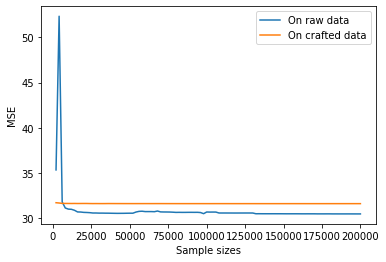

In [9]:
plot_convergence(lr_samplesizes, "LR_SampleSizes")

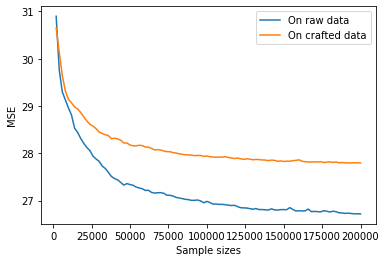

In [10]:
plot_convergence(rf_samplesizes, "RF_SampleSizes")

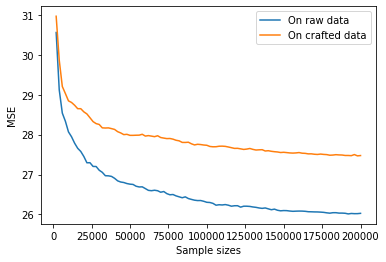

In [11]:
plot_convergence(gbdt_samplesizes, "GBDT_SampleSizes")

In [ ]:
plot_convergence(nn_samplesizes, "NN_SampleSizes")

## Part 2: Hyperparameter optimization (HPO)

### Train optimal configuration on full sample size

In [42]:
sample_size=200000
X_train, X_test, y_train, y_test = train_test_split(X_crafted, y_crafted, train_size=0.8, random_state=42)
train_set = lgb.Dataset(X_train[:sample_size],y_train[:sample_size])
valid_set = lgb.Dataset(X_test, y_test)

params = {
    "rf_optim" : {
        "boosting_type" : "rf",
        "metric" : "l2",
        "learning_rate" : 1, 
        "n_estimators" : 1000,
        "early_stopping" : 20,
        'feature_fraction': 0.87,
        'feature_fraction_bynode': 0.86, 
        'subsample': 0.8,
        'subsample_freq': 6,
        'num_leaves': 1000,
        'min_child_samples': 1,
        "max_bin" : 1000,
        "min_data_in_bin" : 1,
        "random_state" : 42,
    },
    "gbdt_optim" : {
        "boosting_type" : "gbdt",
        "metric" : "l2",
        "objective" : "regression",
        "n_estimators": 1000,
        "max_depth": 53,
        "learning_rate": 0.031,
        "feature_fraction": 0.65,
        "feature_fraction_bynode": 0.94,
        "num_leaves": 160,
        "min_child_samples": 205,
        "subsample_freq": 6,
        "subsample": 0.95,
        "max_bin" : 1000,
        "num_threads"  : 6,
        "random_state" : 42,
        "force_row_wise" : True, 
        "early_stopping" : 20,
    }
}

evals_result = {}

bst = lgb.train(
    params["rf_optim"],
    train_set=train_set,
    valid_sets=[valid_set],
    valid_names=["Validation error", "Train error"],
    verbose_eval=1,
    evals_result = evals_result
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[1]	Validation error's l2: 30.8473
Training until validation scores don't improve for 20 rounds
[2]	Validation error's l2: 29.4502
[3]	Validation error's l2: 29.0632
[4]	Validation error's l2: 28.8584
[5]	Validation error's l2: 28.6138
[6]	Validation error's l2: 28.4238
[7]	Validation error's l2: 28.4737
[8]	Validation error's l2: 28.3754
[9]	Validation error's l2: 28.2748
[10]	Validation error's l2: 28.2034
[11]	Validation error's l2: 28.193
[12]	Validation error's l2: 28.1638
[13]	Validation error's l2: 28.1558
[14]	Validation error's l2: 28.1087
[15]	Validation error's l2: 28.0808
[16]	Validation error's l2: 28.0734
[17]	Validation error's l2:

In [38]:
def trees_objective(trial, X, y, mode, sample_size=200000):
    
    sample_size=sample_size
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    train_set = lgb.Dataset(X_train[:sample_size],y_train[:sample_size])
    valid_set = lgb.Dataset(X_test, y_test)

    if mode == "gbdt":
        params = {
            "boosting_type" : "gbdt",
            "metric" : "l2",
            "objective" : "regression",
            "n_estimators": 1000,
            "max_depth" : trial.suggest_int("max_depth", 5, 100),
            "learning_rate" : trial.suggest_float("learning_rate", 0.01, 0.05, step=0.001),
            "feature_fraction" : trial.suggest_float("feature_fraction", 0.1, 1.0, step=0.01),
            "feature_fraction_bynode" : trial.suggest_float("feature_fraction_bynode", 0.3, 1.0, step=0.01),
            "num_leaves" : trial.suggest_int("num_leaves", 20, 300),
            "min_child_samples" : trial.suggest_int("min_child_samples", 1, 200),
            "subsample_freq" : trial.suggest_int("subsample_freq", 1, 10, step=1),
            "subsample" : trial.suggest_float("subsample", 0.3, 1.0, step=0.01),
            "max_bin" : 1000,
            "feature_pre_filter" : False,
            "num_threads"  : 6,
            "random_state" : 42,
            "force_row_wise" : True, 
            "early_stopping" : 20,
        }
    else:
        params = {
            "boosting_type" : "rf",
            "metric" : "l2",
            "objective" : "regression",
            "n_estimators" : 1000,
            "max_depth" : trial.suggest_int("max_depth", 5, 100),
            "feature_fraction" : trial.suggest_float("feature_fraction", 0.30, 1.0, step=0.01),
            "feature_fraction_bynode" : trial.suggest_float("feature_fraction_bynode", 0.3, 1.0, step=0.01),
            "feature_pre_filter" : False,
            "subsample" : trial.suggest_float("subsample", 0.30, 0.99, step=0.01), 
            "subsample_freq" : trial.suggest_int("subsample_freq", 1, 10),
            "num_leaves" : trial.suggest_int("num_leaves", 900, 1200),
            "min_child_samples" : 1,
            "max_bin" : 1000,
            "min_data_in_bin" : 1,
            "num_threads"  : 6,
            "random_state" : 42,
            "force_row_wise" : True, 
            "early_stopping" : 20,
        }
    evals_result = {}
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "l2")
    lgb.train(
        params,
        train_set=train_set,
        valid_sets=[valid_set],
        verbose_eval=0,
        evals_result = evals_result,
        callbacks=[pruning_callback]
    )

    best_mse = best_iteration(evals_result["valid_0"]["l2"])
    return best_mse

In [14]:
gbdt_raw_optuna = optuna.create_study(
    direction="minimize", 
    sampler=optuna.samplers.CmaEsSampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner()
)
gbdt_raw_optuna.optimize(lambda trial: trees_objective(trial, X_raw, y_raw, "gbdt"), n_trials=100)

joblib.dump(gbdt_raw_optuna, "optunaStudies/gbdt_raw_optuna.pkl")

print_results(gbdt_raw_optuna)

[I 2021-02-06 00:06:54,662] A new study created in memory with name: no-name-00c36bb8-217b-4feb-b82e-59c8ad4d7d09


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:07:10,310] Trial 0 finished with value: 25.99924776168702 and parameters: {'max_depth': 56, 'learning_rate': 0.048, 'feature_fraction': 0.76, 'feature_fraction_bynode': 0.72, 'num_leaves': 122, 'min_child_samples': 131, 'subsample_freq': 3, 'subsample': 0.37}. Best is trial 0 with value: 25.99924776168702.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:07:39,571] Trial 1 finished with value: 25.69646205193807 and parameters: {'max_depth': 52, 'learning_rate': 0.03, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 5, 'subsample': 0.94}. Best is trial 1 with value: 25.69646205193807.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:08:12,520] Trial 2 finished with value: 25.67324072576271 and parameters: {'max_depth': 53, 'learning_rate': 0.031, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.95}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:08:33,418] Trial 3 finished with value: 25.722016661511635 and parameters: {'max_depth': 52, 'learning_rate': 0.039, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.96}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:09:01,428] Trial 4 finished with value: 25.79182101423089 and parameters: {'max_depth': 79, 'learning_rate': 0.045000000000000005, 'feature_fraction': 0.64, 'feature_fraction_bynode': 0.8, 'num_leaves': 169, 'min_child_samples': 318, 'subsample_freq': 2, 'subsample': 0.81}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:09:27,473] Trial 5 finished with value: 25.694618420359326 and parameters: {'max_depth': 52, 'learning_rate': 0.041, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 5, 'subsample': 0.94}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:09:54,470] Trial 6 finished with value: 25.688789578644336 and parameters: {'max_depth': 53, 'learning_rate': 0.038, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.96, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.95}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:09:56,059] Trial 7 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:09:57,786] Trial 8 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:10:16,694] Trial 9 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:10:18,830] Trial 10 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:10:38,637] Trial 11 finished with value: 26.36730391072015 and parameters: {'max_depth': 34, 'learning_rate': 0.018000000000000002, 'feature_fraction': 0.26, 'feature_fraction_bynode': 0.43, 'num_leaves': 41, 'min_child_samples': 262, 'subsample_freq': 9, 'subsample': 0.5}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:11:06,208] Trial 12 finished with value: 25.679277442195247 and parameters: {'max_depth': 53, 'learning_rate': 0.041, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 5, 'subsample': 0.95}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:11:07,689] Trial 13 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:11:29,212] Trial 14 finished with value: 25.741221840540224 and parameters: {'max_depth': 53, 'learning_rate': 0.05, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.94}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:11:50,822] Trial 15 finished with value: 25.70703748802556 and parameters: {'max_depth': 52, 'learning_rate': 0.047, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 5, 'subsample': 0.94}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:11:54,335] Trial 16 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:11:57,896] Trial 17 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:11:59,569] Trial 18 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:12:01,113] Trial 19 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:12:02,860] Trial 20 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:12:04,661] Trial 21 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:12:06,427] Trial 22 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:12:08,061] Trial 23 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:12:35,707] Trial 24 finished with value: 25.688789578644336 and parameters: {'max_depth': 53, 'learning_rate': 0.038, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.95}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:12:55,165] Trial 25 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:12:57,041] Trial 26 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:12:58,861] Trial 27 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:13:02,107] Trial 28 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:13:03,723] Trial 29 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:13:05,529] Trial 30 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:13:24,434] Trial 31 finished with value: 25.75741596101975 and parameters: {'max_depth': 52, 'learning_rate': 0.049, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.94}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:13:25,974] Trial 32 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:13:27,609] Trial 33 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:13:29,784] Trial 34 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:13:31,473] Trial 35 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:13:51,252] Trial 36 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:13:52,960] Trial 37 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:13:54,589] Trial 38 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:13:56,367] Trial 39 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:13:58,120] Trial 40 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:14:00,305] Trial 41 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:14:01,926] Trial 42 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:14:04,048] Trial 43 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:14:06,251] Trial 44 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:14:07,991] Trial 45 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:14:09,743] Trial 46 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:14:28,186] Trial 47 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:14:29,778] Trial 48 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:14:31,561] Trial 49 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-06 00:15:15,852] Trial 50 finished with value: 26.329806409770487 and parameters: {'max_depth': 63, 'learning_rate': 0.026000000000000002, 'feature_fraction': 0.14, 'feature_fraction_bynode': 0.99, 'num_leaves': 290, 'min_child_samples': 199, 'subsample_freq': 3, 'subsample': 0.5700000000000001}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:15:34,759] Trial 51 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:15:37,105] Trial 52 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:15:38,788] Trial 53 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:15:40,533] Trial 54 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:15:44,397] Trial 55 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:15:45,975] Trial 56 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:16:04,699] Trial 57 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:16:40,593] Trial 58 finished with value: 25.690310834322116 and parameters: {'max_depth': 52, 'learning_rate': 0.032, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 5, 'subsample': 0.95}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:16:44,176] Trial 59 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:16:46,282] Trial 60 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:16:47,783] Trial 61 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:16:49,236] Trial 62 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:16:50,756] Trial 63 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:17:16,680] Trial 64 finished with value: 25.715420570626183 and parameters: {'max_depth': 52, 'learning_rate': 0.042, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.96, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.95}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:17:18,284] Trial 65 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:17:40,220] Trial 66 finished with value: 25.714874727423275 and parameters: {'max_depth': 52, 'learning_rate': 0.05, 'feature_fraction': 0.64, 'feature_fraction_bynode': 0.96, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 5, 'subsample': 0.95}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:17:41,738] Trial 67 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:17:43,404] Trial 68 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:17:45,003] Trial 69 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:17:46,704] Trial 70 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:17:50,050] Trial 71 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:17:51,745] Trial 72 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:17:53,341] Trial 73 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:18:00,808] Trial 74 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:18:02,949] Trial 75 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:18:04,516] Trial 76 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:18:06,603] Trial 77 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:18:08,061] Trial 78 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:18:09,538] Trial 79 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:18:11,238] Trial 80 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:18:12,847] Trial 81 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-06 00:18:56,087] Trial 82 finished with value: 25.6893937737575 and parameters: {'max_depth': 68, 'learning_rate': 0.028999999999999998, 'feature_fraction': 0.88, 'feature_fraction_bynode': 0.78, 'num_leaves': 186, 'min_child_samples': 283, 'subsample_freq': 4, 'subsample': 0.96}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:18:58,284] Trial 83 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:19:00,015] Trial 84 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:19:01,721] Trial 85 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:19:03,246] Trial 86 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:19:04,921] Trial 87 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:19:06,404] Trial 88 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:19:07,962] Trial 89 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:19:11,319] Trial 90 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:19:13,342] Trial 91 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:19:31,459] Trial 92 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:19:33,645] Trial 93 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:19:55,629] Trial 94 finished with value: 25.714961940522745 and parameters: {'max_depth': 53, 'learning_rate': 0.049, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.94}. Best is trial 2 with value: 25.67324072576271.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:19:57,217] Trial 95 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:19:59,275] Trial 96 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:20:01,055] Trial 97 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105


[I 2021-02-06 00:20:02,867] Trial 98 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 39405
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:20:04,492] Trial 99 pruned. Trial was pruned at iteration 3.


Number of finished trials: 100
Best trial:
Value: 25.67324072576271
Params: 
max_depth: 53
learning_rate: 0.031
feature_fraction: 0.65
feature_fraction_bynode: 0.94
num_leaves: 160
min_child_samples: 205
subsample_freq: 6
subsample: 0.95


In [15]:
gbdt_crafted_optuna = optuna.create_study(
    direction="minimize", 
    sampler=optuna.samplers.CmaEsSampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner()
)
gbdt_crafted_optuna.optimize(lambda trial: hpo_trees(trial, X_crafted, y_crafted, "gbdt"), n_trials=100)

joblib.dump(gbdt_crafted_optuna, "optunaStudies/gbdt_crafted_optuna.pkl")

print_results(gbdt_crafted_optuna)

[I 2021-02-06 00:20:04,611] A new study created in memory with name: no-name-9a10637a-32a7-4b48-bec6-8db6f9a7219e


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:20:08,741] Trial 0 finished with value: 27.53263333242355 and parameters: {'max_depth': 56, 'learning_rate': 0.048, 'feature_fraction': 0.76, 'feature_fraction_bynode': 0.72, 'num_leaves': 122, 'min_child_samples': 131, 'subsample_freq': 3, 'subsample': 0.37}. Best is trial 0 with value: 27.53263333242355.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:20:15,312] Trial 1 finished with value: 27.348434735892603 and parameters: {'max_depth': 52, 'learning_rate': 0.03, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 5, 'subsample': 0.94}. Best is trial 1 with value: 27.348434735892603.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:20:22,233] Trial 2 finished with value: 27.349355576487675 and parameters: {'max_depth': 53, 'learning_rate': 0.031, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.95}. Best is trial 1 with value: 27.348434735892603.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:20:27,964] Trial 3 finished with value: 27.43471062653656 and parameters: {'max_depth': 79, 'learning_rate': 0.045000000000000005, 'feature_fraction': 0.64, 'feature_fraction_bynode': 0.8, 'num_leaves': 169, 'min_child_samples': 318, 'subsample_freq': 2, 'subsample': 0.81}. Best is trial 1 with value: 27.348434735892603.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:20:32,665] Trial 4 finished with value: 27.386283473062743 and parameters: {'max_depth': 52, 'learning_rate': 0.045000000000000005, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.95}. Best is trial 1 with value: 27.348434735892603.
[I 2021-02-06 00:20:33,020] Trial 5 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:20:33,402] Trial 6 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:20:33,718] Trial 7 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:20:34,064] Trial 8 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-02-06 00:20:40,952] Trial 9 finished with value: 29.188289358205783 and parameters: {'max_depth': 34, 'learning_rate': 0.018000000000000002, 'feature_fraction': 0.26, 'feature_fraction_bynode': 0.43, 'num_leaves': 41, 'min_child_samples': 262, 'subsample_freq': 9, 'subsample': 0.5}. Best is trial 1 with value: 27.348434735892603.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-06 00:20:41,331] Trial 10 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:20:45,988] Trial 11 finished with value: 27.381968988579107 and parameters: {'max_depth': 53, 'learning_rate': 0.046000000000000006, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.96, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.95}. Best is trial 1 with value: 27.348434735892603.
[I 2021-02-06 00:20:46,324] Trial 12 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-02-06 00:20:56,039] Trial 13 finished with value: 28.84482939361948 and parameters: {'max_depth': 63, 'learning_rate': 0.026000000000000002, 'feature_fraction': 0.14, 'feature_fraction_bynode': 0.99, 'num_leaves': 290, 'min_child_samples': 199, 'subsample_freq': 3, 'subsample': 0.5700000000000001}. Best is trial 1 with value: 27.348434735892603.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:00,553] Trial 14 finished with value: 27.38010937994055 and parameters: {'max_depth': 52, 'learning_rate': 0.048, 'feature_fraction': 0.64, 'feature_fraction_bynode': 0.96, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.94}. Best is trial 1 with value: 27.348434735892603.
[I 2021-02-06 00:21:00,938] Trial 15 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:05,840] Trial 16 pruned. Trial was pruned at iteration 243.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:06,665] Trial 17 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:07,152] Trial 18 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 00:21:07,499] Trial 19 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:07,822] Trial 20 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:08,144] Trial 21 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:08,475] Trial 22 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:08,815] Trial 23 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:09,185] Trial 24 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:09,531] Trial 25 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:15,116] Trial 26 finished with value: 27.36258392226547 and parameters: {'max_depth': 52, 'learning_rate': 0.041, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.95}. Best is trial 1 with value: 27.348434735892603.
[I 2021-02-06 00:21:15,463] Trial 27 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:15,823] Trial 28 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:16,179] Trial 29 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:23,113] Trial 30 finished with value: 27.364683351311648 and parameters: {'max_depth': 68, 'learning_rate': 0.028999999999999998, 'feature_fraction': 0.88, 'feature_fraction_bynode': 0.78, 'num_leaves': 186, 'min_child_samples': 283, 'subsample_freq': 4, 'subsample': 0.96}. Best is trial 1 with value: 27.348434735892603.
[I 2021-02-06 00:21:23,451] Trial 31 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:23,801] Trial 32 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:24,181] Trial 33 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:24,519] Trial 34 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:25,019] Trial 35 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 00:21:25,367] Trial 36 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:30,143] Trial 37 pruned. Trial was pruned at iteration 243.
[I 2021-02-06 00:21:30,467] Trial 38 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:30,813] Trial 39 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:31,131] Trial 40 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:31,472] Trial 41 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:31,866] Trial 42 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:32,203] Trial 43 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:32,541] Trial 44 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:32,853] Trial 45 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:37,355] Trial 46 finished with value: 27.385247866329554 and parameters: {'max_depth': 53, 'learning_rate': 0.048, 'feature_fraction': 0.64, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.95}. Best is trial 1 with value: 27.348434735892603.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:37,862] Trial 47 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 00:21:38,211] Trial 48 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:38,719] Trial 49 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 00:21:39,075] Trial 50 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:39,410] Trial 51 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:39,736] Trial 52 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:40,141] Trial 53 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:40,523] Trial 54 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:45,153] Trial 55 finished with value: 27.381807681702288 and parameters: {'max_depth': 52, 'learning_rate': 0.047, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.96}. Best is trial 1 with value: 27.348434735892603.
[I 2021-02-06 00:21:45,474] Trial 56 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:45,842] Trial 57 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:46,331] Trial 58 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 00:21:46,655] Trial 59 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:21:51,428] Trial 60 finished with value: 27.37581914692738 and parameters: {'max_depth': 52, 'learning_rate': 0.05, 'feature_fraction': 0.63, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 5, 'subsample': 0.96}. Best is trial 1 with value: 27.348434735892603.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2021-02-06 00:22:01,648] Trial 61 finished with value: 28.095579540648764 and parameters: {'max_depth': 18, 'learning_rate': 0.043000000000000003, 'feature_fraction': 0.37, 'feature_fraction_bynode': 0.36, 'num_leaves': 111, 'min_child_samples': 376, 'subsample_freq': 7, 'subsample': 0.73}. Best is trial 1 with value: 27.348434735892603.
[I 2021-02-06 00:22:01,980] Trial 62 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:02,311] Trial 63 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:08,533] Trial 64 finished with value: 27.363908582489717 and parameters: {'max_depth': 52, 'learning_rate': 0.033, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.94}. Best is trial 1 with value: 27.348434735892603.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:13,113] Trial 65 finished with value: 27.370964130525937 and parameters: {'max_depth': 52, 'learning_rate': 0.049, 'feature_fraction': 0.63, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 5, 'subsample': 0.94}. Best is trial 1 with value: 27.348434735892603.
[I 2021-02-06 00:22:13,455] Trial 66 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:18,133] Trial 67 finished with value: 27.37375081407642 and parameters: {'max_depth': 53, 'learning_rate': 0.043000000000000003, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.94, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 5, 'subsample': 0.95}. Best is trial 1 with value: 27.348434735892603.
[I 2021-02-06 00:22:18,501] Trial 68 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:18,828] Trial 69 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:19,160] Trial 70 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:19,532] Trial 71 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:19,854] Trial 72 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:20,364] Trial 73 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 00:22:20,685] Trial 74 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:21,052] Trial 75 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:21,388] Trial 76 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:25,756] Trial 77 finished with value: 27.380109379940556 and parameters: {'max_depth': 53, 'learning_rate': 0.048, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.96, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 6, 'subsample': 0.94}. Best is trial 1 with value: 27.348434735892603.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:26,245] Trial 78 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 00:22:26,629] Trial 79 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:32,220] Trial 80 finished with value: 27.35417465407023 and parameters: {'max_depth': 52, 'learning_rate': 0.038, 'feature_fraction': 0.65, 'feature_fraction_bynode': 0.96, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 5, 'subsample': 0.95}. Best is trial 1 with value: 27.348434735892603.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:32,737] Trial 81 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 00:22:33,119] Trial 82 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:33,635] Trial 83 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 00:22:33,980] Trial 84 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:34,314] Trial 85 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:34,679] Trial 86 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:35,019] Trial 87 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:35,351] Trial 88 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:35,867] Trial 89 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 00:22:36,248] Trial 90 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:36,612] Trial 91 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:37,405] Trial 92 pruned. Trial was pruned at iteration 27.
[I 2021-02-06 00:22:37,786] Trial 93 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:38,141] Trial 94 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:42,667] Trial 95 finished with value: 27.384403771633725 and parameters: {'max_depth': 52, 'learning_rate': 0.05, 'feature_fraction': 0.66, 'feature_fraction_bynode': 0.95, 'num_leaves': 160, 'min_child_samples': 205, 'subsample_freq': 5, 'subsample': 0.95}. Best is trial 1 with value: 27.348434735892603.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:43,520] Trial 96 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:44,322] Trial 97 pruned. Trial was pruned at iteration 27.
[I 2021-02-06 00:22:44,703] Trial 98 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3688
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 00:22:45,174] Trial 99 pruned. Trial was pruned at iteration 9.


Number of finished trials: 100
Best trial:
Value: 27.348434735892603
Params: 
max_depth: 52
learning_rate: 0.03
feature_fraction: 0.65
feature_fraction_bynode: 0.94
num_leaves: 160
min_child_samples: 205
subsample_freq: 5
subsample: 0.94


In [40]:
rf_raw_optuna = optuna.create_study(
    direction="minimize", 
    sampler=optuna.samplers.CmaEsSampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner()
)
rf_raw_optuna.optimize(lambda trial: trees_objective(trial, X_raw, y_raw, "rf"), n_trials=100)

joblib.dump(rf_raw_optuna, "optunaStudies/rf_raw_optuna.pkl")

print_results(rf_raw_optuna)

[I 2021-02-06 19:04:23,363] A new study created in memory with name: no-name-d4d1a431-4a7a-4a72-a186-f105d6333032


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:04:50,138] Trial 0 finished with value: 26.883449190350756 and parameters: {'max_depth': 56, 'feature_fraction': 0.97, 'feature_fraction_bynode': 0.81, 'subsample': 0.71, 'subsample_freq': 7, 'num_leaves': 1021}. Best is trial 0 with value: 26.883449190350756.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:05:17,299] Trial 1 finished with value: 26.970979775699163 and parameters: {'max_depth': 52, 'feature_fraction': 0.9299999999999999, 'feature_fraction_bynode': 0.8600000000000001, 'subsample': 0.96, 'subsample_freq': 6, 'num_leaves': 1050}. Best is trial 0 with value: 26.883449190350756.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:05:21,108] Trial 2 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:06:17,017] Trial 3 finished with value: 27.112089595159656 and parameters: {'max_depth': 52, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.99, 'subsample': 0.77, 'subsample_freq': 5, 'num_leaves': 1050}. Best is trial 0 with value: 26.883449190350756.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:06:31,437] Trial 4 finished with value: 27.2316708495211 and parameters: {'max_depth': 52, 'feature_fraction': 0.62, 'feature_fraction_bynode': 0.96, 'subsample': 0.71, 'subsample_freq': 6, 'num_leaves': 1050}. Best is trial 0 with value: 26.883449190350756.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:06:41,120] Trial 5 finished with value: 28.641584852395507 and parameters: {'max_depth': 87, 'feature_fraction': 0.37, 'feature_fraction_bynode': 0.62, 'subsample': 0.53, 'subsample_freq': 8, 'num_leaves': 1051}. Best is trial 0 with value: 26.883449190350756.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2021-02-06 19:06:43,739] Trial 6 finished with value: 31.05882252911108 and parameters: {'max_depth': 7, 'feature_fraction': 0.31, 'feature_fraction_bynode': 0.98, 'subsample': 0.8799999999999999, 'subsample_freq': 6, 'num_leaves': 1091}. Best is trial 0 with value: 26.883449190350756.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:06:46,150] Trial 7 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:07:16,647] Trial 8 finished with value: 26.972169462316636 and parameters: {'max_depth': 52, 'feature_fraction': 0.96, 'feature_fraction_bynode': 0.9199999999999999, 'subsample': 0.8600000000000001, 'subsample_freq': 6, 'num_leaves': 1050}. Best is trial 0 with value: 26.883449190350756.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:07:19,058] Trial 9 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:07:20,925] Trial 10 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:07:23,295] Trial 11 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:08:00,672] Trial 12 finished with value: 26.93422570305228 and parameters: {'max_depth': 53, 'feature_fraction': 0.8799999999999999, 'feature_fraction_bynode': 0.94, 'subsample': 0.94, 'subsample_freq': 5, 'num_leaves': 1050}. Best is trial 0 with value: 26.883449190350756.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:08:02,675] Trial 13 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:08:53,254] Trial 14 finished with value: 26.952887947020656 and parameters: {'max_depth': 53, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.77, 'subsample': 0.8400000000000001, 'subsample_freq': 5, 'num_leaves': 1050}. Best is trial 0 with value: 26.883449190350756.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:08:55,255] Trial 15 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:09:00,575] Trial 16 finished with value: 28.677247676171678 and parameters: {'max_depth': 64, 'feature_fraction': 0.43, 'feature_fraction_bynode': 0.51, 'subsample': 0.6599999999999999, 'subsample_freq': 9, 'num_leaves': 948}. Best is trial 0 with value: 26.883449190350756.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:09:08,518] Trial 17 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:09:12,380] Trial 18 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:09:14,775] Trial 19 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:09:17,075] Trial 20 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:09:19,466] Trial 21 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:09:23,353] Trial 22 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:09,102] Trial 23 finished with value: 26.865612584326065 and parameters: {'max_depth': 53, 'feature_fraction': 0.75, 'feature_fraction_bynode': 0.8999999999999999, 'subsample': 0.98, 'subsample_freq': 5, 'num_leaves': 1050}. Best is trial 23 with value: 26.865612584326065.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:11,493] Trial 24 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:13,848] Trial 25 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:15,810] Trial 26 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:18,159] Trial 27 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:20,594] Trial 28 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:23,077] Trial 29 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:25,456] Trial 30 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:27,848] Trial 31 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:30,285] Trial 32 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:32,148] Trial 33 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:34,654] Trial 34 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:38,692] Trial 35 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:40,539] Trial 36 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:42,385] Trial 37 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:10:44,248] Trial 38 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:11:06,058] Trial 39 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:11:07,975] Trial 40 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:11:10,494] Trial 41 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:11:12,522] Trial 42 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:11:14,551] Trial 43 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:11:16,523] Trial 44 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:11:20,376] Trial 45 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:11:22,326] Trial 46 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:11:24,238] Trial 47 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:12:03,065] Trial 48 finished with value: 26.87883834044887 and parameters: {'max_depth': 52, 'feature_fraction': 0.8, 'feature_fraction_bynode': 0.97, 'subsample': 0.94, 'subsample_freq': 6, 'num_leaves': 1050}. Best is trial 23 with value: 26.865612584326065.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:12:04,975] Trial 49 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:12:06,801] Trial 50 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:12:08,616] Trial 51 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:12:12,532] Trial 52 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:12:14,358] Trial 53 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:12:16,282] Trial 54 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:13:35,879] Trial 55 finished with value: 27.36411592969426 and parameters: {'max_depth': 53, 'feature_fraction': 1.0, 'feature_fraction_bynode': 1.0, 'subsample': 0.8799999999999999, 'subsample_freq': 6, 'num_leaves': 1050}. Best is trial 23 with value: 26.865612584326065.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:13:39,865] Trial 56 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:13:43,683] Trial 57 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:13:45,566] Trial 58 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:13:47,419] Trial 59 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:14:50,813] Trial 60 finished with value: 27.189465381649534 and parameters: {'max_depth': 53, 'feature_fraction': 0.98, 'feature_fraction_bynode': 0.99, 'subsample': 0.8700000000000001, 'subsample_freq': 5, 'num_leaves': 1050}. Best is trial 23 with value: 26.865612584326065.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:14:54,777] Trial 61 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:15:03,127] Trial 62 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:15:05,011] Trial 63 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:15:07,280] Trial 64 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:15:29,944] Trial 65 finished with value: 26.887106167336484 and parameters: {'max_depth': 52, 'feature_fraction': 0.8600000000000001, 'feature_fraction_bynode': 0.8799999999999999, 'subsample': 0.99, 'subsample_freq': 5, 'num_leaves': 1050}. Best is trial 23 with value: 26.865612584326065.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:15:32,197] Trial 66 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:15:34,035] Trial 67 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:15:35,932] Trial 68 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:15:54,263] Trial 69 finished with value: 26.94615120987371 and parameters: {'max_depth': 52, 'feature_fraction': 0.71, 'feature_fraction_bynode': 0.8300000000000001, 'subsample': 0.79, 'subsample_freq': 6, 'num_leaves': 1050}. Best is trial 23 with value: 26.865612584326065.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:15:56,221] Trial 70 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:15:58,129] Trial 71 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:15:59,967] Trial 72 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:16:01,864] Trial 73 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:16:26,789] Trial 74 finished with value: 26.891990766782133 and parameters: {'max_depth': 52, 'feature_fraction': 0.72, 'feature_fraction_bynode': 0.94, 'subsample': 0.99, 'subsample_freq': 5, 'num_leaves': 1050}. Best is trial 23 with value: 26.865612584326065.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:16:29,146] Trial 75 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:16:31,600] Trial 76 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:17:15,075] Trial 77 finished with value: 26.875657820118324 and parameters: {'max_depth': 52, 'feature_fraction': 0.8400000000000001, 'feature_fraction_bynode': 0.9299999999999999, 'subsample': 0.94, 'subsample_freq': 6, 'num_leaves': 1050}. Best is trial 23 with value: 26.865612584326065.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:17:17,503] Trial 78 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:17:21,352] Trial 79 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:17:23,259] Trial 80 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:17:25,070] Trial 81 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:17:27,448] Trial 82 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:17:29,831] Trial 83 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:17:33,562] Trial 84 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:17:41,970] Trial 85 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:17:44,376] Trial 86 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:17:46,837] Trial 87 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:17:55,157] Trial 88 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:18:03,047] Trial 89 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:18:05,514] Trial 90 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:18:07,376] Trial 91 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:18:09,359] Trial 92 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:18:11,277] Trial 93 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:18:13,660] Trial 94 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:18:35,138] Trial 95 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:18:37,017] Trial 96 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:18:39,322] Trial 97 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:18:47,409] Trial 98 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 40992
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 105
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:19:07,929] Trial 99 finished with value: 26.903164516175707 and parameters: {'max_depth': 52, 'feature_fraction': 0.69, 'feature_fraction_bynode': 0.8600000000000001, 'subsample': 0.99, 'subsample_freq': 6, 'num_leaves': 1050}. Best is trial 23 with value: 26.865612584326065.


Number of finished trials: 100
Best trial:
Value: 26.865612584326065
Params: 
max_depth: 53
feature_fraction: 0.75
feature_fraction_bynode: 0.8999999999999999
subsample: 0.98
subsample_freq: 5
num_leaves: 1050


In [41]:
rf_crafted_optuna = optuna.create_study(
    direction="minimize", 
    sampler=optuna.samplers.CmaEsSampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    load_if_exists=False
)

rf_crafted_optuna.optimize(lambda trial : trees_objective(trial, X_crafted, y_crafted, mode="rf"), n_trials=100)

joblib.dump(rf_crafted_optuna, "optunaStudies/rf_crafted_optuna.pkl")

print_results(rf_crafted_optuna)

[I 2021-02-06 19:19:07,989] A new study created in memory with name: no-name-5e20da23-74ca-499b-898f-24137a3ee38d


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:19:21,066] Trial 0 finished with value: 27.89692569719326 and parameters: {'max_depth': 56, 'feature_fraction': 0.97, 'feature_fraction_bynode': 0.81, 'subsample': 0.71, 'subsample_freq': 7, 'num_leaves': 1021}. Best is trial 0 with value: 27.89692569719326.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:19:28,159] Trial 1 finished with value: 27.876140134935255 and parameters: {'max_depth': 52, 'feature_fraction': 0.9299999999999999, 'feature_fraction_bynode': 0.8600000000000001, 'subsample': 0.96, 'subsample_freq': 6, 'num_leaves': 1050}. Best is trial 1 with value: 27.876140134935255.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:19:38,759] Trial 2 finished with value: 27.917986294222363 and parameters: {'max_depth': 52, 'feature_fraction': 0.94, 'feature_fraction_bynode': 0.8400000000000001, 'subsample': 0.98, 'subsample_freq': 6, 'num_leaves': 1050}. Best is trial 1 with value: 27.876140134935255.
[I 2021-02-06 19:19:39,155] Trial 3 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2021-02-06 19:19:42,501] Trial 4 finished with value: 30.663224001171688 and parameters: {'max_depth': 87, 'feature_fraction': 0.37, 'feature_fraction_bynode': 0.62, 'subsample': 0.53, 'subsample_freq': 8, 'num_leaves': 1051}. Best is trial 1 with value: 27.876140134935255.
[I 2021-02-06 19:19:42,900] Trial 5 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

[I 2021-02-06 19:19:44,288] Trial 6 finished with value: 30.58779803917575 and parameters: {'max_depth': 7, 'feature_fraction': 0.31, 'feature_fraction_bynode': 0.98, 'subsample': 0.8799999999999999, 'subsample_freq': 6, 'num_leaves': 1091}. Best is trial 1 with value: 27.876140134935255.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:19:59,179] Trial 7 finished with value: 28.03071733227901 and parameters: {'max_depth': 53, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.9199999999999999, 'subsample': 0.8200000000000001, 'subsample_freq': 6, 'num_leaves': 1050}. Best is trial 1 with value: 27.876140134935255.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:13,592] Trial 8 finished with value: 28.056471362782634 and parameters: {'max_depth': 52, 'feature_fraction': 0.96, 'feature_fraction_bynode': 0.9199999999999999, 'subsample': 0.8600000000000001, 'subsample_freq': 6, 'num_leaves': 1050}. Best is trial 1 with value: 27.876140134935255.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:14,112] Trial 9 pruned. Trial was pruned at iteration 3.
[I 2021-02-06 19:20:14,518] Trial 10 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:14,925] Trial 11 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:20,322] Trial 12 finished with value: 27.905890684852967 and parameters: {'max_depth': 53, 'feature_fraction': 0.8799999999999999, 'feature_fraction_bynode': 0.94, 'subsample': 0.94, 'subsample_freq': 5, 'num_leaves': 1050}. Best is trial 1 with value: 27.876140134935255.
[I 2021-02-06 19:20:20,711] Trial 13 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:21,232] Trial 14 pruned. Trial was pruned at iteration 3.
[I 2021-02-06 19:20:21,656] Trial 15 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:22,162] Trial 16 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:22,706] Trial 17 pruned. Trial was pruned at iteration 3.
[I 2021-02-06 19:20:23,112] Trial 18 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:25,656] Trial 19 finished with value: 27.95441975687204 and parameters: {'max_depth': 52, 'feature_fraction': 0.71, 'feature_fraction_bynode': 0.8700000000000001, 'subsample': 0.99, 'subsample_freq': 5, 'num_leaves': 1050}. Best is trial 1 with value: 27.876140134935255.
[I 2021-02-06 19:20:26,055] Trial 20 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:26,580] Trial 21 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:27,428] Trial 22 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 19:20:27,813] Trial 23 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:28,233] Trial 24 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:28,637] Trial 25 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:29,459] Trial 26 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:31,289] Trial 27 pruned. Trial was pruned at iteration 27.
[I 2021-02-06 19:20:31,664] Trial 28 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:32,217] Trial 29 pruned. Trial was pruned at iteration 3.
[I 2021-02-06 19:20:32,620] Trial 30 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:33,192] Trial 31 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:33,726] Trial 32 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:34,279] Trial 33 pruned. Trial was pruned at iteration 3.
[I 2021-02-06 19:20:34,671] Trial 34 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:39,661] Trial 35 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:40,524] Trial 36 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 19:20:40,917] Trial 37 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:41,424] Trial 38 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:41,949] Trial 39 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:43,852] Trial 40 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:45,769] Trial 41 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:47,658] Trial 42 pruned. Trial was pruned at iteration 27.
[I 2021-02-06 19:20:48,053] Trial 43 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:48,431] Trial 44 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:48,926] Trial 45 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:49,745] Trial 46 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 19:20:50,134] Trial 47 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:50,557] Trial 48 pruned. Trial was pruned at iteration 1.
[I 2021-02-06 19:20:50,947] Trial 49 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:51,349] Trial 50 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:57,323] Trial 51 finished with value: 27.830712359717957 and parameters: {'max_depth': 53, 'feature_fraction': 0.8400000000000001, 'feature_fraction_bynode': 0.94, 'subsample': 0.8799999999999999, 'subsample_freq': 5, 'num_leaves': 1050}. Best is trial 51 with value: 27.830712359717957.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:20:59,262] Trial 52 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:01,329] Trial 53 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:02,250] Trial 54 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:02,781] Trial 55 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:03,659] Trial 56 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 19:21:04,069] Trial 57 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:04,584] Trial 58 pruned. Trial was pruned at iteration 3.
[I 2021-02-06 19:21:04,990] Trial 59 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:05,511] Trial 60 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:06,365] Trial 61 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:07,260] Trial 62 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:07,801] Trial 63 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:08,322] Trial 64 pruned. Trial was pruned at iteration 3.
[I 2021-02-06 19:21:08,697] Trial 65 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:09,525] Trial 66 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:10,413] Trial 67 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:10,956] Trial 68 pruned. Trial was pruned at iteration 3.
[I 2021-02-06 19:21:11,354] Trial 69 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:11,772] Trial 70 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:12,295] Trial 71 pruned. Trial was pruned at iteration 3.
[I 2021-02-06 19:21:12,701] Trial 72 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:13,113] Trial 73 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:14,000] Trial 74 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 19:21:14,376] Trial 75 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:15,224] Trial 76 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 19:21:15,616] Trial 77 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:15,984] Trial 78 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:17,940] Trial 79 pruned. Trial was pruned at iteration 27.
[I 2021-02-06 19:21:18,335] Trial 80 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:18,747] Trial 81 pruned. Trial was pruned at iteration 1.
[I 2021-02-06 19:21:19,142] Trial 82 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:19,543] Trial 83 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:21,385] Trial 84 pruned. Trial was pruned at iteration 27.
[I 2021-02-06 19:21:21,799] Trial 85 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:22,212] Trial 86 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:22,616] Trial 87 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:23,167] Trial 88 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:24,034] Trial 89 pruned. Trial was pruned at iteration 9.
[I 2021-02-06 19:21:24,429] Trial 90 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:24,954] Trial 91 pruned. Trial was pruned at iteration 3.
[I 2021-02-06 19:21:25,346] Trial 92 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:25,835] Trial 93 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:26,340] Trial 94 pruned. Trial was pruned at iteration 3.
[I 2021-02-06 19:21:26,737] Trial 95 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790
[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:27,241] Trial 96 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:29,154] Trial 97 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:31,037] Trial 98 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Total Bins 3751
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 12
[LightGBM] [Info] Start training from score 4.167790


[I 2021-02-06 19:21:32,696] Trial 99 finished with value: 29.554118559994272 and parameters: {'max_depth': 64, 'feature_fraction': 0.43, 'feature_fraction_bynode': 0.51, 'subsample': 0.6599999999999999, 'subsample_freq': 9, 'num_leaves': 948}. Best is trial 51 with value: 27.830712359717957.


Number of finished trials: 100
Best trial:
Value: 27.830712359717957
Params: 
max_depth: 53
feature_fraction: 0.8400000000000001
feature_fraction_bynode: 0.94
subsample: 0.8799999999999999
subsample_freq: 5
num_leaves: 1050


### HPO for Neural Network

In [ ]:
def nn_objective(trial):
    n_features = len(data.columns) - 1
    n_hidden = math.ceil(n_features * (1 / 2))
    n_code = math.ceil(n_hidden * (1 / 2))
    
    slp = Regressor(n_features = n_features, n_hidden = n_hidden, n_output = 1)
    
    params = {
        "patience" : 50,
        "criterion" : nn.MSELoss(),
        "optimizer" : optim.Adam(slp.parameters(), lr=0.0002),
        "epochs" : 500,
        "batch_size" : 50,
    }
    
    model, mse = nn_train(
        model=slp, 
        data=data, 
        params=params,
        rows=rows
    )
    results.append(mse)
    print(f"Mean squared error: {mse} for sample size: {rows}")

### Visualize results

Load study

In [26]:
loaded_study = joblib.load("optunaStudies/gbdt_raw_optuna.pkl")
print_results(loaded_study)

Number of finished trials: 100
Best trial:
Value: 25.67324072576271
Params: 
max_depth: 53
learning_rate: 0.031
feature_fraction: 0.65
feature_fraction_bynode: 0.94
num_leaves: 160
min_child_samples: 205
subsample_freq: 6
subsample: 0.95


In [27]:
optuna.visualization.plot_param_importances(
    loaded_study, 
    evaluator=optuna.importance.FanovaImportanceEvaluator(n_trees = 1000, seed=42)
)

In [16]:
optuna.visualization.plot_parallel_coordinate(loaded_study)

In [30]:
optuna.visualization.plot_intermediate_values(loaded_study)

In [31]:
optuna.visualization.plot_slice(loaded_study)

In [32]:
optuna.visualization.plot_contour(loaded_study, ["feature_fraction", "feature_fraction_bynode"])

# Part 3: Introducing Noise

In [52]:
iwas = ["location_x, location_y"]

ValueError: No axis named location_x, location_y for object type DataFrame

In [64]:
noise_for_crafted = ["location_x", "location_y", "order_time", "restaurant_queue", "etd"]
mu = 0 
sigma = 1

X_raw_noisy = add_noise(raw, noise_for_crafted, mu, sigma)
X_crafted_noisy = add_noise(raw, noise_for_crafted, mu, sigma)